In [27]:
import scipy         
import datetime
from scipy.linalg import expm
import scipy.sparse as sparse
from quspin.operators import hamiltonian, commutator, exp_op # Hamiltonians and operators
from quspin.basis import tensor_basis, spin_basis_1d # bases
import numpy as np # general math functions
import matplotlib.pyplot as plt # plotting library
from numba import jit


In [28]:
L = 5 #system size
M = -0.3 #fermion mass
N=4 #number of layers
l=1 #spin length
m_epsilon = 0
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

In [29]:
#construct basis
basis=spin_basis_1d(L=L,S = str(l))
print(basis)

reference states: 
array index   /   Fock state   /   integer repr. 
       0.         |2 2 2 2 2>           242  
       1.         |2 2 2 2 1>           241  
       2.         |2 2 2 2 0>           240  
       3.         |2 2 2 1 2>           239  
       4.         |2 2 2 1 1>           238  
       5.         |2 2 2 1 0>           237  
       6.         |2 2 2 0 2>           236  
       7.         |2 2 2 0 1>           235  
       8.         |2 2 2 0 0>           234  
       9.         |2 2 1 2 2>           233  
      10.         |2 2 1 2 1>           232  
      11.         |2 2 1 2 0>           231  
      12.         |2 2 1 1 2>           230  
      13.         |2 2 1 1 1>           229  
      14.         |2 2 1 1 0>           228  
      15.         |2 2 1 0 2>           227  
      16.         |2 2 1 0 1>           226  
      17.         |2 2 1 0 0>           225  
      18.         |2 2 0 2 2>           224  
      19.         |2 2 0 2 1>           223  
      20.  

In [30]:
#initialisation of the Gauss laws

liste = []
liste_m = []
gauss_law_map = []
Gauss_law = []
gauss_law_matrix = []
z_comp_minf = [[-m_epsilon,0]]
z_comp_pinf = [[m_epsilon,L-1]]

for i in range(L+1):
    liste.append([[1.,i]])
    liste_m.append([[-1.,i]])
    if i == 0:
        gauss_law_map.append([
            ["z",liste[0]],
            ["I",z_comp_minf],

        ])
    
    elif (i == L) & (i%2 == 0):
        gauss_law_map.append([
            ["z",liste_m[i-1]],
            ["I",z_comp_pinf],
        ])
    
    elif (i == L) & (i%2 == 1):
        gauss_law_map.append([
            ["z",liste_m[i-1]],
            ["I",liste[i-1]],
            ["I",z_comp_pinf],

        ])        
        
    elif i%2 == 0:
        gauss_law_map.append([
            ["z",liste[i]],
            ["z",liste_m[i-1]],
        ])
    elif i%2 == 1:
        gauss_law_map.append([
            ["z",liste[i]],
            ["z",liste_m[i-1]],  
            ["I",liste[i]]
        ])
    Gauss_law.append(hamiltonian(gauss_law_map[i],dynamic_list=[],basis=basis,**no_checks))
for i in range(L+1):
    gauss_law_matrix.append(Gauss_law[i].tocsc())

In [31]:
B = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        B[i][j] = (-2*l+i)**j
b = np.zeros(4*l+1)
b[2*l+1] = 1.
solution = scipy.linalg.solve(B,b)
y = np.zeros(4*3+1)
for i in range(4*l+1):
    y[i] = solution[i]
print(y)
print(b)

[ 0.          0.66666667  0.66666667 -0.16666667 -0.16666667  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
[0. 0. 0. 1. 0.]


In [32]:
C = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        C[i][j] = (-2*l+i+1)**j
c = np.zeros(4*l+1)
c[2*l] = 1.
solution = scipy.linalg.solve(C,c)
z = np.zeros(4*3+1)
for i in range(4*l+1):
    z[i] = solution[i]
print(z)
print(c)

[ 0.    1.5   0.25 -1.    0.25  0.    0.    0.    0.    0.    0.    0.
  0.  ]
[0. 0. 1. 0. 0.]


In [33]:
#projectors on g=1 for every site
Proj = [sparse.csr_matrix((basis.Ns,basis.Ns)) for i in range(L+1)]
for i in range(int(L/2)+1):
    for j in range(4*l+1):
        Proj[2*i] += y[j]*gauss_law_matrix[2*i]**j
for i in range(int(L/2)+1):
    for j in range(4*l+1):
        Proj[2*i+1] += z[j]*gauss_law_matrix[2*i+1]**j

In [34]:
A = np.zeros((2*l+1,2*l+1))
for i in range(2*l+1):
    for j in range(2*l+1):
        A[i][j] = (-l+i)**j
b = np.zeros(2*l+1)
for i in range(2*l+1):
    b[i] = (-1)**(-l+i)
solution = scipy.linalg.solve(A,b)
x = np.zeros(2*3+1)
for i in range(2*l+1):
    x[i] = solution[i]
print(x)

[ 1.  0. -2.  0.  0.  0.  0.]


In [35]:
const_term = []
linear_term = []
quadratic_term = []
cubic_term = []
quartic_term = []
quintic_term = []
sextic_term = []
interaction_p = []
interaction_m = []

for i in range(L-1):
    const_term.append([[x[0]/(2*np.sqrt(l*(l+1))),i]])
    linear_term.append([[x[1]/(2*np.sqrt(l*(l+1))),i,i+1]])
    quadratic_term.append([[x[2]/(2*np.sqrt(l*(l+1))),i,i+1,i+1]])
    cubic_term.append([[(x[3])/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1]])
    quartic_term.append([[(x[4])/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1,i+1]])
    quintic_term.append([[(x[5])/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1,i+1,i+1]])
    sextic_term.append([[(x[6])/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1,i+1,i+1,i+1]])


    interaction_p.append([
        ["+", const_term[i]],
        ["+z", linear_term[i]],
        ["+zz", quadratic_term[i]],
        ["+zzz", cubic_term[i]],
        ["+zzzz", quartic_term[i]],
        ["+zzzzz", quintic_term[i]],
        ["+zzzzzz", sextic_term[i]],

    ])

    interaction_m.append([
        ["-", const_term[i]],
        ["-z", linear_term[i]],
        ["-zz", quadratic_term[i]],
        ["-zzz", cubic_term[i]],
        ["-zzzz", quartic_term[i]],
        ["-zzzzz", quintic_term[i]],
        ["-zzzzzz", sextic_term[i]],

    ])

const_term.append([[(0.5*(-1)**m_epsilon)/np.sqrt(l*(l+1)),L-1]])

interaction_p.append([
    ["+", const_term[L-1]]
])
interaction_m.append([
    ["-", const_term[L-1]]
])

kin_energy = [[0.5,i,i] for i in range(L)]
mass_term = [[2*(-1)**i*M,i] for i in range(L)]

kin_mass_map = [
            ["zz", kin_energy], 
            ["z", mass_term], 
]
H_int_p = []
H_int_m = []
interaction = [sparse.csr_matrix((basis.Ns,basis.Ns)) for i in range(L)]
h_int = sparse.csr_matrix((basis.Ns,basis.Ns))
for i in range(L):
    H_int_p.append(hamiltonian(interaction_p[i],dynamic_list=[],basis=basis,**no_checks))
    H_int_m.append(hamiltonian(interaction_m[i],dynamic_list=[],basis=basis,**no_checks))
    interaction[i] = (Proj[i]@H_int_p[i].tocsc()@Proj[i+1]+Proj[i+1]@H_int_m[i].tocsc()@Proj[i])

H_kin_mass = hamiltonian(kin_mass_map,dynamic_list=[],basis=basis,**no_checks)
h_kin_mass = H_kin_mass.tocsc()

h_int = 0

for i in range(L):
    h_int += interaction[i]


full_ham_matrix = h_kin_mass + h_int #Spin-1 Hamiltonian without the local contstaints

G=0
for i in range(L+1):
    G += 0.12*(Gauss_law[i]**2-Gauss_law[i])**2
constraint_full_matrix = G.tocsc()
constrained_full_ham_matrix= full_ham_matrix + constraint_full_matrix #Spin-1 Hamiltonian with the local contstaints as a penalty term
#print(full_ham_matrix)

In [36]:
#eigenvalues and eigenvectors of the Spin-1 Hamiltonian without the local contstaints
eigenval, eigenvec = scipy.sparse.linalg.eigsh(full_ham_matrix,k = 3,which = "SA")
print(eigenval[eigenval<=1e1])
print(eigenvec[:,0])

[-1.84068817 -1.29811607 -1.00113739]
[-1.49025190e-02+1.80585923e-02j -3.57713258e-18-5.30520455e-18j
  1.22439766e-17-1.06213856e-18j -5.57456763e-02+6.75515624e-02j
  4.72948411e-02-5.73109991e-02j  1.34688775e-17+1.08075760e-18j
  4.33713092e-18-4.61183438e-17j  1.52784564e-17+4.16318205e-18j
 -8.43939144e-18+1.94972414e-17j -9.32821227e-18-5.18556613e-18j
  8.27296804e-18+7.60421393e-18j -1.95009163e-17-1.30360687e-17j
  1.30116985e-17+1.13088623e-17j  1.40101541e-18+1.60956751e-18j
 -1.04279947e-17+3.15364386e-18j -9.83782685e-18-5.13025922e-17j
 -2.53844871e-18-1.73690449e-17j -4.32620690e-18-4.76946014e-18j
  1.87706228e-18+1.45026396e-17j -2.27095438e-17+5.07508915e-18j
  1.32921028e-17-2.16727266e-17j  1.64250416e-17-2.84076699e-18j
  1.24369575e-17-1.35422713e-18j -5.75290741e-19+5.29755187e-19j
  4.89657190e-19+1.48298461e-18j -4.44521231e-18-3.51321707e-18j
  1.16818792e-17-8.86193552e-18j -5.57456763e-02+6.75515624e-02j
 -2.09453939e-17+1.66364361e-17j  1.27074761e-17-3.0

In [37]:
#eigenvalues and eigenvectors of the Spin-1 Hamiltonian with the local contstaints
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(constrained_full_ham_matrix,k = 3,which = "SA")


In [38]:
#Gauge invariant part of the spectrum
string = ""
print(eigenvalues[eigenvalues<=1e1])
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])>=1e-5:
        string+=str(eigenvectors[:,0][i])+basis.int_to_state(basis.Ns-i-1)+"\n"
        #for j in range(basis.Ns):
            #if (np.abs(np.abs(eigenvectors[:,0][i])-np.abs(eigenvectors[:,0][j]))<=1e-5) & (i<j):
                #print(basis.int_to_state(basis.Ns-i-1),basis.int_to_state(basis.Ns-j-1))
print(string)


[-1.84068817 -1.29811607 -0.98569887]
(-0.004758843287167547+0.022924904279742406j)|2 2 2 2 2>
(-0.01780134877644916+0.0857549181858653j)|2 2 2 1 2>
(0.015102731127079577-0.0727547945074412j)|2 2 2 1 1>
(-0.017801348776449313+0.0857549181858655j)|2 1 2 2 2>
(-0.07415404775341153+0.3572242967711239j)|2 1 2 1 2>
(0.06498240422472235-0.31304149072031867j)|2 1 2 1 1>
(0.06292902192546401-0.30314967671855186j)|2 1 1 1 2>
(-0.06616987780402044+0.31876193926157537j)|2 1 1 1 1>
(0.03117443751373108-0.15017745969997914j)|2 1 1 0 1>
(0.015102731127080007-0.07275479450744124j)|1 1 2 2 2>
(0.06498240422472354-0.31304149072031817j)|1 1 2 1 2>
(-0.05780506676143295+0.2784659091345541j)|1 1 2 1 1>
(-0.06616987780402174+0.31876193926157487j)|1 1 1 1 2>
(0.07127638304495428-0.3433616448597987j)|1 1 1 1 1>
(-0.03612518372560237+0.17402682312123252j)|1 1 1 0 1>
(0.03117443751373209-0.15017745969997878j)|1 0 1 1 2>
(-0.03612518372560299+0.1740268231212326j)|1 0 1 1 1>
(0.023314539178686578-0.1123137591941

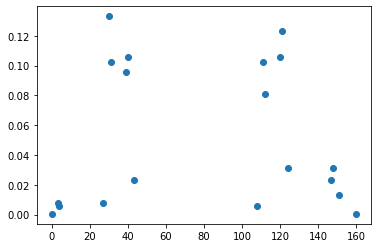

In [39]:
y = []
x = []
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])**2>=1e-4:
        y.append(np.abs(eigenvectors[:,0][i])**2) 
        x.append(i)
plt.plot(x,y, "o")

In [40]:
#initial state
string = ""
for i in range(L):
    string +="1"
psi_0 = np.zeros(basis.Ns)
i_0 = basis.index(string)
psi_0[i_0] = 1.

In [41]:
#cost function of the initial state
expt_value = 0
matvec_h = full_ham_matrix@psi_0
matvec_c = constraint_full_matrix@psi_0
for i in range(basis.Ns):
    expt_value += np.conj(psi_0[i])*(matvec_h[i]+matvec_c[i])
print(np.real(expt_value))

0.0


In [42]:
expt_value = 0
matvec = full_ham_matrix@psi_0
for i in range(basis.Ns):
    expt_value += np.conj(psi_0[i])*matvec[i]
print(expt_value)

0j


In [43]:
def rot_sigma(k,i,j,phi,theta):
    if k>=L:
        print("Warning! Rotations apply to k<=L-1!")
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    rot_matrix = expm(-1j*theta*sigma/2)
    if k==0:
        tensprod = rot_matrix
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod

def rot_ms(k,i,j,phi,theta):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    power_matrix = scipy.sparse.kron(sigma,sparse.identity(2*l+1))+scipy.sparse.kron(sparse.identity(2*l+1),sigma)
    rot_matrix = scipy.sparse.linalg.expm(-1j*power_matrix@power_matrix*theta/4)
    if k == 0:
        tensprod = rot_matrix
        for i in range(L-2):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+2,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod

def rot_ms_e(i,j,phi,theta):
    ms_e = sparse.identity(basis.Ns,dtype = complex)
    for k in range(1,int(L/2)):
        ms_e = rot_ms(2*k,i,j,phi,theta)@ms_e
    return(ms_e)

def rot_ms_o(i,j,phi,theta):
    ms_o = sparse.identity(basis.Ns,dtype = complex)
    for k in range(int(L/2)-1):
        ms_o = rot_ms(2*k+1,i,j,phi,theta)@ms_o
    return(ms_o)

def rot_sigma_e(i,j,phi,theta):
    sigma_e = sparse.identity(basis.Ns,dtype = complex)
    for k in range(1,int(L/2)):
        sigma_e = rot_sigma(2*k,i,j,phi,theta)@sigma_e
    return(sigma_e)

def rot_sigma_o(i,j,phi,theta):
    sigma_o = sparse.identity(basis.Ns,dtype = complex)
    for k in range(int(L/2)):
        sigma_o = rot_sigma(2*k+1,i,j,phi,theta)@sigma_o
    return(sigma_o)

def rot_sigma_all(i,j,phi,theta):
    sigma_all = sparse.identity(basis.Ns,dtype = complex)
    for k in range(L):
        sigma_all = rot_sigma(k,i,j,phi,theta)@sigma_all
    return(sigma_all)

In [44]:

def ms_hamiltonian(i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    sigma_big = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]
    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for k in range(L):
        if k == 0:
            tensprod = sigma
            for m in range(L-1):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        else:
            tensprod = sparse.identity(2*l+1)
            for i in range(1,k):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = scipy.sparse.kron(tensprod,sigma)
            for i in range(k+1,L):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        sigma_big[k] = tensprod
    for k in range(L):
        for kk in range(k,L):
            summe += 1./(1+(k-kk)**2)*(sigma_big[k]+sigma_big[kk])@(sigma_big[k]+sigma_big[kk])
    return summe
                
matrix_part = ms_hamiltonian(1,2,0)
ms_ham_eigenval, ms_ham_eigenvec = scipy.linalg.eigh(matrix_part)




def ms_gate_global(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval[i]*theta/4)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec@exponential@ms_ham_eigenvec.T.conj()

    

In [45]:
import datetime
print(datetime.datetime.now())
a = ms_gate_global(np.pi)
print(datetime.datetime.now())
b = rot_sigma_e(0,1,0,np.pi)
print(datetime.datetime.now())
a@b
print(datetime.datetime.now())

2022-05-12 16:26:33.581055
2022-05-12 16:26:33.584091
2022-05-12 16:26:33.591363
2022-05-12 16:26:33.592417


In [46]:

def sigma_sigma(m,n,theta):
    sigma_sigma = sparse.lil_matrix((basis.Ns,basis.Ns),dtype = complex)
    temp1 = np.cos(theta/2)
    temp2 = -1j*np.sin(theta/2)
    for i in range(basis.Ns):
        sigma_sigma[i,i] = 1.
        if (basis.int_to_state(basis.Ns-i-1)[2*m+1] == "1") & ((basis.int_to_state(basis.Ns-i-1)[2*n+1] == "1")):
            
            string = list(basis.int_to_state(basis.Ns-i-1))
            string[2*m+1],string[2*n+1] = "2","2"
            string = "".join(string)
            string = string.replace(" ", "")
            string = string.replace("|","")
            string = string.replace(">", "")
            sigma_sigma[i,i] = temp1
            sigma_sigma[basis.Ns-1-basis.state_to_int(string),i]  = temp2

        if (basis.int_to_state(basis.Ns-i-1)[2*m+1] == "1") & ((basis.int_to_state(basis.Ns-i-1)[2*n+1] == "2")):
            string = list(basis.int_to_state(basis.Ns-i-1))
            string[2*m+1],string[2*n+1] = "2","1"
            string = "".join(string)
            string = string.replace(" ", "")
            string = string.replace("|","")
            string = string.replace(">", "")
            sigma_sigma[i,i] = temp1
            sigma_sigma[basis.Ns-1-basis.state_to_int(string),i]  = temp2


        if (basis.int_to_state(basis.Ns-i-1)[2*m+1] == "2") & ((basis.int_to_state(basis.Ns-i-1)[2*n+1] == "1")):
            string = list(basis.int_to_state(basis.Ns-i-1))
            string[2*m+1],string[2*n+1] = "1","2"
            string = "".join(string)
            string = string.replace(" ", "")
            string = string.replace("|","")
            string = string.replace(">", "")
            sigma_sigma[i,i] = temp1
            sigma_sigma[basis.Ns-1-basis.state_to_int(string),i]  = temp2


        if (basis.int_to_state(basis.Ns-i-1)[2*m+1] == "2") & ((basis.int_to_state(basis.Ns-i-1)[2*n+1] == "2")):
            string = list(basis.int_to_state(basis.Ns-i-1))
            string[2*m+1],string[2*n+1] = "1","1"
            string = "".join(string)
            string = string.replace(" ", "")
            string = string.replace("|","")
            string = string.replace(">", "")
            sigma_sigma[i,i] = temp1
            sigma_sigma[basis.Ns-1-basis.state_to_int(string),i]  = temp2

            
    return sigma_sigma

def id_id(m,theta):
    id_id = sparse.lil_matrix((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        id_id[i,i] = 1.
        
        if (basis.int_to_state(basis.Ns-i-1)[2*m+1] == "1"):
            id_id[i,i] = (np.cos(theta/4)-1j*np.sin(theta/4))
            
        if (basis.int_to_state(basis.Ns-i-1)[2*m+1] == "2"):
            id_id[i,i] = (np.cos(theta/4)-1j*np.sin(theta/4)) 
            
    return id_id


def ms_global_sparse(theta):
    ms_global = sparse.identity(basis.Ns)
    for m in range(L):
        ms_global = id_id(m,theta)@ms_global
        for n in range(m+1,L):
            ms_global = sigma_sigma(m,n,theta)@ms_global
    return ms_global

#print(np.allclose(ms_global_sparse(np.pi/4).toarray(),ms_gate_global(np.pi/4), atol= 1e-3,rtol=1e-3))
#print(np.allclose(ms_global_sparse(np.pi/3).toarray().conj().T@ms_global_sparse(np.pi/3).toarray(),np.identity(basis.Ns), atol= 1e-8,rtol=1e-8))

%time sigma_sigma(0,1,np.pi/3)

CPU times: user 28.7 ms, sys: 10 µs, total: 28.7 ms
Wall time: 27 ms


<243x243 sparse matrix of type '<class 'numpy.complex128'>'
	with 351 stored elements in List of Lists format>

In [47]:
#import timeit
#print(timeit.timeit('[ms_gate_global(0,2,np.pi)]', globals=globals()))
import datetime
print(datetime.datetime.now())
a = ms_gate_global(np.pi)
print(datetime.datetime.now())
print(np.size(a))


2022-05-12 16:26:34.075446
2022-05-12 16:26:34.085761
59049


In [48]:
def cost_function_sigma(theta):
    psi_var = psi_0
    for i in range(N):
        psi_var = ms_gate_global(theta[5*i+0])@psi_var
        psi_var = rot_sigma_e(0,2,0,theta[5*i+2])@rot_sigma_e(0,1,0,theta[5*i+1])@psi_var
        psi_var = rot_sigma_o(0,2,0,theta[5*i+4])@rot_sigma_o(0,1,0,theta[5*i+3])@psi_var
        psi_var = rot_sigma(0,0,2,0,theta[5*i+2])@rot_sigma(0,0,1,0,theta[5*i+1])@psi_var
        psi_var = rot_sigma(L-1,0,2,0,theta[5*i+2])@rot_sigma(L-1,0,1,0,theta[5*i+1])@psi_var

    cost = np.conj(psi_var)@constrained_full_ham_matrix@psi_var
    return np.real(cost)

import datetime

print(datetime.datetime.now())
a = cost_function_sigma(np.pi*np.ones(5*N))
print(datetime.datetime.now())

2022-05-12 16:26:34.303297
2022-05-12 16:26:34.473693


In [49]:
opt_params = []
function_values = []
def callback_function(x,fun,context):
    opt_params.append(x)
    function_values.append(fun)


In [50]:
full_ham_matrix = sparse.csc_matrix(full_ham_matrix)

In [51]:
Energy = np.zeros(5)
Fidelity = np.zeros(5)

In [55]:
import optuna
n_iter = 3500
theta = np.zeros(5*N)

trials = []
iterations = []
energies = []


#cost function definition
def cost_function_sigma(trial):
    psi_var = psi_0
    for i in range(N):
        theta[5*i+0] = trial.suggest_float("5*"+str(i)+"+0", -3*np.pi, 3*np.pi)
        theta[5*i+1] = trial.suggest_float("5*"+str(i)+"+1", -3*np.pi, 3*np.pi)
        theta[5*i+2] = trial.suggest_float("5*"+str(i)+"+2", -3*np.pi, 3*np.pi)
        theta[5*i+3] = trial.suggest_float("5*"+str(i)+"+3", -3*np.pi, 3*np.pi)
        theta[5*i+4] = trial.suggest_float("5*"+str(i)+"+4", -3*np.pi, 3*np.pi)


        psi_var = ms_gate_global(theta[5*i+0])@psi_var
        psi_var = rot_sigma_e(0,2,0,theta[5*i+2])@rot_sigma_e(0,1,0,theta[5*i+1])@psi_var
        psi_var = rot_sigma_o(0,2,0,theta[5*i+4])@rot_sigma_o(0,1,0,theta[5*i+3])@psi_var
        psi_var = rot_sigma(0,0,2,0,theta[5*i+2])@rot_sigma(0,0,1,0,theta[5*i+1])@psi_var
        psi_var = rot_sigma(L-1,0,2,0,theta[5*i+2])@rot_sigma(L-1,0,1,0,theta[5*i+1])@psi_var

    cost = np.conj(psi_var)@constrained_full_ham_matrix@psi_var
    return np.real(cost)

for i in range(1):

    sampler = optuna.samplers.CmaEsSampler()
    study = optuna.create_study(sampler=sampler)
    study.optimize(cost_function_sigma, n_trials=n_iter)

    trials.append(study.trials_dataframe())    
    iterations.append(trials[i].loc[:,"number"].to_numpy())
    energies.append(trials[i].loc[:,"value"].to_numpy())

    theta = np.zeros(5*N)
    i=0
    for value in study.best_trial.params.items():
        theta[i] = value[1]
        i+=1

    psi_var = psi_0
    for i in range(N):

        psi_var = ms_gate_global(theta[5*i+0])@psi_var
        psi_var = rot_sigma_e(0,2,0,theta[5*i+2])@rot_sigma_e(0,1,0,theta[5*i+1])@psi_var
        psi_var = rot_sigma_o(0,2,0,theta[5*i+4])@rot_sigma_o(0,1,0,theta[5*i+3])@psi_var
        psi_var = rot_sigma(0,0,2,0,theta[5*i+2])@rot_sigma(0,0,1,0,theta[5*i+1])@psi_var
        psi_var = rot_sigma(L-1,0,2,0,theta[5*i+2])@rot_sigma(L-1,0,1,0,theta[5*i+1])@psi_var
    


    #f = open("M=0.1,L=3.txt", "a")
    #f.write(str(N)+" "+" "+str(np.abs(np.dot(np.conj(psi_var),eigenvectors[:,0]))**2)+" "+str(np.real(np.conj(psi_var)@full_ham_matrix@psi_var))+"\n")
    #f.close()

[I 2022-05-12 17:02:48,343] A new study created in memory with name: no-name-d2e74e78-b219-4c17-a5f3-afdad4e8e98f
[I 2022-05-12 17:02:48,551] Trial 0 finished with value: 6.045496141786358 and parameters: {'5*0+0': 8.451768520507184, '5*0+1': -9.202866252349786, '5*0+2': -7.496217608921624, '5*0+3': 4.776478137675296, '5*0+4': -0.29867971584954844, '5*1+0': -4.416242008820118, '5*1+1': 4.091311224340753, '5*1+2': 4.7888971762042445, '5*1+3': -1.4553018445201866, '5*1+4': -2.844753247005105, '5*2+0': 2.333131365673667, '5*2+1': -0.984761199387302, '5*2+2': 6.881942084349848, '5*2+3': -3.6394733110934085, '5*2+4': -1.4429015380665318, '5*3+0': 1.0455013160755833, '5*3+1': -5.338836910095423, '5*3+2': 4.861531160986534, '5*3+3': -4.904047779291406, '5*3+4': -3.5159355760652833}. Best is trial 0 with value: 6.045496141786358.
[I 2022-05-12 17:02:48,742] Trial 1 finished with value: 0.4943510571385691 and parameters: {'5*0+0': -2.0614252701587663, '5*0+1': 4.137674262878845, '5*0+2': -3.162

[I 2022-05-12 17:02:50,347] Trial 11 finished with value: 7.720042339516342 and parameters: {'5*0+0': -4.402319430017162, '5*0+1': 4.007432093370758, '5*0+2': -0.11588865820801317, '5*0+3': 0.24488381877765006, '5*0+4': -2.505270442455614, '5*1+0': 1.844168696428796, '5*1+1': 1.8114040180053836, '5*1+2': -1.0480565735725706, '5*1+3': 2.9940575852376883, '5*1+4': 2.2509521964181642, '5*2+0': -3.9379286431238816, '5*2+1': 3.190355635165396, '5*2+2': 3.156977434078496, '5*2+3': 5.591224841870834, '5*2+4': 0.36675236492127405, '5*3+0': 2.9868971627595844, '5*3+1': 0.48336815835019487, '5*3+2': 5.41289441820872, '5*3+3': 1.7684342838880895, '5*3+4': 5.046458079642059}. Best is trial 9 with value: -0.1507137163903816.
[I 2022-05-12 17:02:50,508] Trial 12 finished with value: 3.3394246043644675 and parameters: {'5*0+0': 3.1053244436262437, '5*0+1': -6.678367657257277, '5*0+2': -0.5181823895883, '5*0+3': -0.020271231681438108, '5*0+4': -2.2806586516599436, '5*1+0': 4.82312620097698, '5*1+1': 2

[I 2022-05-12 17:02:52,237] Trial 23 finished with value: 9.412485267741001 and parameters: {'5*0+0': -0.6987851884640123, '5*0+1': 3.0196591862146973, '5*0+2': 2.2374854943795075, '5*0+3': 8.127505755476855, '5*0+4': 2.619987277641735, '5*1+0': 4.497214054521075, '5*1+1': -3.9083028857358166, '5*1+2': 2.1728798255485624, '5*1+3': 2.862954957843646, '5*1+4': -3.625771631941816, '5*2+0': -1.0591485148409845, '5*2+1': 2.04670784109542, '5*2+2': 1.5120651848404636, '5*2+3': -2.405298942446713, '5*2+4': -1.7728762385374957, '5*3+0': 3.886721736999103, '5*3+1': -4.571241212189657, '5*3+2': -1.6678035286185586, '5*3+3': 2.5708698973963684, '5*3+4': -1.8094661055156398}. Best is trial 9 with value: -0.1507137163903816.
[I 2022-05-12 17:02:52,386] Trial 24 finished with value: 3.674967254779373 and parameters: {'5*0+0': -2.3593809619820973, '5*0+1': 5.131859408761949, '5*0+2': -3.054144569050762, '5*0+3': 1.6065444494810845, '5*0+4': -2.230371281609518, '5*1+0': 4.2862735173644335, '5*1+1': -0

[I 2022-05-12 17:02:54,216] Trial 35 finished with value: 3.815832953814266 and parameters: {'5*0+0': -1.8927237968230477, '5*0+1': -0.020958007560578862, '5*0+2': 5.210627169245308, '5*0+3': -1.0972981439473588, '5*0+4': -0.011681679461255756, '5*1+0': -3.1910271768435776, '5*1+1': -0.26199651302971505, '5*1+2': 2.838765316726403, '5*1+3': 3.81035586531549, '5*1+4': 0.27212008281346467, '5*2+0': -6.452651840536653, '5*2+1': -1.1079495331009217, '5*2+2': 0.8788302725546977, '5*2+3': -5.315648362088357, '5*2+4': -1.3064409890932247, '5*3+0': 5.19071904504407, '5*3+1': -3.32630248680821, '5*3+2': 2.375160677839809, '5*3+3': -1.6723407826194396, '5*3+4': -4.36474034568187}. Best is trial 9 with value: -0.1507137163903816.
[I 2022-05-12 17:02:54,366] Trial 36 finished with value: 4.776973502426593 and parameters: {'5*0+0': -2.3703327326928187, '5*0+1': -1.0032004170813957, '5*0+2': 6.775671283695347, '5*0+3': -0.73746138252503, '5*0+4': 3.213217366770434, '5*1+0': -1.627177153322397, '5*1+

[I 2022-05-12 17:02:56,168] Trial 47 finished with value: 3.5565243624111442 and parameters: {'5*0+0': -0.34390798790124677, '5*0+1': 2.985108047406877, '5*0+2': 2.591705907124246, '5*0+3': -6.500801793270181, '5*0+4': -2.24352401483427, '5*1+0': 0.4776278047218335, '5*1+1': -1.0388627518590283, '5*1+2': 2.167976539492696, '5*1+3': 8.106839562810478, '5*1+4': -0.7362736849299436, '5*2+0': -3.8648584472814353, '5*2+1': -3.213353630012772, '5*2+2': -0.1700838643724208, '5*2+3': -6.3796355820292, '5*2+4': 1.9368658550381006, '5*3+0': 3.3881769887982305, '5*3+1': -9.15393892602363, '5*3+2': 2.842042307641354, '5*3+3': -3.6261980417617234, '5*3+4': 3.9612242765961847}. Best is trial 9 with value: -0.1507137163903816.
[I 2022-05-12 17:02:56,326] Trial 48 finished with value: -0.3231945992460842 and parameters: {'5*0+0': 0.6758599616108039, '5*0+1': 5.98263218577071, '5*0+2': 6.683476933247789, '5*0+3': -4.1284427119407825, '5*0+4': -1.2268001071066374, '5*1+0': 2.146507932485682, '5*1+1': 0.

[I 2022-05-12 17:02:58,118] Trial 59 finished with value: 2.4834561493408307 and parameters: {'5*0+0': -3.6344197867453385, '5*0+1': 2.284025841743704, '5*0+2': 5.6992526219407935, '5*0+3': 3.780161906276061, '5*0+4': 3.1903483054894806, '5*1+0': -2.2696230483451667, '5*1+1': -3.9559261825128527, '5*1+2': 3.911011285532161, '5*1+3': 8.11571449528491, '5*1+4': -3.566830492019057, '5*2+0': -1.3984376134086398, '5*2+1': 0.8689010738640901, '5*2+2': 6.2336714589308135, '5*2+3': -1.7712049751994656, '5*2+4': 1.4603874546867104, '5*3+0': 0.7309675993498732, '5*3+1': -4.5483051165064765, '5*3+2': 0.6952327256773734, '5*3+3': -2.2057807599452444, '5*3+4': -3.7145435959204893}. Best is trial 48 with value: -0.3231945992460842.
[I 2022-05-12 17:02:58,265] Trial 60 finished with value: 3.8327161685124693 and parameters: {'5*0+0': 3.6076539980526325, '5*0+1': 4.037664457704154, '5*0+2': 6.0039152657826005, '5*0+3': -0.6417495597779213, '5*0+4': -0.0029412892715499073, '5*1+0': -2.091124878534832, 

[I 2022-05-12 17:03:00,006] Trial 71 finished with value: 2.342243132744936 and parameters: {'5*0+0': 0.9627509009601004, '5*0+1': 2.453811484679724, '5*0+2': 8.277717942272245, '5*0+3': -4.6800155150105756, '5*0+4': -1.948929447521465, '5*1+0': -2.666442385874923, '5*1+1': 0.7931750584214319, '5*1+2': 0.7492935465284281, '5*1+3': 6.818277951455357, '5*1+4': -5.8505378377407515, '5*2+0': 0.027887080202332326, '5*2+1': 0.639008600067243, '5*2+2': 4.21311913748113, '5*2+3': 1.0030835822519926, '5*2+4': 6.507262590607191, '5*3+0': 4.993420520713026, '5*3+1': -2.0674462938024636, '5*3+2': -1.7027380080665875, '5*3+3': -6.3513977539904545, '5*3+4': -0.38746272108988866}. Best is trial 48 with value: -0.3231945992460842.
[I 2022-05-12 17:03:00,162] Trial 72 finished with value: 2.3554192336488544 and parameters: {'5*0+0': -1.717601869626105, '5*0+1': 4.0840003007594, '5*0+2': 5.400485722641862, '5*0+3': -3.4520784522481236, '5*0+4': -0.5377285925704612, '5*1+0': -1.7572977173472806, '5*1+1':

[I 2022-05-12 17:03:01,869] Trial 83 finished with value: 15.388054704059837 and parameters: {'5*0+0': 0.8353018666764105, '5*0+1': -0.4255557163819539, '5*0+2': 5.703363521663826, '5*0+3': -3.678436011162315, '5*0+4': -6.6096005947115, '5*1+0': 1.4459666893728542, '5*1+1': -5.430345644135883, '5*1+2': 1.3922108593824347, '5*1+3': 8.311129108430684, '5*1+4': -3.7323398959013754, '5*2+0': -2.6817205883112334, '5*2+1': 1.3291059130690974, '5*2+2': 4.677786902171157, '5*2+3': -1.055697013429051, '5*2+4': 6.041041309733939, '5*3+0': -1.2791799309140837, '5*3+1': -3.9863120870934057, '5*3+2': -5.641696150254737, '5*3+3': -5.3010861897689665, '5*3+4': -0.2726100801194109}. Best is trial 48 with value: -0.3231945992460842.
[I 2022-05-12 17:03:02,021] Trial 84 finished with value: 11.160140668109587 and parameters: {'5*0+0': 3.915936098112818, '5*0+1': 4.716832761945553, '5*0+2': 6.343654474618765, '5*0+3': -1.2029029795376618, '5*0+4': -3.1046431983707063, '5*1+0': -3.5304982693275417, '5*1+1

[I 2022-05-12 17:03:03,766] Trial 95 finished with value: 9.630481632189301 and parameters: {'5*0+0': -4.366406473310334, '5*0+1': 8.818544123300107, '5*0+2': 8.803860115128675, '5*0+3': -2.2284684774952415, '5*0+4': -0.13509986211542446, '5*1+0': -1.6578997799416104, '5*1+1': -2.189542623438525, '5*1+2': 1.3839199839460898, '5*1+3': 1.101247514260902, '5*1+4': -8.067408742705366, '5*2+0': -0.6161879466695876, '5*2+1': -2.4304429158713936, '5*2+2': 2.5860065016136393, '5*2+3': 4.417230557569823, '5*2+4': 5.2594947719770495, '5*3+0': -4.703770428585717, '5*3+1': -6.462911955212753, '5*3+2': -5.067090253567917, '5*3+3': -7.041941488016594, '5*3+4': -2.88621989785572}. Best is trial 48 with value: -0.3231945992460842.
[I 2022-05-12 17:03:03,946] Trial 96 finished with value: 3.601758239182402 and parameters: {'5*0+0': 1.4807225923216745, '5*0+1': 2.9320544786526734, '5*0+2': 5.758026139897059, '5*0+3': -4.82992386266008, '5*0+4': 2.3948231081516917, '5*1+0': -5.319075049614002, '5*1+1': -

[I 2022-05-12 17:03:05,749] Trial 107 finished with value: 3.5865906134267513 and parameters: {'5*0+0': -0.3122938081434403, '5*0+1': 1.874112701962635, '5*0+2': 3.3958995033749972, '5*0+3': -1.083814172892462, '5*0+4': -1.5670758185757154, '5*1+0': -0.6668150482608262, '5*1+1': -2.3234692936345906, '5*1+2': 4.385921444278625, '5*1+3': 0.8859687169858834, '5*1+4': -5.561155423328251, '5*2+0': -2.663203587754327, '5*2+1': -4.716392345438464, '5*2+2': 1.6424813813130377, '5*2+3': -0.8115761397462868, '5*2+4': 8.454341337213014, '5*3+0': -2.711310777580398, '5*3+1': -2.8599081378701396, '5*3+2': 0.3702346869779205, '5*3+3': -2.460684461875825, '5*3+4': -7.31969427967239}. Best is trial 48 with value: -0.3231945992460842.
[I 2022-05-12 17:03:05,898] Trial 108 finished with value: 9.550562009755145 and parameters: {'5*0+0': -4.5217433387778625, '5*0+1': 4.409799137374685, '5*0+2': 5.915321849631713, '5*0+3': -0.508959883109354, '5*0+4': 1.919968212022185, '5*1+0': -5.46969765259919, '5*1+1'

[I 2022-05-12 17:03:07,566] Trial 119 finished with value: 2.9771496997459543 and parameters: {'5*0+0': -2.3315028814997683, '5*0+1': 1.4125126042710772, '5*0+2': 4.674483307438469, '5*0+3': -0.3123776016607463, '5*0+4': 0.3482877439186016, '5*1+0': 5.415557576765719, '5*1+1': 1.7136618100396888, '5*1+2': 1.0272894422730299, '5*1+3': 4.334746121895749, '5*1+4': 0.44739467983798953, '5*2+0': -4.4284207380185885, '5*2+1': -2.484453037807101, '5*2+2': 1.4459975729076606, '5*2+3': 1.5352340688111095, '5*2+4': 4.986922479935924, '5*3+0': -0.050086639675398725, '5*3+1': -0.732227108789909, '5*3+2': -3.450513122587301, '5*3+3': -7.253233314475661, '5*3+4': -9.265781988424084}. Best is trial 48 with value: -0.3231945992460842.
[I 2022-05-12 17:03:07,721] Trial 120 finished with value: 4.88014505300381 and parameters: {'5*0+0': -3.773201419274382, '5*0+1': 5.484194772842375, '5*0+2': 8.626882942998158, '5*0+3': -0.4089209716736372, '5*0+4': -3.7615482158587996, '5*1+0': -1.9846557346441607, '5*

[I 2022-05-12 17:03:09,433] Trial 131 finished with value: 3.8201417236264197 and parameters: {'5*0+0': -0.9559074834477244, '5*0+1': 6.039606179541149, '5*0+2': 2.1211853205669655, '5*0+3': 1.3637817338865494, '5*0+4': 0.4318939670665106, '5*1+0': 2.092540267274814, '5*1+1': -5.357213215383082, '5*1+2': 7.151027394525454, '5*1+3': 1.4020086452355847, '5*1+4': -4.011408605679395, '5*2+0': -5.656695118915791, '5*2+1': -1.4524680721845942, '5*2+2': -1.808995874306899, '5*2+3': -4.383591472040317, '5*2+4': 6.818874048352779, '5*3+0': -2.2804856886452636, '5*3+1': -4.009775133717128, '5*3+2': 1.3427263268251952, '5*3+3': -8.941664754704938, '5*3+4': -4.249126986262786}. Best is trial 48 with value: -0.3231945992460842.
[I 2022-05-12 17:03:09,586] Trial 132 finished with value: 3.0604527936697727 and parameters: {'5*0+0': -4.870883714029132, '5*0+1': 2.2477440719103052, '5*0+2': 3.4699457860958054, '5*0+3': 2.3548321754287884, '5*0+4': 2.66780831716081, '5*1+0': -3.9294083454866247, '5*1+1'

[I 2022-05-12 17:03:11,319] Trial 143 finished with value: 4.07843453466751 and parameters: {'5*0+0': -2.127141311609942, '5*0+1': 1.86676329358529, '5*0+2': 4.112914007077947, '5*0+3': 2.1972295088895004, '5*0+4': -0.4544133274329232, '5*1+0': -0.8762485707153232, '5*1+1': -0.5575621807511744, '5*1+2': 3.9389645546359926, '5*1+3': 1.4072215738995109, '5*1+4': -3.1716001069858115, '5*2+0': 0.7162664063145736, '5*2+1': 0.7533544817014859, '5*2+2': 0.40446379778533603, '5*2+3': 0.7239491759276093, '5*2+4': 1.1113905052489033, '5*3+0': -5.496746362537595, '5*3+1': -7.859899445885956, '5*3+2': -0.36206023051697667, '5*3+3': -5.90330754340828, '5*3+4': -3.52194260505609}. Best is trial 48 with value: -0.3231945992460842.
[I 2022-05-12 17:03:11,484] Trial 144 finished with value: 2.4364445580318224 and parameters: {'5*0+0': 0.5523371404892008, '5*0+1': 0.671945472851983, '5*0+2': 6.008467157088829, '5*0+3': 4.536451879080121, '5*0+4': -1.592357427966533, '5*1+0': -2.068195273808455, '5*1+1':

[I 2022-05-12 17:03:13,259] Trial 155 finished with value: 5.265946136269256 and parameters: {'5*0+0': -4.990257516574362, '5*0+1': -3.617005649391073, '5*0+2': 5.25142869494023, '5*0+3': 4.578111260362313, '5*0+4': -5.068257031308605, '5*1+0': 2.493702846595986, '5*1+1': 1.0538668811196628, '5*1+2': 5.130497287273588, '5*1+3': -2.2054289032418213, '5*1+4': -3.1761011127701675, '5*2+0': -4.277907747606273, '5*2+1': 1.5111872725630775, '5*2+2': 0.2162801497642286, '5*2+3': 1.0928077625596677, '5*2+4': 5.129904126551615, '5*3+0': -5.576604806448321, '5*3+1': -5.296359525943939, '5*3+2': -4.271007992632703, '5*3+3': -4.623854472438368, '5*3+4': -1.8163878860413378}. Best is trial 48 with value: -0.3231945992460842.
[I 2022-05-12 17:03:13,408] Trial 156 finished with value: 7.461491369581731 and parameters: {'5*0+0': -1.931150893005696, '5*0+1': -2.808813785072756, '5*0+2': 2.698589382992705, '5*0+3': 1.7906652869193367, '5*0+4': -5.024127303427573, '5*1+0': 1.6487326848737092, '5*1+1': 3.

[I 2022-05-12 17:03:15,099] Trial 167 finished with value: 1.196948844208184 and parameters: {'5*0+0': 0.3337697654059092, '5*0+1': 0.03032696244379693, '5*0+2': 6.431462875987241, '5*0+3': 4.2128378655056995, '5*0+4': 0.5384581864522084, '5*1+0': -1.3542930500266652, '5*1+1': 1.0913001531360984, '5*1+2': 7.145550983248965, '5*1+3': 8.36945556848778, '5*1+4': -5.593279539148197, '5*2+0': 0.9763024200182326, '5*2+1': -1.4997809335970302, '5*2+2': 3.1553653626299814, '5*2+3': 3.1719974887298426, '5*2+4': 7.898723543878395, '5*3+0': 2.3784049792365805, '5*3+1': -1.8227362444352706, '5*3+2': -7.797410291572552, '5*3+3': -7.685529575976639, '5*3+4': -7.297466123851028}. Best is trial 48 with value: -0.3231945992460842.
[I 2022-05-12 17:03:15,251] Trial 168 finished with value: 6.636323444675863 and parameters: {'5*0+0': -4.005617613502657, '5*0+1': 1.396622953260337, '5*0+2': 6.770518868596633, '5*0+3': 5.9715980140115, '5*0+4': -4.590389780683551, '5*1+0': -6.194144129200829, '5*1+1': -2.8

[I 2022-05-12 17:03:16,958] Trial 179 finished with value: 4.866784012800719 and parameters: {'5*0+0': -1.5159607757056168, '5*0+1': -0.8421302091469743, '5*0+2': 6.837441836860784, '5*0+3': 1.3570086090054014, '5*0+4': -0.6188696090241927, '5*1+0': -3.886164143424806, '5*1+1': 5.172749140306455, '5*1+2': 3.7689170718074, '5*1+3': 7.535510684045862, '5*1+4': -3.924355242524428, '5*2+0': 0.09782870857105319, '5*2+1': 4.361391381697392, '5*2+2': 0.7804662850676016, '5*2+3': 1.9750468700989405, '5*2+4': 8.881588578917139, '5*3+0': 0.5880867780256629, '5*3+1': 2.9050345420562826, '5*3+2': -5.9895421836756215, '5*3+3': -8.464849440331635, '5*3+4': -2.549514913577654}. Best is trial 48 with value: -0.3231945992460842.
[I 2022-05-12 17:03:17,112] Trial 180 finished with value: 3.473513261859274 and parameters: {'5*0+0': -3.3961391973368857, '5*0+1': -1.2324696199559473, '5*0+2': 7.113374404165592, '5*0+3': 4.147585780062368, '5*0+4': -4.66530771809117, '5*1+0': -5.210907655282911, '5*1+1': -0

[I 2022-05-12 17:03:18,824] Trial 191 finished with value: 5.133234432402338 and parameters: {'5*0+0': -0.844721841472343, '5*0+1': 0.5585375917161813, '5*0+2': 3.3418499343362926, '5*0+3': 2.222095568094318, '5*0+4': 2.0137311790819545, '5*1+0': -2.194045823955963, '5*1+1': 3.042068918631921, '5*1+2': 6.968805471872736, '5*1+3': 5.40486216771019, '5*1+4': -6.365883463691701, '5*2+0': -0.11792475420923998, '5*2+1': 0.424868353961929, '5*2+2': 0.40274699170961226, '5*2+3': 0.734149870217875, '5*2+4': 7.275324512376583, '5*3+0': -0.9733084983643954, '5*3+1': -5.2972259669815625, '5*3+2': -6.281741429728578, '5*3+3': -5.744198935020315, '5*3+4': 1.3717036062742185}. Best is trial 48 with value: -0.3231945992460842.
[I 2022-05-12 17:03:18,975] Trial 192 finished with value: 0.6174444116928465 and parameters: {'5*0+0': 1.9673454265318977, '5*0+1': 1.9426050368409726, '5*0+2': 3.42997908867937, '5*0+3': 3.6305705279702387, '5*0+4': 1.2939684628302808, '5*1+0': 0.836669735307948, '5*1+1': -1.

[I 2022-05-12 17:03:20,741] Trial 203 finished with value: 3.8948343399118617 and parameters: {'5*0+0': -1.049308807202296, '5*0+1': 0.9098368339389572, '5*0+2': 4.308670067682023, '5*0+3': 1.0297530235708874, '5*0+4': 0.4175948706910504, '5*1+0': 2.5263766688175995, '5*1+1': 1.9113034981834358, '5*1+2': -1.1101515130142823, '5*1+3': 6.267992927133361, '5*1+4': -6.2427565700025625, '5*2+0': 5.849955634669464, '5*2+1': -1.1368053960915425, '5*2+2': 3.247548551502538, '5*2+3': -0.42711391300117635, '5*2+4': 5.8906521546287784, '5*3+0': 3.0896841450941652, '5*3+1': -2.2679369797960467, '5*3+2': -5.0725245403304235, '5*3+3': -2.0471185921999133, '5*3+4': 1.8824609783369235}. Best is trial 48 with value: -0.3231945992460842.
[I 2022-05-12 17:03:20,893] Trial 204 finished with value: 1.4135660026550854 and parameters: {'5*0+0': -0.08935654769581194, '5*0+1': 1.632398536999917, '5*0+2': 7.176288957767412, '5*0+3': -0.6554595570987094, '5*0+4': 4.775259433132222, '5*1+0': -1.4687253258957929, 

[I 2022-05-12 17:03:22,576] Trial 215 finished with value: -0.5680978276588097 and parameters: {'5*0+0': -3.3425114432268095, '5*0+1': 2.182589953370996, '5*0+2': 7.335548280283122, '5*0+3': -1.2665111411113776, '5*0+4': -1.6523211364012396, '5*1+0': -2.2199134818023447, '5*1+1': 0.45724699047109485, '5*1+2': 1.7420314544328828, '5*1+3': 6.977656628367098, '5*1+4': -7.3403199948329485, '5*2+0': -0.1772785888109456, '5*2+1': 2.090394496906918, '5*2+2': 2.573517464092866, '5*2+3': 2.503805817417642, '5*2+4': 7.104893544804678, '5*3+0': 3.7648689543413365, '5*3+1': -3.3346661056841045, '5*3+2': -3.1610874156535713, '5*3+3': -8.378515737687303, '5*3+4': -1.033154690228137}. Best is trial 206 with value: -0.621122764576241.
[I 2022-05-12 17:03:22,732] Trial 216 finished with value: 10.852285934271329 and parameters: {'5*0+0': 3.5681506729079455, '5*0+1': 0.7884932653092419, '5*0+2': 8.35743214185336, '5*0+3': 3.3224586384397905, '5*0+4': -3.3462917954921605, '5*1+0': -0.17985948820052822, '

[I 2022-05-12 17:03:24,420] Trial 227 finished with value: 2.293767465764271 and parameters: {'5*0+0': 1.8373909628854352, '5*0+1': 1.3300149294347057, '5*0+2': 7.460977325474582, '5*0+3': 2.266102720624845, '5*0+4': 0.43734825330903626, '5*1+0': -4.553171221587469, '5*1+1': 0.40244615093574154, '5*1+2': 2.9236096541620453, '5*1+3': 6.115187585765814, '5*1+4': -7.035365644304141, '5*2+0': -1.8284405817798268, '5*2+1': -0.14018304765774126, '5*2+2': 2.450210923157679, '5*2+3': 2.7752456578896507, '5*2+4': 7.112822276137362, '5*3+0': 3.4959273792708743, '5*3+1': -6.312074592773543, '5*3+2': -6.9995368475979545, '5*3+3': -6.19101134239398, '5*3+4': -1.5086213327056592}. Best is trial 206 with value: -0.621122764576241.
[I 2022-05-12 17:03:24,585] Trial 228 finished with value: 7.089233764812279 and parameters: {'5*0+0': 0.5881807456314416, '5*0+1': 2.380221818965992, '5*0+2': 9.242548901879141, '5*0+3': -0.7097545343585644, '5*0+4': 1.2757898437849757, '5*1+0': -2.441407196932847, '5*1+1'

[I 2022-05-12 17:03:26,339] Trial 239 finished with value: 1.5409316594429172 and parameters: {'5*0+0': 0.7032165368598651, '5*0+1': 6.051349693221738, '5*0+2': 6.73405002680749, '5*0+3': 0.43917259752726967, '5*0+4': 2.214294999915344, '5*1+0': -1.6667134236266832, '5*1+1': -1.219701764817426, '5*1+2': 1.1389931731603817, '5*1+3': 5.222142518571004, '5*1+4': -5.669812557469928, '5*2+0': -1.1879466957553837, '5*2+1': 2.687748657168404, '5*2+2': 4.210542980570275, '5*2+3': 3.732921757469243, '5*2+4': 5.942247607964921, '5*3+0': 5.689553831539571, '5*3+1': -3.2676469478886756, '5*3+2': -6.689689343614818, '5*3+3': -7.941478303364445, '5*3+4': -1.0258101388474121}. Best is trial 206 with value: -0.621122764576241.
[I 2022-05-12 17:03:26,493] Trial 240 finished with value: 4.415878195365382 and parameters: {'5*0+0': -3.073660328601797, '5*0+1': 3.5510380084954125, '5*0+2': 8.089769108918794, '5*0+3': -1.591189471490313, '5*0+4': -0.5508262620287998, '5*1+0': -3.4695378175905853, '5*1+1': 0

[I 2022-05-12 17:03:28,174] Trial 251 finished with value: 1.3001990662153893 and parameters: {'5*0+0': -1.3580640966811464, '5*0+1': 3.92882611317655, '5*0+2': 7.438262958876665, '5*0+3': -1.9999115031557118, '5*0+4': -1.5345647894446328, '5*1+0': -2.262075351643725, '5*1+1': 1.15047412696944, '5*1+2': 1.8657017395523787, '5*1+3': 7.044391351394592, '5*1+4': -2.310071415114528, '5*2+0': 1.315385747537203, '5*2+1': 2.1716734689419552, '5*2+2': 7.0595690965321864, '5*2+3': 1.4925923329204367, '5*2+4': 2.648371873995903, '5*3+0': 4.163721124683763, '5*3+1': 0.8802673411607085, '5*3+2': -6.716106018555841, '5*3+3': -7.766426465427819, '5*3+4': 0.34807587360546477}. Best is trial 206 with value: -0.621122764576241.
[I 2022-05-12 17:03:28,327] Trial 252 finished with value: 0.40092206509994105 and parameters: {'5*0+0': -0.7789097651430357, '5*0+1': 4.720411434367868, '5*0+2': 7.294318935126007, '5*0+3': -2.8578390394263824, '5*0+4': -0.33880841775544546, '5*1+0': -0.9954009211622576, '5*1+1

[I 2022-05-12 17:03:30,023] Trial 263 finished with value: 2.1088289347747358 and parameters: {'5*0+0': 2.170343639609629, '5*0+1': 1.7382269645466693, '5*0+2': 7.117098033756856, '5*0+3': -0.4668551972739714, '5*0+4': -1.7660958304283463, '5*1+0': -3.3563069607008646, '5*1+1': 0.6200097355384413, '5*1+2': 0.8904174352646312, '5*1+3': 6.1583158476959, '5*1+4': -5.2022079427968455, '5*2+0': 4.744306964753043, '5*2+1': 3.3584615471582557, '5*2+2': 4.470227009854107, '5*2+3': -0.018771660127808953, '5*2+4': 6.128473329669979, '5*3+0': 0.4578042533634705, '5*3+1': -1.49742978643992, '5*3+2': -4.095542536067099, '5*3+3': -6.352268677409888, '5*3+4': -1.1112538712709337}. Best is trial 206 with value: -0.621122764576241.
[I 2022-05-12 17:03:30,176] Trial 264 finished with value: 3.7257408592247825 and parameters: {'5*0+0': -1.2217598963259226, '5*0+1': 6.022326929827544, '5*0+2': 6.742843475336039, '5*0+3': -0.08067210016538873, '5*0+4': -0.09635640779280386, '5*1+0': -5.731620053690533, '5*

[I 2022-05-12 17:03:31,882] Trial 275 finished with value: 1.4468351832443416 and parameters: {'5*0+0': -0.9376382315821268, '5*0+1': 3.155110694043798, '5*0+2': 3.3404465060625586, '5*0+3': -0.732221137399804, '5*0+4': -2.473517111352582, '5*1+0': -2.568139699134011, '5*1+1': -0.03002637149399473, '5*1+2': 2.1620058572725287, '5*1+3': 5.0879380682962845, '5*1+4': -5.899893028498354, '5*2+0': -0.3499742796606743, '5*2+1': -0.6287240207236366, '5*2+2': 5.134879310965269, '5*2+3': 0.36432157650362984, '5*2+4': 6.810289408016511, '5*3+0': -0.87951043706916, '5*3+1': -2.644689381303762, '5*3+2': -6.166431046386828, '5*3+3': -7.990493569117373, '5*3+4': 1.7615713007467941}. Best is trial 206 with value: -0.621122764576241.
[I 2022-05-12 17:03:32,031] Trial 276 finished with value: 6.850988894559703 and parameters: {'5*0+0': -0.38620291619774016, '5*0+1': 1.3256816853066389, '5*0+2': 2.0951426862769726, '5*0+3': -0.5872534321566779, '5*0+4': 0.9923779985660153, '5*1+0': -2.139200728626979, '

[I 2022-05-12 17:03:33,713] Trial 287 finished with value: 1.250154025205279 and parameters: {'5*0+0': -2.0603283991110737, '5*0+1': 3.5615200999634125, '5*0+2': 5.7748847531356615, '5*0+3': -2.6779512449842566, '5*0+4': 1.5685524881699222, '5*1+0': -3.167595088169659, '5*1+1': 2.2401249817123627, '5*1+2': 3.7824567211549076, '5*1+3': 9.183575236613592, '5*1+4': -4.96908922404276, '5*2+0': 0.983386670089407, '5*2+1': 1.0342749550967434, '5*2+2': 4.903844444635794, '5*2+3': 0.9660851055417623, '5*2+4': 6.663436402226878, '5*3+0': 2.205060433095566, '5*3+1': -5.825974871037857, '5*3+2': -7.77346429467349, '5*3+3': -4.282052732965015, '5*3+4': 0.37773214146175355}. Best is trial 206 with value: -0.621122764576241.
[I 2022-05-12 17:03:33,865] Trial 288 finished with value: 4.933803057989364 and parameters: {'5*0+0': 0.4788320862337353, '5*0+1': 4.089047888987003, '5*0+2': 4.518701524081948, '5*0+3': -1.940333804159996, '5*0+4': -0.942930098320964, '5*1+0': -3.8195481459964533, '5*1+1': 0.8

[I 2022-05-12 17:03:35,629] Trial 299 finished with value: 1.451723690374913 and parameters: {'5*0+0': -1.1259418862205437, '5*0+1': 3.651173041810175, '5*0+2': 6.598396601554524, '5*0+3': -1.4194997184324094, '5*0+4': -1.5077649065491183, '5*1+0': -3.5954005212797195, '5*1+1': 0.38308063849568774, '5*1+2': 4.120575380806164, '5*1+3': 8.28010149387784, '5*1+4': -5.807199943743872, '5*2+0': 2.5360678673374695, '5*2+1': 2.88712242143729, '5*2+2': 7.4779297438515115, '5*2+3': 0.6743353734979816, '5*2+4': 6.691341041679494, '5*3+0': 2.2239586243235125, '5*3+1': -4.877992013539709, '5*3+2': -6.226584334183485, '5*3+3': -9.039982000858636, '5*3+4': -0.5690213966355473}. Best is trial 296 with value: -0.7498889806263093.
[I 2022-05-12 17:03:35,788] Trial 300 finished with value: 2.0389522139661596 and parameters: {'5*0+0': -0.07442343670786711, '5*0+1': 2.2994542922962333, '5*0+2': 4.786214013823551, '5*0+3': -0.5480773234108205, '5*0+4': 0.7987494575081071, '5*1+0': -3.619471367594855, '5*1+

[I 2022-05-12 17:03:37,492] Trial 311 finished with value: 1.6229073351829735 and parameters: {'5*0+0': -0.7093551408881362, '5*0+1': 1.4960414311016081, '5*0+2': 1.9146775274607442, '5*0+3': -2.9938073420831244, '5*0+4': -0.6613984622044371, '5*1+0': -3.1179949344056084, '5*1+1': -0.6411782685833736, '5*1+2': 3.339526848791806, '5*1+3': 7.844455192549771, '5*1+4': -5.554311064559487, '5*2+0': 2.3324923891203344, '5*2+1': -0.36226681710758274, '5*2+2': 3.920739356663929, '5*2+3': 1.2909839614536958, '5*2+4': 5.460216844272269, '5*3+0': 1.5998251469132279, '5*3+1': -4.750383554561742, '5*3+2': -6.496508320182849, '5*3+3': -5.362439899047455, '5*3+4': 4.17532212463675}. Best is trial 296 with value: -0.7498889806263093.
[I 2022-05-12 17:03:37,646] Trial 312 finished with value: 2.123341602319499 and parameters: {'5*0+0': -1.0245283333107287, '5*0+1': 2.2479568485418886, '5*0+2': 3.6875569627967413, '5*0+3': -1.2679280081014874, '5*0+4': 3.2612102480056877, '5*1+0': -2.7750899861778646, '

[I 2022-05-12 17:03:39,417] Trial 323 finished with value: 1.5077666532922214 and parameters: {'5*0+0': -1.8690634609572143, '5*0+1': 2.1022439698270046, '5*0+2': 9.001094103082632, '5*0+3': -2.8019400674673554, '5*0+4': -0.8561851558560405, '5*1+0': -1.5202420000920447, '5*1+1': 0.19245238017438332, '5*1+2': 2.233879938396219, '5*1+3': 8.6273431889159, '5*1+4': -5.38397241360557, '5*2+0': 2.4890958771385523, '5*2+1': 0.8233394981140374, '5*2+2': 4.0661863478099125, '5*2+3': 4.257288158388344, '5*2+4': 7.183904167262386, '5*3+0': 5.5723239350786375, '5*3+1': -0.293148281025303, '5*3+2': -7.397879352649458, '5*3+3': -8.582725592147376, '5*3+4': 2.439238593823966}. Best is trial 296 with value: -0.7498889806263093.
[I 2022-05-12 17:03:39,574] Trial 324 finished with value: 0.8042907876855457 and parameters: {'5*0+0': -1.490473720566667, '5*0+1': 4.170847284645099, '5*0+2': 7.240652318756485, '5*0+3': -0.4597036236729919, '5*0+4': 1.4286139887298863, '5*1+0': 0.03987912938329852, '5*1+1':

[I 2022-05-12 17:03:41,272] Trial 335 finished with value: 0.7827942180684972 and parameters: {'5*0+0': -0.2539242332514082, '5*0+1': 4.802690659064509, '5*0+2': 7.607408645252719, '5*0+3': -2.4729544584735974, '5*0+4': 0.17777864871662008, '5*1+0': -2.6133256999462287, '5*1+1': 1.5821943870486264, '5*1+2': 2.9427042010347098, '5*1+3': 8.16777029187258, '5*1+4': -7.1068804659142915, '5*2+0': 1.3421471150841153, '5*2+1': 1.4963589809487425, '5*2+2': 9.20129370652644, '5*2+3': 1.2538589686715598, '5*2+4': 4.516012245292659, '5*3+0': -0.4464229609107373, '5*3+1': -2.3773482568380326, '5*3+2': -8.780151673398883, '5*3+3': -5.664771824565397, '5*3+4': 4.020285866974285}. Best is trial 296 with value: -0.7498889806263093.
[I 2022-05-12 17:03:41,428] Trial 336 finished with value: -0.6359992730021927 and parameters: {'5*0+0': -1.0619953231973573, '5*0+1': 1.2478308434400964, '5*0+2': 7.241434066416084, '5*0+3': -1.6725043193283546, '5*0+4': 0.5739875862551731, '5*1+0': -0.6046954486996035, '5

[I 2022-05-12 17:03:43,159] Trial 347 finished with value: 1.0116334129351945 and parameters: {'5*0+0': -1.8432499205517139, '5*0+1': 2.536770968170364, '5*0+2': 8.61290925044295, '5*0+3': -3.5515100495235035, '5*0+4': 0.5239112055238374, '5*1+0': 0.6965132613234251, '5*1+1': -1.6781639196224707, '5*1+2': 2.73279448152754, '5*1+3': 8.030698497104817, '5*1+4': -2.2125138599778276, '5*2+0': 1.728041334467973, '5*2+1': 1.373297035479386, '5*2+2': 4.626227695728286, '5*2+3': 0.657141214431666, '5*2+4': 6.559650828102486, '5*3+0': -0.9119591170938399, '5*3+1': -3.2616239419259974, '5*3+2': -7.334995502467624, '5*3+3': -5.301208076352783, '5*3+4': 5.513960327733454}. Best is trial 344 with value: -1.0559720016284277.
[I 2022-05-12 17:03:43,315] Trial 348 finished with value: 2.2042780296541773 and parameters: {'5*0+0': -1.7918420449691232, '5*0+1': 0.7611009642909641, '5*0+2': 6.57617573991545, '5*0+3': -1.5159372734023735, '5*0+4': 1.9218679437355672, '5*1+0': -3.9231423143825417, '5*1+1': 

[I 2022-05-12 17:03:45,056] Trial 359 finished with value: -0.4862208411320712 and parameters: {'5*0+0': -1.0755413935643463, '5*0+1': 1.0408842264058507, '5*0+2': 7.586909799360693, '5*0+3': -1.769521524168003, '5*0+4': 3.028504135561472, '5*1+0': -1.0250542383819643, '5*1+1': -1.4393515291703176, '5*1+2': 4.892186083505745, '5*1+3': 6.232861716451085, '5*1+4': -4.848668356504761, '5*2+0': -0.9095510847728883, '5*2+1': 0.9995871918343616, '5*2+2': 5.525238156850682, '5*2+3': 0.988803252086915, '5*2+4': 5.442111784262301, '5*3+0': 3.8678410033608035, '5*3+1': -2.853739407644805, '5*3+2': -7.379606328425948, '5*3+3': -6.156559622394908, '5*3+4': 3.5974963157943707}. Best is trial 344 with value: -1.0559720016284277.
[I 2022-05-12 17:03:45,244] Trial 360 finished with value: 0.3251321864731611 and parameters: {'5*0+0': -1.6100673964356735, '5*0+1': 2.97405531833824, '5*0+2': 9.153893240699185, '5*0+3': -3.238202422185635, '5*0+4': 1.7949683632030158, '5*1+0': 0.37903955677297807, '5*1+1'

[I 2022-05-12 17:03:46,942] Trial 371 finished with value: 0.4859138367485736 and parameters: {'5*0+0': -1.9154387921522351, '5*0+1': 0.7015484049567592, '5*0+2': 7.655186528508904, '5*0+3': -4.678329589388321, '5*0+4': 1.9490221722276448, '5*1+0': 0.2505663690756581, '5*1+1': -1.3855161555752173, '5*1+2': 2.5862142506585952, '5*1+3': 8.268077841259801, '5*1+4': -5.046615461846084, '5*2+0': 0.9125383064014191, '5*2+1': 2.4584427555845574, '5*2+2': 9.018245714050808, '5*2+3': 3.646123913735931, '5*2+4': 5.665079846578705, '5*3+0': 3.6516052505262073, '5*3+1': -5.904464368195441, '5*3+2': -5.593016987984111, '5*3+3': -6.996337734521806, '5*3+4': 4.478876102059834}. Best is trial 344 with value: -1.0559720016284277.
[I 2022-05-12 17:03:47,097] Trial 372 finished with value: 2.0598159904962006 and parameters: {'5*0+0': -1.1903355201906793, '5*0+1': 3.2925659065408004, '5*0+2': 6.407585469134206, '5*0+3': -4.174110559705886, '5*0+4': 2.8154489112099474, '5*1+0': -1.7110413492108285, '5*1+1'

[I 2022-05-12 17:03:48,837] Trial 383 finished with value: 2.291176739220939 and parameters: {'5*0+0': -0.17488098924279316, '5*0+1': 0.4551726936052307, '5*0+2': 8.670329013590267, '5*0+3': -4.967583790573751, '5*0+4': 5.188376770154474, '5*1+0': -2.862691746898317, '5*1+1': -1.3621039675814484, '5*1+2': 2.5800833681510094, '5*1+3': 7.587090775146802, '5*1+4': -5.082296981738237, '5*2+0': 0.2951824613450338, '5*2+1': 0.534569190500322, '5*2+2': 9.15209620289467, '5*2+3': 2.7678713289646533, '5*2+4': 7.240876149068838, '5*3+0': 4.362623612200343, '5*3+1': -4.290966951716185, '5*3+2': -6.011785248866391, '5*3+3': -8.335710721406041, '5*3+4': 3.0314769533852433}. Best is trial 344 with value: -1.0559720016284277.
[I 2022-05-12 17:03:48,993] Trial 384 finished with value: 3.220701349379358 and parameters: {'5*0+0': -1.2324560209733746, '5*0+1': 0.598961312074932, '5*0+2': 8.748095279001344, '5*0+3': -2.6107863714471313, '5*0+4': 0.9012381520368506, '5*1+0': -0.6865837629202984, '5*1+1': -

[I 2022-05-12 17:03:50,715] Trial 395 finished with value: -0.33695564232354286 and parameters: {'5*0+0': 2.296572569666094, '5*0+1': 1.4820041191221407, '5*0+2': 8.080476882781863, '5*0+3': -1.080210492543032, '5*0+4': -1.716711510718345, '5*1+0': 0.2254970303382453, '5*1+1': -0.19798033327105835, '5*1+2': 6.4005009765239045, '5*1+3': 6.9611421962143885, '5*1+4': -5.105502856068668, '5*2+0': 1.1704981097190938, '5*2+1': 0.7283134407058928, '5*2+2': 7.592844979948016, '5*2+3': 2.121108467610395, '5*2+4': 3.4537503320924197, '5*3+0': 3.292527961954457, '5*3+1': -2.6604013916124805, '5*3+2': -5.779602357906499, '5*3+3': -6.520267583091982, '5*3+4': 4.265766540286539}. Best is trial 344 with value: -1.0559720016284277.
[I 2022-05-12 17:03:50,870] Trial 396 finished with value: 5.199341469545667 and parameters: {'5*0+0': 0.19182539979888188, '5*0+1': -1.2693378581918213, '5*0+2': 7.142544082269224, '5*0+3': -1.8393590988514377, '5*0+4': 1.1595648307909858, '5*1+0': 1.5067163766050018, '5*1

[I 2022-05-12 17:03:52,598] Trial 407 finished with value: 2.4190336499516656 and parameters: {'5*0+0': -0.1442882331500993, '5*0+1': 1.0884569376950732, '5*0+2': 6.681875945456304, '5*0+3': -1.2672304933240128, '5*0+4': -0.9021462770325948, '5*1+0': 0.024636831106353285, '5*1+1': -1.023616201281877, '5*1+2': 5.184401832990227, '5*1+3': 6.9353767965018065, '5*1+4': -5.550597399327739, '5*2+0': -1.0159516845852277, '5*2+1': 0.010836710227154267, '5*2+2': 5.175211920661061, '5*2+3': 2.2693199535028876, '5*2+4': 4.568648212987628, '5*3+0': 4.443498262969835, '5*3+1': -2.428631817731607, '5*3+2': -3.6869793691730095, '5*3+3': -5.2302992120269955, '5*3+4': 3.633748129481649}. Best is trial 344 with value: -1.0559720016284277.
[I 2022-05-12 17:03:52,750] Trial 408 finished with value: 0.14051786465589133 and parameters: {'5*0+0': 1.104556041104236, '5*0+1': -0.8816866167601451, '5*0+2': 6.531526983334835, '5*0+3': -3.8440049901374604, '5*0+4': 0.5402991744440246, '5*1+0': 0.5807556166705521,

[I 2022-05-12 17:03:54,457] Trial 419 finished with value: 1.7411813037754151 and parameters: {'5*0+0': -0.31531517848669055, '5*0+1': 1.1239600411798711, '5*0+2': 6.494304378706767, '5*0+3': -2.1952690968163253, '5*0+4': 1.934640044092191, '5*1+0': 1.6468786492765568, '5*1+1': -0.9089575811241569, '5*1+2': 4.283367260109232, '5*1+3': 7.937715815667866, '5*1+4': -4.212153394945841, '5*2+0': -0.04723581693423293, '5*2+1': -0.5223391955744194, '5*2+2': 7.677460848660408, '5*2+3': -0.18994741996286169, '5*2+4': 2.4874099883125176, '5*3+0': 2.2503017453716847, '5*3+1': -3.6716831939502184, '5*3+2': -4.8492372010875355, '5*3+3': -5.270665410068082, '5*3+4': 6.313703113461546}. Best is trial 344 with value: -1.0559720016284277.
[I 2022-05-12 17:03:54,610] Trial 420 finished with value: 2.42477764165631 and parameters: {'5*0+0': 2.7374722673714094, '5*0+1': 0.13638423335221445, '5*0+2': 4.647389858087934, '5*0+3': -5.876773267776858, '5*0+4': -0.5262953079645063, '5*1+0': 0.5923278397782826, 

[I 2022-05-12 17:03:56,331] Trial 431 finished with value: 0.4822094314814547 and parameters: {'5*0+0': 0.3320288757594004, '5*0+1': 1.3096930938587805, '5*0+2': 7.282147899440042, '5*0+3': -2.048207439104464, '5*0+4': 1.7419472385597747, '5*1+0': 1.4141478357555406, '5*1+1': -2.131808032326685, '5*1+2': 2.105454669367384, '5*1+3': 7.82403757627833, '5*1+4': -3.282810177454767, '5*2+0': -1.2897742684304212, '5*2+1': 1.488371054395782, '5*2+2': 7.364552094171204, '5*2+3': 3.2951269454926435, '5*2+4': 3.972961709517702, '5*3+0': 2.2015342469494934, '5*3+1': -2.0426734459745317, '5*3+2': -7.979705213467968, '5*3+3': -8.59454630263533, '5*3+4': 2.804000949703774}. Best is trial 344 with value: -1.0559720016284277.
[I 2022-05-12 17:03:56,486] Trial 432 finished with value: 1.1235763559877852 and parameters: {'5*0+0': -1.514501528353132, '5*0+1': -0.6243010990395834, '5*0+2': 8.606532350603562, '5*0+3': -1.2764083631763903, '5*0+4': 1.7685655666452549, '5*1+0': 0.16683575711290266, '5*1+1': 

[I 2022-05-12 17:03:58,197] Trial 443 finished with value: 0.38579895458656654 and parameters: {'5*0+0': 0.13525301442227, '5*0+1': 0.1188316242130192, '5*0+2': 6.490735130975175, '5*0+3': -0.5340174070430102, '5*0+4': 2.3030692903740606, '5*1+0': 2.4360392089330487, '5*1+1': -2.410541114405685, '5*1+2': 3.033050903388204, '5*1+3': 8.451561373743933, '5*1+4': -3.5259788319102774, '5*2+0': 0.2758322558422721, '5*2+1': 0.630824033012189, '5*2+2': 8.299202474249656, '5*2+3': 3.1978143218389823, '5*2+4': 3.286342611575381, '5*3+0': 1.0524767339853065, '5*3+1': -3.308467384508735, '5*3+2': -5.72611776469912, '5*3+3': -7.627657840239283, '5*3+4': 2.3368301935242126}. Best is trial 344 with value: -1.0559720016284277.
[I 2022-05-12 17:03:58,355] Trial 444 finished with value: 1.633797371758912 and parameters: {'5*0+0': 0.9874346910040814, '5*0+1': -0.6793172156230644, '5*0+2': 6.975967741279603, '5*0+3': -2.1946554305761845, '5*0+4': 1.9697288728659128, '5*1+0': 1.1007209973943044, '5*1+1': -

[I 2022-05-12 17:04:00,089] Trial 455 finished with value: -0.09212980112142749 and parameters: {'5*0+0': 1.0125536049272887, '5*0+1': 0.4654768982283539, '5*0+2': 6.861984054549636, '5*0+3': -3.633679588465947, '5*0+4': 3.0327072115395914, '5*1+0': 2.894034586823881, '5*1+1': -1.3255183469420453, '5*1+2': 3.5036025111178932, '5*1+3': 7.1245857944223925, '5*1+4': -3.4882495727894947, '5*2+0': -1.3415639622630082, '5*2+1': 0.8388593460709736, '5*2+2': 7.072265514633284, '5*2+3': 2.8764848543258728, '5*2+4': 4.982814649517488, '5*3+0': 1.8092846412239352, '5*3+1': -2.8352235108506716, '5*3+2': -8.576390148859517, '5*3+3': -7.6181510189311235, '5*3+4': 3.4571628821707443}. Best is trial 344 with value: -1.0559720016284277.
[I 2022-05-12 17:04:00,245] Trial 456 finished with value: 2.0521259211512675 and parameters: {'5*0+0': 0.9447325405273878, '5*0+1': -1.4988859712097593, '5*0+2': 7.811121412257412, '5*0+3': -2.9854817053747835, '5*0+4': 0.23829670142493398, '5*1+0': 0.8617962873714906,

[I 2022-05-12 17:04:02,010] Trial 467 finished with value: 0.5805367328249972 and parameters: {'5*0+0': 1.632720067390343, '5*0+1': 2.561578973763226, '5*0+2': 7.782182368069745, '5*0+3': -1.4205546012935677, '5*0+4': -0.12124869841298969, '5*1+0': 2.5672941696267824, '5*1+1': -1.605763884120098, '5*1+2': 4.523369593357561, '5*1+3': 7.900721608401828, '5*1+4': -4.415431545577742, '5*2+0': -0.5103065758702481, '5*2+1': 0.5753365755994271, '5*2+2': 8.499605868269047, '5*2+3': 2.191596863244221, '5*2+4': 4.718944259047169, '5*3+0': 2.516691211648906, '5*3+1': -3.153323415408103, '5*3+2': -7.396478425291244, '5*3+3': -6.286843017510194, '5*3+4': 2.241517188749274}. Best is trial 344 with value: -1.0559720016284277.
[I 2022-05-12 17:04:02,161] Trial 468 finished with value: -0.4662515033449105 and parameters: {'5*0+0': -1.5248178664488095, '5*0+1': -0.06568819229723966, '5*0+2': 7.030707351660479, '5*0+3': -3.636236492655344, '5*0+4': 1.6715748415647453, '5*1+0': 1.6619257253299482, '5*1+1'

[I 2022-05-12 17:04:03,851] Trial 479 finished with value: 0.9018832451777223 and parameters: {'5*0+0': 0.6573505558310316, '5*0+1': -0.28835403433580187, '5*0+2': 7.20570216028211, '5*0+3': -2.026023248013462, '5*0+4': 1.7449981400915135, '5*1+0': 4.268652829069582, '5*1+1': -2.088554029526879, '5*1+2': 3.2022331257987338, '5*1+3': 8.600155909678067, '5*1+4': -3.7036503738331823, '5*2+0': -0.6804817171723834, '5*2+1': -0.5671314336461943, '5*2+2': 7.407816923684751, '5*2+3': 3.409444636354926, '5*2+4': 6.277274402671022, '5*3+0': 0.9365670365659788, '5*3+1': -4.084017002111406, '5*3+2': -5.919934693011896, '5*3+3': -6.693636097964245, '5*3+4': 2.6515894086632206}. Best is trial 344 with value: -1.0559720016284277.
[I 2022-05-12 17:04:04,005] Trial 480 finished with value: 2.135623931316401 and parameters: {'5*0+0': -0.6223009643161598, '5*0+1': 0.5292168938497185, '5*0+2': 6.027178314296812, '5*0+3': -1.9854983482572237, '5*0+4': 4.003504773585043, '5*1+0': 1.9300239124049503, '5*1+1'

[I 2022-05-12 17:04:05,692] Trial 491 finished with value: 1.0063987317215977 and parameters: {'5*0+0': -0.08502442315371389, '5*0+1': -0.5832393626654797, '5*0+2': 8.93631535799927, '5*0+3': -3.6027893886592297, '5*0+4': 0.7633159815547778, '5*1+0': 4.584399730107425, '5*1+1': -0.6710058698456833, '5*1+2': 4.120973158879708, '5*1+3': 9.047440441852409, '5*1+4': -5.308932115574603, '5*2+0': -2.596650712609048, '5*2+1': 0.4377013171387426, '5*2+2': 7.664027998905486, '5*2+3': 4.008536554491691, '5*2+4': 4.092680034078457, '5*3+0': 1.727663366153088, '5*3+1': -3.452385913910268, '5*3+2': -7.360835041507804, '5*3+3': -7.357231086168971, '5*3+4': 3.0593253352969563}. Best is trial 486 with value: -1.2282363196882042.
[I 2022-05-12 17:04:05,846] Trial 492 finished with value: 0.16696242723342786 and parameters: {'5*0+0': 0.8037074638065592, '5*0+1': -2.168481723234459, '5*0+2': 7.312201347931444, '5*0+3': -3.976520271136737, '5*0+4': 1.8835970937615005, '5*1+0': 3.977876252011261, '5*1+1': 

[I 2022-05-12 17:04:07,650] Trial 503 finished with value: -0.1821885441304355 and parameters: {'5*0+0': -0.08396176507944159, '5*0+1': -0.40476216225131223, '5*0+2': 5.753089044175656, '5*0+3': -4.683290183734508, '5*0+4': 0.9344087590075961, '5*1+0': 3.801579724904883, '5*1+1': -0.6259459633072673, '5*1+2': 3.8100851403690488, '5*1+3': 7.736950163055093, '5*1+4': -5.023239214921606, '5*2+0': -0.8798226584166402, '5*2+1': -1.4562946852101737, '5*2+2': 7.117814243515609, '5*2+3': 6.0866311925060055, '5*2+4': 3.8529001156705993, '5*3+0': -1.250148000148766, '5*3+1': -2.630938575850289, '5*3+2': -7.279869386435826, '5*3+3': -5.833459963074793, '5*3+4': 5.377147931506782}. Best is trial 486 with value: -1.2282363196882042.
[I 2022-05-12 17:04:07,804] Trial 504 finished with value: -0.9741386453519839 and parameters: {'5*0+0': 1.387467169628433, '5*0+1': -0.6399453253365641, '5*0+2': 8.427352082394972, '5*0+3': -5.4037032078587535, '5*0+4': -0.46538403716834886, '5*1+0': 2.110847587575596,

[I 2022-05-12 17:04:09,568] Trial 515 finished with value: 2.8537524968748977 and parameters: {'5*0+0': 0.33285930723113644, '5*0+1': -1.980617486814975, '5*0+2': 8.671286878850717, '5*0+3': -6.212657358245652, '5*0+4': 0.5508120804501442, '5*1+0': 1.2334537967360213, '5*1+1': -0.18682205617411785, '5*1+2': 2.7965623333637035, '5*1+3': 8.842045610912916, '5*1+4': -3.871916546625143, '5*2+0': 0.07500451678392084, '5*2+1': 1.164060529593421, '5*2+2': 6.5915434697329385, '5*2+3': 5.535719435567083, '5*2+4': 5.12282257714125, '5*3+0': 0.4824301643485188, '5*3+1': -3.0816512544372294, '5*3+2': -7.543376048713987, '5*3+3': -8.211800173145749, '5*3+4': 4.812268531067223}. Best is trial 486 with value: -1.2282363196882042.
[I 2022-05-12 17:04:09,723] Trial 516 finished with value: 2.3150857233710136 and parameters: {'5*0+0': 0.31819920057021234, '5*0+1': -0.844300366307633, '5*0+2': 8.237392198069617, '5*0+3': -5.2312114614772005, '5*0+4': -1.4870006471029296, '5*1+0': 1.064912618203115, '5*1+

[I 2022-05-12 17:04:11,440] Trial 527 finished with value: -0.03857518799583598 and parameters: {'5*0+0': -1.5902495121392382, '5*0+1': -0.541704471995534, '5*0+2': 7.771583235776989, '5*0+3': -6.182725245457888, '5*0+4': -1.7300548416050954, '5*1+0': 1.6242263198931148, '5*1+1': -1.4285343458600765, '5*1+2': 2.4195655874851627, '5*1+3': 8.249540000202968, '5*1+4': -7.221509453865086, '5*2+0': -1.0869974475800444, '5*2+1': -0.3807821821506515, '5*2+2': 7.48169585356792, '5*2+3': 5.804433577660091, '5*2+4': 1.6005026628622496, '5*3+0': -0.10878628052573688, '5*3+1': -3.5296519026812785, '5*3+2': -7.755204512333652, '5*3+3': -4.764736886386649, '5*3+4': 5.382490245294047}. Best is trial 486 with value: -1.2282363196882042.
[I 2022-05-12 17:04:11,608] Trial 528 finished with value: 2.4763415594009985 and parameters: {'5*0+0': -1.4574343087030632, '5*0+1': 0.8526129886849998, '5*0+2': 6.495086068134884, '5*0+3': -6.3426160653712085, '5*0+4': -0.9907059294278163, '5*1+0': 1.6787878621464223

[I 2022-05-12 17:04:13,496] Trial 539 finished with value: 1.5643693332467115 and parameters: {'5*0+0': -0.9401278440679816, '5*0+1': -2.538196422633005, '5*0+2': 7.810905317929925, '5*0+3': -5.633801969586623, '5*0+4': -1.6018144714044682, '5*1+0': -0.5550314708235209, '5*1+1': -2.6949489607707013, '5*1+2': 1.7829725608776505, '5*1+3': 8.16920787563573, '5*1+4': -4.987534880303781, '5*2+0': -0.564919141662613, '5*2+1': -1.8119956047990071, '5*2+2': 5.579569526108639, '5*2+3': 6.213691764884947, '5*2+4': 1.9763870876506802, '5*3+0': -0.7188085131118094, '5*3+1': -4.2710574163136625, '5*3+2': -7.4907155672410095, '5*3+3': -5.470514119373083, '5*3+4': 2.7560026911407642}. Best is trial 486 with value: -1.2282363196882042.
[I 2022-05-12 17:04:13,658] Trial 540 finished with value: 3.3481176971714426 and parameters: {'5*0+0': -0.8003163888093725, '5*0+1': -0.1144642565477183, '5*0+2': 7.107701946829663, '5*0+3': -5.878303678388308, '5*0+4': -0.7497760516043246, '5*1+0': 3.0538225983116147,

[I 2022-05-12 17:04:15,455] Trial 551 finished with value: 0.4252315253537234 and parameters: {'5*0+0': -1.3109605897043988, '5*0+1': 0.34449337754436393, '5*0+2': 7.203241956565087, '5*0+3': -4.258705517768209, '5*0+4': 0.806434707059221, '5*1+0': 0.2518238969971862, '5*1+1': -0.2869899748117337, '5*1+2': 5.55583051839811, '5*1+3': 8.689111697337186, '5*1+4': -4.295318358888063, '5*2+0': 0.6160931096575344, '5*2+1': -1.238230112395851, '5*2+2': 7.788098912394746, '5*2+3': 4.874228806605609, '5*2+4': 3.259582251118904, '5*3+0': -0.5080025426545864, '5*3+1': -3.9763301778957545, '5*3+2': -5.540020456069076, '5*3+3': -6.253000891138436, '5*3+4': 1.8807841255704496}. Best is trial 486 with value: -1.2282363196882042.
[I 2022-05-12 17:04:15,619] Trial 552 finished with value: 0.9965903518688426 and parameters: {'5*0+0': -0.22317739377080276, '5*0+1': -0.19614140191059581, '5*0+2': 8.118492928838132, '5*0+3': -4.262617514225669, '5*0+4': 1.7199017933659344, '5*1+0': 0.2715820628245036, '5*1

[I 2022-05-12 17:04:17,393] Trial 563 finished with value: 1.34052887360256 and parameters: {'5*0+0': -1.188430414973442, '5*0+1': 0.8821842577313741, '5*0+2': 5.7714480565947, '5*0+3': -2.1189462367829615, '5*0+4': -1.1408760395769568, '5*1+0': -0.7981945729041426, '5*1+1': -1.5793819727587677, '5*1+2': 3.762631158140009, '5*1+3': 7.4044030647460195, '5*1+4': -6.874007207882616, '5*2+0': -0.8800414762083546, '5*2+1': 0.027981047673451387, '5*2+2': 5.16901694275532, '5*2+3': 4.200296357488074, '5*2+4': 2.336986300556412, '5*3+0': 0.7345672679434264, '5*3+1': -3.967642335511659, '5*3+2': -6.92552862320356, '5*3+3': -7.285788651081631, '5*3+4': 3.954443623566949}. Best is trial 486 with value: -1.2282363196882042.
[I 2022-05-12 17:04:17,551] Trial 564 finished with value: 1.5337747533760715 and parameters: {'5*0+0': -1.339108002552301, '5*0+1': -0.3455182471139259, '5*0+2': 7.072811663221637, '5*0+3': -2.143691708136801, '5*0+4': -0.8740304715817936, '5*1+0': -1.2332041269280523, '5*1+1'

[I 2022-05-12 17:04:19,373] Trial 575 finished with value: 2.395390203848452 and parameters: {'5*0+0': -1.1006940703522723, '5*0+1': -2.4531384838860193, '5*0+2': 8.497983799634207, '5*0+3': -1.3168287809950827, '5*0+4': 0.6553712639180602, '5*1+0': 1.0937832170328616, '5*1+1': -3.9959164729978003, '5*1+2': 3.3103417585367776, '5*1+3': 8.173165035517412, '5*1+4': -4.918585490870935, '5*2+0': -0.04046190284423612, '5*2+1': -0.6857334824334322, '5*2+2': 6.384852326868505, '5*2+3': 3.9518897870678025, '5*2+4': 1.9471084672860903, '5*3+0': -1.5681485413176752, '5*3+1': -3.0283111001713747, '5*3+2': -6.276411374529889, '5*3+3': -8.559214067304252, '5*3+4': 1.4780945680739168}. Best is trial 486 with value: -1.2282363196882042.
[I 2022-05-12 17:04:19,537] Trial 576 finished with value: -1.036587588987283 and parameters: {'5*0+0': 0.7333686800349394, '5*0+1': -0.5494101058244856, '5*0+2': 8.281315177932338, '5*0+3': -4.023283343911938, '5*0+4': 0.08749558425562287, '5*1+0': 1.1626013734770824

[I 2022-05-12 17:04:21,271] Trial 587 finished with value: 0.1516977448285306 and parameters: {'5*0+0': -0.4794225004913063, '5*0+1': -1.0428762153452542, '5*0+2': 8.711460619434867, '5*0+3': -3.842303795351881, '5*0+4': 0.68705243967431, '5*1+0': 0.5118721583731051, '5*1+1': -2.069915844712028, '5*1+2': 3.611352300512901, '5*1+3': 7.969677304412625, '5*1+4': -6.545535748493439, '5*2+0': -2.921200145955071, '5*2+1': -1.1645873536746643, '5*2+2': 6.790868216432063, '5*2+3': 3.86328246209805, '5*2+4': 3.338993929253396, '5*3+0': 1.0073025844629189, '5*3+1': -3.7858329155423105, '5*3+2': -9.349671950178214, '5*3+3': -6.831467736652471, '5*3+4': 5.358906390297204}. Best is trial 486 with value: -1.2282363196882042.
[I 2022-05-12 17:04:21,426] Trial 588 finished with value: 0.10149965301012318 and parameters: {'5*0+0': -0.10772908264545171, '5*0+1': -1.1687567138582504, '5*0+2': 7.490259232851633, '5*0+3': -1.9277392727524918, '5*0+4': 1.3486499894793358, '5*1+0': 2.2127283168272345, '5*1+1

[I 2022-05-12 17:04:23,122] Trial 599 finished with value: -1.0966627719127826 and parameters: {'5*0+0': 0.23816052775267277, '5*0+1': -0.16870568163060162, '5*0+2': 6.5954312335450735, '5*0+3': -2.940505960487041, '5*0+4': -1.5454750530673078, '5*1+0': 1.1290461516039374, '5*1+1': -1.3309793475240483, '5*1+2': 3.479162232607608, '5*1+3': 9.355515457016617, '5*1+4': -6.112874664894721, '5*2+0': -1.4126835107982436, '5*2+1': 0.09132171292371388, '5*2+2': 5.210879584078112, '5*2+3': 4.275042485944944, '5*2+4': 5.813886085862713, '5*3+0': 1.060168874220768, '5*3+1': -4.49375102907215, '5*3+2': -7.8535177464084445, '5*3+3': -7.873198662306349, '5*3+4': 1.9297727941778213}. Best is trial 486 with value: -1.2282363196882042.
[I 2022-05-12 17:04:23,273] Trial 600 finished with value: -0.0824675403067128 and parameters: {'5*0+0': -1.6648008525024776, '5*0+1': -0.6481181210836933, '5*0+2': 6.683419542871394, '5*0+3': -1.440870905527431, '5*0+4': 0.2610556863504544, '5*1+0': 0.6508464125166069, 

[I 2022-05-12 17:04:24,982] Trial 611 finished with value: -0.7636852533008274 and parameters: {'5*0+0': -0.5557242239997683, '5*0+1': -1.3053457575564331, '5*0+2': 7.515755413172067, '5*0+3': -3.1922079146993485, '5*0+4': -0.23474708715617176, '5*1+0': 0.2482346938044886, '5*1+1': -2.0662884589478177, '5*1+2': 3.3813971676289256, '5*1+3': 7.949147356104025, '5*1+4': -6.467942669323003, '5*2+0': -1.1703261551700257, '5*2+1': 0.2105657976107262, '5*2+2': 5.296770553976162, '5*2+3': 2.8817665341001226, '5*2+4': 5.731645754961571, '5*3+0': -1.1689249137119218, '5*3+1': -5.390507098818767, '5*3+2': -5.315736368796043, '5*3+3': -6.626138545203986, '5*3+4': 1.754744895334384}. Best is trial 486 with value: -1.2282363196882042.
[I 2022-05-12 17:04:25,138] Trial 612 finished with value: -0.48692545529505143 and parameters: {'5*0+0': -0.2329083295425447, '5*0+1': -1.0567387232070242, '5*0+2': 6.991071965971225, '5*0+3': -3.749265564595359, '5*0+4': -0.20254913896008386, '5*1+0': 0.9747392172252

[I 2022-05-12 17:04:26,834] Trial 623 finished with value: 0.4251363561509982 and parameters: {'5*0+0': -0.416820135256051, '5*0+1': 0.6485436904584347, '5*0+2': 9.147525172018584, '5*0+3': -2.161365738921502, '5*0+4': -1.2024878568385047, '5*1+0': 0.5458949567879989, '5*1+1': -2.4814813348293243, '5*1+2': 3.84937533158518, '5*1+3': 7.263434967010395, '5*1+4': -5.627755762932204, '5*2+0': -1.6375463128777583, '5*2+1': 0.7055946650970174, '5*2+2': 6.1545214525860485, '5*2+3': 3.9964192948950426, '5*2+4': 5.262725441470762, '5*3+0': 1.9756182989980533, '5*3+1': -4.205376685705428, '5*3+2': -5.920223541696615, '5*3+3': -5.649378337242512, '5*3+4': 1.0525800491679422}. Best is trial 486 with value: -1.2282363196882042.
[I 2022-05-12 17:04:26,987] Trial 624 finished with value: -0.704801051186311 and parameters: {'5*0+0': 0.3079728338741038, '5*0+1': 0.49710643496018814, '5*0+2': 6.589040602098316, '5*0+3': -3.7335951440501756, '5*0+4': -1.6941846118400634, '5*1+0': -0.6080392482109929, '5*

[I 2022-05-12 17:04:28,696] Trial 635 finished with value: 0.4449309096322534 and parameters: {'5*0+0': -0.4188323213266082, '5*0+1': 0.07994949887787173, '5*0+2': 8.262589122338117, '5*0+3': -3.1881541860472478, '5*0+4': -1.2209840401080627, '5*1+0': 0.07373524162110257, '5*1+1': -2.2518130920733554, '5*1+2': 2.349416658838712, '5*1+3': 8.422741975016136, '5*1+4': -6.812885455881957, '5*2+0': -2.605870587454522, '5*2+1': 0.13412417615080757, '5*2+2': 6.363013356133032, '5*2+3': 4.579961729259846, '5*2+4': 3.4856528418082595, '5*3+0': 0.17024662091535936, '5*3+1': -5.228908652924949, '5*3+2': -8.377778146263896, '5*3+3': -7.113608711346852, '5*3+4': 1.1635965770303787}. Best is trial 626 with value: -1.5279575693420828.
[I 2022-05-12 17:04:28,850] Trial 636 finished with value: -0.7744278120138947 and parameters: {'5*0+0': 0.19929485464121732, '5*0+1': -0.11863450117738047, '5*0+2': 7.736332307595931, '5*0+3': -4.049701363653895, '5*0+4': -1.4118369575394782, '5*1+0': -0.79690644395230

[I 2022-05-12 17:04:30,552] Trial 647 finished with value: 0.2055940446303101 and parameters: {'5*0+0': 0.7688728710696795, '5*0+1': -1.7064868939848077, '5*0+2': 5.597837484863694, '5*0+3': -3.726049450828579, '5*0+4': -0.006357949231900806, '5*1+0': -0.3524635475593984, '5*1+1': -1.5835440124288223, '5*1+2': 3.961666531536192, '5*1+3': 8.250091098261953, '5*1+4': -6.105371797312859, '5*2+0': -1.22271782350573, '5*2+1': -1.2303003275112032, '5*2+2': 5.356052441313438, '5*2+3': 4.17076128243658, '5*2+4': 4.206488755677063, '5*3+0': 0.1648207916112, '5*3+1': -4.002817008526608, '5*3+2': -5.877507936430993, '5*3+3': -7.120853586481586, '5*3+4': 2.205313613190611}. Best is trial 626 with value: -1.5279575693420828.
[I 2022-05-12 17:04:30,706] Trial 648 finished with value: -0.351983228571403 and parameters: {'5*0+0': -0.938382359053132, '5*0+1': -0.3617832920362907, '5*0+2': 6.602525609896937, '5*0+3': -4.092103106615868, '5*0+4': -1.2148837728926922, '5*1+0': 0.37762588081485016, '5*1+1'

[I 2022-05-12 17:04:32,401] Trial 659 finished with value: -0.5203177305685639 and parameters: {'5*0+0': -1.2449415569053377, '5*0+1': -1.0648884405334262, '5*0+2': 7.02378494792193, '5*0+3': -3.1681050327221922, '5*0+4': -0.0002370714346212055, '5*1+0': 0.008463884803310616, '5*1+1': -1.5740417678743694, '5*1+2': 4.793049253343374, '5*1+3': 8.506292300072621, '5*1+4': -4.849297812351105, '5*2+0': -0.37616473332361233, '5*2+1': -0.1605445256727414, '5*2+2': 6.121428501524207, '5*2+3': 2.24132462723431, '5*2+4': 4.441375943006595, '5*3+0': 0.7177480912572751, '5*3+1': -4.97815617580039, '5*3+2': -7.551514386576774, '5*3+3': -5.091071318158437, '5*3+4': 3.6764409184612967}. Best is trial 626 with value: -1.5279575693420828.
[I 2022-05-12 17:04:32,558] Trial 660 finished with value: 0.30082262516261316 and parameters: {'5*0+0': -0.3634069736351279, '5*0+1': 0.03171737183575285, '5*0+2': 6.851763090009035, '5*0+3': -3.4125205471362223, '5*0+4': -1.2061039426512634, '5*1+0': -0.082745939887

[I 2022-05-12 17:04:34,251] Trial 671 finished with value: -0.08004668913299678 and parameters: {'5*0+0': -1.1802155496621252, '5*0+1': -0.45755109596849974, '5*0+2': 7.041748287401264, '5*0+3': -4.507632650716761, '5*0+4': -1.8005133122296004, '5*1+0': -0.26035846784226235, '5*1+1': -1.2071894684939184, '5*1+2': 3.937261022598784, '5*1+3': 7.091291166852911, '5*1+4': -5.556181431286186, '5*2+0': -0.5778048417540296, '5*2+1': -1.7340344668802548, '5*2+2': 5.441880130269228, '5*2+3': 3.112766607159099, '5*2+4': 3.9226194315666825, '5*3+0': 0.4858207181510328, '5*3+1': -4.161633535703474, '5*3+2': -7.912793661449814, '5*3+3': -5.6416966807446745, '5*3+4': 1.515316680301233}. Best is trial 626 with value: -1.5279575693420828.
[I 2022-05-12 17:04:34,407] Trial 672 finished with value: -0.6113893786528759 and parameters: {'5*0+0': 0.0031389288558266726, '5*0+1': 0.027382285190522104, '5*0+2': 8.516162572828932, '5*0+3': -3.364691639105281, '5*0+4': -0.6834641395135852, '5*1+0': 0.4546884334

[I 2022-05-12 17:04:36,111] Trial 683 finished with value: -1.2007135609150716 and parameters: {'5*0+0': -0.028214558746515073, '5*0+1': 0.28078389225312794, '5*0+2': 7.51117922522642, '5*0+3': -3.42400646818906, '5*0+4': -0.20162259608869493, '5*1+0': 0.3157189901697884, '5*1+1': -1.9693538804920474, '5*1+2': 5.699862809364531, '5*1+3': 8.446511185410113, '5*1+4': -5.966065216271024, '5*2+0': -0.5978199302570979, '5*2+1': 0.002145025045247828, '5*2+2': 6.091848249083227, '5*2+3': 2.007410500462527, '5*2+4': 3.972740594842051, '5*3+0': -0.043347694265513326, '5*3+1': -4.336496005021123, '5*3+2': -7.297473472025171, '5*3+3': -5.207976352389117, '5*3+4': 1.644365918614253}. Best is trial 626 with value: -1.5279575693420828.
[I 2022-05-12 17:04:36,265] Trial 684 finished with value: -1.35533959380056 and parameters: {'5*0+0': -0.009727259456718734, '5*0+1': -0.7666931702628397, '5*0+2': 7.640629239416393, '5*0+3': -4.2183487955850225, '5*0+4': -0.36014725336973946, '5*1+0': 0.063979904422

[I 2022-05-12 17:04:37,965] Trial 695 finished with value: -1.4932025084825897 and parameters: {'5*0+0': 0.0005396909916489667, '5*0+1': 0.5486835641142286, '5*0+2': 6.753332974870787, '5*0+3': -3.8109967456978096, '5*0+4': -0.6326050884774305, '5*1+0': -0.2593627771161414, '5*1+1': -1.381524660100165, '5*1+2': 4.621767858941655, '5*1+3': 7.76811879810767, '5*1+4': -5.679896369742181, '5*2+0': -0.25462701683529076, '5*2+1': -0.6466719510409498, '5*2+2': 5.399903238167156, '5*2+3': 2.5905076563441054, '5*2+4': 3.515409235911619, '5*3+0': -0.7486095226768484, '5*3+1': -4.106350209415317, '5*3+2': -8.085900370919992, '5*3+3': -5.234478636517561, '5*3+4': 1.9534731114363937}. Best is trial 626 with value: -1.5279575693420828.
[I 2022-05-12 17:04:38,120] Trial 696 finished with value: -0.5420631314296747 and parameters: {'5*0+0': -1.6442731033684228, '5*0+1': -1.063964647886735, '5*0+2': 7.65519078208242, '5*0+3': -1.6231645997357722, '5*0+4': -0.24442983818754838, '5*1+0': 0.69938819862601

[I 2022-05-12 17:04:39,827] Trial 707 finished with value: 0.0450966540985126 and parameters: {'5*0+0': 0.6399595264202995, '5*0+1': 0.05828538142662268, '5*0+2': 7.918697214484197, '5*0+3': -4.24339740675544, '5*0+4': -1.7943950507706234, '5*1+0': -0.22107221536386928, '5*1+1': -1.517086908409556, '5*1+2': 5.408547828856656, '5*1+3': 8.041458872408892, '5*1+4': -6.324003667958403, '5*2+0': -0.7377526911447556, '5*2+1': -0.7580323445300611, '5*2+2': 3.6161072208198024, '5*2+3': 3.523309337103666, '5*2+4': 4.035376202968373, '5*3+0': -1.1274112812876842, '5*3+1': -4.660901128590496, '5*3+2': -6.4816694543969255, '5*3+3': -5.6081366361681075, '5*3+4': 1.3799177602452768}. Best is trial 706 with value: -1.6093784318533373.
[I 2022-05-12 17:04:39,980] Trial 708 finished with value: -1.2265868368191624 and parameters: {'5*0+0': -0.9761602680391503, '5*0+1': -0.8437966342252562, '5*0+2': 7.5741732353737605, '5*0+3': -3.518270090078995, '5*0+4': -0.08775418330182927, '5*1+0': 0.15616983766887

[I 2022-05-12 17:04:41,689] Trial 719 finished with value: -1.3164179905518247 and parameters: {'5*0+0': -0.1750602550838981, '5*0+1': 0.04139060990796681, '5*0+2': 6.534953284936103, '5*0+3': -3.631932323424836, '5*0+4': 0.7098035019676555, '5*1+0': 0.9293702577651948, '5*1+1': -2.599081827236506, '5*1+2': 4.418628188522324, '5*1+3': 7.5029836480044905, '5*1+4': -5.491178990330275, '5*2+0': -1.5639515378585092, '5*2+1': 0.7364490770762456, '5*2+2': 5.134763354126699, '5*2+3': 2.528314680599274, '5*2+4': 4.899942333520364, '5*3+0': -0.4056002414664987, '5*3+1': -5.115526390412006, '5*3+2': -7.77320628873272, '5*3+3': -5.513366365990775, '5*3+4': 1.7056753877591824}. Best is trial 706 with value: -1.6093784318533373.
[I 2022-05-12 17:04:41,846] Trial 720 finished with value: -1.422015060238381 and parameters: {'5*0+0': -0.9872086029031105, '5*0+1': 0.5158692716311578, '5*0+2': 6.086971385501353, '5*0+3': -3.1069279888030783, '5*0+4': 0.5098128122976859, '5*1+0': -0.29919028867673714, '5

[I 2022-05-12 17:04:43,611] Trial 731 finished with value: -0.2802564460847302 and parameters: {'5*0+0': 0.2323398892717108, '5*0+1': -1.053675522516011, '5*0+2': 7.387034761731609, '5*0+3': -4.785531524033998, '5*0+4': -0.5315771100358708, '5*1+0': 0.3110663074228637, '5*1+1': -1.8264182543999765, '5*1+2': 5.609321499474215, '5*1+3': 8.601016153869004, '5*1+4': -5.4145121584890035, '5*2+0': -0.45091976505952136, '5*2+1': -0.15861154639840686, '5*2+2': 5.231397879621448, '5*2+3': 1.7848222800058897, '5*2+4': 4.451435703618426, '5*3+0': -0.5620707821033322, '5*3+1': -4.956143252780065, '5*3+2': -8.323490736336693, '5*3+3': -5.8806558006852985, '5*3+4': 1.4714657651567085}. Best is trial 706 with value: -1.6093784318533373.
[I 2022-05-12 17:04:43,766] Trial 732 finished with value: -1.077935484593619 and parameters: {'5*0+0': -0.6963093679856344, '5*0+1': 0.04831963334595221, '5*0+2': 6.758432669599479, '5*0+3': -3.865442380503942, '5*0+4': 0.11695893814061686, '5*1+0': 0.479821256602483

[I 2022-05-12 17:04:45,494] Trial 743 finished with value: -1.382454993812397 and parameters: {'5*0+0': 0.7070885552513684, '5*0+1': 0.25890931890755275, '5*0+2': 7.127655589889652, '5*0+3': -5.155137155865197, '5*0+4': -0.6369921785906251, '5*1+0': -0.4602740634246604, '5*1+1': -1.7850269128251381, '5*1+2': 4.94494213982442, '5*1+3': 8.397322647181541, '5*1+4': -6.649649347323729, '5*2+0': -1.2259720888741223, '5*2+1': 0.6936853647680751, '5*2+2': 4.679655283802648, '5*2+3': 2.678420943264523, '5*2+4': 4.0132408509611075, '5*3+0': 0.0690225763798755, '5*3+1': -4.336595621230807, '5*3+2': -8.063057772305598, '5*3+3': -4.9368723633823075, '5*3+4': 0.8736456100794705}. Best is trial 706 with value: -1.6093784318533373.
[I 2022-05-12 17:04:45,648] Trial 744 finished with value: -0.7078312613767508 and parameters: {'5*0+0': -0.32945345476605886, '5*0+1': -1.0372831067771873, '5*0+2': 5.831816310188356, '5*0+3': -4.342981931883116, '5*0+4': -0.47429813750294425, '5*1+0': 0.504195684392626, 

[I 2022-05-12 17:04:47,380] Trial 755 finished with value: -1.2721991395915089 and parameters: {'5*0+0': 0.8595904254201234, '5*0+1': -0.7295577216332637, '5*0+2': 6.344791613093999, '5*0+3': -4.291531482700094, '5*0+4': 0.40769539303155083, '5*1+0': 0.7723874254982519, '5*1+1': -1.8009106759142894, '5*1+2': 4.013332448053804, '5*1+3': 7.635941235029133, '5*1+4': -5.663778521971979, '5*2+0': -0.22248232591030792, '5*2+1': 0.109247886149755, '5*2+2': 3.9062109559700167, '5*2+3': 2.6471086797442784, '5*2+4': 3.6548043721714647, '5*3+0': 0.03740107148134757, '5*3+1': -4.187717806718559, '5*3+2': -8.937954415414595, '5*3+3': -4.776067787703949, '5*3+4': 2.222508281815414}. Best is trial 706 with value: -1.6093784318533373.
[I 2022-05-12 17:04:47,577] Trial 756 finished with value: -1.5232425057719232 and parameters: {'5*0+0': 0.6115456652263616, '5*0+1': -0.07609025296408989, '5*0+2': 7.122773605538776, '5*0+3': -4.806117417135337, '5*0+4': -0.5025267069912148, '5*1+0': 0.9420605297057403,

[I 2022-05-12 17:04:49,273] Trial 767 finished with value: -0.176714193952917 and parameters: {'5*0+0': 0.9590575225058451, '5*0+1': -0.1162163971572635, '5*0+2': 7.726838165568978, '5*0+3': -4.62676918019452, '5*0+4': -0.5625025782038711, '5*1+0': 0.2701507058419506, '5*1+1': -1.9980373041754484, '5*1+2': 4.655604273606198, '5*1+3': 8.852382557121949, '5*1+4': -7.820008389825077, '5*2+0': -0.7715439398834285, '5*2+1': 0.4333623315366736, '5*2+2': 4.548516578307112, '5*2+3': 2.355485834034056, '5*2+4': 4.245217032162245, '5*3+0': 0.7943821790705767, '5*3+1': -3.723313599295647, '5*3+2': -8.697078810394201, '5*3+3': -5.658769314453928, '5*3+4': 1.5998887166186304}. Best is trial 706 with value: -1.6093784318533373.
[I 2022-05-12 17:04:49,426] Trial 768 finished with value: -1.0281822910331873 and parameters: {'5*0+0': -0.5343440101254222, '5*0+1': 0.4474385670369991, '5*0+2': 7.329182155377854, '5*0+3': -5.167822157903294, '5*0+4': 0.004070655109366883, '5*1+0': -0.0638322348255555, '5*

[I 2022-05-12 17:04:51,145] Trial 779 finished with value: -0.9509601507018036 and parameters: {'5*0+0': -0.3147081130106588, '5*0+1': -0.7222195917808711, '5*0+2': 6.954742879344015, '5*0+3': -4.92945194977483, '5*0+4': 0.506987983158614, '5*1+0': -0.019783614578112313, '5*1+1': -2.418993787557243, '5*1+2': 3.8708229409609576, '5*1+3': 8.784048063943212, '5*1+4': -6.04648082848569, '5*2+0': -1.346205814386158, '5*2+1': -0.19314234639489264, '5*2+2': 5.245060617159732, '5*2+3': 3.661377251222027, '5*2+4': 3.0105316574198846, '5*3+0': -1.0345029124502283, '5*3+1': -3.868290073280537, '5*3+2': -9.125225071358404, '5*3+3': -4.60480345813687, '5*3+4': 0.8025760723560753}. Best is trial 706 with value: -1.6093784318533373.
[I 2022-05-12 17:04:51,301] Trial 780 finished with value: -1.4459340275339312 and parameters: {'5*0+0': 0.580111202263763, '5*0+1': -0.6758826440182552, '5*0+2': 6.592829830272605, '5*0+3': -3.877398434315104, '5*0+4': 0.07880956152626073, '5*1+0': -0.46735215062342383, 

[I 2022-05-12 17:04:53,017] Trial 791 finished with value: -1.614941159841315 and parameters: {'5*0+0': 0.6138355178122499, '5*0+1': 0.58024305717087, '5*0+2': 5.761550984128717, '5*0+3': -3.346675241305841, '5*0+4': -0.4452042905161413, '5*1+0': -0.49958814744327706, '5*1+1': -2.574916240808589, '5*1+2': 4.841471546971754, '5*1+3': 7.343600799237144, '5*1+4': -7.6484069727226895, '5*2+0': -0.6559854178532489, '5*2+1': 0.4306622345632709, '5*2+2': 4.829581615547202, '5*2+3': 2.8781955891057733, '5*2+4': 5.084792390732454, '5*3+0': -0.49425280945318856, '5*3+1': -5.150486677658622, '5*3+2': -8.54966416462576, '5*3+3': -4.078799033658932, '5*3+4': 0.7207344726335527}. Best is trial 791 with value: -1.614941159841315.
[I 2022-05-12 17:04:53,174] Trial 792 finished with value: -1.051478041324323 and parameters: {'5*0+0': 0.29825094032864824, '5*0+1': -0.8531203592637387, '5*0+2': 6.46770200635847, '5*0+3': -4.347065225542212, '5*0+4': 0.3310156259167867, '5*1+0': 0.5456177588478346, '5*1+1

[I 2022-05-12 17:04:54,868] Trial 803 finished with value: -1.5350766836873815 and parameters: {'5*0+0': 0.8378638955067967, '5*0+1': 0.1694178538104141, '5*0+2': 5.204437276030822, '5*0+3': -3.165902461223966, '5*0+4': 0.08356758941216874, '5*1+0': -0.3658147175916301, '5*1+1': -1.9524573539005252, '5*1+2': 4.669838259879748, '5*1+3': 7.520980947327216, '5*1+4': -6.496002036339613, '5*2+0': 0.38342228321299, '5*2+1': -0.5283274742967023, '5*2+2': 5.576009870219263, '5*2+3': 2.4235051383881, '5*2+4': 4.743677448144091, '5*3+0': -0.17717429940433108, '5*3+1': -4.684965450596358, '5*3+2': -8.447393514694923, '5*3+3': -4.713479676722236, '5*3+4': 0.8634707926595928}. Best is trial 791 with value: -1.614941159841315.
[I 2022-05-12 17:04:55,023] Trial 804 finished with value: -0.46148820805610524 and parameters: {'5*0+0': 0.3921475971615316, '5*0+1': -0.17951421789028849, '5*0+2': 6.2426804011119, '5*0+3': -3.5173420200393295, '5*0+4': -1.0688593802154736, '5*1+0': -1.2088950543771366, '5*1

[I 2022-05-12 17:04:56,726] Trial 815 finished with value: -0.5957699334709764 and parameters: {'5*0+0': 0.9710359650734621, '5*0+1': -0.49793727324512965, '5*0+2': 6.143139135090137, '5*0+3': -3.294146112822329, '5*0+4': -0.3718012590705441, '5*1+0': -1.0029065231462901, '5*1+1': -2.3654562535131807, '5*1+2': 4.601444143928997, '5*1+3': 7.160888602844695, '5*1+4': -5.547681569625622, '5*2+0': -0.5710449725620581, '5*2+1': -0.9759330129777903, '5*2+2': 4.966132977315955, '5*2+3': 2.9368645598470646, '5*2+4': 4.6615774461824255, '5*3+0': -0.845114788630733, '5*3+1': -4.788352820483739, '5*3+2': -8.11359468688659, '5*3+3': -3.7009620738492783, '5*3+4': 0.6717094487619156}. Best is trial 791 with value: -1.614941159841315.
[I 2022-05-12 17:04:56,882] Trial 816 finished with value: -1.1511925643830536 and parameters: {'5*0+0': 1.1321864331573002, '5*0+1': -0.2862609319619144, '5*0+2': 6.632013651381432, '5*0+3': -3.730586257636631, '5*0+4': -0.3080961446271598, '5*1+0': -0.9879573896831154

[I 2022-05-12 17:04:58,585] Trial 827 finished with value: -0.9203850312970043 and parameters: {'5*0+0': -0.9016993053725516, '5*0+1': 0.0927399554578332, '5*0+2': 5.907772511165658, '5*0+3': -2.6339974052420176, '5*0+4': 0.613822738936669, '5*1+0': -1.2361772793703631, '5*1+1': -1.4166356144631211, '5*1+2': 5.343360668326373, '5*1+3': 7.468778128769403, '5*1+4': -5.895170517987573, '5*2+0': -0.09790946550154958, '5*2+1': -0.7227929865027731, '5*2+2': 6.148255195019932, '5*2+3': 2.3859253651111207, '5*2+4': 5.397968921549502, '5*3+0': -0.6215130539641402, '5*3+1': -4.894867683444431, '5*3+2': -7.6708018001219465, '5*3+3': -3.4531078998207194, '5*3+4': 0.08607126166082801}. Best is trial 791 with value: -1.614941159841315.
[I 2022-05-12 17:04:58,737] Trial 828 finished with value: -1.4376262615797095 and parameters: {'5*0+0': -0.548264424234265, '5*0+1': 0.3922714175134267, '5*0+2': 5.97029062734882, '5*0+3': -2.847053920135536, '5*0+4': 0.33514209553350627, '5*1+0': -0.1030335935734247

[I 2022-05-12 17:05:00,477] Trial 839 finished with value: -0.7807354260410899 and parameters: {'5*0+0': 0.08502879639708548, '5*0+1': -0.6934604943490513, '5*0+2': 6.120466814766568, '5*0+3': -1.9828128747211888, '5*0+4': 0.1855011401969499, '5*1+0': -0.3702808390158388, '5*1+1': -1.9882898614820457, '5*1+2': 5.195894823066766, '5*1+3': 8.030732578184264, '5*1+4': -7.5608340195196275, '5*2+0': -0.971437288911257, '5*2+1': -0.2581305210292064, '5*2+2': 6.534929354975851, '5*2+3': 3.2037159053666975, '5*2+4': 6.089115178167056, '5*3+0': -0.14362073450153912, '5*3+1': -4.243871989093544, '5*3+2': -7.463708574821661, '5*3+3': -4.395117955458071, '5*3+4': 0.2694019402209983}. Best is trial 791 with value: -1.614941159841315.
[I 2022-05-12 17:05:00,647] Trial 840 finished with value: -1.415558047752963 and parameters: {'5*0+0': 0.06889579720251106, '5*0+1': -0.6761818468810529, '5*0+2': 5.32116050454195, '5*0+3': -3.6890978989139636, '5*0+4': 0.3796069791678781, '5*1+0': -0.0431745969111898

[I 2022-05-12 17:05:02,356] Trial 851 finished with value: -0.8928434559125633 and parameters: {'5*0+0': -0.2639149623781189, '5*0+1': -0.0675699940636103, '5*0+2': 6.025723013467589, '5*0+3': -3.6015465702013687, '5*0+4': -0.31227023859156555, '5*1+0': -1.4430670956595029, '5*1+1': -1.889968690507368, '5*1+2': 5.012740121684686, '5*1+3': 7.795660291512075, '5*1+4': -7.156966693262599, '5*2+0': -0.15913338425734375, '5*2+1': -0.7798766565034116, '5*2+2': 7.059482977597311, '5*2+3': 4.255279583263227, '5*2+4': 4.968246940326355, '5*3+0': -0.26388327542523704, '5*3+1': -4.273115914054781, '5*3+2': -8.774181003794125, '5*3+3': -4.758898539753363, '5*3+4': 0.2467457788575375}. Best is trial 791 with value: -1.614941159841315.
[I 2022-05-12 17:05:02,507] Trial 852 finished with value: -0.5439616232624169 and parameters: {'5*0+0': -0.10280984137969337, '5*0+1': 0.7817634277353788, '5*0+2': 4.91708618841494, '5*0+3': -2.3330210544417866, '5*0+4': -0.44621921235477036, '5*1+0': -0.525634022479

[I 2022-05-12 17:05:04,233] Trial 863 finished with value: -1.452089164608368 and parameters: {'5*0+0': -0.8832450715306288, '5*0+1': -0.4049671058783587, '5*0+2': 5.982479523004158, '5*0+3': -3.3845105150383183, '5*0+4': -0.4711079544055198, '5*1+0': 0.12424759719428519, '5*1+1': -1.6631828532436919, '5*1+2': 4.492729965847474, '5*1+3': 8.205677912758475, '5*1+4': -6.840743691826415, '5*2+0': -0.6357984266443556, '5*2+1': 0.2156784599779708, '5*2+2': 5.512271634369736, '5*2+3': 2.8642479018103395, '5*2+4': 5.269084453321284, '5*3+0': -0.6111995593545043, '5*3+1': -4.235462881469222, '5*3+2': -7.6846658756433905, '5*3+3': -4.913248228662658, '5*3+4': 0.7060700519261588}. Best is trial 791 with value: -1.614941159841315.
[I 2022-05-12 17:05:04,388] Trial 864 finished with value: -1.1537874317666965 and parameters: {'5*0+0': 0.7866758907505689, '5*0+1': 0.6383393211891194, '5*0+2': 5.14366872611229, '5*0+3': -2.4924890122242975, '5*0+4': -0.9019504711535161, '5*1+0': -0.2714220995510766,

[I 2022-05-12 17:05:06,115] Trial 875 finished with value: -0.7641046350656855 and parameters: {'5*0+0': -0.18343084648638674, '5*0+1': 0.3720385839658259, '5*0+2': 5.686058078189564, '5*0+3': -3.936207770484135, '5*0+4': 1.059221973214723, '5*1+0': -0.10835627837576486, '5*1+1': -2.241861971648703, '5*1+2': 5.33469177312931, '5*1+3': 8.486149570219679, '5*1+4': -6.718620803214899, '5*2+0': 0.23082782736823476, '5*2+1': 0.5252815424884362, '5*2+2': 5.987826000480368, '5*2+3': 2.481803876058802, '5*2+4': 5.442974700816437, '5*3+0': 0.8386831062216169, '5*3+1': -4.583243982742767, '5*3+2': -8.635330372995105, '5*3+3': -4.169651262629029, '5*3+4': 1.2801645328380262}. Best is trial 791 with value: -1.614941159841315.
[I 2022-05-12 17:05:06,276] Trial 876 finished with value: -1.2912408093018573 and parameters: {'5*0+0': -0.3678255590123716, '5*0+1': 0.11382382180369066, '5*0+2': 6.061461576831132, '5*0+3': -4.227508322760692, '5*0+4': -0.2942610103541919, '5*1+0': 0.24148144399268, '5*1+1

[I 2022-05-12 17:05:07,976] Trial 887 finished with value: -1.1137819026352367 and parameters: {'5*0+0': -0.36820075252746765, '5*0+1': 0.7433317376310264, '5*0+2': 6.260283423536801, '5*0+3': -4.387626972271616, '5*0+4': -1.0146783554509557, '5*1+0': 0.17390092016971342, '5*1+1': -2.4787177335729758, '5*1+2': 4.998513298476743, '5*1+3': 8.601824922170627, '5*1+4': -7.517714778150902, '5*2+0': 0.15409974686416889, '5*2+1': 0.6437707775945688, '5*2+2': 5.006773255415798, '5*2+3': 3.646104801175463, '5*2+4': 5.646547338635941, '5*3+0': -0.2051027244142964, '5*3+1': -4.520342485963899, '5*3+2': -7.740139397002531, '5*3+3': -4.3861527653536, '5*3+4': 1.1960094866900237}. Best is trial 791 with value: -1.614941159841315.
[I 2022-05-12 17:05:08,131] Trial 888 finished with value: -1.3403933894335605 and parameters: {'5*0+0': -0.8947448333665009, '5*0+1': 0.3799719961523759, '5*0+2': 6.0476586156649885, '5*0+3': -3.543876189923524, '5*0+4': -0.7021208262576488, '5*1+0': 1.0204852626356473, '5

[I 2022-05-12 17:05:09,841] Trial 899 finished with value: -1.3939782967693795 and parameters: {'5*0+0': -0.4938619763403198, '5*0+1': 0.6804122434909567, '5*0+2': 5.3881904857438645, '5*0+3': -3.8383151754842446, '5*0+4': -0.5444577131015829, '5*1+0': 0.12376022693747289, '5*1+1': -2.0941564108116912, '5*1+2': 4.608162111648268, '5*1+3': 8.610994578834774, '5*1+4': -6.922152306565421, '5*2+0': -0.2431942826823274, '5*2+1': 0.019705635296265095, '5*2+2': 5.699476488445535, '5*2+3': 3.754505849540145, '5*2+4': 5.523798245946292, '5*3+0': -0.45678124493313743, '5*3+1': -5.010789142833502, '5*3+2': -8.139719990259753, '5*3+3': -4.9411817843065915, '5*3+4': 1.6220411408305677}. Best is trial 791 with value: -1.614941159841315.
[I 2022-05-12 17:05:09,997] Trial 900 finished with value: -1.4216822164668648 and parameters: {'5*0+0': -1.2659032921830862, '5*0+1': -0.01939724081383923, '5*0+2': 5.320793707301642, '5*0+3': -4.351991485004761, '5*0+4': -0.5280624027473342, '5*1+0': 0.129461636649

[I 2022-05-12 17:05:11,693] Trial 911 finished with value: -1.2263260295757554 and parameters: {'5*0+0': -0.3297572050328376, '5*0+1': -0.14530985412013714, '5*0+2': 4.960888491708513, '5*0+3': -3.9658817880473873, '5*0+4': 0.14725311431366628, '5*1+0': 0.8331241143233973, '5*1+1': -2.7444406822712613, '5*1+2': 4.277386583120513, '5*1+3': 8.838115275878279, '5*1+4': -6.670813049945657, '5*2+0': -1.0969175216718738, '5*2+1': 0.10155123422847515, '5*2+2': 5.648355321859616, '5*2+3': 2.8919514126642456, '5*2+4': 5.086122340341534, '5*3+0': -0.8461742577079988, '5*3+1': -4.3566998645687836, '5*3+2': -8.209035051246431, '5*3+3': -5.5162641245396955, '5*3+4': 1.2674602864936906}. Best is trial 791 with value: -1.614941159841315.
[I 2022-05-12 17:05:11,876] Trial 912 finished with value: -0.9611696386949751 and parameters: {'5*0+0': -0.7179177368988672, '5*0+1': 0.11202236065774873, '5*0+2': 5.095474346450022, '5*0+3': -3.4966045606745757, '5*0+4': -0.7861128021284505, '5*1+0': 0.805659355996

[I 2022-05-12 17:05:13,573] Trial 923 finished with value: -1.361173689130748 and parameters: {'5*0+0': -0.5574773112588473, '5*0+1': -0.2620777397466134, '5*0+2': 5.850951714980328, '5*0+3': -3.7510687092800343, '5*0+4': -0.5992690550618665, '5*1+0': -0.46814209881682134, '5*1+1': -1.368288328863955, '5*1+2': 4.343987004685082, '5*1+3': 8.420392966004624, '5*1+4': -6.8582323177880955, '5*2+0': -0.34400790776616913, '5*2+1': 0.2072267134190911, '5*2+2': 5.481548146090057, '5*2+3': 3.942903725524004, '5*2+4': 4.71397948364509, '5*3+0': -0.7306836466884189, '5*3+1': -3.7106681990778068, '5*3+2': -7.704464470158727, '5*3+3': -5.1250282405768, '5*3+4': 2.535945160516153}. Best is trial 791 with value: -1.614941159841315.
[I 2022-05-12 17:05:13,734] Trial 924 finished with value: -1.330783830979027 and parameters: {'5*0+0': -0.8745199449267296, '5*0+1': 0.703308586752603, '5*0+2': 6.067341039531881, '5*0+3': -4.345300682394165, '5*0+4': 0.2385213146344024, '5*1+0': -0.521112555277303, '5*1+

[I 2022-05-12 17:05:15,520] Trial 935 finished with value: -1.6079066281912917 and parameters: {'5*0+0': -0.35531540004787054, '5*0+1': -0.1389737272194304, '5*0+2': 5.307344041194179, '5*0+3': -3.702248493872775, '5*0+4': -0.31244996450136525, '5*1+0': 0.0017647854580956496, '5*1+1': -1.701010637369221, '5*1+2': 5.397563519533676, '5*1+3': 8.283213179690824, '5*1+4': -7.183995267340843, '5*2+0': -1.2352835889667388, '5*2+1': -0.28297642507097853, '5*2+2': 5.900438531129622, '5*2+3': 3.02573189775127, '5*2+4': 5.090230308425902, '5*3+0': -0.8677436375693977, '5*3+1': -4.607203312008275, '5*3+2': -7.724238072561253, '5*3+3': -4.6472521162739096, '5*3+4': 2.2827612768337464}. Best is trial 791 with value: -1.614941159841315.
[I 2022-05-12 17:05:15,676] Trial 936 finished with value: -1.1391756339778751 and parameters: {'5*0+0': -0.5089525128694274, '5*0+1': -0.03754683338601894, '5*0+2': 4.788813029807185, '5*0+3': -4.4697295828182195, '5*0+4': 0.33936206688594306, '5*1+0': -0.0548444752

[I 2022-05-12 17:05:17,435] Trial 947 finished with value: -0.8979532981320639 and parameters: {'5*0+0': -0.8259694276700661, '5*0+1': -0.02129030326636494, '5*0+2': 5.419363952657617, '5*0+3': -3.927334105399189, '5*0+4': -0.17778736489411612, '5*1+0': -0.33414910549103516, '5*1+1': -1.9469434015693436, '5*1+2': 4.660571464191515, '5*1+3': 8.69877989845896, '5*1+4': -6.773383083244672, '5*2+0': -1.0781503451268737, '5*2+1': 0.6516651308529753, '5*2+2': 5.54689842586768, '5*2+3': 2.6374602293827603, '5*2+4': 4.936058310653679, '5*3+0': -0.505473143941376, '5*3+1': -4.411794328260991, '5*3+2': -8.632372545807819, '5*3+3': -4.823338247327532, '5*3+4': 2.3238354455504693}. Best is trial 791 with value: -1.614941159841315.
[I 2022-05-12 17:05:17,608] Trial 948 finished with value: -1.1834480075473397 and parameters: {'5*0+0': -1.2245046134043942, '5*0+1': -0.8041138252944793, '5*0+2': 5.013434555724367, '5*0+3': -4.636786699580723, '5*0+4': -0.1097912928589225, '5*1+0': 0.35938165350963885

[I 2022-05-12 17:05:19,321] Trial 959 finished with value: -1.448548462265631 and parameters: {'5*0+0': -0.6597565541149993, '5*0+1': 0.735117549237939, '5*0+2': 5.096781705893257, '5*0+3': -3.9369221401924293, '5*0+4': -0.21946705247665838, '5*1+0': -0.012128339860874082, '5*1+1': -1.3988628495159754, '5*1+2': 4.7604071096127285, '5*1+3': 8.513268841051676, '5*1+4': -7.485032157955957, '5*2+0': -1.2916093764677588, '5*2+1': -0.4473107414433555, '5*2+2': 6.444802061039486, '5*2+3': 2.4537377131417415, '5*2+4': 5.105241795820302, '5*3+0': -1.2548613125169505, '5*3+1': -4.497607331119917, '5*3+2': -7.828515152027225, '5*3+3': -4.929997569373624, '5*3+4': 0.9319217615802833}. Best is trial 791 with value: -1.614941159841315.
[I 2022-05-12 17:05:19,475] Trial 960 finished with value: -1.4911671263771038 and parameters: {'5*0+0': -0.9683994191759557, '5*0+1': 0.255371871319376, '5*0+2': 5.211594443324297, '5*0+3': -4.295670880543705, '5*0+4': -0.41129139848920443, '5*1+0': -0.34545197051981

[I 2022-05-12 17:05:21,160] Trial 971 finished with value: -1.3922012097913106 and parameters: {'5*0+0': -0.6795068829709654, '5*0+1': 0.28003605999761627, '5*0+2': 5.294128981805122, '5*0+3': -4.324343866950421, '5*0+4': 0.568564541624745, '5*1+0': -0.49891449670101773, '5*1+1': -1.9091681126700657, '5*1+2': 4.320616452135613, '5*1+3': 8.07010727334954, '5*1+4': -6.160286880585282, '5*2+0': -0.5952561123054301, '5*2+1': 0.031154215832661564, '5*2+2': 5.912572510539909, '5*2+3': 2.698815969232472, '5*2+4': 4.133178005856124, '5*3+0': -0.9182238269102433, '5*3+1': -3.9055767027214388, '5*3+2': -7.96597022075797, '5*3+3': -4.3430372347365775, '5*3+4': 1.1750485810187277}. Best is trial 791 with value: -1.614941159841315.
[I 2022-05-12 17:05:21,312] Trial 972 finished with value: -1.244353623984995 and parameters: {'5*0+0': -1.4821524950175085, '5*0+1': 0.16062407974764487, '5*0+2': 5.384739286188342, '5*0+3': -4.338890753995262, '5*0+4': -0.19483638229924957, '5*1+0': -0.1367869273276541

[I 2022-05-12 17:05:23,020] Trial 983 finished with value: -1.4036445074450694 and parameters: {'5*0+0': 0.00842683902173097, '5*0+1': 0.9888095470289744, '5*0+2': 5.131765875910284, '5*0+3': -4.113855722329399, '5*0+4': 0.0693515559669226, '5*1+0': -0.7459504467235063, '5*1+1': -1.5954980567833446, '5*1+2': 4.152027949396349, '5*1+3': 8.24171155081368, '5*1+4': -6.259601450475832, '5*2+0': -1.083194795446946, '5*2+1': 0.2375618422550762, '5*2+2': 5.416673993736888, '5*2+3': 2.9474837286382938, '5*2+4': 4.943525414038485, '5*3+0': -1.6116570918092774, '5*3+1': -3.9755698099555605, '5*3+2': -8.618227270256199, '5*3+3': -4.804931627372513, '5*3+4': 0.8318460509128894}. Best is trial 791 with value: -1.614941159841315.
[I 2022-05-12 17:05:23,175] Trial 984 finished with value: -1.5146979225220645 and parameters: {'5*0+0': 0.13708332552634633, '5*0+1': -0.037156585984133, '5*0+2': 4.718085103815062, '5*0+3': -4.716729287588967, '5*0+4': -0.2985879729644848, '5*1+0': -0.16041369823873972, '

[I 2022-05-12 17:05:24,903] Trial 995 finished with value: -1.40262559705525 and parameters: {'5*0+0': -0.45913031012399086, '5*0+1': 0.336581280639476, '5*0+2': 5.598947719600508, '5*0+3': -4.115437318516288, '5*0+4': -0.6498450563774629, '5*1+0': 0.17772669689820295, '5*1+1': -1.524227605229382, '5*1+2': 4.3700319276505795, '5*1+3': 8.679460138973164, '5*1+4': -7.184842025408677, '5*2+0': -1.0073596324094363, '5*2+1': -0.37404559286943284, '5*2+2': 5.217270025770784, '5*2+3': 3.4382016775274895, '5*2+4': 4.657089372937061, '5*3+0': -0.8826786079691353, '5*3+1': -4.717655659480547, '5*3+2': -8.027185629946617, '5*3+3': -4.215729029547026, '5*3+4': 1.3566030354348917}. Best is trial 791 with value: -1.614941159841315.
[I 2022-05-12 17:05:25,059] Trial 996 finished with value: -1.2500640380226602 and parameters: {'5*0+0': -0.33369287151598725, '5*0+1': 0.71021497718947, '5*0+2': 4.946050316162826, '5*0+3': -4.275153902120156, '5*0+4': -0.5769451981556235, '5*1+0': 0.5464956859893384, '5

[I 2022-05-12 17:05:26,748] Trial 1007 finished with value: -1.3009861268194212 and parameters: {'5*0+0': -0.20776797735993802, '5*0+1': 0.5725439427611134, '5*0+2': 4.886189604041525, '5*0+3': -4.215964689831447, '5*0+4': -0.6159242797915038, '5*1+0': 0.9745074087967803, '5*1+1': -1.653507161529823, '5*1+2': 4.195629160917079, '5*1+3': 8.919352362450084, '5*1+4': -7.3637131943611545, '5*2+0': -1.271260021181509, '5*2+1': -0.05647677840464709, '5*2+2': 4.149275482350225, '5*2+3': 3.939426154466466, '5*2+4': 4.09145527635942, '5*3+0': -0.9195033788316582, '5*3+1': -4.68283544072701, '5*3+2': -7.7682555074681865, '5*3+3': -4.877819341522498, '5*3+4': 1.2479238273684783}. Best is trial 998 with value: -1.656338003069679.
[I 2022-05-12 17:05:26,901] Trial 1008 finished with value: -1.4304453433789512 and parameters: {'5*0+0': -0.4380130238189732, '5*0+1': 0.928143135884715, '5*0+2': 4.900341446474546, '5*0+3': -4.755998608542519, '5*0+4': -0.3262213997502743, '5*1+0': 0.20342410350962192, 

[I 2022-05-12 17:05:28,590] Trial 1019 finished with value: -1.3428506011096997 and parameters: {'5*0+0': -0.8788983036570464, '5*0+1': -0.08832727335701654, '5*0+2': 5.2702432594269295, '5*0+3': -3.810557472859221, '5*0+4': -1.0883780538303698, '5*1+0': 0.9142882865989852, '5*1+1': -2.189915424258272, '5*1+2': 4.44483022134162, '5*1+3': 8.459862411567933, '5*1+4': -7.324297275033899, '5*2+0': -1.6555035568571674, '5*2+1': 0.005454692468534861, '5*2+2': 4.865713046324003, '5*2+3': 3.2841690130701595, '5*2+4': 4.740292098026399, '5*3+0': -0.7764196766200988, '5*3+1': -4.377353236084237, '5*3+2': -8.199579314706828, '5*3+3': -5.418112900275127, '5*3+4': 1.0065368349655948}. Best is trial 998 with value: -1.656338003069679.
[I 2022-05-12 17:05:28,743] Trial 1020 finished with value: -1.601963317971634 and parameters: {'5*0+0': 0.05291329631282091, '5*0+1': -0.015087804455887532, '5*0+2': 5.138718357529336, '5*0+3': -4.1001024835763324, '5*0+4': -0.7026636722714914, '5*1+0': 0.670767305125

[I 2022-05-12 17:05:30,448] Trial 1031 finished with value: -1.5448543032539412 and parameters: {'5*0+0': 0.3406676114891828, '5*0+1': -0.199233493960222, '5*0+2': 5.198086594860505, '5*0+3': -4.937102093418289, '5*0+4': -0.5522284787073772, '5*1+0': 0.3953192284137902, '5*1+1': -1.9242507467058005, '5*1+2': 4.201364543110566, '5*1+3': 8.682524597152842, '5*1+4': -6.763149741284644, '5*2+0': -0.7642299140543023, '5*2+1': -0.1650035803630886, '5*2+2': 5.226495594997265, '5*2+3': 3.3303799936746254, '5*2+4': 4.43148692959071, '5*3+0': -0.28966099971977854, '5*3+1': -4.074559878650789, '5*3+2': -7.945992641192392, '5*3+3': -4.8204032995558475, '5*3+4': 1.345405464698556}. Best is trial 1024 with value: -1.6579579284174482.
[I 2022-05-12 17:05:30,602] Trial 1032 finished with value: -1.2941821375731348 and parameters: {'5*0+0': -0.0031454900063436486, '5*0+1': -0.06210944996477743, '5*0+2': 4.598201591823763, '5*0+3': -4.244246157312139, '5*0+4': -0.629397449497614, '5*1+0': 0.240580848075

[I 2022-05-12 17:05:32,176] Trial 1042 finished with value: -1.514796497491564 and parameters: {'5*0+0': -0.2685545049908429, '5*0+1': 0.3651787038708055, '5*0+2': 4.131099342507162, '5*0+3': -4.5166183118566, '5*0+4': -1.2125437186364136, '5*1+0': 0.23933637424433246, '5*1+1': -1.3327254350692432, '5*1+2': 4.102154165147499, '5*1+3': 9.044588644999553, '5*1+4': -7.3497430005761935, '5*2+0': -0.021458681051727657, '5*2+1': -0.0058237251964780995, '5*2+2': 4.78242922089666, '5*2+3': 3.1944358283781287, '5*2+4': 5.020048491719353, '5*3+0': 0.34439399076928545, '5*3+1': -4.097639689754746, '5*3+2': -8.22139423101883, '5*3+3': -5.396148573112551, '5*3+4': 1.0382414004660858}. Best is trial 1035 with value: -1.6760782335815578.
[I 2022-05-12 17:05:32,332] Trial 1043 finished with value: -1.5337790230604744 and parameters: {'5*0+0': -0.20308637513640215, '5*0+1': -0.03879633462450194, '5*0+2': 5.339644567871126, '5*0+3': -4.6027818104763725, '5*0+4': -0.7299557865138577, '5*1+0': 0.383658677

[I 2022-05-12 17:05:33,960] Trial 1053 finished with value: -1.443750754489612 and parameters: {'5*0+0': -0.7026274568748001, '5*0+1': -0.29580765231123163, '5*0+2': 5.113418739548709, '5*0+3': -4.431479430619257, '5*0+4': -0.4403629513485817, '5*1+0': -0.13879784856107016, '5*1+1': -1.573647326710276, '5*1+2': 4.51870864372098, '5*1+3': 8.845861071391658, '5*1+4': -7.6967351932872505, '5*2+0': -0.7039942570060405, '5*2+1': -0.004700650581422133, '5*2+2': 4.491566813145381, '5*2+3': 4.008902667792461, '5*2+4': 4.925034012171014, '5*3+0': -0.4262689567081162, '5*3+1': -4.089326996002194, '5*3+2': -8.050466985282467, '5*3+3': -5.521079355356001, '5*3+4': 1.4606686457473979}. Best is trial 1035 with value: -1.6760782335815578.
[I 2022-05-12 17:05:34,113] Trial 1054 finished with value: -1.6651544382938954 and parameters: {'5*0+0': -0.2480279349997775, '5*0+1': -0.03983836018322118, '5*0+2': 4.026728736541507, '5*0+3': -4.34073873159194, '5*0+4': -0.6470729453011546, '5*1+0': -0.1656867074

[I 2022-05-12 17:05:35,674] Trial 1064 finished with value: -1.6405260746608787 and parameters: {'5*0+0': -0.3910557916198457, '5*0+1': -0.021219362544895433, '5*0+2': 4.822601338047821, '5*0+3': -4.653356694128949, '5*0+4': -0.7186294135258989, '5*1+0': 0.2622548718672108, '5*1+1': -2.0035981156191993, '5*1+2': 4.916162714498992, '5*1+3': 9.370574911613009, '5*1+4': -6.503876276253214, '5*2+0': -1.1497689724183329, '5*2+1': 0.1047268411580982, '5*2+2': 4.467620701128578, '5*2+3': 2.8974745531783155, '5*2+4': 4.628966167826315, '5*3+0': -0.4939310871277469, '5*3+1': -4.551087697308939, '5*3+2': -7.946457854907538, '5*3+3': -5.298617346074824, '5*3+4': 0.8368988778606854}. Best is trial 1035 with value: -1.6760782335815578.
[I 2022-05-12 17:05:35,826] Trial 1065 finished with value: -1.5736632268534771 and parameters: {'5*0+0': -0.3303562851955105, '5*0+1': 0.03239994783664416, '5*0+2': 4.259166197948634, '5*0+3': -4.414248919933435, '5*0+4': -1.0309713724235017, '5*1+0': -0.24379484483

[I 2022-05-12 17:05:37,383] Trial 1075 finished with value: -1.407312742006154 and parameters: {'5*0+0': -0.044421637977944045, '5*0+1': 0.17678711975861208, '5*0+2': 4.299250803406487, '5*0+3': -4.098794586668442, '5*0+4': 0.23533295147051847, '5*1+0': 0.2662982908785432, '5*1+1': -2.3174461570820957, '5*1+2': 5.171670673748551, '5*1+3': 8.593916522428717, '5*1+4': -6.512716208355323, '5*2+0': -0.9815189412277883, '5*2+1': -0.16610011296475724, '5*2+2': 5.288099217462649, '5*2+3': 2.7757353257603645, '5*2+4': 4.543181598024328, '5*3+0': 0.44712293585315144, '5*3+1': -4.749530656822527, '5*3+2': -8.391375641590752, '5*3+3': -4.953249721701058, '5*3+4': 1.1383895281118714}. Best is trial 1035 with value: -1.6760782335815578.
[I 2022-05-12 17:05:37,536] Trial 1076 finished with value: -1.5996621201494636 and parameters: {'5*0+0': -0.3763207918231296, '5*0+1': 0.6153054795178747, '5*0+2': 4.4751498158905605, '5*0+3': -4.017891671184765, '5*0+4': -0.3300289194434141, '5*1+0': 0.04957245656

[I 2022-05-12 17:05:39,084] Trial 1086 finished with value: -1.493748376393392 and parameters: {'5*0+0': -0.09941934894101484, '5*0+1': 0.46368260496459174, '5*0+2': 4.4916234128533885, '5*0+3': -3.7669802239493793, '5*0+4': -0.8679652256514188, '5*1+0': 0.060252201290683455, '5*1+1': -1.8590323353211766, '5*1+2': 5.2874206855383585, '5*1+3': 8.359880422693037, '5*1+4': -6.748408653985978, '5*2+0': -1.0346356300551427, '5*2+1': -0.29546521787963465, '5*2+2': 4.902227383288008, '5*2+3': 2.8420794796764994, '5*2+4': 4.23381684527275, '5*3+0': -0.8986856429477312, '5*3+1': -4.807987273436138, '5*3+2': -8.280561960877858, '5*3+3': -4.774939456487049, '5*3+4': 1.160511238071089}. Best is trial 1035 with value: -1.6760782335815578.
[I 2022-05-12 17:05:39,236] Trial 1087 finished with value: -1.5310111502241885 and parameters: {'5*0+0': 0.10273011313199526, '5*0+1': 0.15804171674724848, '5*0+2': 4.738203396786006, '5*0+3': -3.621360970099747, '5*0+4': 0.14249840728037952, '5*1+0': 0.206878791

[I 2022-05-12 17:05:40,815] Trial 1097 finished with value: -1.6366937911014057 and parameters: {'5*0+0': 0.2634016739664124, '5*0+1': 0.1565472355002357, '5*0+2': 4.723392376285301, '5*0+3': -4.515775335696492, '5*0+4': -0.6127577871826154, '5*1+0': 0.1732173933664844, '5*1+1': -2.1604934217003224, '5*1+2': 5.002754147362145, '5*1+3': 8.831061108924299, '5*1+4': -6.793461469502994, '5*2+0': -0.9794333802919026, '5*2+1': 0.42925266111859184, '5*2+2': 4.841259475638123, '5*2+3': 3.375767816074743, '5*2+4': 4.632191055694731, '5*3+0': -0.22401299861127094, '5*3+1': -4.474054675670622, '5*3+2': -8.043345825617902, '5*3+3': -5.011285343657896, '5*3+4': 1.7382479023208208}. Best is trial 1035 with value: -1.6760782335815578.
[I 2022-05-12 17:05:40,967] Trial 1098 finished with value: -1.563212672564997 and parameters: {'5*0+0': 0.473255458688129, '5*0+1': 0.4156058872729737, '5*0+2': 5.2763801573768205, '5*0+3': -3.8285863043365715, '5*0+4': -0.0602051606989325, '5*1+0': -0.0949770853015236

[I 2022-05-12 17:05:42,743] Trial 1109 finished with value: -1.6602140929127045 and parameters: {'5*0+0': 0.03724427330907708, '5*0+1': 0.17956396881462017, '5*0+2': 5.061084757620192, '5*0+3': -4.6002241242136455, '5*0+4': -0.5343472531444916, '5*1+0': -0.051012311024893606, '5*1+1': -1.9270626136595241, '5*1+2': 5.354459855148208, '5*1+3': 8.969051863372691, '5*1+4': -6.600812905328376, '5*2+0': -0.9303652352571355, '5*2+1': 0.21950212283581974, '5*2+2': 4.558450898393065, '5*2+3': 3.016439124457287, '5*2+4': 4.623613338149575, '5*3+0': -0.7630724275135984, '5*3+1': -4.579932058473608, '5*3+2': -7.857232910633527, '5*3+3': -4.9008131361733565, '5*3+4': 1.956647885011625}. Best is trial 1104 with value: -1.679807808920613.
[I 2022-05-12 17:05:42,895] Trial 1110 finished with value: -1.4876059375957145 and parameters: {'5*0+0': 0.382831489742811, '5*0+1': 0.04123592057539788, '5*0+2': 4.7500879773174045, '5*0+3': -4.632505482943129, '5*0+4': -0.39880532552197434, '5*1+0': 0.18444197428

[I 2022-05-12 17:05:44,595] Trial 1121 finished with value: -1.5506042933530793 and parameters: {'5*0+0': 0.03370410096153344, '5*0+1': -0.09021662400405528, '5*0+2': 4.720480984503912, '5*0+3': -4.5711507060073435, '5*0+4': -0.5229893114033204, '5*1+0': -0.009462647905503281, '5*1+1': -2.034878834900097, '5*1+2': 5.16211062157802, '5*1+3': 9.046585147904295, '5*1+4': -6.876781018327142, '5*2+0': -0.5541446152712262, '5*2+1': 0.12404812952453567, '5*2+2': 4.950494123202119, '5*2+3': 3.0160949286671888, '5*2+4': 5.108181647641641, '5*3+0': -0.26224285596256325, '5*3+1': -4.584023018464236, '5*3+2': -8.263175887385774, '5*3+3': -4.513957596883551, '5*3+4': 1.0783529995977712}. Best is trial 1104 with value: -1.679807808920613.
[I 2022-05-12 17:05:44,749] Trial 1122 finished with value: -1.602442410797212 and parameters: {'5*0+0': 0.1694595391703097, '5*0+1': 0.12412865975953846, '5*0+2': 5.15878362888546, '5*0+3': -5.021661358648474, '5*0+4': -0.52420436518612, '5*1+0': 0.187017786017927

[I 2022-05-12 17:05:46,504] Trial 1133 finished with value: -1.6319402811690962 and parameters: {'5*0+0': -0.028249248233137278, '5*0+1': 0.2542841815734308, '5*0+2': 4.804802902025107, '5*0+3': -4.382729566718469, '5*0+4': -0.7641367745043777, '5*1+0': 0.307296223589026, '5*1+1': -2.409867817294282, '5*1+2': 5.004821281501542, '5*1+3': 8.501570527509891, '5*1+4': -6.468837709232114, '5*2+0': -0.999801342118152, '5*2+1': 0.6234279198676511, '5*2+2': 4.606920919102488, '5*2+3': 2.8117170675966685, '5*2+4': 4.40065755713736, '5*3+0': -0.6494620886881375, '5*3+1': -4.707956741411235, '5*3+2': -8.002486983808256, '5*3+3': -5.350255967316889, '5*3+4': 1.4369603187901279}. Best is trial 1104 with value: -1.679807808920613.
[I 2022-05-12 17:05:46,659] Trial 1134 finished with value: -1.587403982533122 and parameters: {'5*0+0': 0.4794044476158413, '5*0+1': 0.33004289570519174, '5*0+2': 4.808210970277974, '5*0+3': -4.139839535053884, '5*0+4': -0.6810737608030459, '5*1+0': -0.14392269868807922, 

[I 2022-05-12 17:05:48,365] Trial 1145 finished with value: -1.593618307174395 and parameters: {'5*0+0': 0.2459886880406802, '5*0+1': 0.12313703573743492, '5*0+2': 4.775955737653339, '5*0+3': -4.2364770447732, '5*0+4': -0.8164702093861388, '5*1+0': 0.16424781825465332, '5*1+1': -2.2590371498553474, '5*1+2': 5.301201433513115, '5*1+3': 8.842318605851712, '5*1+4': -6.609795468261304, '5*2+0': -0.9125616898566878, '5*2+1': 0.45414859525286777, '5*2+2': 4.579869044343337, '5*2+3': 3.1812239548029178, '5*2+4': 4.632287972938918, '5*3+0': -0.2136458820824395, '5*3+1': -4.247069772304287, '5*3+2': -7.7568819690634605, '5*3+3': -5.395859430633267, '5*3+4': 1.5174363957260535}. Best is trial 1104 with value: -1.679807808920613.
[I 2022-05-12 17:05:48,519] Trial 1146 finished with value: -1.6382567655844489 and parameters: {'5*0+0': 0.09771754956472259, '5*0+1': 0.5209771902914434, '5*0+2': 4.7034155494585, '5*0+3': -4.169459545615685, '5*0+4': -0.36353640334733794, '5*1+0': -0.06706924390999291

[I 2022-05-12 17:05:50,228] Trial 1157 finished with value: -1.4931942933637423 and parameters: {'5*0+0': 0.051920571602972115, '5*0+1': 0.7833098794885611, '5*0+2': 4.533063159674287, '5*0+3': -4.226047393581298, '5*0+4': -0.1323378952216714, '5*1+0': -0.09207416617169428, '5*1+1': -2.0653077974607292, '5*1+2': 4.873492144005867, '5*1+3': 8.530765985822581, '5*1+4': -6.837776369577092, '5*2+0': -0.9473991940622324, '5*2+1': 0.6523931423136482, '5*2+2': 4.716472255150494, '5*2+3': 3.440474931536477, '5*2+4': 4.680972533831025, '5*3+0': -0.3252424786949682, '5*3+1': -4.150432927684425, '5*3+2': -8.558280981068274, '5*3+3': -4.9015193278474385, '5*3+4': 1.2229933025533557}. Best is trial 1104 with value: -1.679807808920613.
[I 2022-05-12 17:05:50,382] Trial 1158 finished with value: -1.5811126001448046 and parameters: {'5*0+0': 0.21440638972202578, '5*0+1': 0.5472930440929654, '5*0+2': 4.597389786090237, '5*0+3': -4.059804595763063, '5*0+4': -0.24056944714572315, '5*1+0': -0.052336676020

[I 2022-05-12 17:05:52,091] Trial 1169 finished with value: -1.5648164905497284 and parameters: {'5*0+0': -0.08424195059385708, '5*0+1': 0.8953243296441085, '5*0+2': 4.9918284455727315, '5*0+3': -4.17901360288611, '5*0+4': -0.8699405886386702, '5*1+0': -0.10758168556870022, '5*1+1': -2.002809192388706, '5*1+2': 4.892707346448839, '5*1+3': 8.71941422845874, '5*1+4': -6.44172850246894, '5*2+0': -1.082693623861887, '5*2+1': 0.6773737369172188, '5*2+2': 4.5806566848554535, '5*2+3': 2.7689540687616057, '5*2+4': 4.854573047587476, '5*3+0': -0.2196550435712362, '5*3+1': -3.8555545200786026, '5*3+2': -8.397748687616915, '5*3+3': -5.550309967245219, '5*3+4': 1.6085357322285787}. Best is trial 1104 with value: -1.679807808920613.
[I 2022-05-12 17:05:52,247] Trial 1170 finished with value: -1.6203910939540247 and parameters: {'5*0+0': 0.1294783619436418, '5*0+1': 0.5066655096015278, '5*0+2': 4.902438219325981, '5*0+3': -4.060291457230981, '5*0+4': -0.5764446956310214, '5*1+0': -0.0260893548771588

[I 2022-05-12 17:05:53,967] Trial 1181 finished with value: -1.6408076122176865 and parameters: {'5*0+0': 0.0012884823094810316, '5*0+1': 0.6852346185404773, '5*0+2': 4.875195791125317, '5*0+3': -4.288197279383703, '5*0+4': -0.6715090618427825, '5*1+0': 0.1922354236281672, '5*1+1': -2.364611752780407, '5*1+2': 5.123831955468076, '5*1+3': 8.56240514792655, '5*1+4': -6.6764581102632805, '5*2+0': -1.0833094448408604, '5*2+1': 0.5549864222793917, '5*2+2': 4.345111018723677, '5*2+3': 2.9511523586641446, '5*2+4': 4.647740064751063, '5*3+0': -0.4041368563630662, '5*3+1': -4.1429002514865605, '5*3+2': -8.185548548543933, '5*3+3': -5.145958805894616, '5*3+4': 1.4423087110405628}. Best is trial 1104 with value: -1.679807808920613.
[I 2022-05-12 17:05:54,120] Trial 1182 finished with value: -1.4816621367614295 and parameters: {'5*0+0': -0.25092003783782324, '5*0+1': 0.6283741245743004, '5*0+2': 5.3403419652999515, '5*0+3': -4.246983685617098, '5*0+4': -0.45000560270393414, '5*1+0': -0.05135903441

[I 2022-05-12 17:05:55,839] Trial 1193 finished with value: -1.580438071883286 and parameters: {'5*0+0': -0.19378284427499795, '5*0+1': 0.7982038439299479, '5*0+2': 4.840238100316844, '5*0+3': -4.049075128410329, '5*0+4': -0.7843110783817192, '5*1+0': 0.21802306102010605, '5*1+1': -2.173037110167817, '5*1+2': 4.951606279703161, '5*1+3': 8.565566697829166, '5*1+4': -6.634052444915399, '5*2+0': -1.299453724245356, '5*2+1': 0.6133677333839729, '5*2+2': 4.140726866213674, '5*2+3': 2.8969941411508384, '5*2+4': 4.570661177817129, '5*3+0': -1.0157042766615016, '5*3+1': -4.257426493084475, '5*3+2': -8.056010668992004, '5*3+3': -5.187960941522827, '5*3+4': 1.834087831675102}. Best is trial 1104 with value: -1.679807808920613.
[I 2022-05-12 17:05:56,004] Trial 1194 finished with value: -1.6407389708398579 and parameters: {'5*0+0': 0.000986073747118437, '5*0+1': 0.5907176434864656, '5*0+2': 5.106245831855812, '5*0+3': -3.8237731682593146, '5*0+4': -0.4651119866155592, '5*1+0': 0.02193226135182353

[I 2022-05-12 17:05:57,719] Trial 1205 finished with value: -1.6205584891169114 and parameters: {'5*0+0': -0.09218404108310893, '5*0+1': 0.47457667077408927, '5*0+2': 5.001436393399348, '5*0+3': -3.9215253097333176, '5*0+4': -0.6394110914297261, '5*1+0': -0.01999780861539692, '5*1+1': -2.1130836846930867, '5*1+2': 4.661664264048846, '5*1+3': 8.462767391796117, '5*1+4': -6.399729315889956, '5*2+0': -1.0837794691622173, '5*2+1': 0.4666489306071222, '5*2+2': 4.568321604341657, '5*2+3': 2.5094964072170374, '5*2+4': 4.603370294814184, '5*3+0': -0.4676419192315671, '5*3+1': -4.290316463613105, '5*3+2': -8.42944882802312, '5*3+3': -5.32592817590644, '5*3+4': 1.6748440841494165}. Best is trial 1104 with value: -1.679807808920613.
[I 2022-05-12 17:05:57,875] Trial 1206 finished with value: -1.4990985316438565 and parameters: {'5*0+0': 0.019157810702229685, '5*0+1': 0.5352430153257268, '5*0+2': 5.098648143865354, '5*0+3': -4.285795987835395, '5*0+4': -0.7483630811658767, '5*1+0': 0.1672467073225

[I 2022-05-12 17:05:59,586] Trial 1217 finished with value: -1.6560686205603699 and parameters: {'5*0+0': -0.08115515469826216, '5*0+1': 0.5463430640458283, '5*0+2': 5.2191445647410895, '5*0+3': -4.457826036784218, '5*0+4': -0.30599443315125, '5*1+0': 0.08067314393587896, '5*1+1': -2.316447033314703, '5*1+2': 4.829264179559205, '5*1+3': 8.588483823158017, '5*1+4': -6.436992621822612, '5*2+0': -0.8375555410822407, '5*2+1': 0.3888214633905875, '5*2+2': 4.349012621710069, '5*2+3': 3.18117255771267, '5*2+4': 4.476811657503603, '5*3+0': -0.4643880027628228, '5*3+1': -4.212189441569915, '5*3+2': -8.305766675378722, '5*3+3': -5.217291106074681, '5*3+4': 2.014181020995269}. Best is trial 1104 with value: -1.679807808920613.
[I 2022-05-12 17:05:59,740] Trial 1218 finished with value: -1.6073263316847082 and parameters: {'5*0+0': -0.40017783548893027, '5*0+1': 0.9442505471829228, '5*0+2': 4.997630729067315, '5*0+3': -4.055653141248469, '5*0+4': -0.46093611935049433, '5*1+0': -0.11409038817255004

[I 2022-05-12 17:06:01,439] Trial 1229 finished with value: -1.6479522360762069 and parameters: {'5*0+0': -0.037120839152564686, '5*0+1': 0.4286246552292513, '5*0+2': 5.059297752323617, '5*0+3': -4.140131893604361, '5*0+4': -0.47844099766044, '5*1+0': 0.05823209862296158, '5*1+1': -2.309817952627815, '5*1+2': 4.816076822772386, '5*1+3': 8.336305560657166, '5*1+4': -6.606312439004013, '5*2+0': -1.0016874219383263, '5*2+1': 0.3258408560554814, '5*2+2': 4.601185903279087, '5*2+3': 2.922412290776199, '5*2+4': 4.469084552928727, '5*3+0': -0.6453745187051689, '5*3+1': -4.299437352059842, '5*3+2': -8.227852737114926, '5*3+3': -5.124190889224701, '5*3+4': 1.7689157059185194}. Best is trial 1104 with value: -1.679807808920613.
[I 2022-05-12 17:06:01,609] Trial 1230 finished with value: -1.6555366313077067 and parameters: {'5*0+0': 0.0810720153317306, '5*0+1': 0.4393802429464193, '5*0+2': 4.878071500179429, '5*0+3': -4.2200756597010125, '5*0+4': -0.5916832269326242, '5*1+0': -0.04089512683045245

[I 2022-05-12 17:06:03,325] Trial 1241 finished with value: -1.6355158458922077 and parameters: {'5*0+0': -0.09727540617553518, '5*0+1': 0.5544809070316756, '5*0+2': 4.994601881454164, '5*0+3': -4.076045162252401, '5*0+4': -0.7930885119114628, '5*1+0': -0.007994111932193251, '5*1+1': -2.0170459891648864, '5*1+2': 4.546656917276406, '5*1+3': 8.113614164262952, '5*1+4': -6.539577548566806, '5*2+0': -0.9083929439935648, '5*2+1': 0.6029240754457352, '5*2+2': 4.3395749129131405, '5*2+3': 3.0662028985778855, '5*2+4': 4.374765317748683, '5*3+0': -0.7015790378062381, '5*3+1': -4.343667989039882, '5*3+2': -7.861031746811511, '5*3+3': -5.423621266990369, '5*3+4': 2.0365109992619033}. Best is trial 1104 with value: -1.679807808920613.
[I 2022-05-12 17:06:03,477] Trial 1242 finished with value: -1.5734942752156287 and parameters: {'5*0+0': 0.10840583010374691, '5*0+1': 0.3931732763720591, '5*0+2': 4.596998908969509, '5*0+3': -4.404060397624849, '5*0+4': -0.5149415128535729, '5*1+0': -0.08171403045

[I 2022-05-12 17:06:05,190] Trial 1253 finished with value: -1.6399972805711005 and parameters: {'5*0+0': 0.217074324671691, '5*0+1': 0.42788741605383396, '5*0+2': 4.842742472656677, '5*0+3': -4.295289781190974, '5*0+4': -0.656144564987031, '5*1+0': -0.2935687523067466, '5*1+1': -2.217326227602384, '5*1+2': 4.679637038233333, '5*1+3': 8.351607489528016, '5*1+4': -6.383213027043174, '5*2+0': -0.6264475268547551, '5*2+1': 0.6036245332825672, '5*2+2': 4.453210539033429, '5*2+3': 2.7599552316197804, '5*2+4': 4.212059074796585, '5*3+0': -0.7833644194515881, '5*3+1': -4.386906783720968, '5*3+2': -8.010735702160554, '5*3+3': -5.0045454515837795, '5*3+4': 2.0073754592320516}. Best is trial 1104 with value: -1.679807808920613.
[I 2022-05-12 17:06:05,388] Trial 1254 finished with value: -1.5920803985081966 and parameters: {'5*0+0': -0.008352252338543614, '5*0+1': 0.5270439443914405, '5*0+2': 5.427330485273646, '5*0+3': -4.163241801186925, '5*0+4': -0.3389400908917619, '5*1+0': -0.096028091037756

[I 2022-05-12 17:06:07,094] Trial 1265 finished with value: -1.6451739307933346 and parameters: {'5*0+0': 0.10489699841837896, '5*0+1': 0.548557926628931, '5*0+2': 4.986491850623307, '5*0+3': -3.750408805796381, '5*0+4': -0.6184048077529749, '5*1+0': -0.04474455601378553, '5*1+1': -2.1079439291424, '5*1+2': 4.804636867288407, '5*1+3': 8.231856388081825, '5*1+4': -6.012409620291373, '5*2+0': -0.796146250576793, '5*2+1': 0.3837610841682569, '5*2+2': 4.517215932749091, '5*2+3': 3.0370640545813035, '5*2+4': 4.3569183120946215, '5*3+0': -0.260159457088042, '5*3+1': -4.044422391045814, '5*3+2': -8.07386024207218, '5*3+3': -5.374856122290861, '5*3+4': 1.621833686788288}. Best is trial 1104 with value: -1.679807808920613.
[I 2022-05-12 17:06:07,246] Trial 1266 finished with value: -1.6407838291233685 and parameters: {'5*0+0': -0.032865476386977344, '5*0+1': 0.5102618939937587, '5*0+2': 5.051406696979943, '5*0+3': -4.42037284791805, '5*0+4': -0.43369821915621765, '5*1+0': 0.2909202070803666, '5

[I 2022-05-12 17:06:08,970] Trial 1277 finished with value: -1.6350620001389613 and parameters: {'5*0+0': 0.3936848261140392, '5*0+1': 0.24733441201562656, '5*0+2': 4.86500128369763, '5*0+3': -4.195988635842843, '5*0+4': -0.4637621223381528, '5*1+0': -0.0726149643576875, '5*1+1': -2.1826651968407336, '5*1+2': 4.912275176526454, '5*1+3': 8.473986514587365, '5*1+4': -6.440252034347852, '5*2+0': -0.7249211726268471, '5*2+1': 0.4917997975250613, '5*2+2': 4.023198612895284, '5*2+3': 2.838293661034403, '5*2+4': 4.482193077572047, '5*3+0': -0.44173743257360376, '5*3+1': -4.268620535355719, '5*3+2': -8.23490612407014, '5*3+3': -5.373151255345396, '5*3+4': 2.088048301563041}. Best is trial 1267 with value: -1.6831136923736074.
[I 2022-05-12 17:06:09,143] Trial 1278 finished with value: -1.6715779607697763 and parameters: {'5*0+0': 0.14106280523164474, '5*0+1': 0.3372489817841824, '5*0+2': 5.251031692619754, '5*0+3': -3.952156908953353, '5*0+4': -0.5530820847387736, '5*1+0': 0.08590828984956309,

[I 2022-05-12 17:06:11,036] Trial 1289 finished with value: -1.6559971596476297 and parameters: {'5*0+0': 0.12335011302442286, '5*0+1': 0.3896463151035559, '5*0+2': 5.088530669106446, '5*0+3': -3.8629702214023705, '5*0+4': -0.46966688549404395, '5*1+0': -0.2314029627147666, '5*1+1': -2.1631891925153215, '5*1+2': 4.749537095386695, '5*1+3': 8.283182450309669, '5*1+4': -6.302419979491254, '5*2+0': -0.7458291564927325, '5*2+1': 0.4102752368026337, '5*2+2': 4.686103410778248, '5*2+3': 2.97865125894796, '5*2+4': 4.287619981906807, '5*3+0': -0.37817512853150936, '5*3+1': -4.387322920938851, '5*3+2': -8.10537150244301, '5*3+3': -5.064109911600146, '5*3+4': 1.6640375883532852}. Best is trial 1267 with value: -1.6831136923736074.
[I 2022-05-12 17:06:11,220] Trial 1290 finished with value: -1.672498452157023 and parameters: {'5*0+0': 0.1365475087242305, '5*0+1': 0.4770805265494209, '5*0+2': 4.889925845895311, '5*0+3': -4.099855628571462, '5*0+4': -0.5677359986280855, '5*1+0': -0.0390465118562465

[I 2022-05-12 17:06:12,984] Trial 1301 finished with value: -1.668406084091458 and parameters: {'5*0+0': -0.11217107362981342, '5*0+1': 0.20049519490459233, '5*0+2': 4.904471818170936, '5*0+3': -4.03330937459406, '5*0+4': -0.5752844099222437, '5*1+0': 0.029715932480935653, '5*1+1': -2.012962385162534, '5*1+2': 4.78587211494198, '5*1+3': 8.24817313226132, '5*1+4': -6.408340465151563, '5*2+0': -0.667504012361655, '5*2+1': 0.1738612436885565, '5*2+2': 4.474206171859868, '5*2+3': 2.8611829644613236, '5*2+4': 4.557245908821943, '5*3+0': -0.34980495440479153, '5*3+1': -4.336963234367718, '5*3+2': -7.994445153478264, '5*3+3': -5.178083791368317, '5*3+4': 1.994960185092608}. Best is trial 1267 with value: -1.6831136923736074.
[I 2022-05-12 17:06:13,136] Trial 1302 finished with value: -1.6723145857890882 and parameters: {'5*0+0': -0.03099451484644078, '5*0+1': 0.14220910159763728, '5*0+2': 4.89000255208226, '5*0+3': -4.090358045763369, '5*0+4': -0.5983532652472602, '5*1+0': 0.05514949727890747

[I 2022-05-12 17:06:14,893] Trial 1313 finished with value: -1.6624262382771107 and parameters: {'5*0+0': -0.14113459604552098, '5*0+1': 0.3820241519298522, '5*0+2': 4.716675105402342, '5*0+3': -3.9637209694897324, '5*0+4': -0.623747704453856, '5*1+0': 0.08420907370966506, '5*1+1': -2.0795149018596675, '5*1+2': 4.721672791118966, '5*1+3': 8.356713495044282, '5*1+4': -6.573646888665531, '5*2+0': -0.5536493470067274, '5*2+1': 0.3394848931695948, '5*2+2': 4.557599255421066, '5*2+3': 3.272190711745787, '5*2+4': 4.824037098404234, '5*3+0': -0.47694748247593605, '5*3+1': -4.294860763165058, '5*3+2': -8.203414383267543, '5*3+3': -5.327772094039676, '5*3+4': 1.8516004541986995}. Best is trial 1267 with value: -1.6831136923736074.
[I 2022-05-12 17:06:15,068] Trial 1314 finished with value: -1.648136382838988 and parameters: {'5*0+0': -0.014928964147833408, '5*0+1': 0.4329127833689569, '5*0+2': 4.93071082200655, '5*0+3': -3.995604411076028, '5*0+4': -0.5342517240676183, '5*1+0': 0.00310294037438

[I 2022-05-12 17:06:16,825] Trial 1325 finished with value: -1.6676228390374204 and parameters: {'5*0+0': -0.09414041344251065, '5*0+1': 0.4751979609108228, '5*0+2': 4.786476713157967, '5*0+3': -3.922735474301754, '5*0+4': -0.47079015361666915, '5*1+0': -0.10573475543835892, '5*1+1': -2.1812078321124804, '5*1+2': 4.599250155610064, '5*1+3': 8.296674872697887, '5*1+4': -6.571419639210563, '5*2+0': -0.5118642666002163, '5*2+1': 0.3056781654895563, '5*2+2': 4.4798297353101955, '5*2+3': 3.032456547176726, '5*2+4': 4.668119545298086, '5*3+0': -0.45451334078968497, '5*3+1': -4.501459883267619, '5*3+2': -8.174264487263702, '5*3+3': -5.362614455237659, '5*3+4': 1.8070778892400094}. Best is trial 1267 with value: -1.6831136923736074.
[I 2022-05-12 17:06:16,979] Trial 1326 finished with value: -1.6693614077010486 and parameters: {'5*0+0': -0.16517517158736852, '5*0+1': 0.02086701999297652, '5*0+2': 4.9993147408061205, '5*0+3': -4.017841098319479, '5*0+4': -0.5475627569357089, '5*1+0': -0.0511770

[I 2022-05-12 17:06:18,763] Trial 1337 finished with value: -1.6635583764513533 and parameters: {'5*0+0': -0.025678510342897518, '5*0+1': 0.3229252440700279, '5*0+2': 4.810571771865843, '5*0+3': -3.885167338224388, '5*0+4': -0.5023272482231853, '5*1+0': 0.18251165995790636, '5*1+1': -2.1866619657871387, '5*1+2': 4.758573154370326, '5*1+3': 8.123223712764533, '5*1+4': -6.302407942699699, '5*2+0': -0.7757288302428325, '5*2+1': 0.36385502041745227, '5*2+2': 4.2756088585771215, '5*2+3': 2.924051847163609, '5*2+4': 4.332368609115457, '5*3+0': -0.7147429562245925, '5*3+1': -4.405330627315458, '5*3+2': -8.282592433612097, '5*3+3': -5.158390954581452, '5*3+4': 1.6755341623145008}. Best is trial 1267 with value: -1.6831136923736074.
[I 2022-05-12 17:06:18,935] Trial 1338 finished with value: -1.6313737018603223 and parameters: {'5*0+0': -0.02323011290861758, '5*0+1': 0.3888400343850864, '5*0+2': 4.91610709313863, '5*0+3': -4.01819902528043, '5*0+4': -0.674913548936172, '5*1+0': 0.06741443895214

[I 2022-05-12 17:06:20,479] Trial 1348 finished with value: -1.664224764091169 and parameters: {'5*0+0': 0.002873904883355864, '5*0+1': 0.3697643376852835, '5*0+2': 4.762798807002895, '5*0+3': -3.819977531181654, '5*0+4': -0.7162473309150934, '5*1+0': 0.11343616434330261, '5*1+1': -1.9006243951354114, '5*1+2': 4.975423652498091, '5*1+3': 8.086979174306686, '5*1+4': -6.653388107929181, '5*2+0': -0.7864889348381101, '5*2+1': 0.3853190245940705, '5*2+2': 4.395938953247422, '5*2+3': 3.247566933349979, '5*2+4': 4.601113092485615, '5*3+0': -0.48499689395527956, '5*3+1': -4.492777820058336, '5*3+2': -7.989453195581378, '5*3+3': -5.2768946439375854, '5*3+4': 1.8515507041875103}. Best is trial 1267 with value: -1.6831136923736074.
[I 2022-05-12 17:06:20,634] Trial 1349 finished with value: -1.681112987832969 and parameters: {'5*0+0': -0.20167723630724999, '5*0+1': 0.06139639131924035, '5*0+2': 4.529208891814057, '5*0+3': -3.999317774119424, '5*0+4': -0.6545862779638304, '5*1+0': 0.0409554273939

[I 2022-05-12 17:06:22,389] Trial 1360 finished with value: -1.669122164798025 and parameters: {'5*0+0': -0.1099588560857402, '5*0+1': 0.1936897757294812, '5*0+2': 4.783299582431879, '5*0+3': -3.886681539978221, '5*0+4': -0.6423929559810829, '5*1+0': 0.03178142454323256, '5*1+1': -1.9589061920682436, '5*1+2': 5.050229102818005, '5*1+3': 8.087628581225752, '5*1+4': -6.519159926732759, '5*2+0': -0.8324557895422321, '5*2+1': 0.11578914886760441, '5*2+2': 4.654207083324095, '5*2+3': 3.261472227283301, '5*2+4': 4.4094789670918395, '5*3+0': -0.5111980046743982, '5*3+1': -4.15612269327686, '5*3+2': -8.07544451713549, '5*3+3': -5.372779711418055, '5*3+4': 1.7597791378791263}. Best is trial 1356 with value: -1.684912166063114.
[I 2022-05-12 17:06:22,554] Trial 1361 finished with value: -1.658907037461706 and parameters: {'5*0+0': -0.07990880228285727, '5*0+1': 0.39978744035629205, '5*0+2': 4.841656592892328, '5*0+3': -3.924546906092665, '5*0+4': -0.5245969561100652, '5*1+0': -0.0633908494747612

[I 2022-05-12 17:06:24,346] Trial 1372 finished with value: -1.677158942764465 and parameters: {'5*0+0': 0.00953826381324846, '5*0+1': 0.17397102555812358, '5*0+2': 4.790849008906236, '5*0+3': -3.8162602227349254, '5*0+4': -0.6048370096350658, '5*1+0': 0.184873079377194, '5*1+1': -2.0258601929781954, '5*1+2': 4.936958578513533, '5*1+3': 8.132845675543681, '5*1+4': -6.4541174825568035, '5*2+0': -0.7936974871617223, '5*2+1': 0.19352989197816178, '5*2+2': 4.532311919422976, '5*2+3': 3.3617624656346696, '5*2+4': 4.3714944336037735, '5*3+0': -0.6035377822532264, '5*3+1': -4.3961961338410225, '5*3+2': -8.007640633506803, '5*3+3': -5.550003585867826, '5*3+4': 1.770513864798781}. Best is trial 1356 with value: -1.684912166063114.
[I 2022-05-12 17:06:24,499] Trial 1373 finished with value: -1.673331690697262 and parameters: {'5*0+0': -0.14680967882747903, '5*0+1': 0.11862558892398489, '5*0+2': 4.683532955316279, '5*0+3': -3.8829972734207305, '5*0+4': -0.5444318540287382, '5*1+0': 0.243516592347

[I 2022-05-12 17:06:26,266] Trial 1384 finished with value: -1.6741866081796384 and parameters: {'5*0+0': -0.0524505254715459, '5*0+1': 0.30862067307345076, '5*0+2': 4.988386778846729, '5*0+3': -3.938741049432141, '5*0+4': -0.6816388987030109, '5*1+0': 0.17435663539500856, '5*1+1': -1.9928832422620293, '5*1+2': 5.043616323789643, '5*1+3': 8.198300107794005, '5*1+4': -6.308605209645558, '5*2+0': -0.596826883503779, '5*2+1': 0.20247777513984072, '5*2+2': 4.466851895241348, '5*2+3': 3.0805113735657823, '5*2+4': 4.363442460028783, '5*3+0': -0.485472094187598, '5*3+1': -4.232495047258135, '5*3+2': -8.315641537385156, '5*3+3': -5.458024950453288, '5*3+4': 1.8413786144649351}. Best is trial 1356 with value: -1.684912166063114.
[I 2022-05-12 17:06:26,418] Trial 1385 finished with value: -1.681170026361323 and parameters: {'5*0+0': 0.007985969272636298, '5*0+1': 0.23428063926373133, '5*0+2': 4.5973853620505905, '5*0+3': -3.662144904473412, '5*0+4': -0.7182292853807246, '5*1+0': 0.26044532608357

[I 2022-05-12 17:06:28,053] Trial 1395 finished with value: -1.6797776411683338 and parameters: {'5*0+0': -0.05427285310961335, '5*0+1': 0.19125638035909964, '5*0+2': 4.904491889711585, '5*0+3': -3.9142619611260954, '5*0+4': -0.5139104679364356, '5*1+0': 0.3117286970911386, '5*1+1': -1.8162653980933359, '5*1+2': 4.997413980735061, '5*1+3': 8.19152636124836, '5*1+4': -6.300341155141303, '5*2+0': -0.7178401167000501, '5*2+1': 0.12875749821496882, '5*2+2': 4.526958087613181, '5*2+3': 3.2597543793774704, '5*2+4': 4.3642388406469115, '5*3+0': -0.3649468010855252, '5*3+1': -4.464752605563666, '5*3+2': -7.973534282852398, '5*3+3': -5.420009456594468, '5*3+4': 1.900878496366131}. Best is trial 1393 with value: -1.6875478256545913.
[I 2022-05-12 17:06:28,205] Trial 1396 finished with value: -1.6848870618534553 and parameters: {'5*0+0': -0.19951025414281867, '5*0+1': 0.1599704904551331, '5*0+2': 4.639567360138535, '5*0+3': -3.7635644139576923, '5*0+4': -0.5389642012415508, '5*1+0': 0.17595368914

[I 2022-05-12 17:06:29,747] Trial 1406 finished with value: -1.6830024383052709 and parameters: {'5*0+0': -0.07524468050998746, '5*0+1': 0.09156137533755135, '5*0+2': 4.8702378444238885, '5*0+3': -4.042298448982432, '5*0+4': -0.5055356650066984, '5*1+0': 0.3120869513641523, '5*1+1': -1.7024509870176225, '5*1+2': 4.901578981652389, '5*1+3': 8.483569471064651, '5*1+4': -6.321365122267548, '5*2+0': -0.6128925530947011, '5*2+1': 0.006509420430380705, '5*2+2': 4.480819832951714, '5*2+3': 3.15066979941282, '5*2+4': 4.490719415745833, '5*3+0': -0.23127739996253247, '5*3+1': -4.395083554778766, '5*3+2': -7.95485898805144, '5*3+3': -5.567966549045353, '5*3+4': 1.9007325766901226}. Best is trial 1393 with value: -1.6875478256545913.
[I 2022-05-12 17:06:29,901] Trial 1407 finished with value: -1.6787716924394365 and parameters: {'5*0+0': -0.13262765870175658, '5*0+1': 0.21027134257073357, '5*0+2': 4.584896068591558, '5*0+3': -3.778448765422363, '5*0+4': -0.43022946390072614, '5*1+0': 0.1349235861

[I 2022-05-12 17:06:31,470] Trial 1417 finished with value: -1.6874308725880955 and parameters: {'5*0+0': -0.08163683765767413, '5*0+1': 0.08571856407056229, '5*0+2': 4.640896270983372, '5*0+3': -3.9929432380423995, '5*0+4': -0.5301600557877713, '5*1+0': 0.22432177276185072, '5*1+1': -1.8473150952714992, '5*1+2': 4.83891279125489, '5*1+3': 8.433439336770219, '5*1+4': -6.310854013471835, '5*2+0': -0.44334544264400066, '5*2+1': 0.06976309159252378, '5*2+2': 4.401110716211199, '5*2+3': 2.9629402044747937, '5*2+4': 4.56573682275196, '5*3+0': -0.11684976807326575, '5*3+1': -4.326958640282557, '5*3+2': -8.12778325294468, '5*3+3': -5.481384315114403, '5*3+4': 1.860446748044339}. Best is trial 1415 with value: -1.690339762046591.
[I 2022-05-12 17:06:31,623] Trial 1418 finished with value: -1.6779635757458056 and parameters: {'5*0+0': -0.26375374512538263, '5*0+1': 0.19185557607099768, '5*0+2': 4.483769503410132, '5*0+3': -3.8887982379054353, '5*0+4': -0.44067948476394064, '5*1+0': 0.1835525489

[I 2022-05-12 17:06:33,164] Trial 1428 finished with value: -1.6735063635976744 and parameters: {'5*0+0': -0.08274469456759023, '5*0+1': 0.21064997232981866, '5*0+2': 4.717248172724826, '5*0+3': -3.8975307201862237, '5*0+4': -0.474215719153777, '5*1+0': 0.29590778189705563, '5*1+1': -1.9569489393806028, '5*1+2': 4.798128699620178, '5*1+3': 8.198953521025205, '5*1+4': -6.318260372707417, '5*2+0': -0.5595701644573554, '5*2+1': 0.0034111794831074155, '5*2+2': 4.734691835640084, '5*2+3': 3.2331296838426127, '5*2+4': 4.329887653781403, '5*3+0': -0.0706265422508486, '5*3+1': -4.308155277346075, '5*3+2': -8.02336084050183, '5*3+3': -5.343085680284926, '5*3+4': 2.0526003863194093}. Best is trial 1415 with value: -1.690339762046591.
[I 2022-05-12 17:06:33,317] Trial 1429 finished with value: -1.6793733433719313 and parameters: {'5*0+0': -0.0513241521297049, '5*0+1': -0.04376017093413048, '5*0+2': 4.748435257707685, '5*0+3': -3.9991016829516846, '5*0+4': -0.5713960218918516, '5*1+0': 0.068216398

[I 2022-05-12 17:06:34,872] Trial 1439 finished with value: -1.6710970366845033 and parameters: {'5*0+0': -0.15407084160301462, '5*0+1': 0.23423669292149515, '5*0+2': 4.580760963283271, '5*0+3': -4.165029648073205, '5*0+4': -0.5608518001159848, '5*1+0': 0.11251775143666366, '5*1+1': -1.7390586698277346, '5*1+2': 4.92483789833751, '5*1+3': 8.361462835384696, '5*1+4': -6.407029999300688, '5*2+0': -0.5238259716960249, '5*2+1': 0.0436163865202987, '5*2+2': 4.494510048391186, '5*2+3': 3.094357775127485, '5*2+4': 4.412774524827493, '5*3+0': -0.24431334180888645, '5*3+1': -4.328301757080644, '5*3+2': -7.9418100503260245, '5*3+3': -5.516385424859745, '5*3+4': 1.8518771603804958}. Best is trial 1415 with value: -1.690339762046591.
[I 2022-05-12 17:06:35,029] Trial 1440 finished with value: -1.6793645539085529 and parameters: {'5*0+0': -0.0008921886300206835, '5*0+1': 0.13187364450769554, '5*0+2': 4.61747049512532, '5*0+3': -3.985048139862168, '5*0+4': -0.5144485248671112, '5*1+0': 0.13621407383

[I 2022-05-12 17:06:36,557] Trial 1450 finished with value: -1.673825530860062 and parameters: {'5*0+0': 0.05757687786850962, '5*0+1': 0.3484231220091544, '5*0+2': 4.819926684892402, '5*0+3': -3.837758037027714, '5*0+4': -0.53304799261781, '5*1+0': 0.016549457208041282, '5*1+1': -1.8230900399201113, '5*1+2': 4.8038588769656885, '5*1+3': 8.181114060406042, '5*1+4': -6.291746719843931, '5*2+0': -0.606924501166349, '5*2+1': 0.09181275046089013, '5*2+2': 4.731292303340306, '5*2+3': 3.306399558000571, '5*2+4': 4.4022417410802746, '5*3+0': -0.08010212773964893, '5*3+1': -4.396307830961478, '5*3+2': -8.147518592047115, '5*3+3': -5.460014725408803, '5*3+4': 1.8839349224403164}. Best is trial 1415 with value: -1.690339762046591.
[I 2022-05-12 17:06:36,716] Trial 1451 finished with value: -1.6690136931899093 and parameters: {'5*0+0': -0.017145073262580808, '5*0+1': 0.16708939252408897, '5*0+2': 4.768560090294315, '5*0+3': -3.6927486242196474, '5*0+4': -0.5425366561834559, '5*1+0': 0.332581513039

[I 2022-05-12 17:06:38,317] Trial 1461 finished with value: -1.6781533671668356 and parameters: {'5*0+0': -0.10600829224776026, '5*0+1': 0.05977531612520365, '5*0+2': 4.8824644959214965, '5*0+3': -3.758085457303275, '5*0+4': -0.48849607187463895, '5*1+0': 0.08950152631070286, '5*1+1': -1.855303710337638, '5*1+2': 4.705792741581506, '5*1+3': 8.087048377483441, '5*1+4': -6.181057307809062, '5*2+0': -0.4362213080304579, '5*2+1': -0.04908430426251352, '5*2+2': 4.479710888698532, '5*2+3': 3.2150522034435602, '5*2+4': 4.427966265267298, '5*3+0': 0.07503644835989325, '5*3+1': -4.273352587848951, '5*3+2': -8.208319965903108, '5*3+3': -5.5448756096498535, '5*3+4': 2.001995700292737}. Best is trial 1415 with value: -1.690339762046591.
[I 2022-05-12 17:06:38,470] Trial 1462 finished with value: -1.6757548839776018 and parameters: {'5*0+0': -0.09711133362610641, '5*0+1': 0.294947904532062, '5*0+2': 4.893450249732319, '5*0+3': -3.862308806631706, '5*0+4': -0.5121192954695084, '5*1+0': -0.0365169568

[I 2022-05-12 17:06:40,079] Trial 1472 finished with value: -1.6488612583526319 and parameters: {'5*0+0': 0.12495612577425011, '5*0+1': 0.06830659597573813, '5*0+2': 4.882643934290707, '5*0+3': -3.8172838903873805, '5*0+4': -0.7501326196639401, '5*1+0': 0.2196043611719863, '5*1+1': -1.9310282152225637, '5*1+2': 4.969760832105246, '5*1+3': 8.274869858951343, '5*1+4': -6.293438413465155, '5*2+0': -0.5407417949461156, '5*2+1': 0.0482502663272516, '5*2+2': 4.46647499068432, '5*2+3': 3.2821867584405564, '5*2+4': 4.435272360815153, '5*3+0': 0.24271445464752978, '5*3+1': -4.082048608962515, '5*3+2': -8.223043646344378, '5*3+3': -5.791174251698029, '5*3+4': 2.0489822557410293}. Best is trial 1415 with value: -1.690339762046591.
[I 2022-05-12 17:06:40,233] Trial 1473 finished with value: -1.6668651159184718 and parameters: {'5*0+0': -0.1614205999325802, '5*0+1': 0.064461224276999, '5*0+2': 4.724346052194803, '5*0+3': -3.763555980211546, '5*0+4': -0.592580830296568, '5*1+0': -0.06808303975838662

[I 2022-05-12 17:06:41,788] Trial 1483 finished with value: -1.6795007762968084 and parameters: {'5*0+0': -0.032647885268373616, '5*0+1': 0.16399101055606366, '5*0+2': 4.567736601841857, '5*0+3': -3.5993323901643777, '5*0+4': -0.4424866853589381, '5*1+0': -0.0694363586483129, '5*1+1': -1.7529971174018382, '5*1+2': 4.956136648513296, '5*1+3': 8.296183815192862, '5*1+4': -6.3209496777001535, '5*2+0': -0.32148789884289075, '5*2+1': -0.1496168830088404, '5*2+2': 4.573722118127349, '5*2+3': 3.1818215775506378, '5*2+4': 4.594520256079882, '5*3+0': 0.02280349341436591, '5*3+1': -4.414086091404652, '5*3+2': -8.089083394848554, '5*3+3': -5.417755193757711, '5*3+4': 1.8035629911063493}. Best is trial 1415 with value: -1.690339762046591.
[I 2022-05-12 17:06:41,941] Trial 1484 finished with value: -1.6608533757702104 and parameters: {'5*0+0': -0.12882074771793617, '5*0+1': 0.024383714572962064, '5*0+2': 4.536200247372041, '5*0+3': -3.867611237563899, '5*0+4': -0.4713730265476971, '5*1+0': 0.079377

[I 2022-05-12 17:06:43,624] Trial 1494 finished with value: -1.674817959332029 and parameters: {'5*0+0': -0.04264176292340216, '5*0+1': 0.08209075048197505, '5*0+2': 4.421960671925343, '5*0+3': -3.76042474583515, '5*0+4': -0.569627676074086, '5*1+0': -0.00898044153489605, '5*1+1': -1.8686691866867267, '5*1+2': 4.66390502799171, '5*1+3': 8.28144348759489, '5*1+4': -6.51302289699534, '5*2+0': -0.39137746346774327, '5*2+1': -0.07416340238912447, '5*2+2': 4.503524697488356, '5*2+3': 3.1927616275631467, '5*2+4': 4.650447376676988, '5*3+0': 0.0427652843090543, '5*3+1': -4.454041868370527, '5*3+2': -8.107362028674189, '5*3+3': -5.5519107077507375, '5*3+4': 1.813052298907376}. Best is trial 1415 with value: -1.690339762046591.
[I 2022-05-12 17:06:43,798] Trial 1495 finished with value: -1.672549029799543 and parameters: {'5*0+0': -0.1884781831131883, '5*0+1': 0.1003977211590355, '5*0+2': 4.641245142945096, '5*0+3': -4.005671659359715, '5*0+4': -0.5655935335086913, '5*1+0': 0.07942247089250896,

[I 2022-05-12 17:06:45,711] Trial 1505 finished with value: -1.681859258189426 and parameters: {'5*0+0': -0.20528738753852238, '5*0+1': -0.01682993820468446, '5*0+2': 4.644552885976014, '5*0+3': -3.644183812020852, '5*0+4': -0.4737501698153683, '5*1+0': 0.10844800129127488, '5*1+1': -1.619091788675987, '5*1+2': 4.83173973792099, '5*1+3': 8.316854611680702, '5*1+4': -6.358103022783618, '5*2+0': -0.41842909085471025, '5*2+1': -0.327767318774825, '5*2+2': 4.646602549680199, '5*2+3': 2.9865535687535165, '5*2+4': 4.717871581961743, '5*3+0': -0.0754565626185823, '5*3+1': -4.417324585259196, '5*3+2': -8.151434050152288, '5*3+3': -5.586993186335517, '5*3+4': 1.8329167011530418}. Best is trial 1415 with value: -1.690339762046591.
[I 2022-05-12 17:06:45,902] Trial 1506 finished with value: -1.6775669010864567 and parameters: {'5*0+0': -0.16668144328456547, '5*0+1': 0.09495722436673874, '5*0+2': 4.393697986800141, '5*0+3': -3.618149259205792, '5*0+4': -0.6427193365681678, '5*1+0': 0.0528674129116

[I 2022-05-12 17:06:47,806] Trial 1516 finished with value: -1.677613094982062 and parameters: {'5*0+0': -0.05478125465210268, '5*0+1': 0.006219319318514521, '5*0+2': 4.701777964404126, '5*0+3': -3.6613189362632688, '5*0+4': -0.5972372903099121, '5*1+0': 0.22788466808927238, '5*1+1': -1.758804264306604, '5*1+2': 4.716941185442122, '5*1+3': 8.23250241441835, '5*1+4': -6.343174960204388, '5*2+0': -0.5896291466313589, '5*2+1': -0.20560202504035704, '5*2+2': 4.617483538872657, '5*2+3': 3.0932592221087507, '5*2+4': 4.493574021333122, '5*3+0': -0.03906773631336689, '5*3+1': -4.353556624055275, '5*3+2': -8.167838487348911, '5*3+3': -5.704588250393479, '5*3+4': 1.7908142730267795}. Best is trial 1415 with value: -1.690339762046591.
[I 2022-05-12 17:06:48,010] Trial 1517 finished with value: -1.6933728558370458 and parameters: {'5*0+0': -0.10953002078314475, '5*0+1': 0.030200629336056606, '5*0+2': 4.68718561237217, '5*0+3': -3.6483555511141477, '5*0+4': -0.6073419166496404, '5*1+0': 0.100887842

[I 2022-05-12 17:06:49,885] Trial 1527 finished with value: -1.6887098585913234 and parameters: {'5*0+0': -0.075361917599832, '5*0+1': -0.030872011674334964, '5*0+2': 4.476517196788152, '5*0+3': -3.518616853634081, '5*0+4': -0.4257108719248145, '5*1+0': 0.058117348309969896, '5*1+1': -1.7180809990680315, '5*1+2': 4.792290683429484, '5*1+3': 8.168717513595537, '5*1+4': -6.4733463282300745, '5*2+0': -0.6157362255482796, '5*2+1': -0.22076520026632, '5*2+2': 4.643326916059987, '5*2+3': 3.2791395014425566, '5*2+4': 4.715766579976311, '5*3+0': -0.10509321186875471, '5*3+1': -4.545879511957222, '5*3+2': -8.110097432365485, '5*3+3': -5.422281857943539, '5*3+4': 1.9031330266487725}. Best is trial 1517 with value: -1.6933728558370458.
[I 2022-05-12 17:06:50,066] Trial 1528 finished with value: -1.6903058063649867 and parameters: {'5*0+0': 0.0037565528189368105, '5*0+1': -0.16230733863396699, '5*0+2': 4.817711905952013, '5*0+3': -3.729888791125058, '5*0+4': -0.6895585191300301, '5*1+0': 0.2333834

[I 2022-05-12 17:06:51,879] Trial 1538 finished with value: -1.6871217030994514 and parameters: {'5*0+0': 0.04305761043410628, '5*0+1': -0.17011321502805288, '5*0+2': 4.788928235348516, '5*0+3': -3.6519256640937963, '5*0+4': -0.7374908904262579, '5*1+0': 0.12141822081718927, '5*1+1': -1.5540155828145776, '5*1+2': 4.746396648019831, '5*1+3': 8.25602836953117, '5*1+4': -6.422193410984745, '5*2+0': -0.4478646809400722, '5*2+1': -0.3377936535490843, '5*2+2': 4.760339209813852, '5*2+3': 3.0920589160299605, '5*2+4': 4.625658687606741, '5*3+0': 0.09720265971737153, '5*3+1': -4.446179331432848, '5*3+2': -8.046144808021088, '5*3+3': -5.634744442025333, '5*3+4': 1.792987116384078}. Best is trial 1517 with value: -1.6933728558370458.
[I 2022-05-12 17:06:52,055] Trial 1539 finished with value: -1.6836141693755944 and parameters: {'5*0+0': -0.14255430569975677, '5*0+1': -0.034859810822517635, '5*0+2': 4.904955502059402, '5*0+3': -3.722383533085548, '5*0+4': -0.5689633840650041, '5*1+0': 0.304868772

[I 2022-05-12 17:06:53,846] Trial 1549 finished with value: -1.684833677719043 and parameters: {'5*0+0': 0.0506861500304785, '5*0+1': -0.11172662355885674, '5*0+2': 4.5628649948463, '5*0+3': -3.707753788242799, '5*0+4': -0.6354657181054021, '5*1+0': 0.0837499633537384, '5*1+1': -1.6281666497259035, '5*1+2': 4.611208333383222, '5*1+3': 8.194521486559639, '5*1+4': -6.384647868773399, '5*2+0': -0.6226277900408481, '5*2+1': -0.2264678459616914, '5*2+2': 4.618909602132823, '5*2+3': 3.110196846431646, '5*2+4': 4.606889240706964, '5*3+0': -0.03664411380708611, '5*3+1': -4.346177381580563, '5*3+2': -8.016190602710191, '5*3+3': -5.399137766732449, '5*3+4': 1.7592696329144886}. Best is trial 1517 with value: -1.6933728558370458.
[I 2022-05-12 17:06:54,024] Trial 1550 finished with value: -1.686028620344889 and parameters: {'5*0+0': -0.02783224521002805, '5*0+1': -0.12331484250962893, '5*0+2': 4.70607730489783, '5*0+3': -3.5713594304820098, '5*0+4': -0.6252840905384465, '5*1+0': 0.059598930382253

[I 2022-05-12 17:06:55,853] Trial 1560 finished with value: -1.6876441625847691 and parameters: {'5*0+0': -0.008124330159377437, '5*0+1': 0.100304374161822, '5*0+2': 4.660636153370074, '5*0+3': -3.5589519565353283, '5*0+4': -0.7748859189844783, '5*1+0': 0.09578949949001302, '5*1+1': -1.7983617590267782, '5*1+2': 4.727116741989598, '5*1+3': 8.151105071426798, '5*1+4': -6.4402588968604, '5*2+0': -0.6853783977605158, '5*2+1': -0.14844766119760325, '5*2+2': 4.793072638341114, '5*2+3': 3.1903273522331714, '5*2+4': 4.494735063309306, '5*3+0': -0.25194351760312145, '5*3+1': -4.318602866930757, '5*3+2': -8.305465755410177, '5*3+3': -5.4845396719294275, '5*3+4': 1.7208439596239964}. Best is trial 1517 with value: -1.6933728558370458.
[I 2022-05-12 17:06:56,030] Trial 1561 finished with value: -1.6736311502512224 and parameters: {'5*0+0': 0.12127655103945839, '5*0+1': -0.08567552720379318, '5*0+2': 4.615247601342314, '5*0+3': -3.6161277207929565, '5*0+4': -0.8313119402483284, '5*1+0': 0.00707039

[I 2022-05-12 17:06:57,808] Trial 1571 finished with value: -1.688839829938364 and parameters: {'5*0+0': 0.029327539618317282, '5*0+1': 0.03093013373472775, '5*0+2': 4.818632518900769, '5*0+3': -3.5843217820702202, '5*0+4': -0.5544557661881444, '5*1+0': 0.14478713350130035, '5*1+1': -1.7339342486706137, '5*1+2': 4.7211096274065865, '5*1+3': 8.035294907425484, '5*1+4': -6.366901762928426, '5*2+0': -0.6182375998384956, '5*2+1': -0.1973230114675131, '5*2+2': 4.787659261025858, '5*2+3': 3.1906652608344888, '5*2+4': 4.519011896716686, '5*3+0': -0.16591170635919625, '5*3+1': -4.3203108460803605, '5*3+2': -8.280369948208216, '5*3+3': -5.457925234745021, '5*3+4': 1.8122072758232166}. Best is trial 1564 with value: -1.6940021908322511.
[I 2022-05-12 17:06:57,987] Trial 1572 finished with value: -1.687879636504814 and parameters: {'5*0+0': 0.07016943456214349, '5*0+1': -0.08090254109386179, '5*0+2': 4.85300958127425, '5*0+3': -3.9038556551947634, '5*0+4': -0.7221169827978491, '5*1+0': 0.06220047

[I 2022-05-12 17:06:59,771] Trial 1582 finished with value: -1.6936216314842594 and parameters: {'5*0+0': -0.05591668018743853, '5*0+1': -0.04992957361907109, '5*0+2': 4.593542408581798, '5*0+3': -3.4064852450152476, '5*0+4': -0.45087789188988464, '5*1+0': 0.16577310604234138, '5*1+1': -1.735043903850753, '5*1+2': 4.818416591851394, '5*1+3': 8.073511967144144, '5*1+4': -6.297545314398346, '5*2+0': -0.46661970420759447, '5*2+1': -0.24078057778816364, '5*2+2': 4.74344979768899, '5*2+3': 3.27473237463426, '5*2+4': 4.5836943619404655, '5*3+0': -0.2183233281734049, '5*3+1': -4.363795733179568, '5*3+2': -8.17570688147807, '5*3+3': -5.482390552502084, '5*3+4': 1.5418136148174053}. Best is trial 1564 with value: -1.6940021908322511.
[I 2022-05-12 17:06:59,948] Trial 1583 finished with value: -1.6872899202547078 and parameters: {'5*0+0': 0.10660577025319444, '5*0+1': -0.012142358026150532, '5*0+2': 4.759895986892708, '5*0+3': -3.57196312299541, '5*0+4': -0.6245352176245523, '5*1+0': 0.073760257

[I 2022-05-12 17:07:01,790] Trial 1593 finished with value: -1.6871770208643397 and parameters: {'5*0+0': -0.11401318519619501, '5*0+1': -0.1950928132881388, '5*0+2': 4.6016087620349575, '5*0+3': -3.704893347175833, '5*0+4': -0.4804409947306592, '5*1+0': 0.076370479055371, '5*1+1': -1.7240177606511744, '5*1+2': 4.801123510163999, '5*1+3': 8.073377713371404, '5*1+4': -6.360395626739942, '5*2+0': -0.5462346442246652, '5*2+1': -0.232815901274189, '5*2+2': 4.749791094797407, '5*2+3': 3.0941290536726846, '5*2+4': 4.513994409385468, '5*3+0': -0.1184864349242844, '5*3+1': -4.364651555925281, '5*3+2': -8.088987336400406, '5*3+3': -5.296158661505692, '5*3+4': 1.6587555790873088}. Best is trial 1564 with value: -1.6940021908322511.
[I 2022-05-12 17:07:01,967] Trial 1594 finished with value: -1.671022694511231 and parameters: {'5*0+0': -0.1712598356770834, '5*0+1': -0.025619879443580323, '5*0+2': 4.628784147007945, '5*0+3': -3.7168363545180547, '5*0+4': -0.49083621289451473, '5*1+0': 0.2569157885

[I 2022-05-12 17:07:03,804] Trial 1604 finished with value: -1.689707716386072 and parameters: {'5*0+0': 0.024944798044705452, '5*0+1': -0.15874135235351822, '5*0+2': 4.462278010302631, '5*0+3': -3.5519052685396666, '5*0+4': -0.5365589033360464, '5*1+0': -0.03645656020621452, '5*1+1': -1.6321149407217659, '5*1+2': 4.915036713276419, '5*1+3': 8.130844787294325, '5*1+4': -6.213394664293798, '5*2+0': -0.48727065821167226, '5*2+1': -0.2526419375009799, '5*2+2': 4.665752292950783, '5*2+3': 3.2628991872162745, '5*2+4': 4.562929085273995, '5*3+0': -0.10120617967838327, '5*3+1': -4.3353094819809765, '5*3+2': -8.04556526979769, '5*3+3': -5.563955486323389, '5*3+4': 1.6266091195550718}. Best is trial 1564 with value: -1.6940021908322511.
[I 2022-05-12 17:07:03,976] Trial 1605 finished with value: -1.6743405001932619 and parameters: {'5*0+0': 0.0906597698980798, '5*0+1': -0.19188313827424225, '5*0+2': 4.614169495451194, '5*0+3': -3.5917990724378295, '5*0+4': -0.45567815906481624, '5*1+0': 0.13213

[I 2022-05-12 17:07:06,034] Trial 1615 finished with value: -1.6680752170851612 and parameters: {'5*0+0': 0.11596846589106904, '5*0+1': -0.06651266340782733, '5*0+2': 4.717555229016092, '5*0+3': -3.575056429114498, '5*0+4': -0.3414222394421218, '5*1+0': -0.10061914773912066, '5*1+1': -1.6524740040265309, '5*1+2': 4.85548012187603, '5*1+3': 8.063097480650253, '5*1+4': -6.30186160322442, '5*2+0': -0.6767471951178302, '5*2+1': -0.24665955564688302, '5*2+2': 4.747147139231464, '5*2+3': 3.349573055654135, '5*2+4': 4.4416907987209, '5*3+0': -0.08778766020598294, '5*3+1': -4.384410627391941, '5*3+2': -8.256632845768038, '5*3+3': -5.56002406854981, '5*3+4': 1.7040335856012396}. Best is trial 1611 with value: -1.694787088881718.
[I 2022-05-12 17:07:06,280] Trial 1616 finished with value: -1.6959372268363437 and parameters: {'5*0+0': -0.04632478572496887, '5*0+1': -0.16302467376031987, '5*0+2': 4.629496509314224, '5*0+3': -3.6918844755534113, '5*0+4': -0.5911493142842469, '5*1+0': 0.127498420156

[I 2022-05-12 17:07:08,372] Trial 1626 finished with value: -1.6921072547125724 and parameters: {'5*0+0': 0.038213765407742864, '5*0+1': -0.10680746025847883, '5*0+2': 4.769553932388952, '5*0+3': -3.346154841173155, '5*0+4': -0.6499643354508696, '5*1+0': 0.09580810400026504, '5*1+1': -1.7287291950048567, '5*1+2': 4.884236041246004, '5*1+3': 8.222106234048898, '5*1+4': -6.338765927954283, '5*2+0': -0.45663935316884996, '5*2+1': -0.28558569123681415, '5*2+2': 4.706498115180997, '5*2+3': 3.2960348605050185, '5*2+4': 4.707735114637006, '5*3+0': -0.08851570254222924, '5*3+1': -4.568406224290173, '5*3+2': -7.996662745786178, '5*3+3': -5.721663452202803, '5*3+4': 1.5844332817888223}. Best is trial 1616 with value: -1.6959372268363437.
[I 2022-05-12 17:07:08,619] Trial 1627 finished with value: -1.6901748397869356 and parameters: {'5*0+0': -0.012766587181274314, '5*0+1': -0.1300238721678397, '5*0+2': 4.625408923882016, '5*0+3': -3.398784154655148, '5*0+4': -0.5156730487940498, '5*1+0': 0.07555

[I 2022-05-12 17:07:10,679] Trial 1637 finished with value: -1.6893015689972808 and parameters: {'5*0+0': 0.006480971778432685, '5*0+1': -0.1529803053752171, '5*0+2': 4.55927342444251, '5*0+3': -3.5708234861118155, '5*0+4': -0.5736100668984313, '5*1+0': 0.1866886879066908, '5*1+1': -1.7362077664926736, '5*1+2': 4.817718557844074, '5*1+3': 8.28199696211035, '5*1+4': -6.4022042963096615, '5*2+0': -0.5600953695833953, '5*2+1': -0.21016080130245846, '5*2+2': 4.60922128880845, '5*2+3': 3.323318158845246, '5*2+4': 4.703724205031826, '5*3+0': -0.12640281031026718, '5*3+1': -4.413806262615156, '5*3+2': -8.229504199176658, '5*3+3': -5.516044554858583, '5*3+4': 1.5446302095729578}. Best is trial 1616 with value: -1.6959372268363437.
[I 2022-05-12 17:07:10,883] Trial 1638 finished with value: -1.6863769724682902 and parameters: {'5*0+0': -0.12139457766517116, '5*0+1': -0.19778245031389252, '5*0+2': 4.635014647399681, '5*0+3': -3.580939764361213, '5*0+4': -0.5580008351477481, '5*1+0': 0.1093737969

[I 2022-05-12 17:07:12,910] Trial 1648 finished with value: -1.6791359589703014 and parameters: {'5*0+0': -0.16688964919559995, '5*0+1': -0.0739165418637397, '5*0+2': 4.663070995410489, '5*0+3': -3.668982917645086, '5*0+4': -0.49278176102454596, '5*1+0': 0.10243199310444683, '5*1+1': -1.7743927343750763, '5*1+2': 4.794179458364117, '5*1+3': 8.353711250947756, '5*1+4': -6.315869570519765, '5*2+0': -0.43375152551049356, '5*2+1': -0.2101340676404001, '5*2+2': 4.7253424437393505, '5*2+3': 3.3714403456796203, '5*2+4': 4.589859894135983, '5*3+0': -0.1834548590340162, '5*3+1': -4.5330134410290785, '5*3+2': -7.89139407287259, '5*3+3': -5.57342321116356, '5*3+4': 1.6346741038521184}. Best is trial 1616 with value: -1.6959372268363437.
[I 2022-05-12 17:07:13,093] Trial 1649 finished with value: -1.6772619037804728 and parameters: {'5*0+0': -0.03846723702714982, '5*0+1': -0.2253246430875427, '5*0+2': 4.503688300127542, '5*0+3': -3.6158320009511327, '5*0+4': -0.510050426019946, '5*1+0': 0.15906531

[I 2022-05-12 17:07:14,983] Trial 1659 finished with value: -1.6855801175903309 and parameters: {'5*0+0': -0.0540501302723283, '5*0+1': -0.20526798662709464, '5*0+2': 4.5257761785675275, '5*0+3': -3.6568038436629293, '5*0+4': -0.3566260618444992, '5*1+0': 0.05594268282280877, '5*1+1': -1.8025768255129144, '5*1+2': 4.786912753768342, '5*1+3': 8.318105785266868, '5*1+4': -6.449570891037936, '5*2+0': -0.6289601551455892, '5*2+1': -0.20374994421414783, '5*2+2': 4.86261701630327, '5*2+3': 3.2005176298376696, '5*2+4': 4.636234885289429, '5*3+0': -0.3316659666311153, '5*3+1': -4.663591460389647, '5*3+2': -7.902908578092729, '5*3+3': -5.489866292254803, '5*3+4': 1.5585864143891086}. Best is trial 1655 with value: -1.6968701815638683.
[I 2022-05-12 17:07:15,179] Trial 1660 finished with value: -1.6887639012739017 and parameters: {'5*0+0': 0.10860399843692391, '5*0+1': -0.24445265235423436, '5*0+2': 4.640569973265981, '5*0+3': -3.6745992781582175, '5*0+4': -0.678758737925903, '5*1+0': -0.1220936

[I 2022-05-12 17:07:17,279] Trial 1670 finished with value: -1.6916694973991633 and parameters: {'5*0+0': -0.03646907514359877, '5*0+1': -0.07848462582251, '5*0+2': 4.614955077999291, '5*0+3': -3.756849191177264, '5*0+4': -0.6453624831872942, '5*1+0': -0.0898706502436595, '5*1+1': -1.730733096925831, '5*1+2': 4.957432609518741, '5*1+3': 8.18660304897575, '5*1+4': -6.5172030932934994, '5*2+0': -0.6246936361093844, '5*2+1': -0.1634476809136648, '5*2+2': 4.987566472143908, '5*2+3': 3.554401521484842, '5*2+4': 4.554929079516136, '5*3+0': -0.35908768067133195, '5*3+1': -4.658779740421146, '5*3+2': -7.880967633069804, '5*3+3': -5.612245260611532, '5*3+4': 1.6453144471641945}. Best is trial 1664 with value: -1.6980310336611464.
[I 2022-05-12 17:07:17,482] Trial 1671 finished with value: -1.6835985598422345 and parameters: {'5*0+0': -0.02608360024017959, '5*0+1': -0.11283221987397733, '5*0+2': 4.4880362382199745, '5*0+3': -3.7831052520739776, '5*0+4': -0.523573460461766, '5*1+0': -0.0019434638

[I 2022-05-12 17:07:19,531] Trial 1681 finished with value: -1.6900341871657873 and parameters: {'5*0+0': -0.1591837145666312, '5*0+1': -0.05357671113534859, '5*0+2': 4.780786756094509, '5*0+3': -3.812716646858584, '5*0+4': -0.5582479329798071, '5*1+0': -0.07994784200822426, '5*1+1': -1.8018366606862788, '5*1+2': 4.83693232048287, '5*1+3': 8.288316169698819, '5*1+4': -6.4660569051022545, '5*2+0': -0.5178435490664918, '5*2+1': -0.04040896080585367, '5*2+2': 4.82399976673091, '5*2+3': 3.168530110575828, '5*2+4': 4.5025685216366425, '5*3+0': -0.2852297174037142, '5*3+1': -4.68039660068254, '5*3+2': -7.85427377449956, '5*3+3': -5.438902379116669, '5*3+4': 1.633274241274359}. Best is trial 1664 with value: -1.6980310336611464.
[I 2022-05-12 17:07:19,747] Trial 1682 finished with value: -1.6906805400956966 and parameters: {'5*0+0': -0.10851837262436091, '5*0+1': -0.0357531066720853, '5*0+2': 4.596798281542294, '5*0+3': -3.7610287849822686, '5*0+4': -0.534381611439786, '5*1+0': -0.00446466511

[I 2022-05-12 17:07:21,853] Trial 1692 finished with value: -1.6949577616021456 and parameters: {'5*0+0': 0.05532576345210205, '5*0+1': -0.11990377809160338, '5*0+2': 4.695176382743468, '5*0+3': -3.6640341747587994, '5*0+4': -0.6397208439044249, '5*1+0': -0.009632764363661598, '5*1+1': -1.8209373837415548, '5*1+2': 4.89941507418628, '5*1+3': 8.336950429480119, '5*1+4': -6.5340357042877235, '5*2+0': -0.6092048943346313, '5*2+1': -0.06336124670670837, '5*2+2': 4.652414575557778, '5*2+3': 3.2944347762635573, '5*2+4': 4.6924465816967835, '5*3+0': -0.2767960514266963, '5*3+1': -4.603208801743703, '5*3+2': -7.82480558150396, '5*3+3': -5.545706393029053, '5*3+4': 1.3580903815973162}. Best is trial 1664 with value: -1.6980310336611464.
[I 2022-05-12 17:07:22,093] Trial 1693 finished with value: -1.694381747471894 and parameters: {'5*0+0': 0.018316252738531352, '5*0+1': -0.027533772539299384, '5*0+2': 4.8416430632979, '5*0+3': -3.812189707230152, '5*0+4': -0.6665189945131478, '5*1+0': 0.0095469

[I 2022-05-12 17:07:24,010] Trial 1703 finished with value: -1.693936028309471 and parameters: {'5*0+0': -0.02295609419348533, '5*0+1': -0.10110790409052772, '5*0+2': 4.701775173460192, '5*0+3': -3.646883809431826, '5*0+4': -0.6065535559285159, '5*1+0': 0.05112386348347146, '5*1+1': -1.731508732055657, '5*1+2': 4.891578729911962, '5*1+3': 8.197296857758964, '5*1+4': -6.528449236698382, '5*2+0': -0.7807877213040826, '5*2+1': -0.11503490624219365, '5*2+2': 4.656276067293198, '5*2+3': 3.3450451677182422, '5*2+4': 4.521718600014697, '5*3+0': -0.3682444645072711, '5*3+1': -4.4969875176666525, '5*3+2': -8.03194401656271, '5*3+3': -5.515393029983164, '5*3+4': 1.7364427297031404}. Best is trial 1700 with value: -1.6990327240765994.
[I 2022-05-12 17:07:24,205] Trial 1704 finished with value: -1.6877269303987348 and parameters: {'5*0+0': -0.0018299283076113112, '5*0+1': 0.11739773853660215, '5*0+2': 4.641074125505768, '5*0+3': -3.7010206009547146, '5*0+4': -0.6591888002317356, '5*1+0': 0.1490052

[I 2022-05-12 17:07:26,119] Trial 1714 finished with value: -1.6930320244542285 and parameters: {'5*0+0': 0.034816727421087476, '5*0+1': -0.05416555479794774, '5*0+2': 4.693857628271843, '5*0+3': -3.746655404442585, '5*0+4': -0.6859747584204274, '5*1+0': -0.009893887693851279, '5*1+1': -1.8110522730154441, '5*1+2': 5.103473946940266, '5*1+3': 8.368524209849303, '5*1+4': -6.633260635283715, '5*2+0': -0.596191009788085, '5*2+1': -0.016986045053685506, '5*2+2': 4.778356885171023, '5*2+3': 3.4062902966988085, '5*2+4': 4.699560557522983, '5*3+0': -0.4595828377788143, '5*3+1': -4.752075741971551, '5*3+2': -7.777967496002932, '5*3+3': -5.693168249440687, '5*3+4': 1.4723784653172636}. Best is trial 1700 with value: -1.6990327240765994.
[I 2022-05-12 17:07:26,322] Trial 1715 finished with value: -1.6930041697434397 and parameters: {'5*0+0': -0.12245991639305359, '5*0+1': 0.0442424968512701, '5*0+2': 4.761150918327041, '5*0+3': -3.6938985023266206, '5*0+4': -0.7263481964730125, '5*1+0': 0.149156

[I 2022-05-12 17:07:28,276] Trial 1725 finished with value: -1.677876875069647 and parameters: {'5*0+0': -0.2636413423865808, '5*0+1': -0.06315120462419035, '5*0+2': 4.545326080766516, '5*0+3': -3.597445848111864, '5*0+4': -0.43899049641096577, '5*1+0': -0.0715512874025957, '5*1+1': -1.7157918646034633, '5*1+2': 4.8664293546540165, '5*1+3': 8.380391955305258, '5*1+4': -6.54279550596825, '5*2+0': -0.5308955237327615, '5*2+1': -0.13893312652190876, '5*2+2': 5.0739804337568994, '5*2+3': 3.497650593067923, '5*2+4': 4.725272427784238, '5*3+0': -0.6640738063898632, '5*3+1': -4.8110800066024675, '5*3+2': -7.766940063208927, '5*3+3': -5.585496616544196, '5*3+4': 1.3808337404559645}. Best is trial 1700 with value: -1.6990327240765994.
[I 2022-05-12 17:07:28,478] Trial 1726 finished with value: -1.6953301811528192 and parameters: {'5*0+0': -0.07210983048581657, '5*0+1': -0.17271667166944288, '5*0+2': 4.814208876474665, '5*0+3': -3.555237261452567, '5*0+4': -0.7765060197391523, '5*1+0': 0.0970477

[I 2022-05-12 17:07:30,374] Trial 1736 finished with value: -1.6890489791646395 and parameters: {'5*0+0': -0.024189186986129086, '5*0+1': -0.20310672181690703, '5*0+2': 4.643511188689033, '5*0+3': -3.484267227102515, '5*0+4': -0.7875940497124252, '5*1+0': -0.07400634769764047, '5*1+1': -1.743905380116716, '5*1+2': 4.872009079178358, '5*1+3': 8.24889050761529, '5*1+4': -6.698549338901723, '5*2+0': -0.4679448114874505, '5*2+1': -0.30789213548179994, '5*2+2': 4.990775735388391, '5*2+3': 3.621881383569073, '5*2+4': 4.669214564926481, '5*3+0': -0.5172472314880099, '5*3+1': -4.621698771423422, '5*3+2': -7.933594170964843, '5*3+3': -5.712036950599486, '5*3+4': 1.3441430207154752}. Best is trial 1700 with value: -1.6990327240765994.
[I 2022-05-12 17:07:30,565] Trial 1737 finished with value: -1.695761369999829 and parameters: {'5*0+0': -0.08422020190469198, '5*0+1': -0.2293690996905173, '5*0+2': 4.719024143929775, '5*0+3': -3.5892750063545833, '5*0+4': -0.6564694059857267, '5*1+0': 0.066625777

[I 2022-05-12 17:07:32,462] Trial 1747 finished with value: -1.6797586335432249 and parameters: {'5*0+0': 0.031114741863232164, '5*0+1': -0.24417992873418357, '5*0+2': 4.515899674276172, '5*0+3': -3.5701511634728975, '5*0+4': -0.689535872512736, '5*1+0': 0.21046937952261535, '5*1+1': -1.5907921808288807, '5*1+2': 4.783628081232827, '5*1+3': 8.277233253157872, '5*1+4': -6.671604384871939, '5*2+0': -0.8706471181050022, '5*2+1': -0.2548424228482098, '5*2+2': 4.7404453395309245, '5*2+3': 3.713033724844713, '5*2+4': 4.751679619725481, '5*3+0': -0.6075280520854082, '5*3+1': -4.558425866029126, '5*3+2': -7.801773623283245, '5*3+3': -5.775279198856391, '5*3+4': 1.2236679053216175}. Best is trial 1700 with value: -1.6990327240765994.
[I 2022-05-12 17:07:32,639] Trial 1748 finished with value: -1.6849938502678956 and parameters: {'5*0+0': -0.006361517245930601, '5*0+1': -0.24000724846912808, '5*0+2': 4.571822613604203, '5*0+3': -3.4339023552857384, '5*0+4': -0.5019155681372156, '5*1+0': 0.211260

[I 2022-05-12 17:07:34,493] Trial 1758 finished with value: -1.6926051885708633 and parameters: {'5*0+0': -0.05327718144632364, '5*0+1': -0.17876497598657376, '5*0+2': 4.875529998743852, '5*0+3': -3.46969354533484, '5*0+4': -0.6819957531995794, '5*1+0': -0.02362870651824353, '5*1+1': -1.674280842791094, '5*1+2': 4.68083451760496, '5*1+3': 8.11269587159847, '5*1+4': -6.45068737599845, '5*2+0': -0.7669872210337746, '5*2+1': -0.04799991663512081, '5*2+2': 5.0250384182145025, '5*2+3': 3.6541242139159937, '5*2+4': 4.585247622393558, '5*3+0': -0.43080175795874437, '5*3+1': -4.396425958733014, '5*3+2': -7.7751748721865095, '5*3+3': -5.685427398913061, '5*3+4': 1.3530785607756317}. Best is trial 1700 with value: -1.6990327240765994.
[I 2022-05-12 17:07:34,704] Trial 1759 finished with value: -1.6916241324016377 and parameters: {'5*0+0': -0.10985970458524831, '5*0+1': -0.31479678160563335, '5*0+2': 4.591606083150827, '5*0+3': -3.347170290090884, '5*0+4': -0.6159418352550623, '5*1+0': 0.07547392

[I 2022-05-12 17:07:37,008] Trial 1769 finished with value: -1.6974290740536868 and parameters: {'5*0+0': 0.04967975421980709, '5*0+1': -0.3269376013510718, '5*0+2': 4.924182887898697, '5*0+3': -3.5649752304917723, '5*0+4': -0.702775956064069, '5*1+0': -0.048653369146581554, '5*1+1': -1.6885245215475089, '5*1+2': 4.774982464696556, '5*1+3': 8.485649090178159, '5*1+4': -6.3047011373528346, '5*2+0': -0.5307196359241466, '5*2+1': -0.14721955116516003, '5*2+2': 4.833768220148367, '5*2+3': 3.146743072105337, '5*2+4': 4.716311616773534, '5*3+0': -0.25948081258632716, '5*3+1': -4.715774199673965, '5*3+2': -7.680407682217988, '5*3+3': -5.846832608066483, '5*3+4': 1.5718401953562344}. Best is trial 1700 with value: -1.6990327240765994.
[I 2022-05-12 17:07:37,212] Trial 1770 finished with value: -1.681473159523264 and parameters: {'5*0+0': 0.02818955275137689, '5*0+1': -0.393925016437519, '5*0+2': 4.760509443357441, '5*0+3': -3.484866134641101, '5*0+4': -0.6641084442126345, '5*1+0': 0.2527590565

[I 2022-05-12 17:07:39,150] Trial 1780 finished with value: -1.7002007634129168 and parameters: {'5*0+0': 0.062052505832567155, '5*0+1': -0.4429786563241256, '5*0+2': 4.895830872060844, '5*0+3': -3.6002155303307024, '5*0+4': -0.7334262061954397, '5*1+0': 0.028887888063756924, '5*1+1': -1.5275743385203961, '5*1+2': 4.674080112904352, '5*1+3': 8.43170852925727, '5*1+4': -6.522825896804739, '5*2+0': -0.8279161442680969, '5*2+1': -0.310457646749142, '5*2+2': 5.151000180801613, '5*2+3': 3.3259456592938976, '5*2+4': 4.6909563082581345, '5*3+0': -0.403239852529835, '5*3+1': -4.658215039112353, '5*3+2': -7.6317687264558565, '5*3+3': -5.74058876819339, '5*3+4': 1.5061721866019042}. Best is trial 1775 with value: -1.7017580455791204.
[I 2022-05-12 17:07:39,326] Trial 1781 finished with value: -1.6941053459062378 and parameters: {'5*0+0': 0.014931347110360288, '5*0+1': -0.05841672609008697, '5*0+2': 4.524789312136065, '5*0+3': -3.6236792823118558, '5*0+4': -0.4696004112751824, '5*1+0': -0.0240321

[I 2022-05-12 17:07:41,202] Trial 1791 finished with value: -1.6884506251479046 and parameters: {'5*0+0': 0.09325458336652767, '5*0+1': -0.3528607304144097, '5*0+2': 4.9797157233932445, '5*0+3': -3.43554439685207, '5*0+4': -0.7032408136542173, '5*1+0': 0.03691715076117152, '5*1+1': -1.588889506869168, '5*1+2': 4.631820736457072, '5*1+3': 8.470782730541075, '5*1+4': -6.486210788191394, '5*2+0': -0.6361274089914415, '5*2+1': -0.3255547197103026, '5*2+2': 5.064639229950709, '5*2+3': 3.4982885445560843, '5*2+4': 4.736574633421166, '5*3+0': -0.5492918674334153, '5*3+1': -4.668742618222736, '5*3+2': -7.77512699916362, '5*3+3': -5.951275923442755, '5*3+4': 1.3186659421194984}. Best is trial 1775 with value: -1.7017580455791204.
[I 2022-05-12 17:07:41,378] Trial 1792 finished with value: -1.6944941798685247 and parameters: {'5*0+0': -0.05603410965785631, '5*0+1': -0.39059091146677266, '5*0+2': 4.938367628810971, '5*0+3': -3.616970236598977, '5*0+4': -0.7664170450913554, '5*1+0': 0.080144293541

[I 2022-05-12 17:07:43,194] Trial 1802 finished with value: -1.6999333363918474 and parameters: {'5*0+0': 0.15552804263286685, '5*0+1': -0.3370560362932007, '5*0+2': 4.850979041559852, '5*0+3': -3.46256567358679, '5*0+4': -0.6617566076715087, '5*1+0': -0.09358938278282003, '5*1+1': -1.4904066971915333, '5*1+2': 4.837266921356404, '5*1+3': 8.554350780114385, '5*1+4': -6.487862449339763, '5*2+0': -0.78436624993468, '5*2+1': -0.3764801784514514, '5*2+2': 5.2127500175964485, '5*2+3': 3.4786705742700774, '5*2+4': 4.835384875684825, '5*3+0': -0.23557547861202277, '5*3+1': -4.677909944884699, '5*3+2': -7.6279604491103665, '5*3+3': -5.8572683509844135, '5*3+4': 1.3551780198357726}. Best is trial 1800 with value: -1.7034683314585344.
[I 2022-05-12 17:07:43,373] Trial 1803 finished with value: -1.6947753217817614 and parameters: {'5*0+0': 0.009684446195562454, '5*0+1': -0.26630801173477786, '5*0+2': 4.925677243768871, '5*0+3': -3.434578339343317, '5*0+4': -0.7547844620851537, '5*1+0': -0.1915919

[I 2022-05-12 17:07:45,174] Trial 1813 finished with value: -1.6951913116798365 and parameters: {'5*0+0': 0.12404977350603638, '5*0+1': -0.29940478805300014, '5*0+2': 4.698947165628186, '5*0+3': -3.52584953930472, '5*0+4': -0.6792247975782874, '5*1+0': -0.08907748781663595, '5*1+1': -1.5268573112290231, '5*1+2': 4.813547166979221, '5*1+3': 8.628785469340574, '5*1+4': -6.336611575934766, '5*2+0': -0.7559585518249897, '5*2+1': -0.4431645408024511, '5*2+2': 5.138060515153912, '5*2+3': 3.2970789218989074, '5*2+4': 4.746690925455885, '5*3+0': -0.11614163473510994, '5*3+1': -4.595719775099962, '5*3+2': -7.917896456181842, '5*3+3': -5.894018898014352, '5*3+4': 1.5041774858995012}. Best is trial 1800 with value: -1.7034683314585344.
[I 2022-05-12 17:07:45,370] Trial 1814 finished with value: -1.6868730474547768 and parameters: {'5*0+0': 0.14265160837806298, '5*0+1': -0.2952093790668718, '5*0+2': 4.778841674199863, '5*0+3': -3.5035830991707115, '5*0+4': -0.4637904752821934, '5*1+0': -0.01942337

[I 2022-05-12 17:07:47,423] Trial 1824 finished with value: -1.695358501087712 and parameters: {'5*0+0': 0.041854838803486394, '5*0+1': -0.1462817139632197, '5*0+2': 4.645006803587093, '5*0+3': -3.625621062027304, '5*0+4': -0.6502769872487728, '5*1+0': 0.012551646985519554, '5*1+1': -1.5323182143662535, '5*1+2': 4.71094677121764, '5*1+3': 8.508323762309661, '5*1+4': -6.291857756982293, '5*2+0': -0.6417539220302868, '5*2+1': -0.30290287504749497, '5*2+2': 5.053215318088674, '5*2+3': 3.2136483215724736, '5*2+4': 4.756535963919568, '5*3+0': -0.1851003727945556, '5*3+1': -4.442929897429667, '5*3+2': -7.7406948184975555, '5*3+3': -5.769896882477929, '5*3+4': 1.3497423527842511}. Best is trial 1800 with value: -1.7034683314585344.
[I 2022-05-12 17:07:47,627] Trial 1825 finished with value: -1.6952282751819168 and parameters: {'5*0+0': 0.09162700428716786, '5*0+1': -0.3014314568963587, '5*0+2': 4.684132321330198, '5*0+3': -3.4952232136256995, '5*0+4': -0.6484066251260064, '5*1+0': -0.20522889

[I 2022-05-12 17:07:49,740] Trial 1835 finished with value: -1.6950994513529842 and parameters: {'5*0+0': 0.1171283659125582, '5*0+1': -0.3575713572797775, '5*0+2': 4.912729920679815, '5*0+3': -3.551286087369094, '5*0+4': -0.5541681002741072, '5*1+0': 0.030158315114039887, '5*1+1': -1.596095197318112, '5*1+2': 4.6929415772949765, '5*1+3': 8.427334306171506, '5*1+4': -6.485343787171973, '5*2+0': -0.8732570985671317, '5*2+1': -0.3251769982920872, '5*2+2': 5.068882242644995, '5*2+3': 3.5028076910056867, '5*2+4': 4.788746348599682, '5*3+0': -0.21644282615093732, '5*3+1': -4.649029182072456, '5*3+2': -7.669562315209694, '5*3+3': -5.751977043519692, '5*3+4': 1.5389270042482714}. Best is trial 1800 with value: -1.7034683314585344.
[I 2022-05-12 17:07:49,968] Trial 1836 finished with value: -1.6962084308991743 and parameters: {'5*0+0': -0.0728555551821967, '5*0+1': -0.3884585836025521, '5*0+2': 4.8487213940044755, '5*0+3': -3.438160256296544, '5*0+4': -0.5658876538141799, '5*1+0': -0.043546311

[I 2022-05-12 17:07:52,182] Trial 1846 finished with value: -1.6801157331179097 and parameters: {'5*0+0': 0.059981762687660464, '5*0+1': -0.38838456705887003, '5*0+2': 4.800610032422595, '5*0+3': -3.491659703334491, '5*0+4': -0.6333047087826392, '5*1+0': -0.22526390522768996, '5*1+1': -1.4722278865070806, '5*1+2': 4.501729806615076, '5*1+3': 8.372409579702982, '5*1+4': -6.476684472205528, '5*2+0': -0.637556737992171, '5*2+1': -0.42973781522272736, '5*2+2': 5.059771312847866, '5*2+3': 3.1571290772736282, '5*2+4': 4.7219671197141375, '5*3+0': -0.24151323195360536, '5*3+1': -4.5119941857619095, '5*3+2': -7.758545211943051, '5*3+3': -5.760577729989662, '5*3+4': 1.3072144969470982}. Best is trial 1838 with value: -1.7038326090585718.
[I 2022-05-12 17:07:52,384] Trial 1847 finished with value: -1.6865828545112416 and parameters: {'5*0+0': 0.236000127331827, '5*0+1': -0.38635524963052564, '5*0+2': 4.659600381022979, '5*0+3': -3.476782705925324, '5*0+4': -0.5961138139841847, '5*1+0': -0.222865

[I 2022-05-12 17:07:54,424] Trial 1857 finished with value: -1.6978666394290365 and parameters: {'5*0+0': 0.027959097241199507, '5*0+1': -0.25715376512772936, '5*0+2': 4.853994246290748, '5*0+3': -3.436280385856847, '5*0+4': -0.6612423319007666, '5*1+0': -0.02552241379429748, '5*1+1': -1.435487348026348, '5*1+2': 4.595768363572506, '5*1+3': 8.359581692113377, '5*1+4': -6.37311631308264, '5*2+0': -0.6632603724784216, '5*2+1': -0.2799756220642772, '5*2+2': 5.098728756022528, '5*2+3': 3.3831172179214, '5*2+4': 4.748289609041602, '5*3+0': -0.2842911333362584, '5*3+1': -4.626822006842981, '5*3+2': -7.738357985112533, '5*3+3': -5.8583858616037405, '5*3+4': 1.2525235456661898}. Best is trial 1838 with value: -1.7038326090585718.
[I 2022-05-12 17:07:54,628] Trial 1858 finished with value: -1.6805558984823155 and parameters: {'5*0+0': 0.15619739900926316, '5*0+1': -0.5789418198629072, '5*0+2': 4.804496920798104, '5*0+3': -3.406322826025268, '5*0+4': -0.6603081969191319, '5*1+0': -0.000630813963

[I 2022-05-12 17:07:56,665] Trial 1868 finished with value: -1.689614315180549 and parameters: {'5*0+0': -0.01808763243474719, '5*0+1': -0.4493077743537861, '5*0+2': 4.7384580726742564, '5*0+3': -3.4001516348274046, '5*0+4': -0.6786658792742937, '5*1+0': -0.2401665349998296, '5*1+1': -1.4651331234977714, '5*1+2': 4.707092683846575, '5*1+3': 8.278972746281532, '5*1+4': -6.480692449829052, '5*2+0': -0.7273977739313481, '5*2+1': -0.4691415715795998, '5*2+2': 5.121142245828328, '5*2+3': 3.102526038817037, '5*2+4': 4.779196970183457, '5*3+0': -0.37082830429486746, '5*3+1': -4.8783527257594494, '5*3+2': -7.737663874545192, '5*3+3': -5.741192410342995, '5*3+4': 1.243615532289835}. Best is trial 1838 with value: -1.7038326090585718.
[I 2022-05-12 17:07:56,876] Trial 1869 finished with value: -1.694651644661432 and parameters: {'5*0+0': 0.019737388922026713, '5*0+1': -0.41322493542313105, '5*0+2': 5.042927970157343, '5*0+3': -3.5224379945455118, '5*0+4': -0.6557702027589237, '5*1+0': 0.10670840

[I 2022-05-12 17:07:58,967] Trial 1879 finished with value: -1.7019409760582545 and parameters: {'5*0+0': 0.0969012707193358, '5*0+1': -0.6230235943533083, '5*0+2': 4.954038352168664, '5*0+3': -3.6020009301778297, '5*0+4': -0.7700868045982551, '5*1+0': -0.05247626000637065, '5*1+1': -1.5022470477797985, '5*1+2': 4.667960213939674, '5*1+3': 8.514638799305304, '5*1+4': -6.426916381711135, '5*2+0': -0.7743715408200764, '5*2+1': -0.5888571702668743, '5*2+2': 5.340135965573852, '5*2+3': 3.0688845559536793, '5*2+4': 4.843934477373797, '5*3+0': -0.2146711712354421, '5*3+1': -4.823965164998251, '5*3+2': -7.716667465641495, '5*3+3': -5.869927896875443, '5*3+4': 1.4050480176858373}. Best is trial 1838 with value: -1.7038326090585718.
[I 2022-05-12 17:07:59,166] Trial 1880 finished with value: -1.6920539607974434 and parameters: {'5*0+0': -0.07859363142717393, '5*0+1': -0.5657133027955752, '5*0+2': 4.9152908395126165, '5*0+3': -3.387811524200619, '5*0+4': -0.5869630156761921, '5*1+0': 0.021925834

[I 2022-05-12 17:08:01,215] Trial 1890 finished with value: -1.693798481726545 and parameters: {'5*0+0': 0.11463232968664025, '5*0+1': -0.7509384925067771, '5*0+2': 4.920321501097559, '5*0+3': -3.559971624030696, '5*0+4': -0.6750886439020547, '5*1+0': 0.04248355324824808, '5*1+1': -1.6195376112701032, '5*1+2': 4.4389827689678505, '5*1+3': 8.41704148599301, '5*1+4': -6.453669895098357, '5*2+0': -0.8337702744409908, '5*2+1': -0.4855077820235818, '5*2+2': 4.937420678069762, '5*2+3': 3.1309695765616468, '5*2+4': 4.908102181697915, '5*3+0': -0.19306487935587746, '5*3+1': -4.723019631446628, '5*3+2': -7.8744862355761, '5*3+3': -5.726312471915226, '5*3+4': 1.6790671990108106}. Best is trial 1838 with value: -1.7038326090585718.
[I 2022-05-12 17:08:01,423] Trial 1891 finished with value: -1.6995701316645102 and parameters: {'5*0+0': 0.004577331408163757, '5*0+1': -0.6606598230817011, '5*0+2': 4.922777217993947, '5*0+3': -3.473829748789379, '5*0+4': -0.7229198511174739, '5*1+0': -0.003095111676

[I 2022-05-12 17:08:03,513] Trial 1901 finished with value: -1.6939368500260052 and parameters: {'5*0+0': 0.21777023935779538, '5*0+1': -0.7443381117838171, '5*0+2': 4.886386847288519, '5*0+3': -3.556334736164561, '5*0+4': -0.7685468170223936, '5*1+0': -0.16196608160669818, '5*1+1': -1.520005135651217, '5*1+2': 4.529614854769881, '5*1+3': 8.6143534420097, '5*1+4': -6.479318538782145, '5*2+0': -0.5846562757669524, '5*2+1': -0.4984348117027238, '5*2+2': 5.201781696591681, '5*2+3': 3.5038747758842748, '5*2+4': 4.961294326349969, '5*3+0': -0.21413648372903737, '5*3+1': -4.929985756496091, '5*3+2': -7.705086372769352, '5*3+3': -5.7991842146998485, '5*3+4': 1.4183216589246443}. Best is trial 1838 with value: -1.7038326090585718.
[I 2022-05-12 17:08:03,718] Trial 1902 finished with value: -1.703068729560498 and parameters: {'5*0+0': 0.08953456273354683, '5*0+1': -0.609990927232279, '5*0+2': 4.914595446476767, '5*0+3': -3.46596534718027, '5*0+4': -0.7117732897512282, '5*1+0': -0.04943530352278

[I 2022-05-12 17:08:05,809] Trial 1912 finished with value: -1.6958200545811843 and parameters: {'5*0+0': 0.11418567265830766, '5*0+1': -0.7132306170951324, '5*0+2': 4.985549808908116, '5*0+3': -3.535322690907304, '5*0+4': -0.7088721141677731, '5*1+0': 0.011298988508944195, '5*1+1': -1.45795635434442, '5*1+2': 4.595317572007699, '5*1+3': 8.478535797193816, '5*1+4': -6.480787472529884, '5*2+0': -0.6652805661793396, '5*2+1': -0.4430443442397443, '5*2+2': 5.245101954263148, '5*2+3': 3.372066566826202, '5*2+4': 4.9308880000958775, '5*3+0': -0.3539593713848567, '5*3+1': -4.869108262712887, '5*3+2': -7.637286509853806, '5*3+3': -5.826407055519917, '5*3+4': 1.553467895717116}. Best is trial 1838 with value: -1.7038326090585718.
[I 2022-05-12 17:08:06,014] Trial 1913 finished with value: -1.6928813777996548 and parameters: {'5*0+0': 0.06793027559710518, '5*0+1': -0.7263181540156398, '5*0+2': 5.030111869989564, '5*0+3': -3.34029999323167, '5*0+4': -0.7575047838000135, '5*1+0': 0.066573646327121

[I 2022-05-12 17:08:08,123] Trial 1923 finished with value: -1.6956430394008133 and parameters: {'5*0+0': 0.06877426641615675, '5*0+1': -0.7356145215910777, '5*0+2': 5.002662614028742, '5*0+3': -3.419150981421872, '5*0+4': -0.5931090708434471, '5*1+0': -0.02227977617613553, '5*1+1': -1.4151601248953585, '5*1+2': 4.419349604751586, '5*1+3': 8.279767978042765, '5*1+4': -6.456570778069589, '5*2+0': -0.6108023002141608, '5*2+1': -0.6318606419907906, '5*2+2': 5.34502485000116, '5*2+3': 3.27041150909424, '5*2+4': 4.823889669725095, '5*3+0': -0.2487991066118488, '5*3+1': -4.641078676843245, '5*3+2': -7.697705555610452, '5*3+3': -5.644348588391991, '5*3+4': 1.5591451884497618}. Best is trial 1919 with value: -1.7038590681135908.
[I 2022-05-12 17:08:08,327] Trial 1924 finished with value: -1.7005921552063978 and parameters: {'5*0+0': 0.039322110801475865, '5*0+1': -0.7510890857186654, '5*0+2': 5.02674724847533, '5*0+3': -3.287022834623018, '5*0+4': -0.7893297399682307, '5*1+0': -0.0468701072970

[I 2022-05-12 17:08:10,600] Trial 1934 finished with value: -1.6974822202217759 and parameters: {'5*0+0': 0.13065497176733967, '5*0+1': -0.8179146960229572, '5*0+2': 4.984684399663435, '5*0+3': -3.248234228905197, '5*0+4': -0.6624568035278515, '5*1+0': 0.021642019079706684, '5*1+1': -1.3842970632432339, '5*1+2': 4.552859226378081, '5*1+3': 8.459155665771895, '5*1+4': -6.381448675582359, '5*2+0': -0.831602188219968, '5*2+1': -0.6646898667338538, '5*2+2': 5.425445565021649, '5*2+3': 3.2359200342529233, '5*2+4': 4.9916747379634865, '5*3+0': -0.23660969657818376, '5*3+1': -4.852957935236913, '5*3+2': -7.462779282577295, '5*3+3': -6.007833627998373, '5*3+4': 1.2215998112385955}. Best is trial 1929 with value: -1.7059620744917006.
[I 2022-05-12 17:08:10,809] Trial 1935 finished with value: -1.7031142662599592 and parameters: {'5*0+0': 0.15066455988269226, '5*0+1': -0.6250225865159948, '5*0+2': 5.11838278770688, '5*0+3': -3.4601015890059292, '5*0+4': -0.7928318201807287, '5*1+0': -0.164166966

[I 2022-05-12 17:08:13,003] Trial 1945 finished with value: -1.6900812844751794 and parameters: {'5*0+0': 0.18775337245514234, '5*0+1': -0.44700695117746003, '5*0+2': 5.23002638290612, '5*0+3': -3.0817438581744336, '5*0+4': -0.7576716507675608, '5*1+0': -0.07840988514438543, '5*1+1': -1.5533028376053892, '5*1+2': 4.689401660332501, '5*1+3': 8.402039359223956, '5*1+4': -6.5541962836426535, '5*2+0': -0.9594270582321244, '5*2+1': -0.48977312409477625, '5*2+2': 5.691161825791371, '5*2+3': 3.5344637139478055, '5*2+4': 5.000875257746766, '5*3+0': -0.4391938228487805, '5*3+1': -4.804923760401703, '5*3+2': -7.659027366407783, '5*3+3': -6.037612947078541, '5*3+4': 1.0946546456136008}. Best is trial 1929 with value: -1.7059620744917006.
[I 2022-05-12 17:08:13,200] Trial 1946 finished with value: -1.7013007818083805 and parameters: {'5*0+0': 0.11110828579783902, '5*0+1': -0.63692569591659, '5*0+2': 5.225181575164315, '5*0+3': -3.3212134184300743, '5*0+4': -0.7730315871626333, '5*1+0': -0.10647997

[I 2022-05-12 17:08:15,244] Trial 1956 finished with value: -1.703609468143549 and parameters: {'5*0+0': 0.017267223229101222, '5*0+1': -0.6260835611620769, '5*0+2': 5.089267345433526, '5*0+3': -3.2519226330565387, '5*0+4': -0.6795705671171844, '5*1+0': -0.07307659426072229, '5*1+1': -1.4036305028652196, '5*1+2': 4.501137432809169, '5*1+3': 8.52236588252728, '5*1+4': -6.331120561166104, '5*2+0': -0.7241180884114389, '5*2+1': -0.4421614880263889, '5*2+2': 5.401561915047193, '5*2+3': 3.2299312954237434, '5*2+4': 5.035457008239179, '5*3+0': -0.17225042964457898, '5*3+1': -4.892036285395852, '5*3+2': -7.487757448902476, '5*3+3': -6.028662703191171, '5*3+4': 1.2010889208537647}. Best is trial 1929 with value: -1.7059620744917006.
[I 2022-05-12 17:08:15,451] Trial 1957 finished with value: -1.69281207410288 and parameters: {'5*0+0': 0.16917188211054918, '5*0+1': -0.5191232597207481, '5*0+2': 5.054424886891757, '5*0+3': -3.289250554101178, '5*0+4': -0.7423336853203458, '5*1+0': -0.01644006303

[I 2022-05-12 17:08:17,618] Trial 1967 finished with value: -1.7044631646810846 and parameters: {'5*0+0': 0.010449038353884124, '5*0+1': -0.47028144440696695, '5*0+2': 4.999544386006289, '5*0+3': -3.215333835966564, '5*0+4': -0.7326079477374849, '5*1+0': -0.12486087596708315, '5*1+1': -1.459516382530814, '5*1+2': 4.704381489465205, '5*1+3': 8.517680118166597, '5*1+4': -6.319270127552319, '5*2+0': -0.788644094724666, '5*2+1': -0.4349581657256773, '5*2+2': 5.26543102710013, '5*2+3': 3.4016787537644593, '5*2+4': 5.028347138824423, '5*3+0': -0.2242822878340113, '5*3+1': -4.764875944524804, '5*3+2': -7.585258004036534, '5*3+3': -6.101735074752729, '5*3+4': 1.150521728971543}. Best is trial 1929 with value: -1.7059620744917006.
[I 2022-05-12 17:08:17,859] Trial 1968 finished with value: -1.6991044998041187 and parameters: {'5*0+0': 0.1763374911283282, '5*0+1': -0.45008168050893604, '5*0+2': 5.133395115066298, '5*0+3': -3.320281489062333, '5*0+4': -0.7526935922181051, '5*1+0': -0.068055981825

[I 2022-05-12 17:08:19,935] Trial 1978 finished with value: -1.705607001089184 and parameters: {'5*0+0': 0.03145310549837778, '5*0+1': -0.4850993820711799, '5*0+2': 5.066808216879575, '5*0+3': -3.3508663648577386, '5*0+4': -0.6552556589427758, '5*1+0': -0.07538994158538441, '5*1+1': -1.4924043713630886, '5*1+2': 4.718797430889118, '5*1+3': 8.501723003988097, '5*1+4': -6.407542585417147, '5*2+0': -0.8334680037017784, '5*2+1': -0.4439933584313781, '5*2+2': 5.178936084677877, '5*2+3': 3.3106963997670995, '5*2+4': 5.017021011309677, '5*3+0': -0.27032112673242137, '5*3+1': -4.698664736019347, '5*3+2': -7.661659528782807, '5*3+3': -5.862333628999898, '5*3+4': 1.165555416383027}. Best is trial 1929 with value: -1.7059620744917006.
[I 2022-05-12 17:08:20,147] Trial 1979 finished with value: -1.6977597370200335 and parameters: {'5*0+0': -0.006687108749431625, '5*0+1': -0.7039461577440378, '5*0+2': 5.069737603035278, '5*0+3': -3.4357976147598928, '5*0+4': -0.8554012649385639, '5*1+0': 0.11976814

[I 2022-05-12 17:08:22,220] Trial 1989 finished with value: -1.6989140050057463 and parameters: {'5*0+0': -0.039230951671474265, '5*0+1': -0.4004294629828895, '5*0+2': 5.135213388935618, '5*0+3': -3.310887414079857, '5*0+4': -0.6268937949720222, '5*1+0': -0.2211538547267451, '5*1+1': -1.3504985231925042, '5*1+2': 4.7967930457865045, '5*1+3': 8.437070165694523, '5*1+4': -6.42636599283668, '5*2+0': -0.8341889793753925, '5*2+1': -0.46352817720701905, '5*2+2': 5.408257670955189, '5*2+3': 3.4175893782386355, '5*2+4': 5.004645840914678, '5*3+0': -0.24249642663402546, '5*3+1': -4.702601561346437, '5*3+2': -7.5148769370781245, '5*3+3': -5.930520469139707, '5*3+4': 1.1719097339580498}. Best is trial 1929 with value: -1.7059620744917006.
[I 2022-05-12 17:08:22,414] Trial 1990 finished with value: -1.6992707631016857 and parameters: {'5*0+0': 0.016046036562222234, '5*0+1': -0.3182056549295904, '5*0+2': 5.058098957570331, '5*0+3': -3.3215390828203506, '5*0+4': -0.7004442446100788, '5*1+0': -0.0432

[I 2022-05-12 17:08:24,300] Trial 2000 finished with value: -1.7029662877474014 and parameters: {'5*0+0': 0.10196288189314935, '5*0+1': -0.5787778704103909, '5*0+2': 5.071693719988423, '5*0+3': -3.4934360073307262, '5*0+4': -0.5622711099555753, '5*1+0': -0.1713021079693548, '5*1+1': -1.5315953139035492, '5*1+2': 4.658157726003231, '5*1+3': 8.679774715620393, '5*1+4': -6.2704856253780505, '5*2+0': -0.676991192243082, '5*2+1': -0.5111334424947063, '5*2+2': 5.227476286782504, '5*2+3': 3.176171849037553, '5*2+4': 4.986263165909567, '5*3+0': -0.2612679299327012, '5*3+1': -4.767627525628341, '5*3+2': -7.673281610732875, '5*3+3': -5.894722487082277, '5*3+4': 1.2297951385395272}. Best is trial 1999 with value: -1.7068849515031939.
[I 2022-05-12 17:08:24,472] Trial 2001 finished with value: -1.7046491814746698 and parameters: {'5*0+0': 0.018307278068024, '5*0+1': -0.3681805961891771, '5*0+2': 5.080381864239125, '5*0+3': -3.361034254218599, '5*0+4': -0.6821546008002383, '5*1+0': -0.1797455121395

[I 2022-05-12 17:08:26,244] Trial 2011 finished with value: -1.705175932576486 and parameters: {'5*0+0': 0.10749437947539067, '5*0+1': -0.42858193327045185, '5*0+2': 5.135344133407723, '5*0+3': -3.2783622784768114, '5*0+4': -0.6357880949368151, '5*1+0': -0.05563714361557058, '5*1+1': -1.5774165857477724, '5*1+2': 4.729023347600975, '5*1+3': 8.486043414075452, '5*1+4': -6.415036145424575, '5*2+0': -0.8343319448923409, '5*2+1': -0.4016250882211434, '5*2+2': 5.355680870792558, '5*2+3': 3.384697268857083, '5*2+4': 5.104040571453231, '5*3+0': -0.3796155439585457, '5*3+1': -4.742803515151952, '5*3+2': -7.612352742625658, '5*3+3': -5.991298941736029, '5*3+4': 0.9625626915360282}. Best is trial 2005 with value: -1.7077787319781388.
[I 2022-05-12 17:08:26,428] Trial 2012 finished with value: -1.6966220624451207 and parameters: {'5*0+0': -0.02713143974711258, '5*0+1': -0.29207989015956504, '5*0+2': 4.993050623455961, '5*0+3': -3.368015700621591, '5*0+4': -0.7106520655446016, '5*1+0': -0.05941487

[I 2022-05-12 17:08:28,452] Trial 2022 finished with value: -1.7005381397341242 and parameters: {'5*0+0': 0.10512317915868241, '5*0+1': -0.4264758296395872, '5*0+2': 5.117933240223588, '5*0+3': -3.3776342782811706, '5*0+4': -0.6414490879338861, '5*1+0': -0.1113874875555651, '5*1+1': -1.597885755830663, '5*1+2': 4.810800399561633, '5*1+3': 8.572386426267421, '5*1+4': -6.376737565418329, '5*2+0': -0.9492354526182816, '5*2+1': -0.3553388555821946, '5*2+2': 5.31301714557059, '5*2+3': 3.1704461183665273, '5*2+4': 5.1584700874894, '5*3+0': -0.2310338009087729, '5*3+1': -4.8440767239575315, '5*3+2': -7.607054469304098, '5*3+3': -5.962565189397077, '5*3+4': 0.9609107276613398}. Best is trial 2005 with value: -1.7077787319781388.
[I 2022-05-12 17:08:28,701] Trial 2023 finished with value: -1.7081247919785374 and parameters: {'5*0+0': 0.12153127490072821, '5*0+1': -0.41003041606974544, '5*0+2': 5.124459865512733, '5*0+3': -3.1433716714153497, '5*0+4': -0.6925850457737566, '5*1+0': -0.20013475688

[I 2022-05-12 17:08:30,749] Trial 2033 finished with value: -1.704744276335785 and parameters: {'5*0+0': 0.11363848570011226, '5*0+1': -0.5972480547995167, '5*0+2': 5.102977061161153, '5*0+3': -3.3385696564130827, '5*0+4': -0.6884560317923959, '5*1+0': -0.1609887055100051, '5*1+1': -1.491238084369947, '5*1+2': 4.681456112828492, '5*1+3': 8.422432060461535, '5*1+4': -6.434832142410144, '5*2+0': -0.9432565129088486, '5*2+1': -0.48289614755019, '5*2+2': 5.502623826539064, '5*2+3': 3.198448635496965, '5*2+4': 5.047396679361425, '5*3+0': -0.33573281556015894, '5*3+1': -4.683354535074327, '5*3+2': -7.559411433239865, '5*3+3': -5.900084402086065, '5*3+4': 1.231047103479327}. Best is trial 2023 with value: -1.7081247919785374.
[I 2022-05-12 17:08:30,953] Trial 2034 finished with value: -1.7042495472890136 and parameters: {'5*0+0': -0.029088876540504002, '5*0+1': -0.44867738980094757, '5*0+2': 5.063462694342352, '5*0+3': -3.2603204886255823, '5*0+4': -0.7344580853925249, '5*1+0': -0.13491982314

[I 2022-05-12 17:08:33,161] Trial 2044 finished with value: -1.7060814434462601 and parameters: {'5*0+0': 0.11447970250239957, '5*0+1': -0.49156937193401257, '5*0+2': 5.025543580387078, '5*0+3': -3.2010229319884274, '5*0+4': -0.6777296795501652, '5*1+0': -0.17618117614063666, '5*1+1': -1.4750794126408953, '5*1+2': 4.562071966671567, '5*1+3': 8.518470459747894, '5*1+4': -6.226451496233015, '5*2+0': -0.8735004753767427, '5*2+1': -0.5012466535050724, '5*2+2': 5.444313277425921, '5*2+3': 3.1620600335813553, '5*2+4': 5.045003937197061, '5*3+0': -0.317460924008062, '5*3+1': -4.697440654692631, '5*3+2': -7.580690622532847, '5*3+3': -6.115437508626438, '5*3+4': 1.1877229835024385}. Best is trial 2023 with value: -1.7081247919785374.
[I 2022-05-12 17:08:33,373] Trial 2045 finished with value: -1.7062145048929083 and parameters: {'5*0+0': 0.14029023003123225, '5*0+1': -0.4256280561126326, '5*0+2': 5.013445072135913, '5*0+3': -3.3272495778428963, '5*0+4': -0.7373512778492562, '5*1+0': -0.09053249

[I 2022-05-12 17:08:35,436] Trial 2055 finished with value: -1.7085725170384491 and parameters: {'5*0+0': 0.08984268515997598, '5*0+1': -0.5331230380852906, '5*0+2': 5.0661984698200575, '5*0+3': -3.1589430551310906, '5*0+4': -0.7032098303136222, '5*1+0': -0.20063244762867471, '5*1+1': -1.4827468872979315, '5*1+2': 4.674377969383784, '5*1+3': 8.54965301787828, '5*1+4': -6.407931484704516, '5*2+0': -0.9648610793242096, '5*2+1': -0.37188165791894734, '5*2+2': 5.422977605219109, '5*2+3': 3.3474403043269265, '5*2+4': 5.200498747575199, '5*3+0': -0.4035053473861677, '5*3+1': -4.81407092326185, '5*3+2': -7.45540036370281, '5*3+3': -6.044582772478038, '5*3+4': 1.0514883284699215}. Best is trial 2053 with value: -1.708964244009932.
[I 2022-05-12 17:08:35,640] Trial 2056 finished with value: -1.707244904321444 and parameters: {'5*0+0': 0.14823585353802765, '5*0+1': -0.5835273291270281, '5*0+2': 5.106152537076501, '5*0+3': -3.3477877674310212, '5*0+4': -0.7307540194867131, '5*1+0': -0.14206759734

[I 2022-05-12 17:08:37,710] Trial 2066 finished with value: -1.7082047559498605 and parameters: {'5*0+0': 0.18332290663043058, '5*0+1': -0.4659242209812062, '5*0+2': 4.994376267459423, '5*0+3': -3.2584489757903876, '5*0+4': -0.6941748260307866, '5*1+0': -0.12602103396981904, '5*1+1': -1.4646931515190702, '5*1+2': 4.713945798613134, '5*1+3': 8.486802373984085, '5*1+4': -6.459508181394634, '5*2+0': -0.823079274644823, '5*2+1': -0.525490803799743, '5*2+2': 5.510997703536007, '5*2+3': 3.318475497927501, '5*2+4': 5.14626869628511, '5*3+0': -0.3203573180566717, '5*3+1': -4.675865654365054, '5*3+2': -7.6196515257447235, '5*3+3': -5.959708421363273, '5*3+4': 1.0975826262258561}. Best is trial 2059 with value: -1.7098315633620282.
[I 2022-05-12 17:08:37,914] Trial 2067 finished with value: -1.704955292669257 and parameters: {'5*0+0': 0.04537086989896011, '5*0+1': -0.47366183146365304, '5*0+2': 4.921258689797557, '5*0+3': -3.2384491758399077, '5*0+4': -0.6393437959669668, '5*1+0': -0.08660609982

[I 2022-05-12 17:08:39,997] Trial 2077 finished with value: -1.708979649618075 and parameters: {'5*0+0': 0.155992156443055, '5*0+1': -0.5339687199290236, '5*0+2': 5.145593940078456, '5*0+3': -3.303286986156729, '5*0+4': -0.8173555798924124, '5*1+0': -0.18244129041394833, '5*1+1': -1.5097268858863768, '5*1+2': 4.5637844117322315, '5*1+3': 8.618394614313905, '5*1+4': -6.453823436567596, '5*2+0': -0.8897287293053511, '5*2+1': -0.31623242557790765, '5*2+2': 5.383770837985139, '5*2+3': 3.2595735506823216, '5*2+4': 5.158677360735432, '5*3+0': -0.4202888527063418, '5*3+1': -4.733113669048141, '5*3+2': -7.493698422734688, '5*3+3': -6.060925199426926, '5*3+4': 1.2084776543076101}. Best is trial 2059 with value: -1.7098315633620282.
[I 2022-05-12 17:08:40,239] Trial 2078 finished with value: -1.7088309180326164 and parameters: {'5*0+0': 0.13469439332493824, '5*0+1': -0.531477234296142, '5*0+2': 5.079942829714842, '5*0+3': -3.2927709093924085, '5*0+4': -0.721883167329562, '5*1+0': -0.136993620842

[I 2022-05-12 17:08:42,329] Trial 2088 finished with value: -1.709556394888342 and parameters: {'5*0+0': 0.1782804967741817, '5*0+1': -0.5334116299613124, '5*0+2': 5.1840644342204225, '5*0+3': -3.1791917023531764, '5*0+4': -0.7696664905012318, '5*1+0': -0.10232170335500665, '5*1+1': -1.4013551390121464, '5*1+2': 4.576125820905101, '5*1+3': 8.528688817964836, '5*1+4': -6.353993944927065, '5*2+0': -0.8637587898571808, '5*2+1': -0.5371705774029857, '5*2+2': 5.565773166697276, '5*2+3': 3.1226511959771703, '5*2+4': 5.182536563093014, '5*3+0': -0.22502368859697086, '5*3+1': -4.647448196884236, '5*3+2': -7.55233133375311, '5*3+3': -6.067512592622107, '5*3+4': 1.1520716805879507}. Best is trial 2059 with value: -1.7098315633620282.
[I 2022-05-12 17:08:42,559] Trial 2089 finished with value: -1.7096342971435567 and parameters: {'5*0+0': 0.2087931491935358, '5*0+1': -0.5484765674728048, '5*0+2': 5.106637339613278, '5*0+3': -3.187897295527787, '5*0+4': -0.8194109018990084, '5*1+0': -0.16164389033

[I 2022-05-12 17:08:44,622] Trial 2099 finished with value: -1.7093515519091362 and parameters: {'5*0+0': 0.17950041622240864, '5*0+1': -0.5347425263760832, '5*0+2': 5.164824478202617, '5*0+3': -3.222307826771825, '5*0+4': -0.7847004188411643, '5*1+0': -0.098817992092118, '5*1+1': -1.457109071862889, '5*1+2': 4.6511384567958025, '5*1+3': 8.566052117218431, '5*1+4': -6.375362131475197, '5*2+0': -0.931980917786009, '5*2+1': -0.5102835179175867, '5*2+2': 5.523200035217316, '5*2+3': 3.0582605848228996, '5*2+4': 5.172722037581551, '5*3+0': -0.43244197776436083, '5*3+1': -4.696732405080546, '5*3+2': -7.547851419689253, '5*3+3': -5.9922316465902385, '5*3+4': 1.0648132192898072}. Best is trial 2059 with value: -1.7098315633620282.
[I 2022-05-12 17:08:44,827] Trial 2100 finished with value: -1.707008960634943 and parameters: {'5*0+0': 0.20950781483959224, '5*0+1': -0.48985477351817425, '5*0+2': 5.109752043149783, '5*0+3': -3.1998355455057372, '5*0+4': -0.7981086973467051, '5*1+0': -0.2125457427

[I 2022-05-12 17:08:46,956] Trial 2110 finished with value: -1.7094467457503608 and parameters: {'5*0+0': 0.2897602245888725, '5*0+1': -0.5212830327992772, '5*0+2': 5.03914806678748, '5*0+3': -3.1934398400021773, '5*0+4': -0.8210604714966784, '5*1+0': -0.16327806628153907, '5*1+1': -1.4620058833488074, '5*1+2': 4.607360161682143, '5*1+3': 8.523861529583167, '5*1+4': -6.435267596896324, '5*2+0': -0.9258159680757138, '5*2+1': -0.45065095746057793, '5*2+2': 5.66380295998001, '5*2+3': 3.2695860790538327, '5*2+4': 5.1094401737459005, '5*3+0': -0.29966737204592186, '5*3+1': -4.74081067861143, '5*3+2': -7.484476283678997, '5*3+3': -6.095783738077335, '5*3+4': 1.0686043495682007}. Best is trial 2059 with value: -1.7098315633620282.
[I 2022-05-12 17:08:47,162] Trial 2111 finished with value: -1.7103823581913107 and parameters: {'5*0+0': 0.16472188961986295, '5*0+1': -0.4574322995798826, '5*0+2': 5.250496942617628, '5*0+3': -3.2565785912754603, '5*0+4': -0.911219536320437, '5*1+0': -0.0781950118

[I 2022-05-12 17:08:49,217] Trial 2121 finished with value: -1.708038812008673 and parameters: {'5*0+0': 0.27591692339052054, '5*0+1': -0.44797247617077773, '5*0+2': 5.164213274549371, '5*0+3': -3.3288914727726255, '5*0+4': -0.8750668702347242, '5*1+0': -0.10433359302282605, '5*1+1': -1.440375703755882, '5*1+2': 4.6708596244487195, '5*1+3': 8.697387431820001, '5*1+4': -6.429997135043812, '5*2+0': -1.0150865628551666, '5*2+1': -0.4284222625699778, '5*2+2': 5.482047386389122, '5*2+3': 3.029351448380867, '5*2+4': 5.088062488397496, '5*3+0': -0.3329619735101345, '5*3+1': -4.727050501669174, '5*3+2': -7.526625252960493, '5*3+3': -6.1059490362757565, '5*3+4': 1.015674573326605}. Best is trial 2113 with value: -1.7109142572784801.
[I 2022-05-12 17:08:49,421] Trial 2122 finished with value: -1.707650093400717 and parameters: {'5*0+0': 0.20140432699734873, '5*0+1': -0.4849920950591198, '5*0+2': 5.095872168489985, '5*0+3': -3.057393043009235, '5*0+4': -0.8847247857278857, '5*1+0': -0.16119916629

[I 2022-05-12 17:08:51,519] Trial 2132 finished with value: -1.7098853962196605 and parameters: {'5*0+0': 0.16722751752665058, '5*0+1': -0.41481982483220076, '5*0+2': 5.228842630745262, '5*0+3': -3.289741536627702, '5*0+4': -0.8206838102348657, '5*1+0': -0.16819952958424644, '5*1+1': -1.4049862596472065, '5*1+2': 4.543392749911054, '5*1+3': 8.662247240433075, '5*1+4': -6.335353410225386, '5*2+0': -0.8788483454575451, '5*2+1': -0.43329440531164504, '5*2+2': 5.524626015671651, '5*2+3': 3.195653407181932, '5*2+4': 5.09829790786381, '5*3+0': -0.2781805089924269, '5*3+1': -4.585161627094367, '5*3+2': -7.568707025617396, '5*3+3': -6.184633525644593, '5*3+4': 1.1199172748742166}. Best is trial 2128 with value: -1.7118244507530354.
[I 2022-05-12 17:08:51,724] Trial 2133 finished with value: -1.7089701150823655 and parameters: {'5*0+0': 0.15530469964030663, '5*0+1': -0.5216492580901783, '5*0+2': 5.1682224440916835, '5*0+3': -3.316571267323738, '5*0+4': -0.8961888806438493, '5*1+0': -0.073692581

[I 2022-05-12 17:08:53,851] Trial 2143 finished with value: -1.708789995992212 and parameters: {'5*0+0': 0.21026788760468418, '5*0+1': -0.41171453397954066, '5*0+2': 5.285997795515699, '5*0+3': -3.246460135139755, '5*0+4': -0.7903174831807577, '5*1+0': -0.10845714925530586, '5*1+1': -1.3760602556884025, '5*1+2': 4.588343574129341, '5*1+3': 8.67603399377749, '5*1+4': -6.472396019042674, '5*2+0': -1.0034333740873134, '5*2+1': -0.40674338851490754, '5*2+2': 5.585063171281378, '5*2+3': 3.3675006603140942, '5*2+4': 5.146794701276751, '5*3+0': -0.4720103637175376, '5*3+1': -4.649484383932895, '5*3+2': -7.484373118064792, '5*3+3': -6.11393944854383, '5*3+4': 1.1064750893945536}. Best is trial 2128 with value: -1.7118244507530354.
[I 2022-05-12 17:08:54,073] Trial 2144 finished with value: -1.7042254838103525 and parameters: {'5*0+0': 0.1519142315348958, '5*0+1': -0.411820570004378, '5*0+2': 5.057942908724282, '5*0+3': -3.121537770861201, '5*0+4': -0.8573041326714723, '5*1+0': -0.1510391380067

[I 2022-05-12 17:08:56,183] Trial 2154 finished with value: -1.7090988778286333 and parameters: {'5*0+0': 0.2207850656431199, '5*0+1': -0.5447679854362846, '5*0+2': 5.257957027945386, '5*0+3': -3.158984191027505, '5*0+4': -0.9252459486167202, '5*1+0': -0.1302572403851787, '5*1+1': -1.2757691213284836, '5*1+2': 4.60353312231761, '5*1+3': 8.667176605973028, '5*1+4': -6.401083877018835, '5*2+0': -0.9668095207500834, '5*2+1': -0.5746971174540191, '5*2+2': 5.654756344966979, '5*2+3': 3.4129100863402386, '5*2+4': 5.1410026621753, '5*3+0': -0.30248001863130736, '5*3+1': -4.560229400894837, '5*3+2': -7.41223523330402, '5*3+3': -6.223080103826877, '5*3+4': 0.8923526862795093}. Best is trial 2128 with value: -1.7118244507530354.
[I 2022-05-12 17:08:56,389] Trial 2155 finished with value: -1.708526591013352 and parameters: {'5*0+0': 0.15468560823120542, '5*0+1': -0.5425562773932069, '5*0+2': 5.247047411353562, '5*0+3': -3.2540075822842685, '5*0+4': -0.8224978622386686, '5*1+0': -0.146445333713103

[I 2022-05-12 17:08:58,503] Trial 2165 finished with value: -1.7081724115409542 and parameters: {'5*0+0': 0.14360125382436925, '5*0+1': -0.5561342434983473, '5*0+2': 5.269012245902731, '5*0+3': -3.2250809279458794, '5*0+4': -0.9829238589165064, '5*1+0': -0.14397912355054152, '5*1+1': -1.3333759041656321, '5*1+2': 4.591639570957749, '5*1+3': 8.684211028561924, '5*1+4': -6.4732911742752135, '5*2+0': -0.9769089201709389, '5*2+1': -0.5056487299540089, '5*2+2': 5.719855368323084, '5*2+3': 3.2906950792064373, '5*2+4': 5.111940762789691, '5*3+0': -0.25457140158917024, '5*3+1': -4.623258000991447, '5*3+2': -7.393726795418459, '5*3+3': -6.293334673703351, '5*3+4': 1.0785642585708164}. Best is trial 2128 with value: -1.7118244507530354.
[I 2022-05-12 17:08:58,721] Trial 2166 finished with value: -1.709557397634002 and parameters: {'5*0+0': 0.0853181360431672, '5*0+1': -0.570162424697104, '5*0+2': 5.278769049513297, '5*0+3': -3.265736051016824, '5*0+4': -0.9030027242164599, '5*1+0': 0.00656126033

[I 2022-05-12 17:09:00,846] Trial 2176 finished with value: -1.7058097119459217 and parameters: {'5*0+0': 0.09847152113678143, '5*0+1': -0.4172990078451583, '5*0+2': 5.300230292549378, '5*0+3': -3.1674290566556085, '5*0+4': -0.8148422943911927, '5*1+0': -0.022507067485086962, '5*1+1': -1.395126921377622, '5*1+2': 4.566554606148253, '5*1+3': 8.538618651509985, '5*1+4': -6.426668268807847, '5*2+0': -0.9458264319911289, '5*2+1': -0.5227585619020679, '5*2+2': 5.780411489657476, '5*2+3': 3.346015198875019, '5*2+4': 5.054018056710755, '5*3+0': -0.3442985839549747, '5*3+1': -4.59657178565724, '5*3+2': -7.506858120998003, '5*3+3': -6.164351052208974, '5*3+4': 1.0645066743460407}. Best is trial 2128 with value: -1.7118244507530354.
[I 2022-05-12 17:09:01,051] Trial 2177 finished with value: -1.708477006027782 and parameters: {'5*0+0': 0.17471449625930913, '5*0+1': -0.47029347050875947, '5*0+2': 5.278059970461467, '5*0+3': -3.2489782040170616, '5*0+4': -0.8205158188348757, '5*1+0': -0.1195174856

[I 2022-05-12 17:09:03,127] Trial 2187 finished with value: -1.7082893224350408 and parameters: {'5*0+0': 0.1409967943313349, '5*0+1': -0.5191638675883945, '5*0+2': 5.34126618033389, '5*0+3': -3.2378151271599482, '5*0+4': -0.947774568938204, '5*1+0': -0.08090568881534198, '5*1+1': -1.4526973820466842, '5*1+2': 4.479480809782207, '5*1+3': 8.670160947999888, '5*1+4': -6.427165952852977, '5*2+0': -0.901409496516517, '5*2+1': -0.4311563438431528, '5*2+2': 5.589411468380577, '5*2+3': 3.3187115080020537, '5*2+4': 5.13500118441227, '5*3+0': -0.3915168390180161, '5*3+1': -4.586499684247962, '5*3+2': -7.566523508684968, '5*3+3': -6.233605792639519, '5*3+4': 1.0775326750110745}. Best is trial 2128 with value: -1.7118244507530354.
[I 2022-05-12 17:09:03,334] Trial 2188 finished with value: -1.7076444427388253 and parameters: {'5*0+0': 0.1277911082968735, '5*0+1': -0.5558242723562996, '5*0+2': 5.260145617602268, '5*0+3': -3.2511731521760665, '5*0+4': -1.0174147079162033, '5*1+0': -0.19224429713170

[I 2022-05-12 17:09:05,439] Trial 2198 finished with value: -1.7094385412890796 and parameters: {'5*0+0': 0.08966233404192987, '5*0+1': -0.5353847028496657, '5*0+2': 5.245068803700377, '5*0+3': -3.0615605698182558, '5*0+4': -0.809951685200342, '5*1+0': -0.11902879719994103, '5*1+1': -1.3811053462169964, '5*1+2': 4.538261999707811, '5*1+3': 8.501200389040434, '5*1+4': -6.275143953776019, '5*2+0': -0.8895533835628172, '5*2+1': -0.515343812723756, '5*2+2': 5.567677515163742, '5*2+3': 3.1667396277467, '5*2+4': 5.113440738283901, '5*3+0': -0.3151645096962904, '5*3+1': -4.575525957716998, '5*3+2': -7.510916203683, '5*3+3': -6.205219763773136, '5*3+4': 1.1694783804936286}. Best is trial 2128 with value: -1.7118244507530354.
[I 2022-05-12 17:09:05,644] Trial 2199 finished with value: -1.7098544125818202 and parameters: {'5*0+0': 0.08774301251144974, '5*0+1': -0.3967840813615508, '5*0+2': 5.296509804708802, '5*0+3': -3.2356284334216783, '5*0+4': -0.8314531781244491, '5*1+0': -0.0724922104739674

[I 2022-05-12 17:09:07,786] Trial 2209 finished with value: -1.712406789567772 and parameters: {'5*0+0': 0.20685263678403404, '5*0+1': -0.5206521442420217, '5*0+2': 5.264099755079894, '5*0+3': -3.0795227785053534, '5*0+4': -0.8789287101509408, '5*1+0': -0.10200002292113211, '5*1+1': -1.380850216078796, '5*1+2': 4.578189580330799, '5*1+3': 8.528012026053924, '5*1+4': -6.43333659732193, '5*2+0': -0.926915260090547, '5*2+1': -0.5507745616444434, '5*2+2': 5.683944622652053, '5*2+3': 3.203814086214295, '5*2+4': 5.223064567979745, '5*3+0': -0.3393322272447546, '5*3+1': -4.657126413252561, '5*3+2': -7.525011118538857, '5*3+3': -6.133119246325603, '5*3+4': 1.1192594418652224}. Best is trial 2209 with value: -1.712406789567772.
[I 2022-05-12 17:09:07,989] Trial 2210 finished with value: -1.7104434103870472 and parameters: {'5*0+0': 0.14618238608157738, '5*0+1': -0.5331683584523974, '5*0+2': 5.491281398313089, '5*0+3': -3.1140618383643197, '5*0+4': -0.8609085506913557, '5*1+0': -0.07585349196693

[I 2022-05-12 17:09:10,066] Trial 2220 finished with value: -1.7102828157941992 and parameters: {'5*0+0': 0.11576619135476832, '5*0+1': -0.48765416253666405, '5*0+2': 5.363943404423087, '5*0+3': -3.104649257222908, '5*0+4': -0.9870912385148833, '5*1+0': -0.1230209803448419, '5*1+1': -1.4319215696006111, '5*1+2': 4.599984838085234, '5*1+3': 8.578760431933468, '5*1+4': -6.391873602116441, '5*2+0': -0.9626373291891369, '5*2+1': -0.4908716012021813, '5*2+2': 5.679503648060734, '5*2+3': 3.2083050099099517, '5*2+4': 5.166949717988435, '5*3+0': -0.48297720789838483, '5*3+1': -4.656855171401193, '5*3+2': -7.413064120747801, '5*3+3': -6.2461848944117, '5*3+4': 1.1371604863755405}. Best is trial 2209 with value: -1.712406789567772.
[I 2022-05-12 17:09:10,270] Trial 2221 finished with value: -1.711895594121114 and parameters: {'5*0+0': 0.13962672068322726, '5*0+1': -0.6054871045478976, '5*0+2': 5.3281446796320235, '5*0+3': -2.953457269347385, '5*0+4': -1.0154965049898794, '5*1+0': -0.086170436184

[I 2022-05-12 17:09:12,637] Trial 2232 finished with value: -1.7099109445224667 and parameters: {'5*0+0': 0.10544538849848624, '5*0+1': -0.5810942784557546, '5*0+2': 5.234394103067977, '5*0+3': -3.19299489323964, '5*0+4': -0.9108062645369156, '5*1+0': -0.09069248652388072, '5*1+1': -1.3387064723039774, '5*1+2': 4.579478550570443, '5*1+3': 8.556142895021676, '5*1+4': -6.406786438348736, '5*2+0': -1.0467463641835564, '5*2+1': -0.6516911601534988, '5*2+2': 5.704838876005977, '5*2+3': 3.240895978880609, '5*2+4': 5.105515763555439, '5*3+0': -0.35118720770288714, '5*3+1': -4.6746661747525025, '5*3+2': -7.585966876316039, '5*3+3': -6.075183514614479, '5*3+4': 1.2592291605005574}. Best is trial 2222 with value: -1.71360193418991.
[I 2022-05-12 17:09:12,835] Trial 2233 finished with value: -1.7112464747091123 and parameters: {'5*0+0': 0.10748185522112626, '5*0+1': -0.5384685747507642, '5*0+2': 5.303464167038597, '5*0+3': -2.9548467826963534, '5*0+4': -0.9404650926571365, '5*1+0': -0.11995508324

[I 2022-05-12 17:09:15,148] Trial 2244 finished with value: -1.7125691560856793 and parameters: {'5*0+0': 0.13740097650212213, '5*0+1': -0.5084198181462511, '5*0+2': 5.300706411175217, '5*0+3': -3.104973433840794, '5*0+4': -0.8243946661858845, '5*1+0': -0.064724132605836, '5*1+1': -1.3390104444401854, '5*1+2': 4.546451658477407, '5*1+3': 8.546862775370167, '5*1+4': -6.401769189356571, '5*2+0': -0.9173253510945764, '5*2+1': -0.5806591750799316, '5*2+2': 5.667271407917179, '5*2+3': 3.2242133350124287, '5*2+4': 5.201833420771166, '5*3+0': -0.28896566858145556, '5*3+1': -4.593143123181155, '5*3+2': -7.518246095067534, '5*3+3': -6.127014406192947, '5*3+4': 1.3202915257897008}. Best is trial 2222 with value: -1.71360193418991.
[I 2022-05-12 17:09:15,358] Trial 2245 finished with value: -1.7110889995034744 and parameters: {'5*0+0': 0.2146786457366748, '5*0+1': -0.5639356229764569, '5*0+2': 5.326414109055409, '5*0+3': -2.966374486778023, '5*0+4': -0.9336280569490352, '5*1+0': -0.17604047616859

[I 2022-05-12 17:09:17,887] Trial 2256 finished with value: -1.709977801375679 and parameters: {'5*0+0': 0.07439622973990451, '5*0+1': -0.5903772131044193, '5*0+2': 5.180003119892481, '5*0+3': -3.068818899070903, '5*0+4': -0.9240305101833484, '5*1+0': -0.17535396058728797, '5*1+1': -1.386383400592518, '5*1+2': 4.626108865402523, '5*1+3': 8.479862449625225, '5*1+4': -6.432817845527335, '5*2+0': -0.9960683288929228, '5*2+1': -0.6305477943294902, '5*2+2': 5.713464134693204, '5*2+3': 3.319640077390372, '5*2+4': 5.219365432466527, '5*3+0': -0.4099816612761621, '5*3+1': -4.686977796940702, '5*3+2': -7.50778936091795, '5*3+3': -6.144153976529255, '5*3+4': 1.2184395875842158}. Best is trial 2222 with value: -1.71360193418991.
[I 2022-05-12 17:09:18,112] Trial 2257 finished with value: -1.713214656773362 and parameters: {'5*0+0': 0.1857027309485204, '5*0+1': -0.49072814683444704, '5*0+2': 5.308336503695474, '5*0+3': -2.9608442339760117, '5*0+4': -0.8176906796531368, '5*1+0': -0.0666587933974955

[I 2022-05-12 17:09:20,631] Trial 2268 finished with value: -1.7097010465577114 and parameters: {'5*0+0': 0.24516237935916246, '5*0+1': -0.42640695962436825, '5*0+2': 5.354695578054992, '5*0+3': -3.0009133864294824, '5*0+4': -1.0183170679212608, '5*1+0': -0.12641933813949996, '5*1+1': -1.3502516801352642, '5*1+2': 4.554206946963395, '5*1+3': 8.611487726592564, '5*1+4': -6.492167470795818, '5*2+0': -0.977398883928489, '5*2+1': -0.5333441270271996, '5*2+2': 5.701565509710975, '5*2+3': 3.3387656076422756, '5*2+4': 5.230907408252903, '5*3+0': -0.3768216378232348, '5*3+1': -4.585909297626672, '5*3+2': -7.487921635302126, '5*3+3': -6.30627676422052, '5*3+4': 1.2661817711019012}. Best is trial 2265 with value: -1.7137437260419268.
[I 2022-05-12 17:09:20,933] Trial 2269 finished with value: -1.713743156779139 and parameters: {'5*0+0': 0.19054251629527552, '5*0+1': -0.47271861445232044, '5*0+2': 5.255678979562829, '5*0+3': -2.9272621904167635, '5*0+4': -0.8319063848344952, '5*1+0': -0.151833225

[I 2022-05-12 17:09:23,195] Trial 2279 finished with value: -1.712399145280234 and parameters: {'5*0+0': 0.1798075439295754, '5*0+1': -0.5847495357134523, '5*0+2': 5.242823556116661, '5*0+3': -3.0543251172887484, '5*0+4': -0.9603106364917698, '5*1+0': -0.16472305657289865, '5*1+1': -1.2541203212326373, '5*1+2': 4.493614821721618, '5*1+3': 8.64524431863425, '5*1+4': -6.3980670567588085, '5*2+0': -1.0067688583591852, '5*2+1': -0.5464713312190606, '5*2+2': 5.701771038814684, '5*2+3': 3.2926382821425975, '5*2+4': 5.277382065920578, '5*3+0': -0.19586346490900125, '5*3+1': -4.596258074035374, '5*3+2': -7.41729268866344, '5*3+3': -6.282626439154277, '5*3+4': 1.2099182314783854}. Best is trial 2265 with value: -1.7137437260419268.
[I 2022-05-12 17:09:23,398] Trial 2280 finished with value: -1.7094790040702033 and parameters: {'5*0+0': 0.189287760443287, '5*0+1': -0.45199116685603247, '5*0+2': 5.285998849227677, '5*0+3': -2.9701817028338326, '5*0+4': -0.8089672571608537, '5*1+0': -0.06971704712

[I 2022-05-12 17:09:25,392] Trial 2290 finished with value: -1.7130737739618 and parameters: {'5*0+0': 0.22377296693677456, '5*0+1': -0.5416344922693531, '5*0+2': 5.345737362054652, '5*0+3': -2.9553171710180512, '5*0+4': -0.9219377215039066, '5*1+0': -0.11412335026601425, '5*1+1': -1.3631889493626252, '5*1+2': 4.418831926464621, '5*1+3': 8.532439940426032, '5*1+4': -6.433276713774077, '5*2+0': -1.0015984383481848, '5*2+1': -0.5755215812910175, '5*2+2': 5.8878777755292475, '5*2+3': 3.3712464847142876, '5*2+4': 5.341736894249197, '5*3+0': -0.2722339822580149, '5*3+1': -4.626084546006324, '5*3+2': -7.465337962872593, '5*3+3': -6.294143791679807, '5*3+4': 1.1640194397529573}. Best is trial 2265 with value: -1.7137437260419268.
[I 2022-05-12 17:09:25,582] Trial 2291 finished with value: -1.7098499596461274 and parameters: {'5*0+0': 0.18481395156559274, '5*0+1': -0.4637924110151092, '5*0+2': 5.273914109490652, '5*0+3': -2.847415103521579, '5*0+4': -0.8389791646466166, '5*1+0': -0.04470997190

[I 2022-05-12 17:09:27,592] Trial 2301 finished with value: -1.7141644623020045 and parameters: {'5*0+0': 0.1639204115963728, '5*0+1': -0.6136898946325435, '5*0+2': 5.18592136345289, '5*0+3': -2.8548574604563193, '5*0+4': -0.9472325437772275, '5*1+0': -0.13761978407370748, '5*1+1': -1.2776072870393225, '5*1+2': 4.434253062576773, '5*1+3': 8.523435424000056, '5*1+4': -6.351947304123542, '5*2+0': -1.0409423656816883, '5*2+1': -0.6622909138051627, '5*2+2': 5.815393649026294, '5*2+3': 3.205439036112381, '5*2+4': 5.358278236677687, '5*3+0': -0.2713920948201899, '5*3+1': -4.607105942437495, '5*3+2': -7.492951241728273, '5*3+3': -6.367128349719737, '5*3+4': 1.1789814345637086}. Best is trial 2301 with value: -1.7141644623020045.
[I 2022-05-12 17:09:27,810] Trial 2302 finished with value: -1.7133111376629455 and parameters: {'5*0+0': 0.25104733289332715, '5*0+1': -0.5099763129385413, '5*0+2': 5.343422676524896, '5*0+3': -2.838539943035467, '5*0+4': -0.881979475358643, '5*1+0': -0.1814680587341

[I 2022-05-12 17:09:30,025] Trial 2312 finished with value: -1.7130909162175771 and parameters: {'5*0+0': 0.18977793951589875, '5*0+1': -0.5500667694400364, '5*0+2': 5.190661208576528, '5*0+3': -2.9196931117788285, '5*0+4': -0.9433111529700672, '5*1+0': -0.10621208445218254, '5*1+1': -1.3545175994284868, '5*1+2': 4.49308462429571, '5*1+3': 8.52798242406878, '5*1+4': -6.333182681711501, '5*2+0': -1.0170559289962302, '5*2+1': -0.5720891965729804, '5*2+2': 5.795083107608396, '5*2+3': 3.1679052924762736, '5*2+4': 5.246868896897959, '5*3+0': -0.20504031181037188, '5*3+1': -4.645440541717704, '5*3+2': -7.458416197072476, '5*3+3': -6.341826583637524, '5*3+4': 1.0957401873421773}. Best is trial 2311 with value: -1.7154066627628992.
[I 2022-05-12 17:09:30,244] Trial 2313 finished with value: -1.7100183161145033 and parameters: {'5*0+0': 0.19090206511142038, '5*0+1': -0.4285764615118593, '5*0+2': 5.244507331256729, '5*0+3': -2.9106069063442046, '5*0+4': -0.8202143388170489, '5*1+0': -0.148883491

[I 2022-05-12 17:09:32,455] Trial 2323 finished with value: -1.7139389802545848 and parameters: {'5*0+0': 0.2323715388907061, '5*0+1': -0.5316123303589818, '5*0+2': 5.271299561041603, '5*0+3': -2.8060503816279603, '5*0+4': -0.9496090947835263, '5*1+0': -0.09746590498465518, '5*1+1': -1.3332834320542353, '5*1+2': 4.426235220537123, '5*1+3': 8.414639125003498, '5*1+4': -6.285428201105873, '5*2+0': -1.1363507707097005, '5*2+1': -0.5753674771911409, '5*2+2': 6.007776601011702, '5*2+3': 3.1090651773319595, '5*2+4': 5.31464433406985, '5*3+0': -0.3220202557376031, '5*3+1': -4.640144659328195, '5*3+2': -7.3922012898302825, '5*3+3': -6.349607172948791, '5*3+4': 1.2241171178573702}. Best is trial 2311 with value: -1.7154066627628992.
[I 2022-05-12 17:09:32,678] Trial 2324 finished with value: -1.711603703782395 and parameters: {'5*0+0': 0.1845228917592689, '5*0+1': -0.5868531016203338, '5*0+2': 5.264070933916425, '5*0+3': -2.710509545626305, '5*0+4': -0.9135244804170577, '5*1+0': -0.188938888145

[I 2022-05-12 17:09:34,859] Trial 2334 finished with value: -1.7097920098227142 and parameters: {'5*0+0': 0.2211243062444918, '5*0+1': -0.5316268079948339, '5*0+2': 5.369149206605618, '5*0+3': -2.9119476965510995, '5*0+4': -0.9662606988091499, '5*1+0': -0.15129871228866773, '5*1+1': -1.280162968543037, '5*1+2': 4.525609176791956, '5*1+3': 8.591612262695145, '5*1+4': -6.373993262759307, '5*2+0': -1.082161599623524, '5*2+1': -0.4610678080401015, '5*2+2': 5.944401686843637, '5*2+3': 3.1231222772039526, '5*2+4': 5.3800482835210195, '5*3+0': -0.33882179963009523, '5*3+1': -4.687870738560284, '5*3+2': -7.308304378044004, '5*3+3': -6.307859155557576, '5*3+4': 1.0943299651098346}. Best is trial 2311 with value: -1.7154066627628992.
[I 2022-05-12 17:09:35,076] Trial 2335 finished with value: -1.7142344098518112 and parameters: {'5*0+0': 0.21273634556733043, '5*0+1': -0.6734313520249632, '5*0+2': 5.374671006553288, '5*0+3': -2.7900261206267647, '5*0+4': -0.9979419811411796, '5*1+0': -0.255554887

[I 2022-05-12 17:09:37,269] Trial 2345 finished with value: -1.7104314532501266 and parameters: {'5*0+0': 0.1280849977129958, '5*0+1': -0.6569705284500361, '5*0+2': 5.363858100676046, '5*0+3': -2.951040088376278, '5*0+4': -0.9348301317974891, '5*1+0': -0.182526926756572, '5*1+1': -1.253134787589679, '5*1+2': 4.502294773681077, '5*1+3': 8.539764982976767, '5*1+4': -6.339980021886419, '5*2+0': -1.1768362463247342, '5*2+1': -0.70757489195024, '5*2+2': 6.079513710520425, '5*2+3': 3.134084950986937, '5*2+4': 5.3861630034990915, '5*3+0': -0.25151724457790753, '5*3+1': -4.680824177580869, '5*3+2': -7.279365414047581, '5*3+3': -6.314778011336238, '5*3+4': 1.1884448637438256}. Best is trial 2311 with value: -1.7154066627628992.
[I 2022-05-12 17:09:37,487] Trial 2346 finished with value: -1.7129363675388558 and parameters: {'5*0+0': 0.19209183574950436, '5*0+1': -0.7339409368307882, '5*0+2': 5.157625105697101, '5*0+3': -2.842347485846563, '5*0+4': -0.9196531260183949, '5*1+0': -0.227771249336129

[I 2022-05-12 17:09:39,670] Trial 2356 finished with value: -1.7138190637698378 and parameters: {'5*0+0': 0.278993107907245, '5*0+1': -0.4854673754465755, '5*0+2': 5.507693446549355, '5*0+3': -2.932947581635515, '5*0+4': -0.9624532985932136, '5*1+0': -0.167198132904155, '5*1+1': -1.288317636188876, '5*1+2': 4.381336038122262, '5*1+3': 8.622985395371323, '5*1+4': -6.427270665422274, '5*2+0': -1.19562209970236, '5*2+1': -0.5099701598966457, '5*2+2': 6.004102123512709, '5*2+3': 3.243901232997171, '5*2+4': 5.409975075088091, '5*3+0': -0.3134780732387807, '5*3+1': -4.625785565948878, '5*3+2': -7.375148082305932, '5*3+3': -6.357928163227361, '5*3+4': 1.2989913682705334}. Best is trial 2351 with value: -1.7155194618832357.
[I 2022-05-12 17:09:39,874] Trial 2357 finished with value: -1.7082814666736237 and parameters: {'5*0+0': 0.21005024228751978, '5*0+1': -0.6489490246832531, '5*0+2': 5.377202305458033, '5*0+3': -2.7060580623096815, '5*0+4': -0.9615870850418299, '5*1+0': -0.3451803957229542,

[I 2022-05-12 17:09:41,953] Trial 2367 finished with value: -1.7142816953076805 and parameters: {'5*0+0': 0.2914400064448648, '5*0+1': -0.7069497176175856, '5*0+2': 5.3512430757927865, '5*0+3': -2.952852447785253, '5*0+4': -0.9821665786018795, '5*1+0': -0.22246532743835007, '5*1+1': -1.1734170552409544, '5*1+2': 4.325037406568935, '5*1+3': 8.749758921235573, '5*1+4': -6.397622431054204, '5*2+0': -1.0647753655876613, '5*2+1': -0.5910779618833293, '5*2+2': 6.176331835065585, '5*2+3': 3.053210753887377, '5*2+4': 5.420890106245425, '5*3+0': -0.20576107011660108, '5*3+1': -4.698818359571639, '5*3+2': -7.091045025822679, '5*3+3': -6.437786639142949, '5*3+4': 1.3107438639061852}. Best is trial 2351 with value: -1.7155194618832357.
[I 2022-05-12 17:09:42,171] Trial 2368 finished with value: -1.712601362829727 and parameters: {'5*0+0': 0.29912208537777124, '5*0+1': -0.5878879861040193, '5*0+2': 5.508595673862507, '5*0+3': -2.7322564188007323, '5*0+4': -0.9378352211263166, '5*1+0': -0.3050008657

[I 2022-05-12 17:09:44,309] Trial 2378 finished with value: -1.715363305467993 and parameters: {'5*0+0': 0.2501224104047299, '5*0+1': -0.5617738723380894, '5*0+2': 5.430947455138051, '5*0+3': -2.9445005534891675, '5*0+4': -1.0144195314039488, '5*1+0': -0.1503510090983031, '5*1+1': -1.29780429349011, '5*1+2': 4.304037757750977, '5*1+3': 8.622269880312492, '5*1+4': -6.4061679565908145, '5*2+0': -1.2148686448669275, '5*2+1': -0.512497967227479, '5*2+2': 6.100735087762885, '5*2+3': 3.0349770174654265, '5*2+4': 5.385715920455244, '5*3+0': -0.3522780294277409, '5*3+1': -4.583251997328184, '5*3+2': -7.323289842278815, '5*3+3': -6.408353868207727, '5*3+4': 1.1501397809356066}. Best is trial 2351 with value: -1.7155194618832357.
[I 2022-05-12 17:09:44,514] Trial 2379 finished with value: -1.7146648805529616 and parameters: {'5*0+0': 0.3433859965369625, '5*0+1': -0.6311860351397065, '5*0+2': 5.3302747616517205, '5*0+3': -2.651315219518502, '5*0+4': -0.9677437828792325, '5*1+0': -0.15967805986271

[I 2022-05-12 17:09:46,624] Trial 2389 finished with value: -1.715704868803089 and parameters: {'5*0+0': 0.2683612346910913, '5*0+1': -0.6619420651231788, '5*0+2': 5.368736562595788, '5*0+3': -2.707475559527001, '5*0+4': -1.0054460661714386, '5*1+0': -0.20996568695850326, '5*1+1': -1.1840678712450714, '5*1+2': 4.318986644341415, '5*1+3': 8.515996477056747, '5*1+4': -6.421974902201492, '5*2+0': -1.247521495822848, '5*2+1': -0.6375617552795015, '5*2+2': 6.298296977736033, '5*2+3': 3.0429607683453486, '5*2+4': 5.51720144903643, '5*3+0': -0.27372338702945326, '5*3+1': -4.7136408000495935, '5*3+2': -7.143456765193656, '5*3+3': -6.3713753086842395, '5*3+4': 1.0281499481243217}. Best is trial 2389 with value: -1.715704868803089.
[I 2022-05-12 17:09:46,829] Trial 2390 finished with value: -1.7128727664243812 and parameters: {'5*0+0': 0.33965363634300894, '5*0+1': -0.6095606394372696, '5*0+2': 5.530874873921405, '5*0+3': -2.867397891476241, '5*0+4': -1.0217074496542742, '5*1+0': -0.174558137662

[I 2022-05-12 17:09:48,979] Trial 2400 finished with value: -1.7129920100122262 and parameters: {'5*0+0': 0.24802600129588587, '5*0+1': -0.5997590287668768, '5*0+2': 5.397257955679919, '5*0+3': -2.663677422340024, '5*0+4': -1.0472922363009969, '5*1+0': -0.23081720300277625, '5*1+1': -1.2702082125081333, '5*1+2': 4.292474500115408, '5*1+3': 8.610614192172, '5*1+4': -6.400876330311934, '5*2+0': -1.1820451091130049, '5*2+1': -0.5864017797297515, '5*2+2': 6.159620859773272, '5*2+3': 3.2105885282055966, '5*2+4': 5.53789459869066, '5*3+0': -0.2375098461539376, '5*3+1': -4.736780055874464, '5*3+2': -7.199971843998103, '5*3+3': -6.500266182306712, '5*3+4': 1.1385516756212306}. Best is trial 2392 with value: -1.7160939597196418.
[I 2022-05-12 17:09:49,185] Trial 2401 finished with value: -1.714789986671378 and parameters: {'5*0+0': 0.285991159661749, '5*0+1': -0.657962899868203, '5*0+2': 5.483425191184233, '5*0+3': -2.6121496966890962, '5*0+4': -0.9193538022344337, '5*1+0': -0.08362750721376114

[I 2022-05-12 17:09:51,203] Trial 2411 finished with value: -1.7133637912932844 and parameters: {'5*0+0': 0.2339901992941545, '5*0+1': -0.5157064032120535, '5*0+2': 5.416100761041327, '5*0+3': -2.5998294667549207, '5*0+4': -0.8446934100537541, '5*1+0': -0.15211643406873987, '5*1+1': -1.2465508772157643, '5*1+2': 4.328683618938119, '5*1+3': 8.473761562840417, '5*1+4': -6.3064173654098274, '5*2+0': -1.0741969760402785, '5*2+1': -0.46751689880378544, '5*2+2': 6.084915061578859, '5*2+3': 3.015600923505887, '5*2+4': 5.583116300767071, '5*3+0': -0.3279853011558882, '5*3+1': -4.618598988375897, '5*3+2': -7.27737383755766, '5*3+3': -6.43992002761455, '5*3+4': 1.0736331055008923}. Best is trial 2392 with value: -1.7160939597196418.
[I 2022-05-12 17:09:51,386] Trial 2412 finished with value: -1.7136728785618234 and parameters: {'5*0+0': 0.18786219040787863, '5*0+1': -0.6233118051815946, '5*0+2': 5.40682787945069, '5*0+3': -2.8857298528984368, '5*0+4': -0.9121331176498282, '5*1+0': -0.19993247880

[I 2022-05-12 17:09:53,267] Trial 2422 finished with value: -1.7133120006496936 and parameters: {'5*0+0': 0.25100537036727394, '5*0+1': -0.654010194767305, '5*0+2': 5.469472124359191, '5*0+3': -2.8129079024289596, '5*0+4': -0.9221870710279091, '5*1+0': -0.18580970649044717, '5*1+1': -1.2684306101869791, '5*1+2': 4.35520066102844, '5*1+3': 8.595616925222908, '5*1+4': -6.432581270065162, '5*2+0': -1.1746320726374953, '5*2+1': -0.5730082490277604, '5*2+2': 6.209875096373994, '5*2+3': 3.1624337201411588, '5*2+4': 5.439903609703256, '5*3+0': -0.43405485946132355, '5*3+1': -4.734196696037444, '5*3+2': -7.220744131169526, '5*3+3': -6.356781829788722, '5*3+4': 0.9960560839312502}. Best is trial 2392 with value: -1.7160939597196418.
[I 2022-05-12 17:09:53,443] Trial 2423 finished with value: -1.713528176055027 and parameters: {'5*0+0': 0.276187081287464, '5*0+1': -0.5836591153620189, '5*0+2': 5.404884925530868, '5*0+3': -2.713786051399748, '5*0+4': -0.8028651972917484, '5*1+0': -0.2297372422877

[I 2022-05-12 17:09:55,207] Trial 2433 finished with value: -1.709661093208703 and parameters: {'5*0+0': 0.3427210731049823, '5*0+1': -0.6144821997251432, '5*0+2': 5.4038866619110735, '5*0+3': -2.8683230989223722, '5*0+4': -0.8558700944048551, '5*1+0': -0.16683552082481082, '5*1+1': -1.3347639985039792, '5*1+2': 4.322871535894812, '5*1+3': 8.558453902595192, '5*1+4': -6.294653009291589, '5*2+0': -1.264745444485741, '5*2+1': -0.4109163900536038, '5*2+2': 6.076683565450406, '5*2+3': 2.9973040856174324, '5*2+4': 5.428077310534951, '5*3+0': -0.25148189698713846, '5*3+1': -4.6990514666511265, '5*3+2': -7.2193638995000855, '5*3+3': -6.354838064864082, '5*3+4': 1.0147148357414357}. Best is trial 2392 with value: -1.7160939597196418.
[I 2022-05-12 17:09:55,383] Trial 2434 finished with value: -1.714726652699482 and parameters: {'5*0+0': 0.11209784782128479, '5*0+1': -0.568297112094918, '5*0+2': 5.417301304653459, '5*0+3': -2.790277990536061, '5*0+4': -0.7613206821936344, '5*1+0': -0.1640161070

[I 2022-05-12 17:09:57,224] Trial 2444 finished with value: -1.7145957004875108 and parameters: {'5*0+0': 0.2233554994800547, '5*0+1': -0.6341619316065896, '5*0+2': 5.424660417575789, '5*0+3': -2.7390179164521284, '5*0+4': -0.8419232943774341, '5*1+0': -0.15107269475090881, '5*1+1': -1.2656120373633313, '5*1+2': 4.224073201723119, '5*1+3': 8.521594715237699, '5*1+4': -6.240950932067879, '5*2+0': -1.1220665816335194, '5*2+1': -0.6064830795643962, '5*2+2': 6.142527339924526, '5*2+3': 3.123526350494538, '5*2+4': 5.4177672739856195, '5*3+0': -0.2089739395375309, '5*3+1': -4.67161052238447, '5*3+2': -7.319607237453358, '5*3+3': -6.356429558782438, '5*3+4': 1.0469614681012849}. Best is trial 2443 with value: -1.7161523130205003.
[I 2022-05-12 17:09:57,429] Trial 2445 finished with value: -1.7141852690182484 and parameters: {'5*0+0': 0.19256865244791535, '5*0+1': -0.519194563033042, '5*0+2': 5.432732781167171, '5*0+3': -2.823260545506823, '5*0+4': -0.8278006675937017, '5*1+0': -0.168328906248

[I 2022-05-12 17:09:59,538] Trial 2455 finished with value: -1.715685165995038 and parameters: {'5*0+0': 0.25985889384798977, '5*0+1': -0.6145650446654739, '5*0+2': 5.454246199755064, '5*0+3': -2.8107588865662683, '5*0+4': -0.9819166723331754, '5*1+0': -0.1369128570063374, '5*1+1': -1.3092969779007566, '5*1+2': 4.3222429649893535, '5*1+3': 8.571832937389933, '5*1+4': -6.324871791498569, '5*2+0': -1.1902945675299403, '5*2+1': -0.5625984169663781, '5*2+2': 6.188293777726015, '5*2+3': 3.0909472378953704, '5*2+4': 5.438507218405509, '5*3+0': -0.3203844035050379, '5*3+1': -4.666036414276119, '5*3+2': -7.21556552507643, '5*3+3': -6.479399410239138, '5*3+4': 1.0700499939974901}. Best is trial 2446 with value: -1.7167641068963138.
[I 2022-05-12 17:09:59,746] Trial 2456 finished with value: -1.7108024817839447 and parameters: {'5*0+0': 0.26214979275867606, '5*0+1': -0.6638530230499246, '5*0+2': 5.431864083140215, '5*0+3': -2.82302044115019, '5*0+4': -0.8612015690403025, '5*1+0': -0.169272662103

[I 2022-05-12 17:10:02,043] Trial 2467 finished with value: -1.716069070600927 and parameters: {'5*0+0': 0.2526910533255635, '5*0+1': -0.772649608742491, '5*0+2': 5.455809304162807, '5*0+3': -2.80362024819948, '5*0+4': -0.9941614485328572, '5*1+0': -0.13593746497349044, '5*1+1': -1.2464241413765684, '5*1+2': 4.254044131246912, '5*1+3': 8.579134850335821, '5*1+4': -6.362678193932715, '5*2+0': -1.0939154791437498, '5*2+1': -0.6399510172139331, '5*2+2': 6.255660956391543, '5*2+3': 3.1224381594159034, '5*2+4': 5.42510936290729, '5*3+0': -0.21386807019584936, '5*3+1': -4.791022962175117, '5*3+2': -7.120095887409765, '5*3+3': -6.394653593703493, '5*3+4': 1.1587746905117555}. Best is trial 2446 with value: -1.7167641068963138.
[I 2022-05-12 17:10:02,249] Trial 2468 finished with value: -1.715893814309049 and parameters: {'5*0+0': 0.2198823747797994, '5*0+1': -0.768409791489427, '5*0+2': 5.4064059127518425, '5*0+3': -2.7557625809823687, '5*0+4': -0.9193859721846835, '5*1+0': -0.113763885454572

[I 2022-05-12 17:10:04,323] Trial 2479 finished with value: -1.7164599122803657 and parameters: {'5*0+0': 0.2856305144846096, '5*0+1': -0.6800240199120722, '5*0+2': 5.448061597136706, '5*0+3': -2.7912353502316876, '5*0+4': -0.9267699760305902, '5*1+0': -0.13358436526514936, '5*1+1': -1.2169425402552423, '5*1+2': 4.248433049088721, '5*1+3': 8.607075917642023, '5*1+4': -6.345705990675278, '5*2+0': -1.1678944043087869, '5*2+1': -0.5659644370992298, '5*2+2': 6.24027777323363, '5*2+3': 3.1299250715316784, '5*2+4': 5.428535846641271, '5*3+0': -0.20569688036063852, '5*3+1': -4.687836696846296, '5*3+2': -7.134258337364613, '5*3+3': -6.441439344506207, '5*3+4': 1.282126925549611}. Best is trial 2446 with value: -1.7167641068963138.
[I 2022-05-12 17:10:04,536] Trial 2480 finished with value: -1.7170506383063866 and parameters: {'5*0+0': 0.20687164103411282, '5*0+1': -0.6864002807457749, '5*0+2': 5.366585477656203, '5*0+3': -2.7326131318151994, '5*0+4': -0.9077431268404151, '5*1+0': -0.1662183000

[I 2022-05-12 17:10:06,489] Trial 2491 finished with value: -1.7150432245417122 and parameters: {'5*0+0': 0.22001650868992567, '5*0+1': -0.7228890770342418, '5*0+2': 5.3849951438113175, '5*0+3': -2.74805220033615, '5*0+4': -0.8901032813242654, '5*1+0': -0.16993125614761112, '5*1+1': -1.2257151368837362, '5*1+2': 4.3577189520516235, '5*1+3': 8.466130588970282, '5*1+4': -6.38088437179995, '5*2+0': -1.1497270768122605, '5*2+1': -0.6505770598843024, '5*2+2': 6.14349923040072, '5*2+3': 3.1051797210077052, '5*2+4': 5.468454474839942, '5*3+0': -0.24676865224862024, '5*3+1': -4.652111091741515, '5*3+2': -7.241498438415392, '5*3+3': -6.413776635837926, '5*3+4': 1.3225428828396244}. Best is trial 2487 with value: -1.7171486477538993.
[I 2022-05-12 17:10:06,667] Trial 2492 finished with value: -1.7172399522876884 and parameters: {'5*0+0': 0.22870785594019513, '5*0+1': -0.6753156892369877, '5*0+2': 5.414668656927514, '5*0+3': -2.855327559017131, '5*0+4': -0.9291390493576677, '5*1+0': -0.1694056189

[I 2022-05-12 17:10:08,469] Trial 2502 finished with value: -1.7161050447734314 and parameters: {'5*0+0': 0.16482379592395247, '5*0+1': -0.7179342677146547, '5*0+2': 5.472631541612833, '5*0+3': -2.832495063586302, '5*0+4': -0.9180443675296487, '5*1+0': -0.16601310103226297, '5*1+1': -1.2059748515058464, '5*1+2': 4.227107917947148, '5*1+3': 8.65385497176818, '5*1+4': -6.343065760763266, '5*2+0': -1.1748702577567436, '5*2+1': -0.6375399864829648, '5*2+2': 6.244621599328904, '5*2+3': 3.043709432735181, '5*2+4': 5.458782101662514, '5*3+0': -0.1180168777610976, '5*3+1': -4.725574820835455, '5*3+2': -7.163890190036357, '5*3+3': -6.47687710314929, '5*3+4': 1.3766709865441416}. Best is trial 2492 with value: -1.7172399522876884.
[I 2022-05-12 17:10:08,645] Trial 2503 finished with value: -1.7165250061470485 and parameters: {'5*0+0': 0.1791383830681173, '5*0+1': -0.7445827402002645, '5*0+2': 5.432647186408664, '5*0+3': -2.8732111268702116, '5*0+4': -0.9132975406661421, '5*1+0': -0.1283104454602

[I 2022-05-12 17:10:10,766] Trial 2513 finished with value: -1.715705627504573 and parameters: {'5*0+0': 0.24303099000334835, '5*0+1': -0.7856943607825251, '5*0+2': 5.436622448363279, '5*0+3': -2.810511880514125, '5*0+4': -1.0003545142153425, '5*1+0': -0.13328345213169213, '5*1+1': -1.123320422120179, '5*1+2': 4.320105567959673, '5*1+3': 8.735138151534354, '5*1+4': -6.429302690033824, '5*2+0': -1.2020736462569692, '5*2+1': -0.7100934225773862, '5*2+2': 6.3060517360376664, '5*2+3': 3.0576822800472625, '5*2+4': 5.53366331666422, '5*3+0': -0.16160640067605594, '5*3+1': -4.732218256054721, '5*3+2': -7.03605530890702, '5*3+3': -6.4640877994152675, '5*3+4': 1.2409903536425508}. Best is trial 2505 with value: -1.7173945805440827.
[I 2022-05-12 17:10:10,961] Trial 2514 finished with value: -1.7154661155528375 and parameters: {'5*0+0': 0.17931743131564148, '5*0+1': -0.6413541345762535, '5*0+2': 5.4412420564812525, '5*0+3': -2.8856366365977357, '5*0+4': -0.8755038853270466, '5*1+0': -0.166101580

[I 2022-05-12 17:10:12,962] Trial 2524 finished with value: -1.71641889537973 and parameters: {'5*0+0': 0.2669918188604407, '5*0+1': -0.6773275477472842, '5*0+2': 5.364101706770093, '5*0+3': -2.921430680092779, '5*0+4': -0.9336537236986079, '5*1+0': -0.10138116960884488, '5*1+1': -1.2257861415156277, '5*1+2': 4.333698665129501, '5*1+3': 8.650112540619341, '5*1+4': -6.426269913111007, '5*2+0': -1.2747665350071877, '5*2+1': -0.6048636640262879, '5*2+2': 6.081390079133909, '5*2+3': 3.039614051534987, '5*2+4': 5.440869299696991, '5*3+0': -0.31155113880566976, '5*3+1': -4.654943521605895, '5*3+2': -7.201492786054088, '5*3+3': -6.3405219027462625, '5*3+4': 1.4196543879959602}. Best is trial 2505 with value: -1.7173945805440827.
[I 2022-05-12 17:10:13,140] Trial 2525 finished with value: -1.7160671757919832 and parameters: {'5*0+0': 0.2200401730286681, '5*0+1': -0.6137398415198482, '5*0+2': 5.418058838206007, '5*0+3': -2.9742355540102907, '5*0+4': -0.9408645798648657, '5*1+0': -0.133310923694

[I 2022-05-12 17:10:14,977] Trial 2535 finished with value: -1.7165947913703001 and parameters: {'5*0+0': 0.23445045853825425, '5*0+1': -0.7881288725207473, '5*0+2': 5.390644844067862, '5*0+3': -2.9710008556751974, '5*0+4': -0.9072146401632158, '5*1+0': -0.05990628581046108, '5*1+1': -1.219848947110323, '5*1+2': 4.2405846728392875, '5*1+3': 8.769332342386468, '5*1+4': -6.4001761297294015, '5*2+0': -1.2211531617484226, '5*2+1': -0.5517070313213855, '5*2+2': 6.136718965203082, '5*2+3': 3.049850257054827, '5*2+4': 5.478546154941088, '5*3+0': -0.2513804623815374, '5*3+1': -4.7303468320926365, '5*3+2': -7.0865567250094665, '5*3+3': -6.408271904680453, '5*3+4': 1.4660341543805084}. Best is trial 2505 with value: -1.7173945805440827.
[I 2022-05-12 17:10:15,156] Trial 2536 finished with value: -1.7150754638803618 and parameters: {'5*0+0': 0.2446050809591808, '5*0+1': -0.6671192652697533, '5*0+2': 5.3789611073651304, '5*0+3': -2.89507470269262, '5*0+4': -0.889792549878997, '5*1+0': -0.083620464

[I 2022-05-12 17:10:16,990] Trial 2546 finished with value: -1.7167461110498865 and parameters: {'5*0+0': 0.23867275532274385, '5*0+1': -0.5752181125432689, '5*0+2': 5.445706321991697, '5*0+3': -2.835440160506441, '5*0+4': -0.80995395571848, '5*1+0': -0.1200444482915969, '5*1+1': -1.2346045812025155, '5*1+2': 4.305490814287618, '5*1+3': 8.608072249188108, '5*1+4': -6.42742985332765, '5*2+0': -1.2426114474423473, '5*2+1': -0.5226903146354581, '5*2+2': 6.169879207288097, '5*2+3': 3.1008436996226725, '5*2+4': 5.496649743861585, '5*3+0': -0.26294773664354554, '5*3+1': -4.64639686426287, '5*3+2': -7.221184817793327, '5*3+3': -6.267969157320154, '5*3+4': 1.3966599927857801}. Best is trial 2541 with value: -1.7177335163213145.
[I 2022-05-12 17:10:17,205] Trial 2547 finished with value: -1.7161832327216828 and parameters: {'5*0+0': 0.2005434200130464, '5*0+1': -0.5512616144449176, '5*0+2': 5.380382785636908, '5*0+3': -2.8455613281859793, '5*0+4': -0.819581366985349, '5*1+0': -0.091926736089664

[I 2022-05-12 17:10:19,125] Trial 2557 finished with value: -1.7174409549742493 and parameters: {'5*0+0': 0.22254014839972797, '5*0+1': -0.5441569857038726, '5*0+2': 5.528541354138146, '5*0+3': -2.7397703709040244, '5*0+4': -0.9729144943598018, '5*1+0': -0.15682041874993022, '5*1+1': -1.245128286332198, '5*1+2': 4.255318838816903, '5*1+3': 8.615449297369256, '5*1+4': -6.4276117452934765, '5*2+0': -1.2674031316278538, '5*2+1': -0.5594932067276326, '5*2+2': 6.2717397597843645, '5*2+3': 3.0201972292502393, '5*2+4': 5.528419319672535, '5*3+0': -0.30136435988741217, '5*3+1': -4.633064608001435, '5*3+2': -7.238393268207429, '5*3+3': -6.415514620666967, '5*3+4': 1.2893179714675427}. Best is trial 2541 with value: -1.7177335163213145.
[I 2022-05-12 17:10:19,308] Trial 2558 finished with value: -1.716686509808753 and parameters: {'5*0+0': 0.27799158557924986, '5*0+1': -0.6152507688767961, '5*0+2': 5.52103094775815, '5*0+3': -2.82767424537381, '5*0+4': -0.9645870326390376, '5*1+0': -0.0804314714

[I 2022-05-12 17:10:21,127] Trial 2568 finished with value: -1.716456121445976 and parameters: {'5*0+0': 0.26128615447885917, '5*0+1': -0.6526029606308146, '5*0+2': 5.442473487961272, '5*0+3': -2.8790381923584523, '5*0+4': -0.9209088666572862, '5*1+0': -0.08204700204633168, '5*1+1': -1.2413872072855943, '5*1+2': 4.310085343932495, '5*1+3': 8.656039935480916, '5*1+4': -6.467622804886125, '5*2+0': -1.2077728221724109, '5*2+1': -0.5561945777865425, '5*2+2': 6.171087185512462, '5*2+3': 3.075230430389334, '5*2+4': 5.489941188684385, '5*3+0': -0.22910717176816858, '5*3+1': -4.6276043333995585, '5*3+2': -7.190639280382072, '5*3+3': -6.340240496019938, '5*3+4': 1.2344911132139054}. Best is trial 2563 with value: -1.7180517808380666.
[I 2022-05-12 17:10:21,325] Trial 2569 finished with value: -1.7166478009350488 and parameters: {'5*0+0': 0.20864777314616015, '5*0+1': -0.573915412786422, '5*0+2': 5.4533218759249475, '5*0+3': -2.797381754767772, '5*0+4': -0.9096967188178141, '5*1+0': -0.122665231

[I 2022-05-12 17:10:23,289] Trial 2579 finished with value: -1.717717291406989 and parameters: {'5*0+0': 0.22576179119537318, '5*0+1': -0.6651509243954467, '5*0+2': 5.492282288760092, '5*0+3': -2.7469756941564, '5*0+4': -0.9092919131234591, '5*1+0': -0.20544363289053683, '5*1+1': -1.2395405900063996, '5*1+2': 4.322679759571441, '5*1+3': 8.599642571958821, '5*1+4': -6.428970193243304, '5*2+0': -1.2919485095075278, '5*2+1': -0.5918363735207146, '5*2+2': 6.241469025798313, '5*2+3': 3.0604670113802226, '5*2+4': 5.548084962989411, '5*3+0': -0.26292227633849363, '5*3+1': -4.663428796213252, '5*3+2': -7.197861117010413, '5*3+3': -6.4033472859976985, '5*3+4': 1.325502878166323}. Best is trial 2572 with value: -1.7185079284456952.
[I 2022-05-12 17:10:23,489] Trial 2580 finished with value: -1.7180402846727378 and parameters: {'5*0+0': 0.23625782577601434, '5*0+1': -0.5920313736808558, '5*0+2': 5.4803051755717025, '5*0+3': -2.8067171086420313, '5*0+4': -0.9095376238587525, '5*1+0': -0.1001216901

[I 2022-05-12 17:10:25,312] Trial 2590 finished with value: -1.7181665740995635 and parameters: {'5*0+0': 0.25663356940372656, '5*0+1': -0.6320065282137141, '5*0+2': 5.468389435494507, '5*0+3': -2.8636660283655835, '5*0+4': -0.913003658083059, '5*1+0': -0.1607803393586659, '5*1+1': -1.2624441496984211, '5*1+2': 4.3385504084978175, '5*1+3': 8.683030818453023, '5*1+4': -6.4111718872983925, '5*2+0': -1.2186850096512225, '5*2+1': -0.6185286095684163, '5*2+2': 6.270886449126319, '5*2+3': 2.994322123251288, '5*2+4': 5.522241953832179, '5*3+0': -0.30454566935143035, '5*3+1': -4.659624411678652, '5*3+2': -7.240614512857874, '5*3+3': -6.36045619480831, '5*3+4': 1.3652278569330123}. Best is trial 2584 with value: -1.7192732266342992.
[I 2022-05-12 17:10:25,489] Trial 2591 finished with value: -1.717652921154978 and parameters: {'5*0+0': 0.30741852344195697, '5*0+1': -0.6743125248200619, '5*0+2': 5.489577148095978, '5*0+3': -2.7654532454500655, '5*0+4': -0.9188648520726801, '5*1+0': -0.1187235430

[I 2022-05-12 17:10:27,319] Trial 2601 finished with value: -1.7178517163818952 and parameters: {'5*0+0': 0.18982579604247823, '5*0+1': -0.6055847223522158, '5*0+2': 5.47958755590955, '5*0+3': -2.900000317513221, '5*0+4': -0.8482386417545342, '5*1+0': -0.10076182276289866, '5*1+1': -1.2687311839430682, '5*1+2': 4.371466307882762, '5*1+3': 8.664303662552712, '5*1+4': -6.394984968189019, '5*2+0': -1.216168335568611, '5*2+1': -0.5568667734479872, '5*2+2': 6.027455915741494, '5*2+3': 3.058058156737478, '5*2+4': 5.506171432121657, '5*3+0': -0.3427853512164288, '5*3+1': -4.581092355180958, '5*3+2': -7.246772475029816, '5*3+3': -6.348740839365157, '5*3+4': 1.2770494449683012}. Best is trial 2593 with value: -1.719959803965053.
[I 2022-05-12 17:10:27,496] Trial 2602 finished with value: -1.7177889649940736 and parameters: {'5*0+0': 0.19526823214057726, '5*0+1': -0.5965259021852756, '5*0+2': 5.473608889228053, '5*0+3': -2.8502400386933937, '5*0+4': -0.8277901459817165, '5*1+0': -0.0613499620124

[I 2022-05-12 17:10:29,600] Trial 2613 finished with value: -1.717918298764107 and parameters: {'5*0+0': 0.24889454069908745, '5*0+1': -0.571333261011745, '5*0+2': 5.494114413475058, '5*0+3': -2.8131072317705748, '5*0+4': -0.9196563322495542, '5*1+0': -0.09687779940306461, '5*1+1': -1.2283352744947857, '5*1+2': 4.396077345807995, '5*1+3': 8.601249658030362, '5*1+4': -6.4022209569723, '5*2+0': -1.3079747265527102, '5*2+1': -0.5589530477659354, '5*2+2': 6.132091529752028, '5*2+3': 3.0130598879459343, '5*2+4': 5.508434304131669, '5*3+0': -0.2982404899755704, '5*3+1': -4.495942860019794, '5*3+2': -7.257401784757489, '5*3+3': -6.4210133245275935, '5*3+4': 1.36888417478749}. Best is trial 2593 with value: -1.719959803965053.
[I 2022-05-12 17:10:29,773] Trial 2614 finished with value: -1.718456649317935 and parameters: {'5*0+0': 0.17169682874561776, '5*0+1': -0.6469806803960079, '5*0+2': 5.492856083396887, '5*0+3': -2.8674703004336264, '5*0+4': -0.8689216021089359, '5*1+0': -0.136984225746201

[I 2022-05-12 17:10:31,855] Trial 2625 finished with value: -1.719069257851429 and parameters: {'5*0+0': 0.17995281171273417, '5*0+1': -0.6445163900577954, '5*0+2': 5.450591901225348, '5*0+3': -2.8664817938503826, '5*0+4': -0.9109494246904754, '5*1+0': -0.1588270651034311, '5*1+1': -1.2338382649343558, '5*1+2': 4.339188782476515, '5*1+3': 8.68163653495566, '5*1+4': -6.43760258615214, '5*2+0': -1.2229882424957705, '5*2+1': -0.5059374641505686, '5*2+2': 6.227673094904671, '5*2+3': 3.0916755454636022, '5*2+4': 5.519949901781102, '5*3+0': -0.2533921142828073, '5*3+1': -4.633757176214312, '5*3+2': -7.085006771153078, '5*3+3': -6.398322846901094, '5*3+4': 1.445642301455702}. Best is trial 2593 with value: -1.719959803965053.
[I 2022-05-12 17:10:32,061] Trial 2626 finished with value: -1.71813146048707 and parameters: {'5*0+0': 0.17743804230552002, '5*0+1': -0.5601953963043426, '5*0+2': 5.44716687109501, '5*0+3': -2.8902335717912724, '5*0+4': -0.8927876772885464, '5*1+0': -0.11598356203834127

[I 2022-05-12 17:10:34,160] Trial 2636 finished with value: -1.7198167712517087 and parameters: {'5*0+0': 0.19434958534204821, '5*0+1': -0.6040649969713477, '5*0+2': 5.5177662593629995, '5*0+3': -2.814818443887035, '5*0+4': -0.8951991927345861, '5*1+0': -0.14785822789128078, '5*1+1': -1.1873587766329958, '5*1+2': 4.31425546919704, '5*1+3': 8.704787742524838, '5*1+4': -6.477228364510129, '5*2+0': -1.322428309638968, '5*2+1': -0.5746220160004141, '5*2+2': 6.312995523878072, '5*2+3': 3.0059925375779666, '5*2+4': 5.620176776596435, '5*3+0': -0.30259021641852, '5*3+1': -4.555416487047603, '5*3+2': -7.0655025634394075, '5*3+3': -6.417453537739847, '5*3+4': 1.500830580044919}. Best is trial 2632 with value: -1.7200070228318605.
[I 2022-05-12 17:10:34,390] Trial 2637 finished with value: -1.71965296049594 and parameters: {'5*0+0': 0.18344393835752795, '5*0+1': -0.5821725330483859, '5*0+2': 5.474623844717396, '5*0+3': -2.9089422800320848, '5*0+4': -0.8848309581406267, '5*1+0': -0.08135310649335

[I 2022-05-12 17:10:36,514] Trial 2647 finished with value: -1.7179953211406516 and parameters: {'5*0+0': 0.14899052626890288, '5*0+1': -0.6122233123655563, '5*0+2': 5.343644626946434, '5*0+3': -2.827047245680838, '5*0+4': -0.9381608895672716, '5*1+0': -0.1496823558398927, '5*1+1': -1.1523135080115119, '5*1+2': 4.392375253708275, '5*1+3': 8.629626013594761, '5*1+4': -6.485723084392823, '5*2+0': -1.140388018915342, '5*2+1': -0.6199952287931176, '5*2+2': 6.197727648317231, '5*2+3': 2.969273265096429, '5*2+4': 5.566443144399721, '5*3+0': -0.2322874391388644, '5*3+1': -4.6053923300229735, '5*3+2': -7.1361664025203195, '5*3+3': -6.369024752590624, '5*3+4': 1.394346430493133}. Best is trial 2632 with value: -1.7200070228318605.
[I 2022-05-12 17:10:36,720] Trial 2648 finished with value: -1.7189713522059318 and parameters: {'5*0+0': 0.0973666343293743, '5*0+1': -0.6296728358051723, '5*0+2': 5.455656624193533, '5*0+3': -2.900123617978378, '5*0+4': -0.8495530463265183, '5*1+0': -0.1735275253342

[I 2022-05-12 17:10:38,814] Trial 2658 finished with value: -1.7198215842588924 and parameters: {'5*0+0': 0.17921854598020093, '5*0+1': -0.5824409956050383, '5*0+2': 5.430657026036328, '5*0+3': -2.8915295227011106, '5*0+4': -0.888551827304491, '5*1+0': -0.18314947027122164, '5*1+1': -1.1153481439177733, '5*1+2': 4.342118482768661, '5*1+3': 8.835143021579299, '5*1+4': -6.47622993760558, '5*2+0': -1.3959366863737215, '5*2+1': -0.6619757767958235, '5*2+2': 6.36327397339683, '5*2+3': 2.985462663806589, '5*2+4': 5.639160929077805, '5*3+0': -0.33958477850043556, '5*3+1': -4.5333230538184335, '5*3+2': -7.134306731041008, '5*3+3': -6.457436835353124, '5*3+4': 1.556001749649139}. Best is trial 2632 with value: -1.7200070228318605.
[I 2022-05-12 17:10:39,021] Trial 2659 finished with value: -1.7197266184267033 and parameters: {'5*0+0': 0.17925833087841292, '5*0+1': -0.5164375541931486, '5*0+2': 5.5011272163308576, '5*0+3': -2.88700553980523, '5*0+4': -0.9089958098766835, '5*1+0': -0.135893190340

[I 2022-05-12 17:10:41,232] Trial 2669 finished with value: -1.7197821357825636 and parameters: {'5*0+0': 0.1672420036679972, '5*0+1': -0.6595146014101072, '5*0+2': 5.512267495710441, '5*0+3': -2.901996429382879, '5*0+4': -0.8872041914518383, '5*1+0': -0.22437848346582595, '5*1+1': -1.105821820095404, '5*1+2': 4.346319316636267, '5*1+3': 8.873637536368266, '5*1+4': -6.497046894345026, '5*2+0': -1.356533520693011, '5*2+1': -0.6955800952211006, '5*2+2': 6.41554760494863, '5*2+3': 2.9409424217004254, '5*2+4': 5.686510575465598, '5*3+0': -0.29314068937645876, '5*3+1': -4.601978830489489, '5*3+2': -7.074738692388036, '5*3+3': -6.444987247764098, '5*3+4': 1.4952762183368045}. Best is trial 2663 with value: -1.7209861036648637.
[I 2022-05-12 17:10:41,410] Trial 2670 finished with value: -1.7183667812554448 and parameters: {'5*0+0': 0.18180681186746508, '5*0+1': -0.6464587940252867, '5*0+2': 5.479489471122433, '5*0+3': -2.9226821640344043, '5*0+4': -0.8960714838383093, '5*1+0': -0.152050323649

[I 2022-05-12 17:10:43,275] Trial 2680 finished with value: -1.7198424881790104 and parameters: {'5*0+0': 0.20828926905699915, '5*0+1': -0.5130362231473871, '5*0+2': 5.534235023570301, '5*0+3': -2.865208383251656, '5*0+4': -0.9390207424386694, '5*1+0': -0.08379762309161837, '5*1+1': -1.1725871036614017, '5*1+2': 4.3131853650038225, '5*1+3': 8.799868287112192, '5*1+4': -6.542414409944563, '5*2+0': -1.3140314565456248, '5*2+1': -0.5706854310798285, '5*2+2': 6.322564226844005, '5*2+3': 3.024280511139097, '5*2+4': 5.67261552302224, '5*3+0': -0.37531070051951093, '5*3+1': -4.4777896040730845, '5*3+2': -7.189597558563788, '5*3+3': -6.433444821338819, '5*3+4': 1.3822048799523716}. Best is trial 2676 with value: -1.7213599602234533.
[I 2022-05-12 17:10:43,468] Trial 2681 finished with value: -1.720194038374761 and parameters: {'5*0+0': 0.1423523702956661, '5*0+1': -0.5308522370167916, '5*0+2': 5.50936437914057, '5*0+3': -2.8715063196429016, '5*0+4': -0.9084012689584666, '5*1+0': -0.11635993988

[I 2022-05-12 17:10:45,603] Trial 2691 finished with value: -1.7205819198063927 and parameters: {'5*0+0': 0.1788134859260862, '5*0+1': -0.627374219650699, '5*0+2': 5.607837160208104, '5*0+3': -2.7866732974830066, '5*0+4': -0.9199606506930009, '5*1+0': -0.04212927430781639, '5*1+1': -1.1525878555625135, '5*1+2': 4.31067479030973, '5*1+3': 8.866203503575152, '5*1+4': -6.5071823279828465, '5*2+0': -1.3486100892717223, '5*2+1': -0.5954950812864643, '5*2+2': 6.529023710758745, '5*2+3': 2.9515065595155456, '5*2+4': 5.780740273513076, '5*3+0': -0.2721218735824505, '5*3+1': -4.607743308126386, '5*3+2': -7.069434820809156, '5*3+3': -6.487242320676689, '5*3+4': 1.527162481811571}. Best is trial 2685 with value: -1.7215952440502202.
[I 2022-05-12 17:10:45,816] Trial 2692 finished with value: -1.7198498676231706 and parameters: {'5*0+0': 0.20018918543005432, '5*0+1': -0.6481079262514582, '5*0+2': 5.534733694510723, '5*0+3': -2.7945378793597326, '5*0+4': -0.8696575277492368, '5*1+0': -0.05281416213

[I 2022-05-12 17:10:47,900] Trial 2702 finished with value: -1.720628948769648 and parameters: {'5*0+0': 0.16886542472983776, '5*0+1': -0.5952424117627808, '5*0+2': 5.561565250141608, '5*0+3': -2.7472094657093615, '5*0+4': -0.9497764443575102, '5*1+0': -0.1441218786662909, '5*1+1': -1.1054858702221724, '5*1+2': 4.3226267150614195, '5*1+3': 8.909689937536752, '5*1+4': -6.472071046577467, '5*2+0': -1.4258539389233567, '5*2+1': -0.5625621346589034, '5*2+2': 6.489698418371809, '5*2+3': 2.98228314911773, '5*2+4': 5.786388753040752, '5*3+0': -0.30188334001542755, '5*3+1': -4.571701141870257, '5*3+2': -7.00955759082506, '5*3+3': -6.566547053465814, '5*3+4': 1.4601761544650695}. Best is trial 2696 with value: -1.7224111797371608.
[I 2022-05-12 17:10:48,106] Trial 2703 finished with value: -1.7200381264031264 and parameters: {'5*0+0': 0.1074808015526158, '5*0+1': -0.5986353955647884, '5*0+2': 5.540609665028959, '5*0+3': -2.7668258699921537, '5*0+4': -0.9518520946773861, '5*1+0': -0.137761186419

[I 2022-05-12 17:10:50,422] Trial 2714 finished with value: -1.720425312461116 and parameters: {'5*0+0': 0.10835576972965809, '5*0+1': -0.5050156572585399, '5*0+2': 5.500345229428819, '5*0+3': -2.8146279320108243, '5*0+4': -0.9664675877214749, '5*1+0': -0.12789149979722417, '5*1+1': -1.1859145992260596, '5*1+2': 4.333080966940918, '5*1+3': 8.765800816952552, '5*1+4': -6.539456903695517, '5*2+0': -1.2917616151905986, '5*2+1': -0.5352589648348081, '5*2+2': 6.273428376787093, '5*2+3': 3.0115647480191337, '5*2+4': 5.67373556743452, '5*3+0': -0.3970518638553894, '5*3+1': -4.492753061875915, '5*3+2': -7.2149425637252005, '5*3+3': -6.4384114154003615, '5*3+4': 1.5140640084311678}. Best is trial 2706 with value: -1.723414868001683.
[I 2022-05-12 17:10:50,628] Trial 2715 finished with value: -1.7216342779338 and parameters: {'5*0+0': 0.14294046676071065, '5*0+1': -0.5593121294728572, '5*0+2': 5.562808130138426, '5*0+3': -2.8146788092313892, '5*0+4': -0.9726386409981703, '5*1+0': -0.078401814001

[I 2022-05-12 17:10:52,741] Trial 2725 finished with value: -1.7238902806787169 and parameters: {'5*0+0': 0.10404172028238538, '5*0+1': -0.5951218498741283, '5*0+2': 5.45207794949743, '5*0+3': -2.899835803439382, '5*0+4': -1.0029451931615898, '5*1+0': -0.02274459615187948, '5*1+1': -1.132427233108897, '5*1+2': 4.323262843825074, '5*1+3': 9.038699731648713, '5*1+4': -6.604993633282449, '5*2+0': -1.3666854480303734, '5*2+1': -0.5386039734364949, '5*2+2': 6.316574719169729, '5*2+3': 2.8841206699491444, '5*2+4': 5.837261647822107, '5*3+0': -0.4126757314343625, '5*3+1': -4.449348271807747, '5*3+2': -7.130269370696824, '5*3+3': -6.551785280663004, '5*3+4': 1.844780739985028}. Best is trial 2725 with value: -1.7238902806787169.
[I 2022-05-12 17:10:52,947] Trial 2726 finished with value: -1.7213063127763224 and parameters: {'5*0+0': 0.08668803803800505, '5*0+1': -0.5150938508228233, '5*0+2': 5.514905069425564, '5*0+3': -3.0385888862814996, '5*0+4': -0.906065192844396, '5*1+0': 0.01484017348774

[I 2022-05-12 17:10:55,095] Trial 2736 finished with value: -1.722873140058681 and parameters: {'5*0+0': 0.13411482992627738, '5*0+1': -0.6061868607878979, '5*0+2': 5.528858575028921, '5*0+3': -2.9076293460815883, '5*0+4': -0.9275905527072755, '5*1+0': -0.07917187720468144, '5*1+1': -1.1355959446136608, '5*1+2': 4.338457607201254, '5*1+3': 8.837008410754319, '5*1+4': -6.554951670852332, '5*2+0': -1.3279323481460035, '5*2+1': -0.5565132582248392, '5*2+2': 6.265063596901264, '5*2+3': 2.9966834423033504, '5*2+4': 5.690477509354867, '5*3+0': -0.3576756244148215, '5*3+1': -4.505868546284161, '5*3+2': -7.049604436410481, '5*3+3': -6.394496248450907, '5*3+4': 1.6471499051513947}. Best is trial 2725 with value: -1.7238902806787169.
[I 2022-05-12 17:10:55,302] Trial 2737 finished with value: -1.7204505044841727 and parameters: {'5*0+0': 0.11748703812451922, '5*0+1': -0.5351867230077948, '5*0+2': 5.420028645606231, '5*0+3': -2.8833854978266023, '5*0+4': -0.9342483694071586, '5*1+0': -0.044115004

[I 2022-05-12 17:10:57,429] Trial 2747 finished with value: -1.7239260428865468 and parameters: {'5*0+0': 0.02546740408157072, '5*0+1': -0.6175117576112582, '5*0+2': 5.545153182434807, '5*0+3': -2.7152448477319804, '5*0+4': -0.9121125221089763, '5*1+0': -0.01642960113471264, '5*1+1': -1.0531826286597232, '5*1+2': 4.210023717690495, '5*1+3': 8.918049776946459, '5*1+4': -6.515249474556852, '5*2+0': -1.341147488545256, '5*2+1': -0.5766892040897752, '5*2+2': 6.375090045943277, '5*2+3': 3.0060573468847784, '5*2+4': 5.832057710069495, '5*3+0': -0.2821927455046025, '5*3+1': -4.470553936012236, '5*3+2': -7.089687118232963, '5*3+3': -6.593630147601511, '5*3+4': 1.7597711901547988}. Best is trial 2747 with value: -1.7239260428865468.
[I 2022-05-12 17:10:57,636] Trial 2748 finished with value: -1.7229989241316994 and parameters: {'5*0+0': 0.17957142321542804, '5*0+1': -0.5221801035536315, '5*0+2': 5.559222116073331, '5*0+3': -3.020922132252943, '5*0+4': -0.9857975306278403, '5*1+0': -0.0155047999

[I 2022-05-12 17:10:59,747] Trial 2758 finished with value: -1.7239544505244466 and parameters: {'5*0+0': 0.04566945088614988, '5*0+1': -0.5125077198505066, '5*0+2': 5.514951587552962, '5*0+3': -2.7782965104911317, '5*0+4': -0.9274256274166608, '5*1+0': 0.01182442551687363, '5*1+1': -1.1204867953901192, '5*1+2': 4.30783579632649, '5*1+3': 9.050709321468938, '5*1+4': -6.510897869205541, '5*2+0': -1.3658357463061932, '5*2+1': -0.49109603971527716, '5*2+2': 6.3409864341412625, '5*2+3': 2.814699242919726, '5*2+4': 5.905874248787466, '5*3+0': -0.34783605635919823, '5*3+1': -4.419386280711383, '5*3+2': -7.094985325916775, '5*3+3': -6.582181837181654, '5*3+4': 1.8632403668673272}. Best is trial 2757 with value: -1.724320250984396.
[I 2022-05-12 17:10:59,954] Trial 2759 finished with value: -1.721436412728024 and parameters: {'5*0+0': -0.0055795528674833506, '5*0+1': -0.5635619815639872, '5*0+2': 5.5254445639663805, '5*0+3': -2.687832614993897, '5*0+4': -1.0206168126203443, '5*1+0': -0.0250905

[I 2022-05-12 17:11:01,978] Trial 2769 finished with value: -1.723609946135101 and parameters: {'5*0+0': 0.0776080837410729, '5*0+1': -0.5539738059322006, '5*0+2': 5.482543855995342, '5*0+3': -2.7565294482042044, '5*0+4': -0.8847657779276248, '5*1+0': 0.033363704477498694, '5*1+1': -1.1690531301078932, '5*1+2': 4.286450783590077, '5*1+3': 8.823043091067175, '5*1+4': -6.531140574179719, '5*2+0': -1.3734516314431315, '5*2+1': -0.42234338726358833, '5*2+2': 6.12461362983362, '5*2+3': 2.884764669509685, '5*2+4': 5.804947970312508, '5*3+0': -0.3908389981148518, '5*3+1': -4.398753968360983, '5*3+2': -7.108027662651797, '5*3+3': -6.470258331815941, '5*3+4': 1.8370259843585597}. Best is trial 2768 with value: -1.725867608275188.
[I 2022-05-12 17:11:02,161] Trial 2770 finished with value: -1.7242493998427955 and parameters: {'5*0+0': 0.11523245283103709, '5*0+1': -0.7136197803083474, '5*0+2': 5.51457841403824, '5*0+3': -2.6366665878233366, '5*0+4': -0.9191787658923142, '5*1+0': 0.00190680160183

[I 2022-05-12 17:11:04,016] Trial 2780 finished with value: -1.7225468798059853 and parameters: {'5*0+0': 0.028103798177405596, '5*0+1': -0.7213621167216113, '5*0+2': 5.710092341701058, '5*0+3': -2.6674590682983124, '5*0+4': -1.0429595247510448, '5*1+0': -0.07375500400267108, '5*1+1': -0.9261132930394463, '5*1+2': 4.153047432934848, '5*1+3': 8.989431498431804, '5*1+4': -6.498882891511966, '5*2+0': -1.4221001714520654, '5*2+1': -0.710707728114819, '5*2+2': 6.570572233716034, '5*2+3': 2.8372475335835654, '5*2+4': 5.833004154536511, '5*3+0': -0.25842543831390524, '5*3+1': -4.4541154346516425, '5*3+2': -6.961646731772148, '5*3+3': -6.718395945989955, '5*3+4': 1.8012786773739635}. Best is trial 2775 with value: -1.727168638165585.
[I 2022-05-12 17:11:04,221] Trial 2781 finished with value: -1.7226086697106429 and parameters: {'5*0+0': 0.02591315577019864, '5*0+1': -0.717656792564254, '5*0+2': 5.547869423929546, '5*0+3': -2.73548072047416, '5*0+4': -1.018002596227192, '5*1+0': -0.02361627717

[I 2022-05-12 17:11:06,294] Trial 2791 finished with value: -1.7238355384532162 and parameters: {'5*0+0': 0.04544047986046898, '5*0+1': -0.4715852186332937, '5*0+2': 5.548038267993808, '5*0+3': -2.814956975175356, '5*0+4': -0.9647025730898208, '5*1+0': -0.021215512011487535, '5*1+1': -1.078254972985743, '5*1+2': 4.275939853237152, '5*1+3': 8.959848797769043, '5*1+4': -6.518813363400219, '5*2+0': -1.4024024220995324, '5*2+1': -0.5704205625019394, '5*2+2': 6.424067590561074, '5*2+3': 2.911924438419084, '5*2+4': 5.799215917715484, '5*3+0': -0.3977387802050329, '5*3+1': -4.384460607040998, '5*3+2': -7.124516413822609, '5*3+3': -6.577352396463846, '5*3+4': 1.8627917183306588}. Best is trial 2775 with value: -1.727168638165585.
[I 2022-05-12 17:11:06,503] Trial 2792 finished with value: -1.724430677388748 and parameters: {'5*0+0': 0.0091753528652204, '5*0+1': -0.540772620998858, '5*0+2': 5.56669480301268, '5*0+3': -2.672411021818159, '5*0+4': -0.9160685215948117, '5*1+0': -0.0538172042463057

[I 2022-05-12 17:11:08,633] Trial 2802 finished with value: -1.7252772726537249 and parameters: {'5*0+0': 0.02734551462595757, '5*0+1': -0.5158439950655199, '5*0+2': 5.491597054207406, '5*0+3': -2.8572371245427806, '5*0+4': -0.7476935181030273, '5*1+0': 0.0048591700036997015, '5*1+1': -1.1089862669111625, '5*1+2': 4.249254198919915, '5*1+3': 8.926070963018496, '5*1+4': -6.568347591115471, '5*2+0': -1.327278367555753, '5*2+1': -0.4477244260126274, '5*2+2': 6.3681584194080765, '5*2+3': 2.9304668079091534, '5*2+4': 5.877181611327789, '5*3+0': -0.309733676586514, '5*3+1': -4.404044995940587, '5*3+2': -7.004586906102225, '5*3+3': -6.437549800632992, '5*3+4': 1.9697297377633423}. Best is trial 2796 with value: -1.7275115331413113.
[I 2022-05-12 17:11:08,840] Trial 2803 finished with value: -1.7262102344149488 and parameters: {'5*0+0': -0.02840860374335354, '5*0+1': -0.543672721317502, '5*0+2': 5.584656177523943, '5*0+3': -2.8579666003492976, '5*0+4': -0.8029517681235891, '5*1+0': -0.01214772

[I 2022-05-12 17:11:10,956] Trial 2813 finished with value: -1.7265368460522246 and parameters: {'5*0+0': 0.02658047581225357, '5*0+1': -0.5069218764067631, '5*0+2': 5.520382879247378, '5*0+3': -2.6565622796029844, '5*0+4': -0.9617837268080545, '5*1+0': 0.021139742151084308, '5*1+1': -1.0108257292149843, '5*1+2': 4.206784816684033, '5*1+3': 8.916014246627876, '5*1+4': -6.683068618341528, '5*2+0': -1.461252295273991, '5*2+1': -0.5826022246245136, '5*2+2': 6.513204945413966, '5*2+3': 2.797354615111216, '5*2+4': 5.944711430125964, '5*3+0': -0.3120782239939729, '5*3+1': -4.411789587262217, '5*3+2': -7.067149195509406, '5*3+3': -6.5289155722151495, '5*3+4': 2.0563911800496815}. Best is trial 2796 with value: -1.7275115331413113.
[I 2022-05-12 17:11:11,191] Trial 2814 finished with value: -1.722827273064707 and parameters: {'5*0+0': 0.029255702823165766, '5*0+1': -0.6146858844358943, '5*0+2': 5.619728303130559, '5*0+3': -2.6353544679624634, '5*0+4': -0.9018577153728261, '5*1+0': -0.053302646

[I 2022-05-12 17:11:13,284] Trial 2824 finished with value: -1.7211989680732915 and parameters: {'5*0+0': 0.005239856995823099, '5*0+1': -0.5504939156874712, '5*0+2': 5.558015059041967, '5*0+3': -2.7849819969545857, '5*0+4': -0.9067790700472322, '5*1+0': 0.052320849384630316, '5*1+1': -1.0811556226174026, '5*1+2': 4.262845146456701, '5*1+3': 8.910977175310421, '5*1+4': -6.654180508772273, '5*2+0': -1.3776213316778116, '5*2+1': -0.4802880614991301, '5*2+2': 6.331528012978088, '5*2+3': 3.033360962688085, '5*2+4': 5.846907561211312, '5*3+0': -0.21836390157477617, '5*3+1': -4.374084995748195, '5*3+2': -7.0624640717711, '5*3+3': -6.5324686186295065, '5*3+4': 2.0118429001481317}. Best is trial 2796 with value: -1.7275115331413113.
[I 2022-05-12 17:11:13,491] Trial 2825 finished with value: -1.7246983650991243 and parameters: {'5*0+0': 0.02297561301460541, '5*0+1': -0.5053081071506624, '5*0+2': 5.482244348495831, '5*0+3': -2.669502823549247, '5*0+4': -1.0070380150998457, '5*1+0': 0.0438733713

[I 2022-05-12 17:11:15,585] Trial 2835 finished with value: -1.7270411507211723 and parameters: {'5*0+0': 0.08137877732273942, '5*0+1': -0.6243740922584601, '5*0+2': 5.722252947935194, '5*0+3': -2.72334527634647, '5*0+4': -0.9722463681879174, '5*1+0': 0.013355883633576954, '5*1+1': -1.0497172358506872, '5*1+2': 4.2343345229544225, '5*1+3': 8.966674544992864, '5*1+4': -6.606459264022057, '5*2+0': -1.4817225027033187, '5*2+1': -0.6369076256184273, '5*2+2': 6.603793393735959, '5*2+3': 2.9038026588343717, '5*2+4': 6.013156760315976, '5*3+0': -0.17334508646983757, '5*3+1': -4.407645265583823, '5*3+2': -7.05811416068762, '5*3+3': -6.657200712319042, '5*3+4': 2.120607496977687}. Best is trial 2833 with value: -1.7307683387478199.
[I 2022-05-12 17:11:15,791] Trial 2836 finished with value: -1.7271789427944406 and parameters: {'5*0+0': -0.017280363904705852, '5*0+1': -0.5218138367712074, '5*0+2': 5.694985186586975, '5*0+3': -2.7642493999684987, '5*0+4': -0.8182030412689674, '5*1+0': 0.131498142

[I 2022-05-12 17:11:17,904] Trial 2846 finished with value: -1.7239842895039568 and parameters: {'5*0+0': 0.032899463506453036, '5*0+1': -0.5524266472832764, '5*0+2': 5.717921278829466, '5*0+3': -2.68275809638112, '5*0+4': -0.8295798797507596, '5*1+0': 0.16184653827558312, '5*1+1': -1.1222558899532136, '5*1+2': 4.189176466695421, '5*1+3': 8.86529567740177, '5*1+4': -6.569759608039634, '5*2+0': -1.39912116624097, '5*2+1': -0.6431104727607037, '5*2+2': 6.541380867837158, '5*2+3': 2.816021971648517, '5*2+4': 5.935623260753327, '5*3+0': -0.2869322354459615, '5*3+1': -4.440990299394401, '5*3+2': -7.143861717941687, '5*3+3': -6.489468522160423, '5*3+4': 1.9930384858962578}. Best is trial 2833 with value: -1.7307683387478199.
[I 2022-05-12 17:11:18,109] Trial 2847 finished with value: -1.7272030223014476 and parameters: {'5*0+0': -0.01400599633442402, '5*0+1': -0.6550154888574724, '5*0+2': 5.668138753302812, '5*0+3': -2.977586462053762, '5*0+4': -0.8441298530851545, '5*1+0': 0.152463524558886

[I 2022-05-12 17:11:20,212] Trial 2858 finished with value: -1.7212156525866025 and parameters: {'5*0+0': -0.026387105650505272, '5*0+1': -0.5101018781277552, '5*0+2': 5.5921864672174575, '5*0+3': -3.200059298730976, '5*0+4': -0.7351030660062265, '5*1+0': 0.1077011459407874, '5*1+1': -1.1820622078895493, '5*1+2': 4.113103515966776, '5*1+3': 9.13424659612055, '5*1+4': -6.822333452342984, '5*2+0': -1.4344640830414779, '5*2+1': -0.3363208743371436, '5*2+2': 6.065562589901914, '5*2+3': 2.692733668475986, '5*2+4': 5.865528182225365, '5*3+0': -0.4598992171268108, '5*3+1': -4.44905283622418, '5*3+2': -7.113976526798846, '5*3+3': -6.216388282690294, '5*3+4': 2.4204834034862444}. Best is trial 2833 with value: -1.7307683387478199.
[I 2022-05-12 17:11:20,429] Trial 2859 finished with value: -1.727730827533178 and parameters: {'5*0+0': 0.031848141502572355, '5*0+1': -0.7290052793059915, '5*0+2': 5.702326206623969, '5*0+3': -2.701930575901726, '5*0+4': -0.9046473927384198, '5*1+0': 0.1277509549075

[I 2022-05-12 17:11:22,238] Trial 2869 finished with value: -1.726117187430885 and parameters: {'5*0+0': -0.043136981695210797, '5*0+1': -0.7646796127161394, '5*0+2': 5.675930487894347, '5*0+3': -2.886351268444239, '5*0+4': -0.8218355028889075, '5*1+0': 0.07536044414567289, '5*1+1': -0.858473237891513, '5*1+2': 4.079557816540742, '5*1+3': 9.092149578634787, '5*1+4': -6.617673419751764, '5*2+0': -1.4710581573127848, '5*2+1': -0.6724454741275562, '5*2+2': 6.6253567026037485, '5*2+3': 2.8111053674325874, '5*2+4': 6.012832840496428, '5*3+0': -0.46105044640052995, '5*3+1': -4.295587889793525, '5*3+2': -6.9671469273821796, '5*3+3': -6.58495558606031, '5*3+4': 2.239564076524877}. Best is trial 2867 with value: -1.7321451054446206.
[I 2022-05-12 17:11:22,423] Trial 2870 finished with value: -1.729291967146868 and parameters: {'5*0+0': -0.0435656402001023, '5*0+1': -0.624624092080366, '5*0+2': 5.752119721742878, '5*0+3': -2.7069049146090745, '5*0+4': -0.6841072894095787, '5*1+0': 0.143759049554

[I 2022-05-12 17:11:24,287] Trial 2880 finished with value: -1.728888714641707 and parameters: {'5*0+0': -0.15840185249184227, '5*0+1': -0.7102700088728373, '5*0+2': 5.811019383168082, '5*0+3': -2.8161114675036494, '5*0+4': -0.6484896342718965, '5*1+0': 0.1350778072983325, '5*1+1': -0.8912059879475517, '5*1+2': 4.096423703101666, '5*1+3': 8.975814908582578, '5*1+4': -6.730558237168951, '5*2+0': -1.6128375287379089, '5*2+1': -0.7229077355273564, '5*2+2': 6.59238063399085, '5*2+3': 2.7153624296395398, '5*2+4': 6.141236006635339, '5*3+0': -0.23415399873197484, '5*3+1': -4.260416128493937, '5*3+2': -7.077059031363981, '5*3+3': -6.408965181611533, '5*3+4': 2.4623077793045143}. Best is trial 2867 with value: -1.7321451054446206.
[I 2022-05-12 17:11:24,492] Trial 2881 finished with value: -1.7275354066274866 and parameters: {'5*0+0': -0.11513436166718748, '5*0+1': -0.5330631798166773, '5*0+2': 5.910359744327757, '5*0+3': -2.842549749390938, '5*0+4': -0.8338368847851383, '5*1+0': 0.25556933868

[I 2022-05-12 17:11:26,567] Trial 2891 finished with value: -1.7321211876092821 and parameters: {'5*0+0': -0.05995581252680395, '5*0+1': -0.6297834267571796, '5*0+2': 6.034996351453944, '5*0+3': -2.8523632530782983, '5*0+4': -0.6951336188357298, '5*1+0': 0.1304643523455755, '5*1+1': -0.7948528210388883, '5*1+2': 3.985676471178897, '5*1+3': 9.261545071334238, '5*1+4': -6.645732808063897, '5*2+0': -1.5715620760217388, '5*2+1': -0.6577616318177018, '5*2+2': 6.822889763158167, '5*2+3': 2.6411225222155084, '5*2+4': 6.187250062499173, '5*3+0': -0.34604245647101556, '5*3+1': -4.237351969220024, '5*3+2': -6.93264372470745, '5*3+3': -6.543451394497163, '5*3+4': 2.6582572327974745}. Best is trial 2867 with value: -1.7321451054446206.
[I 2022-05-12 17:11:26,775] Trial 2892 finished with value: -1.726484346371917 and parameters: {'5*0+0': -0.09651646495742142, '5*0+1': -0.44787467347356585, '5*0+2': 5.8800312202687195, '5*0+3': -2.963978624774986, '5*0+4': -0.8616401956591145, '5*1+0': 0.220903556

[I 2022-05-12 17:11:28,943] Trial 2902 finished with value: -1.734540012435296 and parameters: {'5*0+0': -0.103677500990661, '5*0+1': -0.4462682210169998, '5*0+2': 5.864136143789874, '5*0+3': -3.0305642753317694, '5*0+4': -0.7683325068964231, '5*1+0': 0.1488683090456043, '5*1+1': -0.913842415296203, '5*1+2': 4.119247177762216, '5*1+3': 9.277073983772876, '5*1+4': -6.779066038869772, '5*2+0': -1.6352574687523556, '5*2+1': -0.45217428673351423, '5*2+2': 6.543951370267842, '5*2+3': 2.6803075812843824, '5*2+4': 6.109181742031475, '5*3+0': -0.3681480277682005, '5*3+1': -4.129846702213538, '5*3+2': -6.972593303917729, '5*3+3': -6.4662454145656545, '5*3+4': 2.839176401054376}. Best is trial 2902 with value: -1.734540012435296.
[I 2022-05-12 17:11:29,165] Trial 2903 finished with value: -1.7323420372151335 and parameters: {'5*0+0': -0.10602293184221231, '5*0+1': -0.6668439244094496, '5*0+2': 5.95457774677254, '5*0+3': -2.8537344788707233, '5*0+4': -0.7368957368542379, '5*1+0': 0.16729040345941

[I 2022-05-12 17:11:31,703] Trial 2914 finished with value: -1.7338787769806705 and parameters: {'5*0+0': -0.1768866559348331, '5*0+1': -0.5106835160720079, '5*0+2': 5.993639362766081, '5*0+3': -2.9696805865047513, '5*0+4': -0.7907251296220545, '5*1+0': 0.06308114383853444, '5*1+1': -0.8549479148161973, '5*1+2': 4.12868644319507, '5*1+3': 9.097465075836883, '5*1+4': -6.825444514128049, '5*2+0': -1.7370985596093644, '5*2+1': -0.6247974762009434, '5*2+2': 6.66006842471779, '5*2+3': 2.7985003903042633, '5*2+4': 6.080248474663562, '5*3+0': -0.49102897576646254, '5*3+1': -4.063808541440517, '5*3+2': -7.013699588818697, '5*3+3': -6.436846917335362, '5*3+4': 2.8270117599565876}. Best is trial 2911 with value: -1.7346418196515285.
[I 2022-05-12 17:11:31,946] Trial 2915 finished with value: -1.7291312783321566 and parameters: {'5*0+0': -0.0009519157470882361, '5*0+1': -0.7956707083003285, '5*0+2': 5.682417614156906, '5*0+3': -2.880864321327254, '5*0+4': -0.7648816871903439, '5*1+0': 0.130296468

[I 2022-05-12 17:11:34,017] Trial 2925 finished with value: -1.7349028156339865 and parameters: {'5*0+0': -0.242653251315808, '5*0+1': -0.4812743796308137, '5*0+2': 6.00290303193917, '5*0+3': -2.7894155230663484, '5*0+4': -0.8132486684371207, '5*1+0': 0.13607869899765665, '5*1+1': -0.8804830970267575, '5*1+2': 3.999610296648476, '5*1+3': 9.285400041129147, '5*1+4': -6.786824899687761, '5*2+0': -1.736337539580615, '5*2+1': -0.5469220103366301, '5*2+2': 6.770119675420633, '5*2+3': 2.587692756274139, '5*2+4': 6.282973595309435, '5*3+0': -0.47705308576095196, '5*3+1': -4.182218514586344, '5*3+2': -6.949031177358383, '5*3+3': -6.705145154849759, '5*3+4': 2.828232788439385}. Best is trial 2925 with value: -1.7349028156339865.
[I 2022-05-12 17:11:34,222] Trial 2926 finished with value: -1.7316555258917572 and parameters: {'5*0+0': -0.09248187521463139, '5*0+1': -0.690926927851067, '5*0+2': 5.98772830678816, '5*0+3': -3.0257163865388024, '5*0+4': -0.7821417586710876, '5*1+0': 0.013956735035289

[I 2022-05-12 17:11:36,508] Trial 2937 finished with value: -1.731157251401052 and parameters: {'5*0+0': -0.2158043235460076, '5*0+1': -0.3765790080144322, '5*0+2': 5.787337678776391, '5*0+3': -2.9978162215690665, '5*0+4': -0.6097100517878827, '5*1+0': 0.0623810918890956, '5*1+1': -0.7994981436992278, '5*1+2': 4.196676573049956, '5*1+3': 9.289291637000538, '5*1+4': -6.750943081592249, '5*2+0': -1.559628725191985, '5*2+1': -0.4399172562657232, '5*2+2': 6.480982280370288, '5*2+3': 2.589293278506162, '5*2+4': 6.118212915046958, '5*3+0': -0.29336916183218675, '5*3+1': -4.1166065135932, '5*3+2': -6.854401629591868, '5*3+3': -6.453314427809566, '5*3+4': 2.7990247953403187}. Best is trial 2928 with value: -1.735146945772288.
[I 2022-05-12 17:11:36,716] Trial 2938 finished with value: -1.736724925452264 and parameters: {'5*0+0': -0.1386852122836492, '5*0+1': -0.5268989741634903, '5*0+2': 5.960437183124241, '5*0+3': -2.940147653740283, '5*0+4': -0.7008489744610483, '5*1+0': 0.15207211454539818,

[I 2022-05-12 17:11:39,022] Trial 2949 finished with value: -1.7363285153994203 and parameters: {'5*0+0': -0.14095891358744597, '5*0+1': -0.6077100557672562, '5*0+2': 6.064769494411196, '5*0+3': -2.7227828049651417, '5*0+4': -0.6472581741265552, '5*1+0': 0.19128810475848412, '5*1+1': -0.7955371902689735, '5*1+2': 3.9036350551665064, '5*1+3': 9.181638757227326, '5*1+4': -6.763014147984092, '5*2+0': -1.6870648657439782, '5*2+1': -0.5629920843472406, '5*2+2': 6.775611471124647, '5*2+3': 2.5666860252273875, '5*2+4': 6.2764699447171655, '5*3+0': -0.254199299917499, '5*3+1': -4.112659499171657, '5*3+2': -6.882874388571909, '5*3+3': -6.549925446016175, '5*3+4': 2.8043642446736166}. Best is trial 2938 with value: -1.736724925452264.
[I 2022-05-12 17:11:39,228] Trial 2950 finished with value: -1.7282642838014373 and parameters: {'5*0+0': -0.07007406955644863, '5*0+1': -0.5255190451453766, '5*0+2': 5.8989718661229995, '5*0+3': -2.8476866328177435, '5*0+4': -0.636563036881967, '5*1+0': 0.03974506

[I 2022-05-12 17:11:41,349] Trial 2960 finished with value: -1.729036702139579 and parameters: {'5*0+0': -0.2800542158937321, '5*0+1': -0.5762693308545971, '5*0+2': 6.212087948997332, '5*0+3': -2.937930221790738, '5*0+4': -0.6281765415107942, '5*1+0': 0.2925323279521795, '5*1+1': -0.6902649065811767, '5*1+2': 4.005397983635619, '5*1+3': 9.353723263886959, '5*1+4': -6.932606530492541, '5*2+0': -1.7282463860323474, '5*2+1': -0.5551581196205689, '5*2+2': 6.712142783498138, '5*2+3': 2.348440332918568, '5*2+4': 6.351119026892601, '5*3+0': -0.27425307562983875, '5*3+1': -3.8598044734005357, '5*3+2': -6.870478046196602, '5*3+3': -6.27913714435509, '5*3+4': 3.083990992861212}. Best is trial 2952 with value: -1.7370473101175836.
[I 2022-05-12 17:11:41,550] Trial 2961 finished with value: -1.7302255074848634 and parameters: {'5*0+0': -0.13521389336676956, '5*0+1': -0.67423182407784, '5*0+2': 6.211680265826523, '5*0+3': -2.6939404715581827, '5*0+4': -0.7266967951470107, '5*1+0': 0.173561080628916

[I 2022-05-12 17:11:43,622] Trial 2971 finished with value: -1.732128227901951 and parameters: {'5*0+0': -0.11077164882053783, '5*0+1': -0.6384036633346543, '5*0+2': 6.2568640307439445, '5*0+3': -2.977878193923771, '5*0+4': -0.7501676312075123, '5*1+0': 0.15102061183392515, '5*1+1': -0.762546344619643, '5*1+2': 4.027452063173601, '5*1+3': 9.299119000606746, '5*1+4': -6.9594774661736505, '5*2+0': -1.773398687137311, '5*2+1': -0.6335907623579715, '5*2+2': 6.606114442603958, '5*2+3': 2.558716718027199, '5*2+4': 6.2941314395668755, '5*3+0': -0.3868857754707144, '5*3+1': -4.0734623194299004, '5*3+2': -6.968455027220898, '5*3+3': -6.46824918899023, '5*3+4': 3.0151035549692833}. Best is trial 2952 with value: -1.7370473101175836.
[I 2022-05-12 17:11:43,832] Trial 2972 finished with value: -1.7327587101644537 and parameters: {'5*0+0': -0.22363024749692959, '5*0+1': -0.511226920361306, '5*0+2': 5.994157314171114, '5*0+3': -2.864722526869904, '5*0+4': -0.6778239419593871, '5*1+0': 0.140366843458

[I 2022-05-12 17:11:45,926] Trial 2982 finished with value: -1.7331798789374264 and parameters: {'5*0+0': -0.15811739950599138, '5*0+1': -0.510590370241657, '5*0+2': 5.814131154909666, '5*0+3': -2.633384385949016, '5*0+4': -0.7179956185991936, '5*1+0': 0.298020973145754, '5*1+1': -0.8774168016436983, '5*1+2': 4.144701532133067, '5*1+3': 9.000266699972927, '5*1+4': -6.7632775280902795, '5*2+0': -1.4445840782157995, '5*2+1': -0.5388333545819614, '5*2+2': 6.6217188203977555, '5*2+3': 2.6348291518424363, '5*2+4': 6.271148828409957, '5*3+0': -0.2044082894290397, '5*3+1': -4.067527412790586, '5*3+2': -6.938617364191408, '5*3+3': -6.545258032343993, '5*3+4': 2.8314494369333056}. Best is trial 2952 with value: -1.7370473101175836.
[I 2022-05-12 17:11:46,132] Trial 2983 finished with value: -1.7279592419735834 and parameters: {'5*0+0': -0.06427512438367529, '5*0+1': -0.6081400059706102, '5*0+2': 6.017614204392774, '5*0+3': -2.6419231999902375, '5*0+4': -0.7456633261749761, '5*1+0': 0.2183103550

[I 2022-05-12 17:11:48,195] Trial 2993 finished with value: -1.7297615259585233 and parameters: {'5*0+0': -0.11440461328842141, '5*0+1': -0.6009376267208492, '5*0+2': 6.007111016428832, '5*0+3': -2.5913884949777573, '5*0+4': -0.686018365856729, '5*1+0': 0.1410589225903964, '5*1+1': -0.8108280660661872, '5*1+2': 4.069826306209773, '5*1+3': 8.939004638199707, '5*1+4': -6.516055826174894, '5*2+0': -1.5766751558601761, '5*2+1': -0.6379739788263155, '5*2+2': 6.740881507120599, '5*2+3': 2.5399046677517676, '5*2+4': 6.206732140999667, '5*3+0': -0.19483867582056286, '5*3+1': -4.076709799181523, '5*3+2': -6.924055314806263, '5*3+3': -6.565962015975693, '5*3+4': 2.6244923625545047}. Best is trial 2952 with value: -1.7370473101175836.
[I 2022-05-12 17:11:48,398] Trial 2994 finished with value: -1.7303504891559454 and parameters: {'5*0+0': -0.19093525031643868, '5*0+1': -0.6088386085844666, '5*0+2': 5.886813545652869, '5*0+3': -2.6827273799428917, '5*0+4': -0.651279766897755, '5*1+0': 0.1664832324

[I 2022-05-12 17:11:50,485] Trial 3004 finished with value: -1.728506960556496 and parameters: {'5*0+0': -0.10199163561490246, '5*0+1': -0.44262196056690317, '5*0+2': 6.038122707144784, '5*0+3': -2.68323472919173, '5*0+4': -0.6892331789767268, '5*1+0': 0.02465050545806255, '5*1+1': -1.0369545926931167, '5*1+2': 4.118716677105715, '5*1+3': 8.881416065322249, '5*1+4': -6.647932781220808, '5*2+0': -1.4858659971323096, '5*2+1': -0.48445038124623935, '5*2+2': 6.690850791744815, '5*2+3': 2.680964314085572, '5*2+4': 6.123210065392377, '5*3+0': -0.38139249613937926, '5*3+1': -4.242728618036572, '5*3+2': -7.00117514030827, '5*3+3': -6.544419323628526, '5*3+4': 2.609449085535945}. Best is trial 2952 with value: -1.7370473101175836.
[I 2022-05-12 17:11:50,691] Trial 3005 finished with value: -1.735396542690195 and parameters: {'5*0+0': -0.20372005522089354, '5*0+1': -0.4464181554607083, '5*0+2': 6.108756868844589, '5*0+3': -2.888878874295894, '5*0+4': -0.6512194602421143, '5*1+0': 0.2546658856932

[I 2022-05-12 17:11:52,757] Trial 3015 finished with value: -1.737126543239599 and parameters: {'5*0+0': -0.2501906532158034, '5*0+1': -0.6019644379584831, '5*0+2': 6.148832880903099, '5*0+3': -2.76025629648293, '5*0+4': -0.6691861955778465, '5*1+0': 0.16484028017656432, '5*1+1': -0.8539076193946536, '5*1+2': 4.029701185421172, '5*1+3': 9.027013443825572, '5*1+4': -6.777999997248669, '5*2+0': -1.6681354212136625, '5*2+1': -0.5529700704234759, '5*2+2': 6.6311039827566685, '5*2+3': 2.6466583145438385, '5*2+4': 6.280300782589278, '5*3+0': -0.40864501300729955, '5*3+1': -4.055718509732209, '5*3+2': -6.909537670904007, '5*3+3': -6.500308062539859, '5*3+4': 2.954770965193331}. Best is trial 3011 with value: -1.7374224582235307.
[I 2022-05-12 17:11:52,962] Trial 3016 finished with value: -1.7298876674713317 and parameters: {'5*0+0': -0.19737708783994873, '5*0+1': -0.3925555798109134, '5*0+2': 6.058362121001959, '5*0+3': -2.679949917124163, '5*0+4': -0.7298935636049404, '5*1+0': 0.070078802066

[I 2022-05-12 17:11:55,095] Trial 3026 finished with value: -1.7339233482227723 and parameters: {'5*0+0': -0.22353628874521958, '5*0+1': -0.3948837275673829, '5*0+2': 6.143539340207638, '5*0+3': -2.8395406003907704, '5*0+4': -0.5979246126614108, '5*1+0': 0.1807241611794525, '5*1+1': -0.8506953396811316, '5*1+2': 4.024263506028988, '5*1+3': 9.142509304660559, '5*1+4': -6.84229976986991, '5*2+0': -1.6683404458088218, '5*2+1': -0.4681088646552354, '5*2+2': 6.731342530367744, '5*2+3': 2.594778785507025, '5*2+4': 6.292307010453288, '5*3+0': -0.3161239051943456, '5*3+1': -4.036858842250109, '5*3+2': -6.894817420844323, '5*3+3': -6.487877893630314, '5*3+4': 2.919239395184952}. Best is trial 3018 with value: -1.7383408947675993.
[I 2022-05-12 17:11:55,310] Trial 3027 finished with value: -1.7363635798752681 and parameters: {'5*0+0': -0.1829620124751059, '5*0+1': -0.46457088048698636, '5*0+2': 6.2605691665430445, '5*0+3': -2.9163666036446116, '5*0+4': -0.5212724233110371, '5*1+0': 0.14835670864

[I 2022-05-12 17:11:57,596] Trial 3037 finished with value: -1.729209324440297 and parameters: {'5*0+0': -0.3007240683927866, '5*0+1': -0.41897725067606395, '5*0+2': 5.915963507556633, '5*0+3': -3.007306751713917, '5*0+4': -0.5195908431088634, '5*1+0': 0.1857510770227429, '5*1+1': -0.9458927237171392, '5*1+2': 4.261353659649246, '5*1+3': 9.084296729328939, '5*1+4': -6.780490008205373, '5*2+0': -1.5679449568518289, '5*2+1': -0.5135686248347276, '5*2+2': 6.595266200536899, '5*2+3': 2.373636588349043, '5*2+4': 6.272631138371957, '5*3+0': -0.3572086067218681, '5*3+1': -3.9758354052807374, '5*3+2': -7.048028657791571, '5*3+3': -6.355128397966561, '5*3+4': 3.0997106173689524}. Best is trial 3018 with value: -1.7383408947675993.
[I 2022-05-12 17:11:57,859] Trial 3038 finished with value: -1.7357756738518986 and parameters: {'5*0+0': -0.2424588359237478, '5*0+1': -0.49823242158190933, '5*0+2': 6.136165345459809, '5*0+3': -2.9961935089637937, '5*0+4': -0.5591090793673961, '5*1+0': 0.13856294283

[I 2022-05-12 17:12:00,070] Trial 3048 finished with value: -1.7340333806860404 and parameters: {'5*0+0': -0.2010221752819274, '5*0+1': -0.39597997596563084, '5*0+2': 5.995773882225452, '5*0+3': -2.795015046740063, '5*0+4': -0.6310540284950593, '5*1+0': 0.23332774279163107, '5*1+1': -0.9665522905527453, '5*1+2': 4.228308528875951, '5*1+3': 8.973167372123779, '5*1+4': -6.725746999276254, '5*2+0': -1.5219878363785802, '5*2+1': -0.4711729864508162, '5*2+2': 6.567055261184795, '5*2+3': 2.4521572629938904, '5*2+4': 6.159110816073547, '5*3+0': -0.34484522057109496, '5*3+1': -4.110007229580713, '5*3+2': -6.997180863925948, '5*3+3': -6.394180861645393, '5*3+4': 3.034937071248973}. Best is trial 3040 with value: -1.7389250954265243.
[I 2022-05-12 17:12:00,283] Trial 3049 finished with value: -1.7343175162622375 and parameters: {'5*0+0': -0.2004065663847892, '5*0+1': -0.559595241073281, '5*0+2': 6.201403770937992, '5*0+3': -2.8032307670505467, '5*0+4': -0.545719087027434, '5*1+0': 0.176758890772

[I 2022-05-12 17:12:02,452] Trial 3059 finished with value: -1.7401040772095642 and parameters: {'5*0+0': -0.3286087570011996, '5*0+1': -0.3846617566509959, '5*0+2': 6.190350589207999, '5*0+3': -2.866594528521986, '5*0+4': -0.5189746021833145, '5*1+0': 0.2750987360062582, '5*1+1': -0.7709377987876733, '5*1+2': 4.105211441056396, '5*1+3': 9.176887552024697, '5*1+4': -6.826726921279015, '5*2+0': -1.7777502984598283, '5*2+1': -0.45746069023750574, '5*2+2': 6.598043063471817, '5*2+3': 2.4874835142036105, '5*2+4': 6.362918562156624, '5*3+0': -0.42930580864525514, '5*3+1': -3.882122359390013, '5*3+2': -6.978117958336672, '5*3+3': -6.4376679331466695, '5*3+4': 3.3045411100748683}. Best is trial 3059 with value: -1.7401040772095642.
[I 2022-05-12 17:12:02,659] Trial 3060 finished with value: -1.7311604224449597 and parameters: {'5*0+0': -0.2765836433433683, '5*0+1': -0.35279897675936667, '5*0+2': 5.967059957198665, '5*0+3': -2.7744479466794063, '5*0+4': -0.5313686880951152, '5*1+0': 0.21785710

[I 2022-05-12 17:12:04,820] Trial 3070 finished with value: -1.7379754066261086 and parameters: {'5*0+0': -0.27252584360736676, '5*0+1': -0.4526838569900655, '5*0+2': 6.26207867212174, '5*0+3': -2.818981793994906, '5*0+4': -0.5055003555360427, '5*1+0': 0.19735078245341278, '5*1+1': -0.7195952324509365, '5*1+2': 3.9964023676490616, '5*1+3': 9.334582049354966, '5*1+4': -6.8103935311036485, '5*2+0': -1.8509448495062293, '5*2+1': -0.5206163101303086, '5*2+2': 6.708319389186652, '5*2+3': 2.3590137213389997, '5*2+4': 6.486307257656934, '5*3+0': -0.3295621655201937, '5*3+1': -3.9062637177210955, '5*3+2': -6.931887895966979, '5*3+3': -6.516137935571182, '5*3+4': 3.3153368171614814}. Best is trial 3063 with value: -1.7403287736126034.
[I 2022-05-12 17:12:05,038] Trial 3071 finished with value: -1.7390411678425792 and parameters: {'5*0+0': -0.2524221507449706, '5*0+1': -0.4918420605162568, '5*0+2': 6.273052515915356, '5*0+3': -2.784998027398217, '5*0+4': -0.5341140623801901, '5*1+0': 0.231739632

[I 2022-05-12 17:12:07,244] Trial 3081 finished with value: -1.7391454676703602 and parameters: {'5*0+0': -0.21126359631817143, '5*0+1': -0.4753554762739297, '5*0+2': 6.172437778986727, '5*0+3': -2.8486466485864965, '5*0+4': -0.610127877250157, '5*1+0': 0.16225485550809668, '5*1+1': -0.8143969560488805, '5*1+2': 4.169282272392612, '5*1+3': 9.08322481273604, '5*1+4': -6.790037397053734, '5*2+0': -1.6927630284814272, '5*2+1': -0.6034183396719089, '5*2+2': 6.654661221895844, '5*2+3': 2.5200180877857967, '5*2+4': 6.3031098670133465, '5*3+0': -0.5375922432539879, '5*3+1': -4.067733637714012, '5*3+2': -6.978218407436915, '5*3+3': -6.465863262305756, '5*3+4': 3.0355538777688897}. Best is trial 3063 with value: -1.7403287736126034.
[I 2022-05-12 17:12:07,457] Trial 3082 finished with value: -1.7376607010271232 and parameters: {'5*0+0': -0.19953199401375163, '5*0+1': -0.5057452449352662, '5*0+2': 6.109966198807643, '5*0+3': -2.9920150054919605, '5*0+4': -0.5107686456086965, '5*1+0': 0.252554649

[I 2022-05-12 17:12:09,711] Trial 3092 finished with value: -1.7385357845065197 and parameters: {'5*0+0': -0.2473124729707809, '5*0+1': -0.5156082512938766, '5*0+2': 6.216001276163522, '5*0+3': -2.797357144000005, '5*0+4': -0.5965963733929062, '5*1+0': 0.1748764050247983, '5*1+1': -0.7066748314905535, '5*1+2': 4.025552688870812, '5*1+3': 9.250448283139445, '5*1+4': -6.78589705041827, '5*2+0': -1.7426456868026277, '5*2+1': -0.668165991420957, '5*2+2': 6.713711929787928, '5*2+3': 2.3907314875958896, '5*2+4': 6.428068366969927, '5*3+0': -0.32506267474564315, '5*3+1': -3.917839408948682, '5*3+2': -6.989443247197045, '5*3+3': -6.579832555439294, '5*3+4': 3.1710144887948446}. Best is trial 3063 with value: -1.7403287736126034.
[I 2022-05-12 17:12:09,950] Trial 3093 finished with value: -1.7340922701359607 and parameters: {'5*0+0': -0.2568933032426026, '5*0+1': -0.5584217849003927, '5*0+2': 5.9124404091206255, '5*0+3': -3.015391143638279, '5*0+4': -0.6742820245347447, '5*1+0': 0.1541806683177

[I 2022-05-12 17:12:12,223] Trial 3103 finished with value: -1.7388232729105497 and parameters: {'5*0+0': -0.22562927900920282, '5*0+1': -0.46908830168623206, '5*0+2': 6.273804018472418, '5*0+3': -2.871552864559309, '5*0+4': -0.5222711073802294, '5*1+0': 0.22779736192466116, '5*1+1': -0.7385407236210048, '5*1+2': 4.095516414960868, '5*1+3': 9.269583864263076, '5*1+4': -6.800884946181376, '5*2+0': -1.819883066184476, '5*2+1': -0.539771265415267, '5*2+2': 6.693060920614604, '5*2+3': 2.5158302263556274, '5*2+4': 6.448982070469291, '5*3+0': -0.42156692148813296, '5*3+1': -3.9898531457569058, '5*3+2': -6.8833649252518, '5*3+3': -6.529936898179416, '5*3+4': 3.3996673242993665}. Best is trial 3063 with value: -1.7403287736126034.
[I 2022-05-12 17:12:12,419] Trial 3104 finished with value: -1.7363342630842344 and parameters: {'5*0+0': -0.2673229957150959, '5*0+1': -0.5866838683446931, '5*0+2': 6.14704691733421, '5*0+3': -2.85263569979902, '5*0+4': -0.5188403390483616, '5*1+0': 0.14481855049318

[I 2022-05-12 17:12:14,484] Trial 3115 finished with value: -1.7382927950129852 and parameters: {'5*0+0': -0.3525544194987644, '5*0+1': -0.5825446452994902, '5*0+2': 6.213348903631458, '5*0+3': -2.7898874627302286, '5*0+4': -0.643389187541905, '5*1+0': 0.23650213569758838, '5*1+1': -0.6712906745902563, '5*1+2': 4.059745819685423, '5*1+3': 9.249396284001056, '5*1+4': -6.839915743009356, '5*2+0': -1.801985190075634, '5*2+1': -0.6330016439058272, '5*2+2': 6.816429967070658, '5*2+3': 2.5116110182685096, '5*2+4': 6.476009277321288, '5*3+0': -0.4592248668304958, '5*3+1': -3.9414249286238756, '5*3+2': -6.868456837815511, '5*3+3': -6.565484578126563, '5*3+4': 3.1574021946106257}. Best is trial 3110 with value: -1.741359090647563.
[I 2022-05-12 17:12:14,696] Trial 3116 finished with value: -1.739162040943382 and parameters: {'5*0+0': -0.3783974119774608, '5*0+1': -0.5571600653702828, '5*0+2': 6.279924858141952, '5*0+3': -2.8387985938386446, '5*0+4': -0.45792697799919535, '5*1+0': 0.264573569091

[I 2022-05-12 17:12:16,800] Trial 3126 finished with value: -1.7405443324967689 and parameters: {'5*0+0': -0.34146606492449233, '5*0+1': -0.44545581513801524, '5*0+2': 6.1225698335072956, '5*0+3': -2.853832456037368, '5*0+4': -0.42459985777513337, '5*1+0': 0.23631574648981404, '5*1+1': -0.8421685735637138, '5*1+2': 4.126626950651883, '5*1+3': 9.171811811014582, '5*1+4': -6.769073759050837, '5*2+0': -1.76733508431384, '5*2+1': -0.4840383250725039, '5*2+2': 6.728822841492129, '5*2+3': 2.6131647338343633, '5*2+4': 6.383702543142931, '5*3+0': -0.41534262007586137, '5*3+1': -4.007022198203199, '5*3+2': -6.887705787476891, '5*3+3': -6.38007007042484, '5*3+4': 3.205024672425232}. Best is trial 3120 with value: -1.7414611878384991.
[I 2022-05-12 17:12:17,015] Trial 3127 finished with value: -1.7390782623512675 and parameters: {'5*0+0': -0.4141253282790922, '5*0+1': -0.503434182492566, '5*0+2': 6.209929030035426, '5*0+3': -2.8036692447249494, '5*0+4': -0.5462781579472054, '5*1+0': 0.22656854550

[I 2022-05-12 17:12:19,184] Trial 3137 finished with value: -1.7413742300325699 and parameters: {'5*0+0': -0.43618103622129095, '5*0+1': -0.5330072679979683, '5*0+2': 6.246086769372109, '5*0+3': -2.877063163916237, '5*0+4': -0.4874868106704519, '5*1+0': 0.3312487796046435, '5*1+1': -0.6393912268278551, '5*1+2': 3.952942194574421, '5*1+3': 9.264073724217699, '5*1+4': -6.782136630765022, '5*2+0': -1.7454053698062901, '5*2+1': -0.5914860809783039, '5*2+2': 7.022439370431981, '5*2+3': 2.4752604159473264, '5*2+4': 6.392443173364268, '5*3+0': -0.4173098551201793, '5*3+1': -3.941960574195209, '5*3+2': -6.772420445995289, '5*3+3': -6.502526829215721, '5*3+4': 3.334960875997749}. Best is trial 3136 with value: -1.7417892112756899.
[I 2022-05-12 17:12:19,438] Trial 3138 finished with value: -1.7418337869394884 and parameters: {'5*0+0': -0.39090822672679126, '5*0+1': -0.3935022062307899, '5*0+2': 6.275969997599105, '5*0+3': -2.835295613804604, '5*0+4': -0.4334462152843125, '5*1+0': 0.232847933567

[I 2022-05-12 17:12:21,597] Trial 3148 finished with value: -1.736535322145574 and parameters: {'5*0+0': -0.37913985060899313, '5*0+1': -0.4238417700797149, '5*0+2': 6.091762685698368, '5*0+3': -2.9717714341638484, '5*0+4': -0.4625724409643546, '5*1+0': 0.32009557337448635, '5*1+1': -0.8539321568300031, '5*1+2': 4.087704294789853, '5*1+3': 9.224974408415706, '5*1+4': -6.790844959178072, '5*2+0': -1.6770040812486526, '5*2+1': -0.38566210653391575, '5*2+2': 6.708834231661646, '5*2+3': 2.484715497553493, '5*2+4': 6.3583326020423945, '5*3+0': -0.45945856944144836, '5*3+1': -3.980860140900184, '5*3+2': -6.901602829157254, '5*3+3': -6.367556222710055, '5*3+4': 3.3169084540693823}. Best is trial 3138 with value: -1.7418337869394884.
[I 2022-05-12 17:12:21,812] Trial 3149 finished with value: -1.7364903850671978 and parameters: {'5*0+0': -0.45160768572833787, '5*0+1': -0.24531023505732957, '5*0+2': 6.174831074698629, '5*0+3': -2.9908905226471396, '5*0+4': -0.4331276307828113, '5*1+0': 0.259307

[I 2022-05-12 17:12:24,024] Trial 3159 finished with value: -1.7416447090329763 and parameters: {'5*0+0': -0.4486782316690596, '5*0+1': -0.45709458099062894, '5*0+2': 6.29809164951354, '5*0+3': -2.807062100567537, '5*0+4': -0.41342877807984557, '5*1+0': 0.32493493425654774, '5*1+1': -0.7025904183768364, '5*1+2': 4.057609441478453, '5*1+3': 9.25308353584213, '5*1+4': -6.787142596031436, '5*2+0': -1.679582721094355, '5*2+1': -0.5565562804164382, '5*2+2': 6.900318527925976, '5*2+3': 2.450663370969903, '5*2+4': 6.470042792359939, '5*3+0': -0.4329746243299328, '5*3+1': -3.9044350943622423, '5*3+2': -6.834398282616368, '5*3+3': -6.4465903901408605, '5*3+4': 3.425871424708079}. Best is trial 3151 with value: -1.7423443199886441.
[I 2022-05-12 17:12:24,243] Trial 3160 finished with value: -1.7408510053928532 and parameters: {'5*0+0': -0.5361769521667898, '5*0+1': -0.4221243279951393, '5*0+2': 6.251315140359127, '5*0+3': -2.817343738939661, '5*0+4': -0.3164556276560937, '5*1+0': 0.2496111628688

[I 2022-05-12 17:12:26,462] Trial 3170 finished with value: -1.740230106838244 and parameters: {'5*0+0': -0.3532963553883045, '5*0+1': -0.4471236632851256, '5*0+2': 6.279758174856651, '5*0+3': -2.705630903470037, '5*0+4': -0.37475531664752354, '5*1+0': 0.22279249333801926, '5*1+1': -0.7749833657436205, '5*1+2': 3.9572694356047573, '5*1+3': 9.119368505899741, '5*1+4': -6.759424399509125, '5*2+0': -1.769977354857951, '5*2+1': -0.4466388411066828, '5*2+2': 6.874231460069399, '5*2+3': 2.464286037789837, '5*2+4': 6.497975248459262, '5*3+0': -0.43323531692805367, '5*3+1': -4.020775899474446, '5*3+2': -6.790060625377203, '5*3+3': -6.46412145219282, '5*3+4': 3.2956806118056683}. Best is trial 3151 with value: -1.7423443199886441.
[I 2022-05-12 17:12:26,687] Trial 3171 finished with value: -1.740958069375996 and parameters: {'5*0+0': -0.38258236490013225, '5*0+1': -0.4083553143410556, '5*0+2': 6.204790389068104, '5*0+3': -2.8569805164738957, '5*0+4': -0.34984493436376796, '5*1+0': 0.27971181492

[I 2022-05-12 17:12:28,841] Trial 3181 finished with value: -1.7414658048194387 and parameters: {'5*0+0': -0.5235999355468746, '5*0+1': -0.4156033744145158, '5*0+2': 6.237137043413441, '5*0+3': -2.917973448271372, '5*0+4': -0.2776034248957566, '5*1+0': 0.28166028988069375, '5*1+1': -0.7468983607101614, '5*1+2': 4.003969290817078, '5*1+3': 9.362699587879664, '5*1+4': -6.669390144826129, '5*2+0': -1.6059335200972422, '5*2+1': -0.385189447001466, '5*2+2': 6.729536652772944, '5*2+3': 2.4265399553035563, '5*2+4': 6.464320690089979, '5*3+0': -0.4563318915797071, '5*3+1': -3.919757748907677, '5*3+2': -6.776457746126698, '5*3+3': -6.536693413593552, '5*3+4': 3.494040931248118}. Best is trial 3151 with value: -1.7423443199886441.
[I 2022-05-12 17:12:29,052] Trial 3182 finished with value: -1.7403649350255657 and parameters: {'5*0+0': -0.4117473808719036, '5*0+1': -0.3940265267954372, '5*0+2': 6.2541220392775845, '5*0+3': -2.7810790701798584, '5*0+4': -0.26112739407942276, '5*1+0': 0.30904909355

[I 2022-05-12 17:12:30,996] Trial 3192 finished with value: -1.741569106873053 and parameters: {'5*0+0': -0.4944291849289324, '5*0+1': -0.4885813371966919, '5*0+2': 6.365555096334767, '5*0+3': -2.801045509569828, '5*0+4': -0.2575232576982137, '5*1+0': 0.33399093866167556, '5*1+1': -0.6821687963545506, '5*1+2': 3.8659100135650752, '5*1+3': 9.183120669910352, '5*1+4': -6.690659021555672, '5*2+0': -1.6964200234454987, '5*2+1': -0.4335697848608507, '5*2+2': 6.905492480743999, '5*2+3': 2.4545554845749527, '5*2+4': 6.475771394682767, '5*3+0': -0.40098739678428086, '5*3+1': -3.8811341163669395, '5*3+2': -6.7607496694725295, '5*3+3': -6.491008080754539, '5*3+4': 3.612107794656397}. Best is trial 3151 with value: -1.7423443199886441.
[I 2022-05-12 17:12:31,207] Trial 3193 finished with value: -1.7424392146570657 and parameters: {'5*0+0': -0.4584098001072639, '5*0+1': -0.4110492385378614, '5*0+2': 6.306936747968478, '5*0+3': -2.902767495908392, '5*0+4': -0.3089436230569282, '5*1+0': 0.3676140183

[I 2022-05-12 17:12:33,145] Trial 3203 finished with value: -1.7407265182507623 and parameters: {'5*0+0': -0.4631254569973178, '5*0+1': -0.44569230062208115, '5*0+2': 6.234671822779064, '5*0+3': -2.9279306640481764, '5*0+4': -0.3713664216018329, '5*1+0': 0.35455502447023235, '5*1+1': -0.7105604717635643, '5*1+2': 4.056416397899797, '5*1+3': 9.285648931553357, '5*1+4': -6.790097581018784, '5*2+0': -1.6675435643451326, '5*2+1': -0.516197490542402, '5*2+2': 6.775167552698062, '5*2+3': 2.306002916369946, '5*2+4': 6.470298363577716, '5*3+0': -0.4382532235225831, '5*3+1': -3.8639268189559464, '5*3+2': -6.8305061765375665, '5*3+3': -6.504279703970734, '5*3+4': 3.5784925445262523}. Best is trial 3193 with value: -1.7424392146570657.
[I 2022-05-12 17:12:33,330] Trial 3204 finished with value: -1.7381049407619398 and parameters: {'5*0+0': -0.5310523828370304, '5*0+1': -0.333643937505465, '5*0+2': 6.288256597978807, '5*0+3': -2.840372831990247, '5*0+4': -0.19586833814714927, '5*1+0': 0.3395671726

[I 2022-05-12 17:12:35,226] Trial 3214 finished with value: -1.7414624715526656 and parameters: {'5*0+0': -0.5618525402932318, '5*0+1': -0.39829783169345834, '5*0+2': 6.305763959319378, '5*0+3': -2.982876080719699, '5*0+4': -0.18808612352825307, '5*1+0': 0.3869439391563166, '5*1+1': -0.6819728610498249, '5*1+2': 3.9670667288609356, '5*1+3': 9.305410205285153, '5*1+4': -6.8319737961586675, '5*2+0': -1.6937845531041462, '5*2+1': -0.4361004135180106, '5*2+2': 6.85517759707421, '5*2+3': 2.352352040316858, '5*2+4': 6.576049065256214, '5*3+0': -0.5814296023037687, '5*3+1': -3.779939251526301, '5*3+2': -6.787981541528555, '5*3+3': -6.377031911994826, '5*3+4': 3.6655314715741576}. Best is trial 3193 with value: -1.7424392146570657.
[I 2022-05-12 17:12:35,417] Trial 3215 finished with value: -1.7409165479287796 and parameters: {'5*0+0': -0.4302465431734538, '5*0+1': -0.4183307131320074, '5*0+2': 6.2007828865779695, '5*0+3': -2.8630059599121607, '5*0+4': -0.2645317854549971, '5*1+0': 0.329734967

[I 2022-05-12 17:12:37,504] Trial 3225 finished with value: -1.7410876706750675 and parameters: {'5*0+0': -0.46558509145676935, '5*0+1': -0.46866150133614815, '5*0+2': 6.3508193051139665, '5*0+3': -2.8760754020631136, '5*0+4': -0.355066970296566, '5*1+0': 0.3255838392474066, '5*1+1': -0.6107249127968496, '5*1+2': 3.955828886330025, '5*1+3': 9.234630414864803, '5*1+4': -6.934412027482765, '5*2+0': -1.6506202703746036, '5*2+1': -0.5526424460611794, '5*2+2': 6.907858192612438, '5*2+3': 2.217898097495312, '5*2+4': 6.558220841635151, '5*3+0': -0.4283707111239665, '5*3+1': -3.8159057936722243, '5*3+2': -6.756159492760093, '5*3+3': -6.381691829533471, '5*3+4': 3.614543447142384}. Best is trial 3222 with value: -1.7426724145419392.
[I 2022-05-12 17:12:37,700] Trial 3226 finished with value: -1.7408973061918815 and parameters: {'5*0+0': -0.4974136112002537, '5*0+1': -0.4685101016001289, '5*0+2': 6.357480334796111, '5*0+3': -2.963158170612918, '5*0+4': -0.26384044581102395, '5*1+0': 0.3167334571

[I 2022-05-12 17:12:39,695] Trial 3236 finished with value: -1.7416871882881042 and parameters: {'5*0+0': -0.453502702240511, '5*0+1': -0.397258373695243, '5*0+2': 6.189100265621467, '5*0+3': -2.9097685653454963, '5*0+4': -0.2612498391751223, '5*1+0': 0.20924602263339215, '5*1+1': -0.719690231263107, '5*1+2': 4.16299479623152, '5*1+3': 9.201715868951869, '5*1+4': -6.793273802146289, '5*2+0': -1.651946119672733, '5*2+1': -0.48558842666417534, '5*2+2': 6.683551397354149, '5*2+3': 2.3018112897134237, '5*2+4': 6.47319321073872, '5*3+0': -0.49643236555285053, '5*3+1': -3.8878689528944115, '5*3+2': -6.823778156423331, '5*3+3': -6.350007189342677, '5*3+4': 3.4835789834151916}. Best is trial 3233 with value: -1.74289178602015.
[I 2022-05-12 17:12:39,897] Trial 3237 finished with value: -1.7402916546310396 and parameters: {'5*0+0': -0.40310478839921765, '5*0+1': -0.3881330105764469, '5*0+2': 6.455673891935534, '5*0+3': -2.913115391281818, '5*0+4': -0.26560103783745104, '5*1+0': 0.30646403728887

[I 2022-05-12 17:12:42,035] Trial 3248 finished with value: -1.7433082391953467 and parameters: {'5*0+0': -0.6154757917230729, '5*0+1': -0.3812301949285884, '5*0+2': 6.2940647045005305, '5*0+3': -2.8870726776474274, '5*0+4': -0.16929589256850652, '5*1+0': 0.3426731895835094, '5*1+1': -0.5969956282323213, '5*1+2': 4.013476362086626, '5*1+3': 9.272338382604666, '5*1+4': -6.739300272953712, '5*2+0': -1.5917811941042859, '5*2+1': -0.4208410542773535, '5*2+2': 6.747887715148742, '5*2+3': 2.3305646604014676, '5*2+4': 6.53781271451837, '5*3+0': -0.42885026816704236, '5*3+1': -3.782054232270727, '5*3+2': -6.74165606367665, '5*3+3': -6.386198448543327, '5*3+4': 3.6635632831649922}. Best is trial 3248 with value: -1.7433082391953467.
[I 2022-05-12 17:12:42,245] Trial 3249 finished with value: -1.7408319633914457 and parameters: {'5*0+0': -0.4515451280849482, '5*0+1': -0.3704338823958532, '5*0+2': 6.478715552220154, '5*0+3': -2.926203384291313, '5*0+4': -0.20267067621998436, '5*1+0': 0.3038442400

[I 2022-05-12 17:12:44,178] Trial 3259 finished with value: -1.7416935653981989 and parameters: {'5*0+0': -0.5762657790311236, '5*0+1': -0.4213826167110441, '5*0+2': 6.301566155650425, '5*0+3': -2.850824144528972, '5*0+4': -0.1609550765586991, '5*1+0': 0.3428683431543031, '5*1+1': -0.6843926078429047, '5*1+2': 4.057641214943076, '5*1+3': 9.290295173969177, '5*1+4': -6.7078412662660325, '5*2+0': -1.5227991357158854, '5*2+1': -0.39361049567283524, '5*2+2': 6.737295149211843, '5*2+3': 2.2406151611584, '5*2+4': 6.526140797923104, '5*3+0': -0.4272954385152674, '5*3+1': -3.8478950657632405, '5*3+2': -6.6762793663142705, '5*3+3': -6.40663348125702, '5*3+4': 3.5456900989289877}. Best is trial 3248 with value: -1.7433082391953467.
[I 2022-05-12 17:12:44,366] Trial 3260 finished with value: -1.7424834943318581 and parameters: {'5*0+0': -0.6724577001586852, '5*0+1': -0.3895339740801099, '5*0+2': 6.481918626204587, '5*0+3': -2.929933466425584, '5*0+4': -0.11651974259251087, '5*1+0': 0.285728596647

[I 2022-05-12 17:12:46,280] Trial 3270 finished with value: -1.741995204012384 and parameters: {'5*0+0': -0.6057673277828158, '5*0+1': -0.3399960473011816, '5*0+2': 6.367301978170321, '5*0+3': -3.067763034832899, '5*0+4': -0.1954321903006603, '5*1+0': 0.3040917975789705, '5*1+1': -0.6701026216034157, '5*1+2': 4.031153216598872, '5*1+3': 9.390931913797088, '5*1+4': -6.770968815101189, '5*2+0': -1.682143979666991, '5*2+1': -0.39114071719518756, '5*2+2': 6.708257775114226, '5*2+3': 2.3239229851586725, '5*2+4': 6.512676129418887, '5*3+0': -0.4747235712873423, '5*3+1': -3.7530506228288627, '5*3+2': -6.8034652519530745, '5*3+3': -6.331799648470564, '5*3+4': 3.659110091404879}. Best is trial 3248 with value: -1.7433082391953467.
[I 2022-05-12 17:12:46,502] Trial 3271 finished with value: -1.7419583173060071 and parameters: {'5*0+0': -0.580375113132974, '5*0+1': -0.34988586805554966, '5*0+2': 6.450351583316508, '5*0+3': -2.9463034750385915, '5*0+4': -0.1343908977234069, '5*1+0': 0.293718490813

[I 2022-05-12 17:12:48,439] Trial 3281 finished with value: -1.7407335737050502 and parameters: {'5*0+0': -0.6052926425277405, '5*0+1': -0.40310799919077167, '5*0+2': 6.291349677828944, '5*0+3': -2.922380846379452, '5*0+4': -0.27905559352292, '5*1+0': 0.2383591627874421, '5*1+1': -0.6755731727602078, '5*1+2': 4.136964817840888, '5*1+3': 9.221738458070043, '5*1+4': -6.755774693495087, '5*2+0': -1.5866858312415169, '5*2+1': -0.5275707663584333, '5*2+2': 6.798441142145297, '5*2+3': 2.373877024206294, '5*2+4': 6.505374473164685, '5*3+0': -0.3940998114712325, '5*3+1': -3.881672046302759, '5*3+2': -6.849957586910742, '5*3+3': -6.337435884659038, '5*3+4': 3.5747163692933492}. Best is trial 3248 with value: -1.7433082391953467.
[I 2022-05-12 17:12:48,639] Trial 3282 finished with value: -1.7365546182737261 and parameters: {'5*0+0': -0.6539959175840228, '5*0+1': -0.40372700749479645, '5*0+2': 6.377755998709807, '5*0+3': -2.7998715671849883, '5*0+4': -0.18222965015837678, '5*1+0': 0.310546633125

[I 2022-05-12 17:12:50,794] Trial 3292 finished with value: -1.742181883555012 and parameters: {'5*0+0': -0.542670061947027, '5*0+1': -0.4717652002323201, '5*0+2': 6.218052491861185, '5*0+3': -3.007570229850578, '5*0+4': -0.2807457871454744, '5*1+0': 0.35610074109630274, '5*1+1': -0.676621133450322, '5*1+2': 4.137307230350777, '5*1+3': 9.340037482436506, '5*1+4': -6.792693453616243, '5*2+0': -1.6067718903433312, '5*2+1': -0.5381429146580808, '5*2+2': 6.731057599607609, '5*2+3': 2.4180591534866833, '5*2+4': 6.478831342285744, '5*3+0': -0.48648155373336377, '5*3+1': -3.8814169671502503, '5*3+2': -6.816530731952846, '5*3+3': -6.3967158247114355, '5*3+4': 3.5341483556243007}. Best is trial 3248 with value: -1.7433082391953467.
[I 2022-05-12 17:12:51,015] Trial 3293 finished with value: -1.743160418616081 and parameters: {'5*0+0': -0.6703375149374693, '5*0+1': -0.40239784595215355, '5*0+2': 6.449873844254402, '5*0+3': -2.924586154148208, '5*0+4': -0.20719702655664646, '5*1+0': 0.33291510600

[I 2022-05-12 17:12:53,242] Trial 3303 finished with value: -1.7418301336016866 and parameters: {'5*0+0': -0.5888669944413882, '5*0+1': -0.4263650684583884, '5*0+2': 6.332641420027617, '5*0+3': -2.951420541077448, '5*0+4': -0.17244396404722934, '5*1+0': 0.43726232951083516, '5*1+1': -0.5777539603760202, '5*1+2': 4.0066959692938005, '5*1+3': 9.34019547585201, '5*1+4': -6.751151404097353, '5*2+0': -1.6035632793902541, '5*2+1': -0.5120191135436826, '5*2+2': 6.786229719401513, '5*2+3': 2.268494883923608, '5*2+4': 6.525169070944362, '5*3+0': -0.42405925845653314, '5*3+1': -3.7178027034554515, '5*3+2': -6.841462073884436, '5*3+3': -6.371399532270396, '5*3+4': 3.7414843799565194}. Best is trial 3248 with value: -1.7433082391953467.
[I 2022-05-12 17:12:53,436] Trial 3304 finished with value: -1.7424466407770987 and parameters: {'5*0+0': -0.6330621911960731, '5*0+1': -0.36368983720265796, '5*0+2': 6.305615567336823, '5*0+3': -3.06114829321982, '5*0+4': -0.1886995070793493, '5*1+0': 0.3480223074

[I 2022-05-12 17:12:55,364] Trial 3314 finished with value: -1.7434854489761027 and parameters: {'5*0+0': -0.5900088163861599, '5*0+1': -0.41112784772677907, '5*0+2': 6.444979684843478, '5*0+3': -2.868046114806676, '5*0+4': -0.22337116702147886, '5*1+0': 0.3292666182277738, '5*1+1': -0.5685599030589161, '5*1+2': 3.9923185135399226, '5*1+3': 9.169501686139755, '5*1+4': -6.780781328160318, '5*2+0': -1.636201674626169, '5*2+1': -0.534334459158579, '5*2+2': 6.8256113758593475, '5*2+3': 2.4137377655357737, '5*2+4': 6.483171696016652, '5*3+0': -0.4823625757177716, '5*3+1': -3.7378482500982995, '5*3+2': -6.840115173267804, '5*3+3': -6.324923033908204, '5*3+4': 3.592740916949789}. Best is trial 3314 with value: -1.7434854489761027.
[I 2022-05-12 17:12:55,556] Trial 3315 finished with value: -1.7421439425330312 and parameters: {'5*0+0': -0.57216585245833, '5*0+1': -0.4280259151451067, '5*0+2': 6.355631066672165, '5*0+3': -2.9433931273856806, '5*0+4': -0.25091157646629253, '5*1+0': 0.30592950968

[I 2022-05-12 17:12:57,476] Trial 3325 finished with value: -1.7435558902730457 and parameters: {'5*0+0': -0.5693602401636793, '5*0+1': -0.40008734871496454, '5*0+2': 6.376920381709619, '5*0+3': -2.8379381382115643, '5*0+4': -0.16728577858792473, '5*1+0': 0.3174473789813613, '5*1+1': -0.5926321489563493, '5*1+2': 4.037554694201659, '5*1+3': 9.180102406049173, '5*1+4': -6.720592530648192, '5*2+0': -1.5680578178468663, '5*2+1': -0.5008024848107803, '5*2+2': 6.779160220891357, '5*2+3': 2.289356411409065, '5*2+4': 6.50151220085563, '5*3+0': -0.49281728283973764, '5*3+1': -3.765075205276631, '5*3+2': -6.830183091568729, '5*3+3': -6.368055004644584, '5*3+4': 3.4976479835304373}. Best is trial 3322 with value: -1.7437973360178212.
[I 2022-05-12 17:12:57,699] Trial 3326 finished with value: -1.742642452368254 and parameters: {'5*0+0': -0.5597320168547166, '5*0+1': -0.4149900317028162, '5*0+2': 6.292658057477571, '5*0+3': -2.9095937487705252, '5*0+4': -0.21214624729694248, '5*1+0': 0.3187828500

[I 2022-05-12 17:12:59,667] Trial 3336 finished with value: -1.7425335060344374 and parameters: {'5*0+0': -0.6008008863671374, '5*0+1': -0.4470366579423749, '5*0+2': 6.396288208109904, '5*0+3': -2.9089098850212767, '5*0+4': -0.27830387504545856, '5*1+0': 0.34145159418730164, '5*1+1': -0.5373626144567358, '5*1+2': 4.051278274762964, '5*1+3': 9.260971408937454, '5*1+4': -6.8067492741930735, '5*2+0': -1.6133608847843193, '5*2+1': -0.5479686298234386, '5*2+2': 6.818255265107168, '5*2+3': 2.3960003055447014, '5*2+4': 6.501073134666833, '5*3+0': -0.47387340214908247, '5*3+1': -3.731663217716393, '5*3+2': -6.806786255177257, '5*3+3': -6.38182690701609, '5*3+4': 3.6406117993059333}. Best is trial 3322 with value: -1.7437973360178212.
[I 2022-05-12 17:12:59,855] Trial 3337 finished with value: -1.740963351806453 and parameters: {'5*0+0': -0.6357020112249591, '5*0+1': -0.43092589976609563, '5*0+2': 6.383189552591291, '5*0+3': -2.8302856228016218, '5*0+4': -0.17269566029060063, '5*1+0': 0.2955533

[I 2022-05-12 17:13:01,764] Trial 3347 finished with value: -1.7439375843396887 and parameters: {'5*0+0': -0.6696436718378728, '5*0+1': -0.3498899902029157, '5*0+2': 6.51049191757514, '5*0+3': -2.909534547243802, '5*0+4': -0.08569348058894058, '5*1+0': 0.40862615385805245, '5*1+1': -0.5005337098665494, '5*1+2': 3.9857459141937035, '5*1+3': 9.244684371767901, '5*1+4': -6.739812010994604, '5*2+0': -1.5610572739159034, '5*2+1': -0.4553379792316266, '5*2+2': 6.857461657334224, '5*2+3': 2.2561348783838544, '5*2+4': 6.540018498677478, '5*3+0': -0.5395840931807228, '5*3+1': -3.7086818962281485, '5*3+2': -6.762922917594917, '5*3+3': -6.347630804606141, '5*3+4': 3.7287472514157063}. Best is trial 3347 with value: -1.7439375843396887.
[I 2022-05-12 17:13:01,966] Trial 3348 finished with value: -1.7432649204583874 and parameters: {'5*0+0': -0.5774172484109261, '5*0+1': -0.4033883910814547, '5*0+2': 6.428369356938649, '5*0+3': -2.8257022032052816, '5*0+4': -0.1348909275278234, '5*1+0': 0.308942494

[I 2022-05-12 17:13:04,193] Trial 3358 finished with value: -1.7438855516799896 and parameters: {'5*0+0': -0.5456502213095813, '5*0+1': -0.36950903735829704, '5*0+2': 6.370560922596913, '5*0+3': -2.8679900111442684, '5*0+4': -0.2049139460565392, '5*1+0': 0.33738269089717254, '5*1+1': -0.6121024939171266, '5*1+2': 3.9988839957829625, '5*1+3': 9.180418934480564, '5*1+4': -6.751489632431835, '5*2+0': -1.5752862070055191, '5*2+1': -0.46566061394076314, '5*2+2': 6.837186955434986, '5*2+3': 2.2467687564043413, '5*2+4': 6.486088014791085, '5*3+0': -0.5230869662880736, '5*3+1': -3.7848464492904466, '5*3+2': -6.822017159126306, '5*3+3': -6.335119102068572, '5*3+4': 3.5071933761575207}. Best is trial 3347 with value: -1.7439375843396887.
[I 2022-05-12 17:13:04,412] Trial 3359 finished with value: -1.7428260079639246 and parameters: {'5*0+0': -0.6363628279898211, '5*0+1': -0.38018373814284234, '5*0+2': 6.441607017648202, '5*0+3': -2.908939480379148, '5*0+4': -0.18886446405250218, '5*1+0': 0.38318

[I 2022-05-12 17:13:06,649] Trial 3369 finished with value: -1.7436288555034816 and parameters: {'5*0+0': -0.5465278296745446, '5*0+1': -0.3588811380030309, '5*0+2': 6.448655435053665, '5*0+3': -2.7956227446987265, '5*0+4': -0.22212889116445145, '5*1+0': 0.37572927719974025, '5*1+1': -0.5357889962024618, '5*1+2': 3.977624638486749, '5*1+3': 9.18981331220524, '5*1+4': -6.722336602942155, '5*2+0': -1.600435864294307, '5*2+1': -0.5180677380917978, '5*2+2': 6.913385464782054, '5*2+3': 2.3232137910619266, '5*2+4': 6.520370691931044, '5*3+0': -0.47483971141461695, '5*3+1': -3.7493607855715227, '5*3+2': -6.826672774361126, '5*3+3': -6.421703513914245, '5*3+4': 3.5114110046841134}. Best is trial 3363 with value: -1.7442058753659822.
[I 2022-05-12 17:13:06,867] Trial 3370 finished with value: -1.7413603423780397 and parameters: {'5*0+0': -0.560155162531757, '5*0+1': -0.39169853565151214, '5*0+2': 6.368035614710575, '5*0+3': -2.8125995911945685, '5*0+4': -0.2679481786832735, '5*1+0': 0.419614093

[I 2022-05-12 17:13:09,025] Trial 3380 finished with value: -1.743792261525451 and parameters: {'5*0+0': -0.5756016328410166, '5*0+1': -0.38343108039481283, '5*0+2': 6.4005790713397275, '5*0+3': -2.9237605940942855, '5*0+4': -0.23169259575134626, '5*1+0': 0.3339816857752172, '5*1+1': -0.6188551389806083, '5*1+2': 4.070862889012785, '5*1+3': 9.243106458268064, '5*1+4': -6.731853745969411, '5*2+0': -1.584406758126068, '5*2+1': -0.45619239360623387, '5*2+2': 6.80616233209548, '5*2+3': 2.3064623507980997, '5*2+4': 6.475238322328847, '5*3+0': -0.5150025938633058, '5*3+1': -3.793544640122997, '5*3+2': -6.7552902177719565, '5*3+3': -6.399778441400511, '5*3+4': 3.4647116156302933}. Best is trial 3377 with value: -1.7442329962374123.
[I 2022-05-12 17:13:09,245] Trial 3381 finished with value: -1.7439548562821732 and parameters: {'5*0+0': -0.5174552203278127, '5*0+1': -0.3218202415265048, '5*0+2': 6.439905797195822, '5*0+3': -2.7791214735806413, '5*0+4': -0.246420583604105, '5*1+0': 0.3367225708

[I 2022-05-12 17:13:11,667] Trial 3391 finished with value: -1.7440725891107358 and parameters: {'5*0+0': -0.5418793808186732, '5*0+1': -0.31208245346058383, '5*0+2': 6.426413729356159, '5*0+3': -2.721972819061154, '5*0+4': -0.1849447830661793, '5*1+0': 0.4052224935367469, '5*1+1': -0.46217857834446363, '5*1+2': 3.96061615789915, '5*1+3': 9.048618546154927, '5*1+4': -6.762481132931274, '5*2+0': -1.6335295793226008, '5*2+1': -0.4962758216613051, '5*2+2': 6.890339678917427, '5*2+3': 2.259485609155775, '5*2+4': 6.533865290249, '5*3+0': -0.5205903490715904, '5*3+1': -3.6706332840916307, '5*3+2': -6.840783522472266, '5*3+3': -6.3462337606184995, '5*3+4': 3.642150205219093}. Best is trial 3377 with value: -1.7442329962374123.
[I 2022-05-12 17:13:11,913] Trial 3392 finished with value: -1.7428009502676918 and parameters: {'5*0+0': -0.5544335790115601, '5*0+1': -0.35791943005734045, '5*0+2': 6.387481299588962, '5*0+3': -2.7139779798460073, '5*0+4': -0.2054421999157703, '5*1+0': 0.4096299793921

[I 2022-05-12 17:13:14,258] Trial 3402 finished with value: -1.7431303356393604 and parameters: {'5*0+0': -0.6180283748297751, '5*0+1': -0.2738876445449935, '5*0+2': 6.404445488484396, '5*0+3': -2.8206422024370394, '5*0+4': -0.10690936306396184, '5*1+0': 0.4200714846407206, '5*1+1': -0.5476068419065524, '5*1+2': 4.073782494537579, '5*1+3': 9.106074830411986, '5*1+4': -6.718097672103756, '5*2+0': -1.5741226614884607, '5*2+1': -0.4514666587746188, '5*2+2': 6.8335542674928424, '5*2+3': 2.3766787539985947, '5*2+4': 6.471061003973972, '5*3+0': -0.5286157199350918, '5*3+1': -3.6935302081373385, '5*3+2': -6.859943726027957, '5*3+3': -6.294220977897089, '5*3+4': 3.554165051185464}. Best is trial 3395 with value: -1.7442853749087754.
[I 2022-05-12 17:13:14,476] Trial 3403 finished with value: -1.7411011938507597 and parameters: {'5*0+0': -0.5884371800717937, '5*0+1': -0.3638849370185783, '5*0+2': 6.349932906539621, '5*0+3': -2.8248851830005908, '5*0+4': -0.17798568311989613, '5*1+0': 0.39544763

[I 2022-05-12 17:13:16,665] Trial 3413 finished with value: -1.7420108003380292 and parameters: {'5*0+0': -0.5948284857412648, '5*0+1': -0.32598048409786684, '5*0+2': 6.395732734905965, '5*0+3': -2.7126637117819663, '5*0+4': -0.07599213777961134, '5*1+0': 0.393449968491023, '5*1+1': -0.5459811419603533, '5*1+2': 4.001375538679562, '5*1+3': 9.036113414480793, '5*1+4': -6.618481418448403, '5*2+0': -1.6078811413692558, '5*2+1': -0.4034346857511797, '5*2+2': 6.764640215297602, '5*2+3': 2.229105615320513, '5*2+4': 6.535500906041134, '5*3+0': -0.5150282768474451, '5*3+1': -3.72373100228577, '5*3+2': -6.782308200447001, '5*3+3': -6.360981461827654, '5*3+4': 3.551403367911018}. Best is trial 3410 with value: -1.7445902918440406.
[I 2022-05-12 17:13:16,881] Trial 3414 finished with value: -1.7424193799593395 and parameters: {'5*0+0': -0.531418915659647, '5*0+1': -0.32913965493505104, '5*0+2': 6.4353235398549575, '5*0+3': -2.7345157536351246, '5*0+4': -0.09007172625196586, '5*1+0': 0.43256100163

[I 2022-05-12 17:13:19,049] Trial 3424 finished with value: -1.743987154431947 and parameters: {'5*0+0': -0.6105368658549709, '5*0+1': -0.3850483463824735, '5*0+2': 6.418697211838295, '5*0+3': -2.7639406172487804, '5*0+4': -0.09533982079747881, '5*1+0': 0.40361763741319834, '5*1+1': -0.4833028191861646, '5*1+2': 3.865433719402086, '5*1+3': 9.11589618087255, '5*1+4': -6.75928863692164, '5*2+0': -1.5805534296645558, '5*2+1': -0.502650424492032, '5*2+2': 6.8566481729056825, '5*2+3': 2.239404286229212, '5*2+4': 6.608849512321664, '5*3+0': -0.5270726064941446, '5*3+1': -3.662816927091989, '5*3+2': -6.808057674985148, '5*3+3': -6.360094826297246, '5*3+4': 3.764252134697332}. Best is trial 3410 with value: -1.7445902918440406.
[I 2022-05-12 17:13:19,268] Trial 3425 finished with value: -1.7427408055090279 and parameters: {'5*0+0': -0.5466656217704111, '5*0+1': -0.30577071871523054, '5*0+2': 6.258751640722283, '5*0+3': -2.8277106586349827, '5*0+4': -0.1342311827692203, '5*1+0': 0.3951635960353

[I 2022-05-12 17:13:21,490] Trial 3435 finished with value: -1.7417362942850407 and parameters: {'5*0+0': -0.6361247831066426, '5*0+1': -0.38882286784859443, '5*0+2': 6.396549629600698, '5*0+3': -2.7231009839944376, '5*0+4': -0.02541264886638174, '5*1+0': 0.44350137615686586, '5*1+1': -0.4261980844199202, '5*1+2': 3.8541594632478184, '5*1+3': 9.122703530096182, '5*1+4': -6.677221842511577, '5*2+0': -1.583965263724028, '5*2+1': -0.47191444500887225, '5*2+2': 6.909996204457614, '5*2+3': 2.2094649129149255, '5*2+4': 6.635361961063193, '5*3+0': -0.48397004834979085, '5*3+1': -3.556756931925809, '5*3+2': -6.735141884157769, '5*3+3': -6.40459283918799, '5*3+4': 3.8618482705319885}. Best is trial 3410 with value: -1.7445902918440406.
[I 2022-05-12 17:13:21,731] Trial 3436 finished with value: -1.7441898650710517 and parameters: {'5*0+0': -0.5839205616494818, '5*0+1': -0.35119824307583797, '5*0+2': 6.365696874401822, '5*0+3': -2.890200552592217, '5*0+4': -0.10687563856621547, '5*1+0': 0.398789

[I 2022-05-12 17:13:23,921] Trial 3446 finished with value: -1.7432856116350637 and parameters: {'5*0+0': -0.5142660763741114, '5*0+1': -0.4309022275132792, '5*0+2': 6.378310246733581, '5*0+3': -2.822610269277749, '5*0+4': -0.1397346731561207, '5*1+0': 0.3564547498117245, '5*1+1': -0.5406876628193835, '5*1+2': 3.929706622216408, '5*1+3': 9.053047275105692, '5*1+4': -6.723917878294322, '5*2+0': -1.5289257408505155, '5*2+1': -0.5034864601107586, '5*2+2': 6.813156333616043, '5*2+3': 2.2661175487934653, '5*2+4': 6.4849338517945725, '5*3+0': -0.5527781321743681, '5*3+1': -3.7371684348514114, '5*3+2': -6.827504486474169, '5*3+3': -6.271870184788014, '5*3+4': 3.5357408013016087}. Best is trial 3410 with value: -1.7445902918440406.
[I 2022-05-12 17:13:24,132] Trial 3447 finished with value: -1.7418959228091035 and parameters: {'5*0+0': -0.6295886528405042, '5*0+1': -0.3495661327463128, '5*0+2': 6.390937468172814, '5*0+3': -2.8605225174381563, '5*0+4': -0.029864075665021618, '5*1+0': 0.48172891

[I 2022-05-12 17:13:26,312] Trial 3457 finished with value: -1.7425837661443668 and parameters: {'5*0+0': -0.5517902871694312, '5*0+1': -0.4294288075245917, '5*0+2': 6.3973114935621185, '5*0+3': -2.7818167611964038, '5*0+4': -0.16212463055068435, '5*1+0': 0.36739115789794125, '5*1+1': -0.46184611475403314, '5*1+2': 3.9408114574777895, '5*1+3': 9.060652450865069, '5*1+4': -6.715960566322232, '5*2+0': -1.5834941796296609, '5*2+1': -0.5309973961678194, '5*2+2': 6.855123546678672, '5*2+3': 2.2115115696396406, '5*2+4': 6.49369025718217, '5*3+0': -0.5698129160970489, '5*3+1': -3.6564593765667164, '5*3+2': -6.760106270176403, '5*3+3': -6.315109317401871, '5*3+4': 3.5619985121565776}. Best is trial 3410 with value: -1.7445902918440406.
[I 2022-05-12 17:13:26,528] Trial 3458 finished with value: -1.7439230312768923 and parameters: {'5*0+0': -0.5930642355296676, '5*0+1': -0.3472720500517967, '5*0+2': 6.3881062879247645, '5*0+3': -2.706579937069895, '5*0+4': -0.0962910147127652, '5*1+0': 0.382619

[I 2022-05-12 17:13:28,694] Trial 3468 finished with value: -1.7422197203606782 and parameters: {'5*0+0': -0.6264555288315264, '5*0+1': -0.39508573912045547, '5*0+2': 6.451076704771272, '5*0+3': -2.854525571490515, '5*0+4': -0.0707298586954727, '5*1+0': 0.49372423909247976, '5*1+1': -0.5327256101821818, '5*1+2': 3.8482695111799528, '5*1+3': 9.176430928267695, '5*1+4': -6.730085524590065, '5*2+0': -1.5660495645368389, '5*2+1': -0.45454301798190927, '5*2+2': 6.8108070869967205, '5*2+3': 2.1428579115732447, '5*2+4': 6.580807386269562, '5*3+0': -0.5520312713910247, '5*3+1': -3.6469084844454627, '5*3+2': -6.797056270023303, '5*3+3': -6.339301878394216, '5*3+4': 3.7601636598097485}. Best is trial 3410 with value: -1.7445902918440406.
[I 2022-05-12 17:13:28,913] Trial 3469 finished with value: -1.7442599816052975 and parameters: {'5*0+0': -0.5329501358995453, '5*0+1': -0.3084731724008484, '5*0+2': 6.402709014928442, '5*0+3': -2.8634220380758446, '5*0+4': -0.19238428878546487, '5*1+0': 0.33463

[I 2022-05-12 17:13:31,145] Trial 3479 finished with value: -1.7416876995424568 and parameters: {'5*0+0': -0.6142424492655973, '5*0+1': -0.40012945276974327, '5*0+2': 6.431087322200535, '5*0+3': -2.7900111313057963, '5*0+4': -0.1211243971964697, '5*1+0': 0.3654407688349748, '5*1+1': -0.3720430949514064, '5*1+2': 3.8825012727189003, '5*1+3': 9.09847927572333, '5*1+4': -6.764375400749598, '5*2+0': -1.5977850261135798, '5*2+1': -0.4498088032173422, '5*2+2': 6.876454763261423, '5*2+3': 2.1058741223165756, '5*2+4': 6.604084603113121, '5*3+0': -0.6156025673103073, '5*3+1': -3.606375561121514, '5*3+2': -6.660209424561325, '5*3+3': -6.325894549653925, '5*3+4': 3.7258236264544853}. Best is trial 3410 with value: -1.7445902918440406.
[I 2022-05-12 17:13:31,367] Trial 3480 finished with value: -1.742490802882769 and parameters: {'5*0+0': -0.6212579897860261, '5*0+1': -0.3490060482770469, '5*0+2': 6.392536648089258, '5*0+3': -2.824567970827828, '5*0+4': -0.13456942336069944, '5*1+0': 0.41202798828

[I 2022-05-12 17:13:33,561] Trial 3490 finished with value: -1.7443050350224487 and parameters: {'5*0+0': -0.5280254397658648, '5*0+1': -0.36356435822757466, '5*0+2': 6.4301527865051415, '5*0+3': -2.808016319118799, '5*0+4': -0.18006349027133733, '5*1+0': 0.33193432129303413, '5*1+1': -0.509144549184166, '5*1+2': 3.904483110761942, '5*1+3': 9.041023116608851, '5*1+4': -6.781901159095248, '5*2+0': -1.6787379321868754, '5*2+1': -0.46435159987719055, '5*2+2': 6.861433578427466, '5*2+3': 2.253049734770435, '5*2+4': 6.518101649458595, '5*3+0': -0.5958182533974827, '5*3+1': -3.675882267644683, '5*3+2': -6.798443323190123, '5*3+3': -6.267921639146224, '5*3+4': 3.5506506508945357}. Best is trial 3410 with value: -1.7445902918440406.
[I 2022-05-12 17:13:33,798] Trial 3491 finished with value: -1.7428479438663498 and parameters: {'5*0+0': -0.5410364255846382, '5*0+1': -0.2642788336594944, '5*0+2': 6.458573829888715, '5*0+3': -2.901773971787237, '5*0+4': -0.17994128634903733, '5*1+0': 0.344013433

In [56]:
theta = np.zeros(5*N)
i=0
for value in study.best_trial.params.items():
    theta[i] = value[1]
    i+=1

psi_var = psi_0
for i in range(N):

    psi_var = ms_gate_global(theta[5*i+0])@psi_var
    psi_var = rot_sigma_e(0,2,0,theta[5*i+2])@rot_sigma_e(0,1,0,theta[5*i+1])@psi_var
    psi_var = rot_sigma_o(0,2,0,theta[5*i+4])@rot_sigma_o(0,1,0,theta[5*i+3])@psi_var
    psi_var = rot_sigma(0,0,2,0,theta[5*i+2])@rot_sigma(0,0,1,0,theta[5*i+1])@psi_var
    psi_var = rot_sigma(L-1,0,2,0,theta[5*i+2])@rot_sigma(L-1,0,1,0,theta[5*i+1])@psi_var
    
print(np.abs(np.dot(np.conj(psi_var),eigenvectors[:,0]))**2)

0.9395335921889134


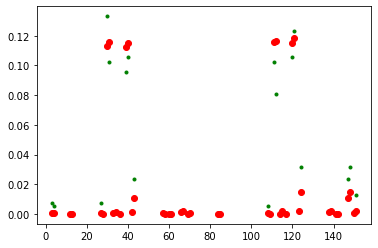

In [57]:
b = []
a = []
for i in range(basis.Ns):
    if (np.abs(psi_var[i])**2>=1e-4):
        b.append(np.abs(psi_var[i])**2)
        a.append(i)
y = []
x = []
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])**2>=1e-3:
        y.append(np.abs(eigenvectors[:,0][i])**2) 
        x.append(i)
n = []
m = []
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,1][i])**2>=1e-3:
        n.append(np.abs(eigenvectors[:,1][i])**2) 
        m.append(i)
     


        

plt.plot(a,b, "o",color = "r")
plt.plot(x,y, ".",color = "g")
#plt.plot(m,n, "o",color = "b")

In [ ]:
colors = ["yellow","black","red"]
for i in range(3):
    plt.plot(iterations[i][i::3], energies[i][i::3],'.', color = colors[i])
plt.plot(iterations[i],eigenvalues[0]*np.ones(3000), ls = "--", color ="black", label = "ground state")
plt.plot(iterations[i],eigenvalues[1]*np.ones(3000), ls = "-.", color ="grey", label = "1st excited state")
plt.legend()
plt.ylim(-2,10)
plt.xlim(0,n_iter)
plt.xlabel("#Iterations")
plt.ylabel("Cost function")
plt.yticks([-2,-1,0,1,2,3,4,5,6,7,8,9,10])
#plt.savefig("figures/M=0.1,L="+str(L)+",N="+str(N)+",3runs.pdf",bbox_tight=True)

In [ ]:
fig = optuna.visualization.plot_optimization_history(study)
#fig.update_yaxes(range = list([-0.81,-0.71]))
fig.update_yaxes(title = "Cost function")
fig.update_xaxes(title = "#Iteration")
#fig.update_xaxes(range = list([600,1000]))
fig.show()
fig.write_image("L=5,M=0.1,N="+str(N)+",n_iter="+str(n_iter)+",1.png")

In [ ]:
fig_1 = optuna.visualization.plot_optimization_history(study)
fig_1.update_yaxes(range = list([-0.783,-0.78]))
fig_1.update_yaxes(title = "Cost function")
fig_1.update_xaxes(title = "#Iteration")
fig_1.update_xaxes(range = list([4500,5000]))
fig_1.show()
fig_1.write_image("L=5,M=0.1,N="+str(N)+",n_iter="+str(n_iter)+",1,small.png")

In [ ]:
f = open("M=0.1,L=5.txt", "a")
f.write(str(N)+" "+" "+str(np.abs(np.dot(np.conj(psi_var),eigenvectors[:,0]))**2)+" "+str(np.real(np.conj(psi_var)@full_ham_matrix@psi_var))+"\n")
f.close()

In [ ]:
result = scipy.optimize.minimize(cost_function_sigma, theta, method='Nelder-Mead',options={'initial_simplex': None, 'xatol': 1e-6, 'fatol': 1e-4})

In [ ]:
print(result.fun)
print(result.x)

In [ ]:

string = ""
for i in range(basis.Ns):
    if np.abs(psi_var[i])>=1e-5:
        string+=str(psi_var[i])+basis.int_to_state(basis.Ns-i-1)+"\n"
        #for j in range(basis.Ns):
            #if (np.abs(np.abs(eigenvectors[:,0][i])-np.abs(eigenvectors[:,0][j]))<=1e-5) & (i<j):
                #print(basis.int_to_state(basis.Ns-i-1),basis.int_to_state(basis.Ns-j-1))
print(string)

In [ ]:
string = ""
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])>=1e-5:
        string+=str(eigenvectors[:,0][i])+basis.int_to_state(basis.Ns-i-1)+"\n"
        #for j in range(basis.Ns):
            #if (np.abs(np.abs(eigenvectors[:,0][i])-np.abs(eigenvectors[:,0][j]))<=1e-5) & (i<j):
                #print(basis.int_to_state(basis.Ns-i-1),basis.int_to_state(basis.Ns-j-1))
print(string)

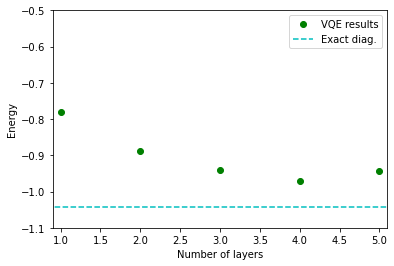

In [36]:
plt.plot(np.array([1,2,3,4,5]),Energy,'o', color = "green",label="VQE results")
plt.plot(np.array([0,1,2,3,4,5,6]),eigenvalues[0]*np.ones(7), ls = "--", color ="c", label = "Exact diag.")
plt.xlabel("Number of layers")
plt.ylabel("Energy")
plt.ylim(-1.1,-0.5)
plt.xlim(0.9,5.1)
plt.legend()

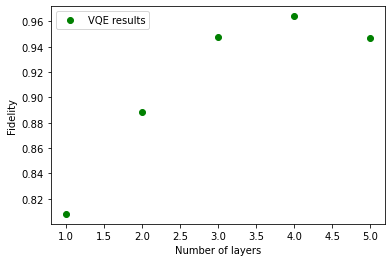

In [37]:
plt.plot(np.array([1,2,3,4,5]),Fidelity,'o', color = "green",label="VQE results")
plt.xlabel("Number of layers")
plt.ylabel("Fidelity")
plt.legend()